# Projet Machine Learning : Prédiction de l'émission de CO2

Duchesne Pierre, Hountongbe Claudia, Marais Mathilde, Soufflet Julia 

In [50]:
library(ggplot2)
library(reshape2)
library(gridExtra)
library(corrplot)
library(FactoMineR)
library(factoextra)
library(ggpubr)
library(crosstable)
library(GGally)
library(glmnet)
library(e1071)
library(rpart) 
library(randomForest)
library(DescTools)
library(forecast)
library(plotly)
library(gbm)
library(pROC)
library(ROCR)
library(MASS)
library(nnet)

# Analyse exploratoire des données : 

## Question 1: Visualisation des données 

In [51]:
energy = read.csv("global-data-on-sustainable-energy (1).csv")

In [52]:
head(energy)


Entity      Year Access.to.electricity....of.population.
1 Afghanistan 2000  1.613591                              
2 Afghanistan 2001  4.074574                              
3 Afghanistan 2002  9.409158                              
4 Afghanistan 2003 14.738506                              
5 Afghanistan 2004 20.064968                              
6 Afghanistan 2005 25.390894                              
  Access.to.clean.fuels.for.cooking
1  6.2                             
2  7.2                             
3  8.2                             
4  9.5                             
5 10.9                             
6 12.2                             
  Renewable.electricity.generating.capacity.per.capita
1 9.22                                                
2 8.86                                                
3 8.47                                                
4 8.09                                                
5 7.75                                                
6 7.51                                                
  Financial.flows.to.developing.countries..US...
1    20000                                      
2   130000                                      
3  3950000                                      
4 25970000                                      
5       NA                                      
6  9830000                                      
  Renewable.energy.share.in.the.total.final.energy.consumption....
1 44.99                                                           
2 45.60                                                           
3 37.83                                                           
4 36.66                                                           
5 44.24                                                           
6 33.88                                                           
  Electricity.from.fossil.fuels..TWh. Electricity.from.nuclear..TWh.
1 0.16                                0                             
2 0.09                                0                             
3 0.13                                0                             
4 0.31                                0                             
5 0.33                                0                             
6 0.34                                0                             
  Electricity.from.renewables..TWh. ⋯
1 0.31                              ⋯
2 0.50                              ⋯
3 0.56                              ⋯
4 0.63                              ⋯
5 0.56                              ⋯
6 0.59                              ⋯
  Primary.energy.consumption.per.capita..kWh.person.
1 302.5948                                          
2 236.8919                                          
3 210.8622                                          
4 229.9682                                          
5 204.2312                                          
6 252.0691                                          
  Energy.intensity.level.of.primary.energy..MJ..2017.PPP.GDP.
1 1.64                                                       
2 1.74                                                       
3 1.40                                                       
4 1.40                                                       
5 1.20                                                       
6 1.41                                                       
  Value_co2_emissions_kt_by_country Renewables....equivalent.primary.energy.
1  760                              NA                                      
2  730                              NA                                      
3 1030                              NA                                      
4 1220                              NA                                      
5 1030                              NA                                      
6 1550                              NA                                      
  gdp_growth gdp_per_capita Density.n.P.Km2. La

### Variables renommées pour plus de clarté dans les graphiques 

In [53]:
# Accès et modification des noms des colonnes
column_names=names(energy)
#print(column_names)
new_column_names=c("Entity", "Year","Access_elec","Access_fuels","Renewable_elec","Financial_flows","Renewable_energy","Elec_fossil","Elec_nuclear","Elec_renew","Low_carbon","Primary_energy","Energy_intensity","Value_co2","Renewables_equivalent","gdp_growth","gdp_capita","Density","Land_area","Latitude","Longitude")  # Remplacez ... par les nouveaux noms des colonnes

# Réassigner les noms des colonnes
names(energy)=new_column_names
print(names(energy))

 [1] "Entity"                "Year"                  "Access_elec"          
 [4] "Access_fuels"          "Renewable_elec"        "Financial_flows"      
 [7] "Renewable_energy"      "Elec_fossil"           "Elec_nuclear"         
[10] "Elec_renew"            "Low_carbon"            "Primary_energy"       
[13] "Energy_intensity"      "Value_co2"             "Renewables_equivalent"
[16] "gdp_growth"            "gdp_capita"            "Density"              
[19] "Land_area"             "Latitude"              "Longitude"            


In [54]:
str(energy)

'data.frame':	3649 obs. of  21 variables:
 $ Entity               : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Year                 : int  2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
 $ Access_elec          : num  1.61 4.07 9.41 14.74 20.06 ...
 $ Access_fuels         : num  6.2 7.2 8.2 9.5 10.9 ...
 $ Renewable_elec       : num  9.22 8.86 8.47 8.09 7.75 7.51 7.4 7.25 7.49 7.5 ...
 $ Financial_flows      : num  20000 130000 3950000 25970000 NA ...
 $ Renewable_energy     : num  45 45.6 37.8 36.7 44.2 ...
 $ Elec_fossil          : num  0.16 0.09 0.13 0.31 0.33 0.34 0.2 0.2 0.19 0.16 ...
 $ Elec_nuclear         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Elec_renew           : num  0.31 0.5 0.56 0.63 0.56 0.59 0.64 0.75 0.54 0.78 ...
 $ Low_carbon           : num  66 84.7 81.2 67 62.9 ...
 $ Primary_energy       : num  303 237 211 230 204 ...
 $ Energy_intensity     : num  1.64 1.74 1.4 1.4 1.2 1.41 1.5 1.53 1.94 2.25 ...
 $ Value_co2            : num  760 730 10

In [55]:
#Convertir Year et Entity en variables qualitatives
energy$Year = as.factor(energy$Year)
energy$Entity= as.factor(energy$Entity)

In [56]:
#Convertir Density en une variable numérique
energy$Density = as.numeric(gsub(",","",energy$Density))

In [57]:
str(energy)

'data.frame':	3649 obs. of  21 variables:
 $ Entity               : Factor w/ 176 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Year                 : Factor w/ 21 levels "2000","2001",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Access_elec          : num  1.61 4.07 9.41 14.74 20.06 ...
 $ Access_fuels         : num  6.2 7.2 8.2 9.5 10.9 ...
 $ Renewable_elec       : num  9.22 8.86 8.47 8.09 7.75 7.51 7.4 7.25 7.49 7.5 ...
 $ Financial_flows      : num  20000 130000 3950000 25970000 NA ...
 $ Renewable_energy     : num  45 45.6 37.8 36.7 44.2 ...
 $ Elec_fossil          : num  0.16 0.09 0.13 0.31 0.33 0.34 0.2 0.2 0.19 0.16 ...
 $ Elec_nuclear         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Elec_renew           : num  0.31 0.5 0.56 0.63 0.56 0.59 0.64 0.75 0.54 0.78 ...
 $ Low_carbon           : num  66 84.7 81.2 67 62.9 ...
 $ Primary_energy       : num  303 237 211 230 204 ...
 $ Energy_intensity     : num  1.64 1.74 1.4 1.4 1.2 1.41 1.5 1.53 1.94 2.25 ...
 $ Value_co2            : num  760 730 

## Question 2: Identification des valeurs manquantes

### Taux de valeurs manquantes

In [58]:
sum(is.na(energy))*100/(21*3649)

[1] 9.106213

### Taux de valeurs manquantes par colonne

In [59]:
#tx = colMeans(is.na(energy))*100
missing = sort(colSums(is.na(energy)),decreasing = TRUE )
tx = missing*100/(3649) 
print(missing)
print(tx)

Renewables_equivalent       Financial_flows        Renewable_elec 
                 2137                  2089                   931 
            Value_co2            gdp_growth            gdp_capita 
                  428                   317                   282 
     Energy_intensity      Renewable_energy          Access_fuels 
                  207                   194                   169 
         Elec_nuclear            Low_carbon           Elec_fossil 
                  126                    42                    21 
           Elec_renew           Access_elec               Density 
                   21                    10                     1 
            Land_area              Latitude             Longitude 
                    1                     1                     1 
               Entity                  Year        Primary_energy 
                    0                     0                     0 
Renewables_equivalent       Financial_flows        Renewable_e

### Suppression des variables corrompues

In [60]:
energy$Renewable_elec = NULL
energy$Financial_flows= NULL
energy$Renewables_equivalent = NULL

In [61]:
energy_pt2 = energy

## Question 3: Suppression des individus avec données manquantes


In [62]:
complete_energy = na.omit(energy)

In [63]:
str(complete_energy)

'data.frame':	2868 obs. of  18 variables:
 $ Entity          : Factor w/ 176 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Year            : Factor w/ 21 levels "2000","2001",..: 4 5 6 7 8 9 10 11 12 13 ...
 $ Access_elec     : num  14.7 20.1 25.4 30.7 36.1 ...
 $ Access_fuels    : num  9.5 10.9 12.2 13.8 15.3 ...
 $ Renewable_energy: num  36.7 44.2 33.9 31.9 28.8 ...
 $ Elec_fossil     : num  0.31 0.33 0.34 0.2 0.2 0.19 0.16 0.19 0.18 0.14 ...
 $ Elec_nuclear    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Elec_renew      : num  0.63 0.56 0.59 0.64 0.75 0.54 0.78 0.75 0.6 0.74 ...
 $ Low_carbon      : num  67 62.9 63.4 76.2 78.9 ...
 $ Primary_energy  : num  230 204 252 304 354 ...
 $ Energy_intensity: num  1.4 1.2 1.41 1.5 1.53 1.94 2.25 2.46 3.23 2.61 ...
 $ Value_co2       : num  1220 1030 1550 1760 1770 ...
 $ gdp_growth      : num  8.83 1.41 11.23 5.36 13.83 ...
 $ gdp_capita      : num  191 211 242 264 360 ...
 $ Density         : num  60 60 60 60 60 60 60 60 60 60 ...
 $ Land_area  

Il y a bien 2868 observations.

In [64]:
sum(is.na(complete_energy))*100/(21*3649)

[1] 0

## Question 4 : Analyse descriptive unidimensionnelle

### Variables qualitatives : Year et Entity 


2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 
 137  138  140  141  141  141  141  144  144  144  145  145  144  145  147  147 
2016 2017 2018 2019 2020 
 146  146  146  146    0 


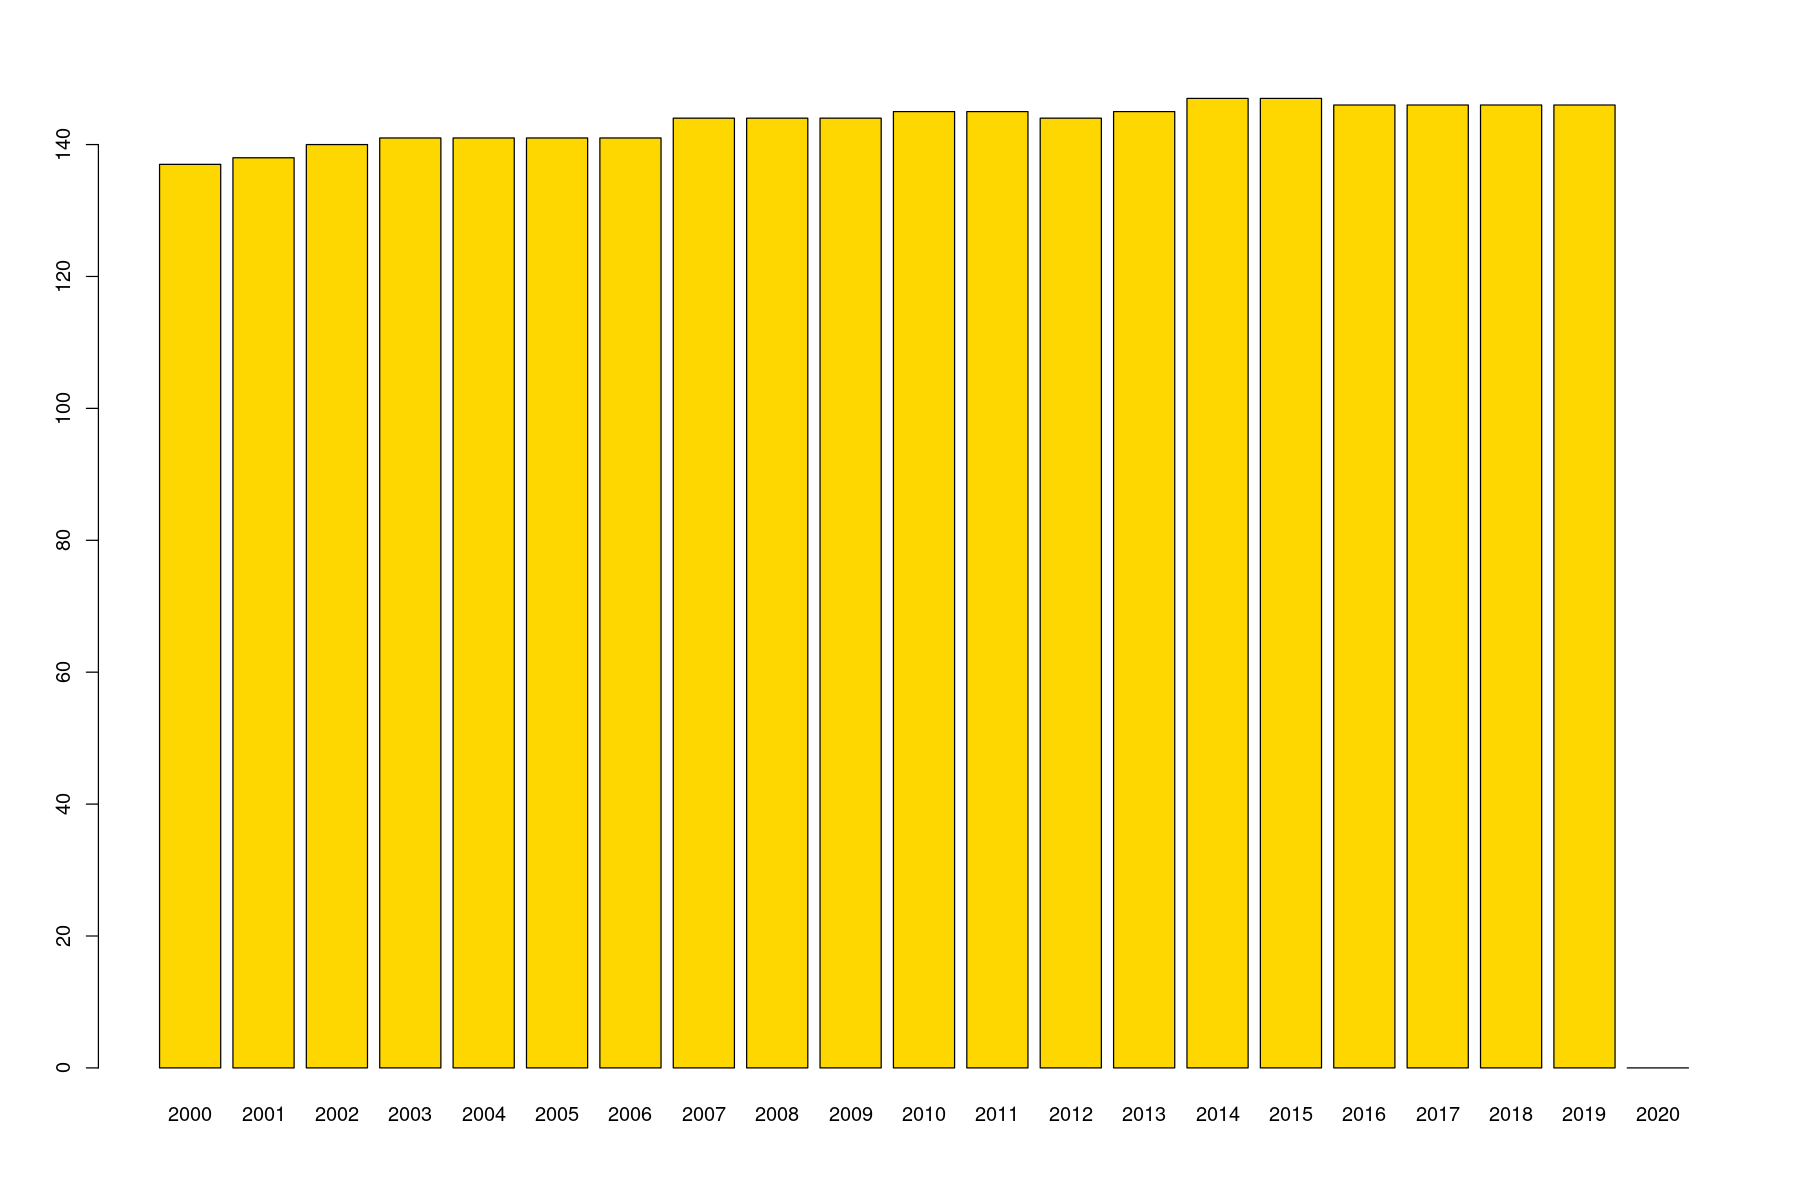

In [65]:
occ_y = table(complete_energy$Year)
print(occ_y)
barplot(occ_y, col="gold")

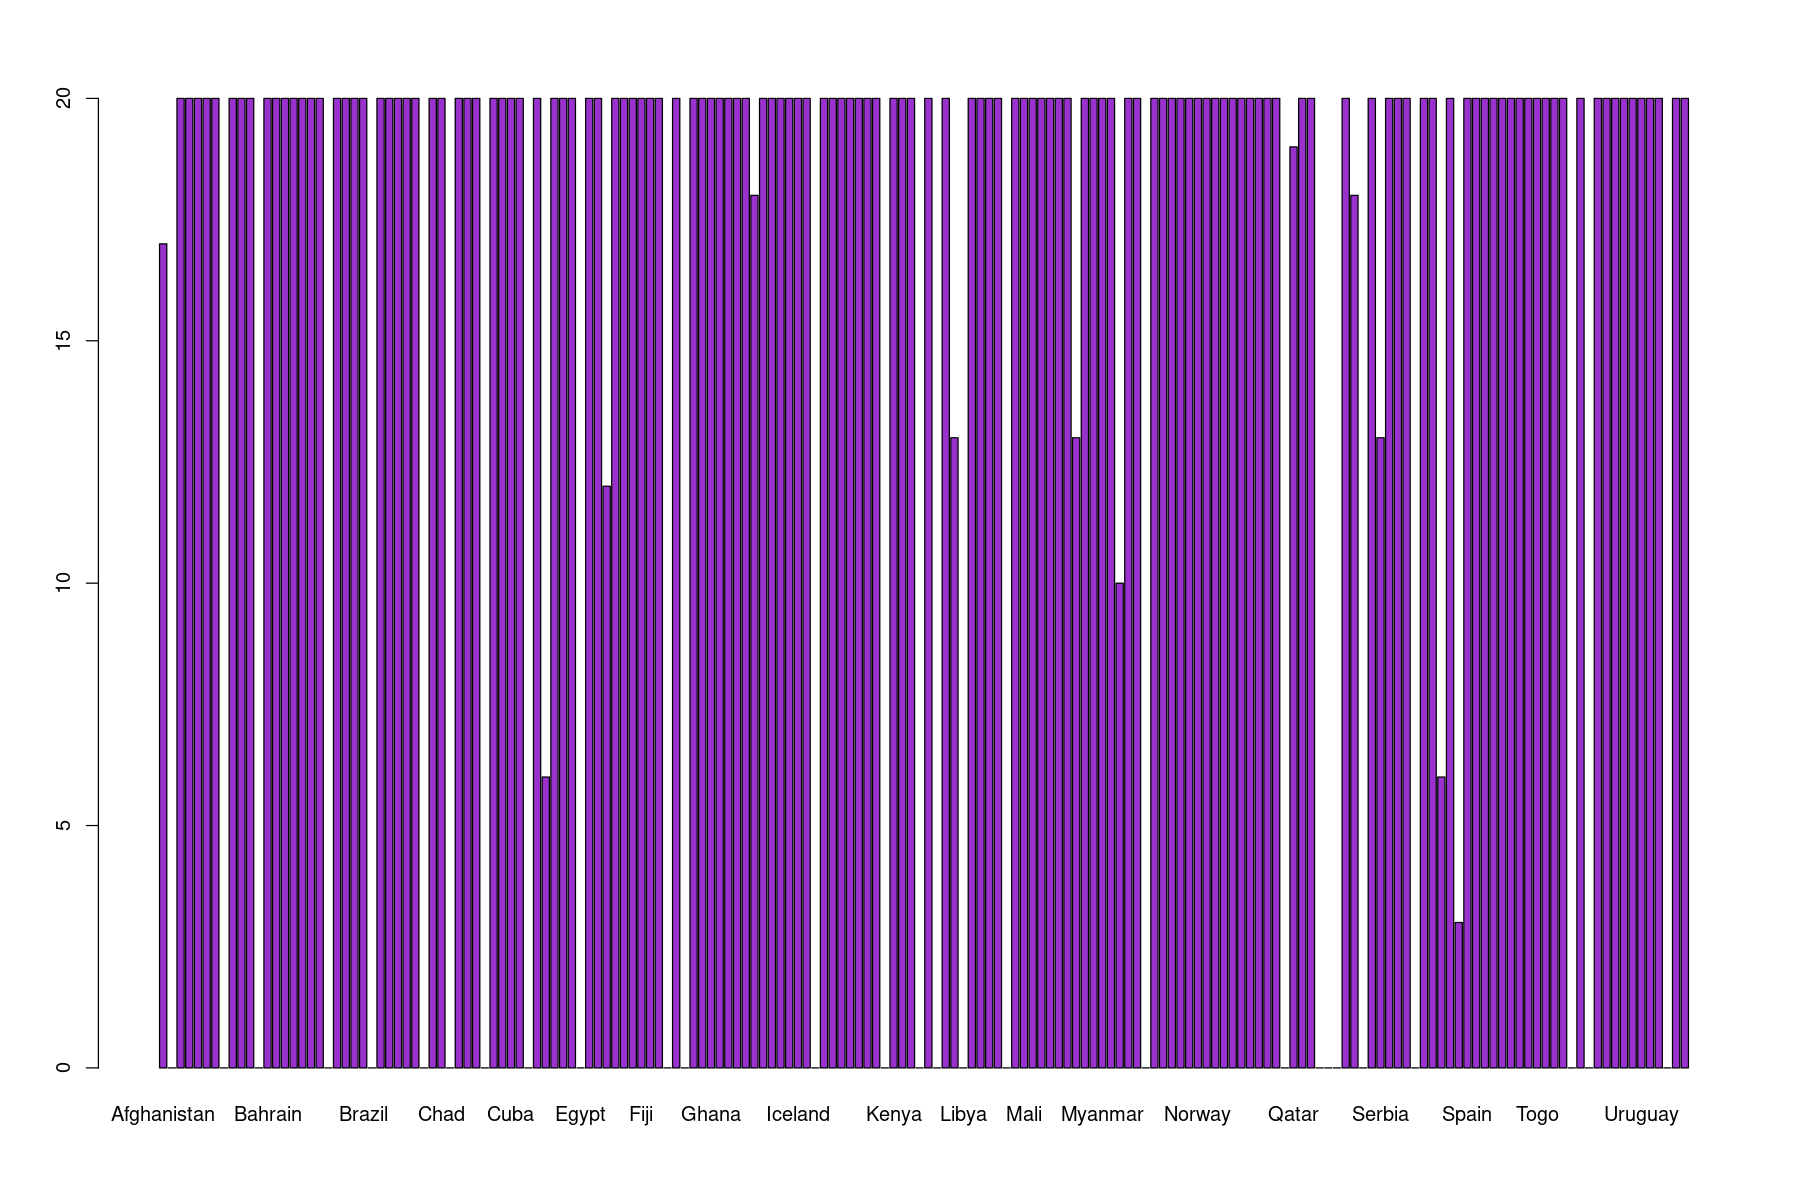

In [66]:
occ_e = table(complete_energy$Entity)
#print(occ_e)
barplot(occ_e,col = "darkorchid")


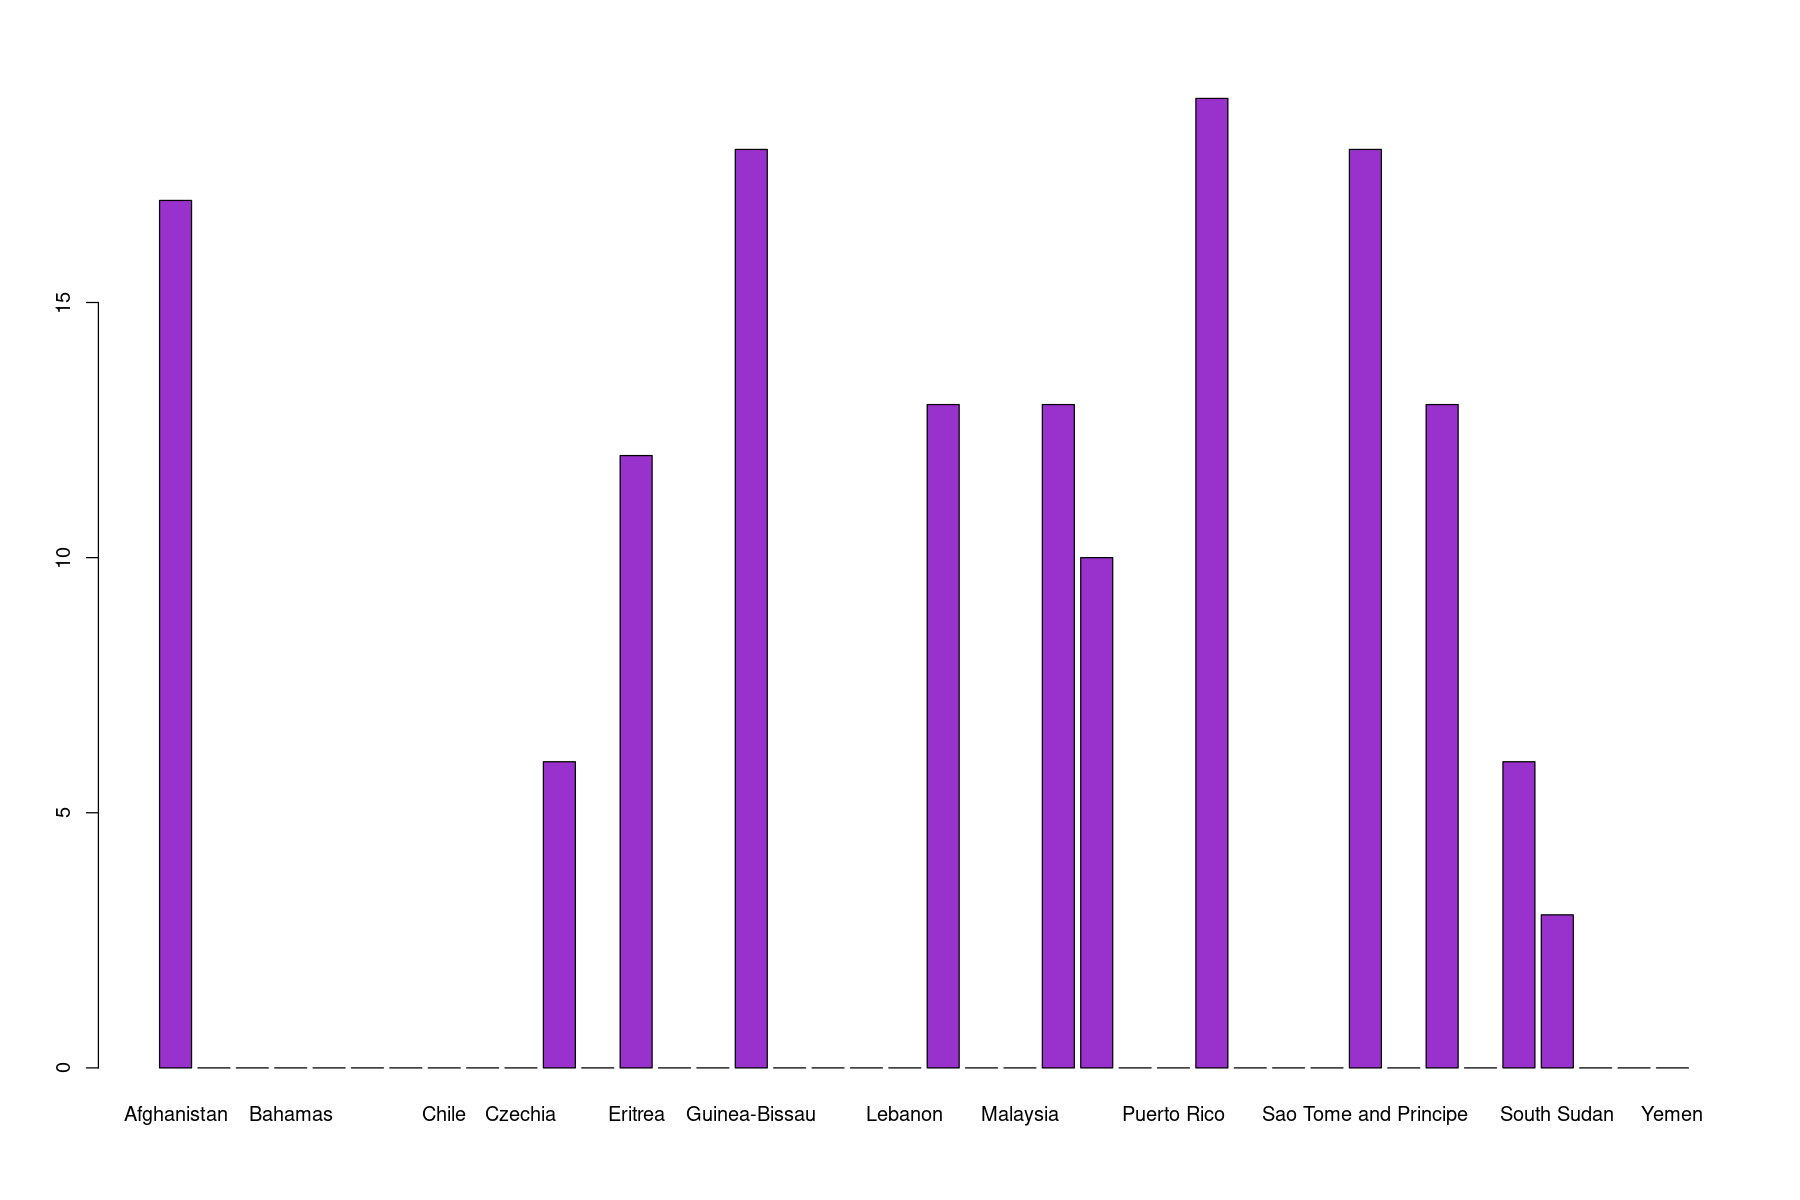

In [67]:
occ_e20 = occ_e[occ_e<20]
barplot(occ_e20,col = "darkorchid")

### Pour les variables quantitatives

In [68]:
summary(complete_energy)

                 Entity          Year       Access_elec       Access_fuels   
 Algeria            :  20   2014   : 147   Min.   :  1.252   Min.   :  0.00  
 Angola             :  20   2015   : 147   1st Qu.: 53.238   1st Qu.: 22.07  
 Antigua and Barbuda:  20   2016   : 146   Median : 97.000   Median : 81.55  
 Argentina          :  20   2017   : 146   Mean   : 76.585   Mean   : 62.17  
 Armenia            :  20   2018   : 146   3rd Qu.:100.000   3rd Qu.:100.00  
 Australia          :  20   2019   : 146   Max.   :100.000   Max.   :100.00  
 (Other)            :2748   (Other):1990                                     
 Renewable_energy  Elec_fossil        Elec_nuclear      Elec_renew     
 Min.   : 0.000   Min.   :   0.000   Min.   :  0.00   Min.   :   0.00  
 1st Qu.: 9.188   1st Qu.:   0.290   1st Qu.:  0.00   1st Qu.:   0.09  
 Median :28.790   Median :   2.995   Median :  0.00   Median :   1.68  
 Mean   :35.802   Mean   :  76.694   Mean   : 15.34   Mean   :  26.60  
 3rd Qu.:60.667 

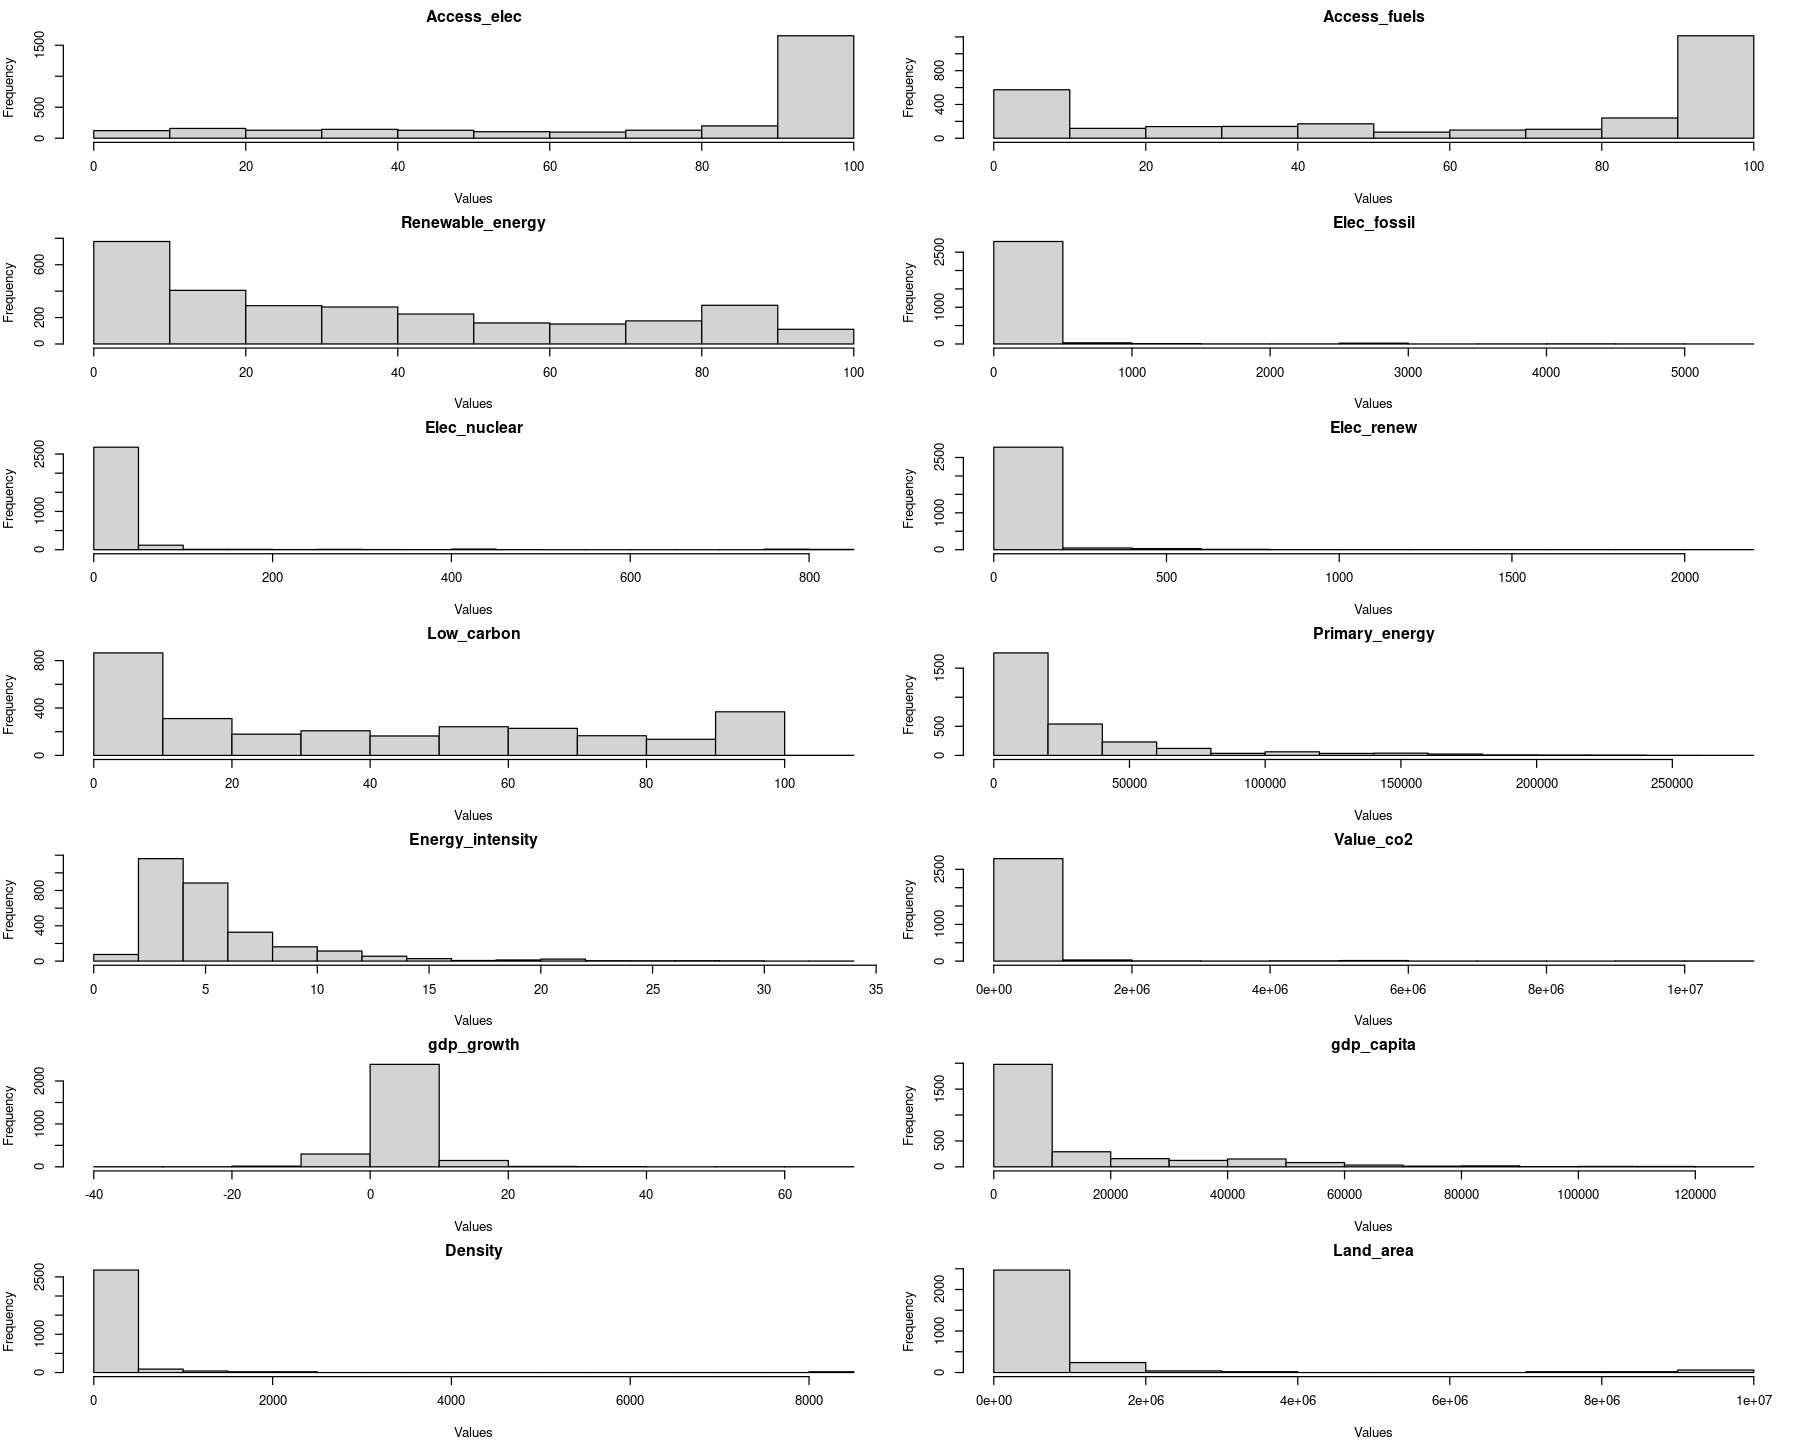

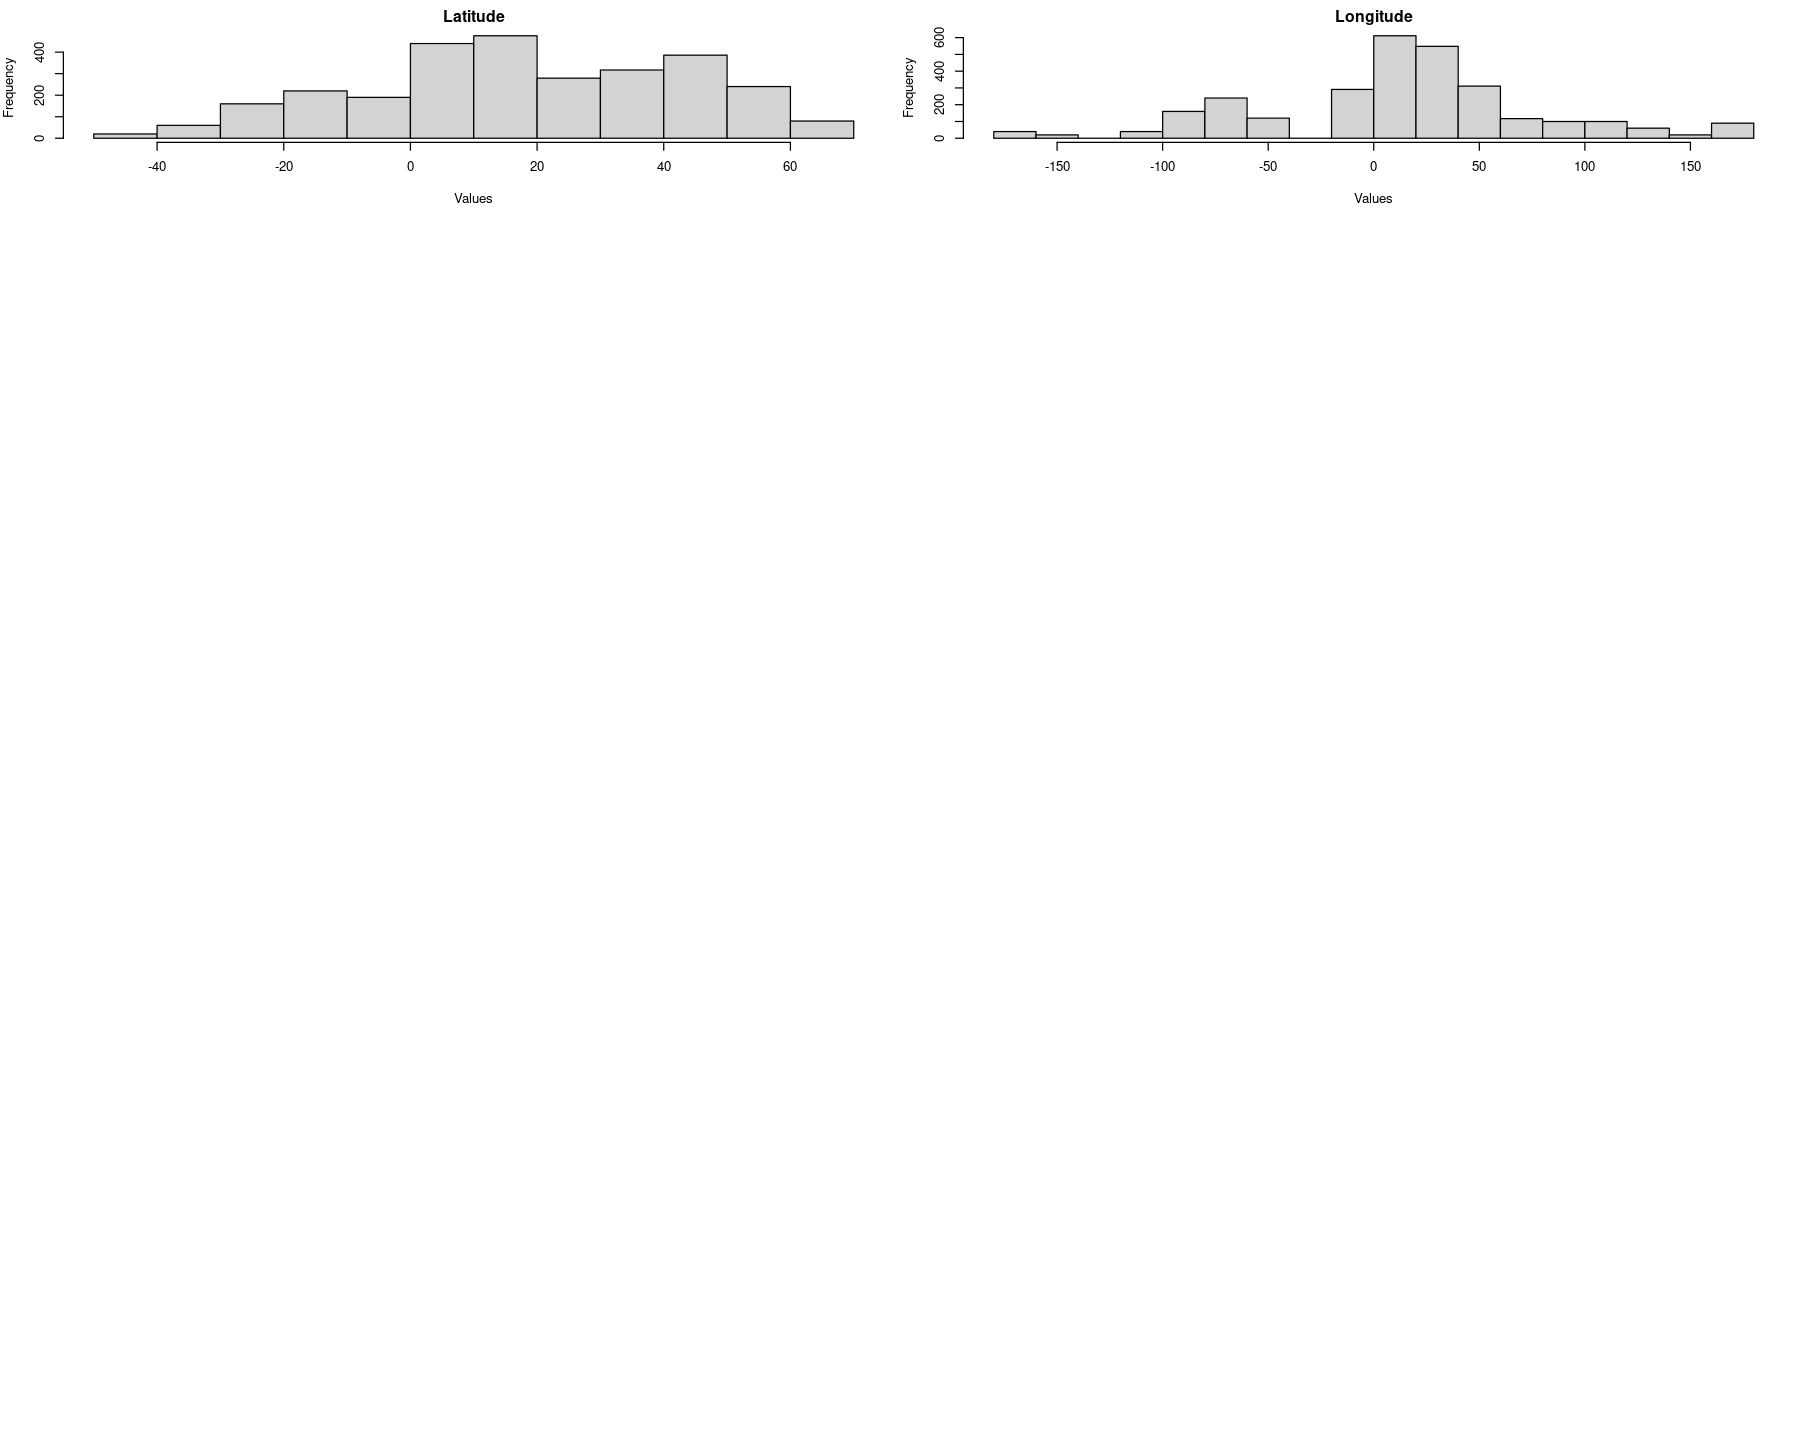

In [69]:
options(repr.plot.width = 15, repr.plot.height = 12)
par(mfrow = c(7,2) , mar = c(4,4,2,1))

for (i in 3:length(names(complete_energy))) {
    dfi = complete_energy[,c(i)]
    hist(dfi, main=names(complete_energy)[i],xlab='Values')
}

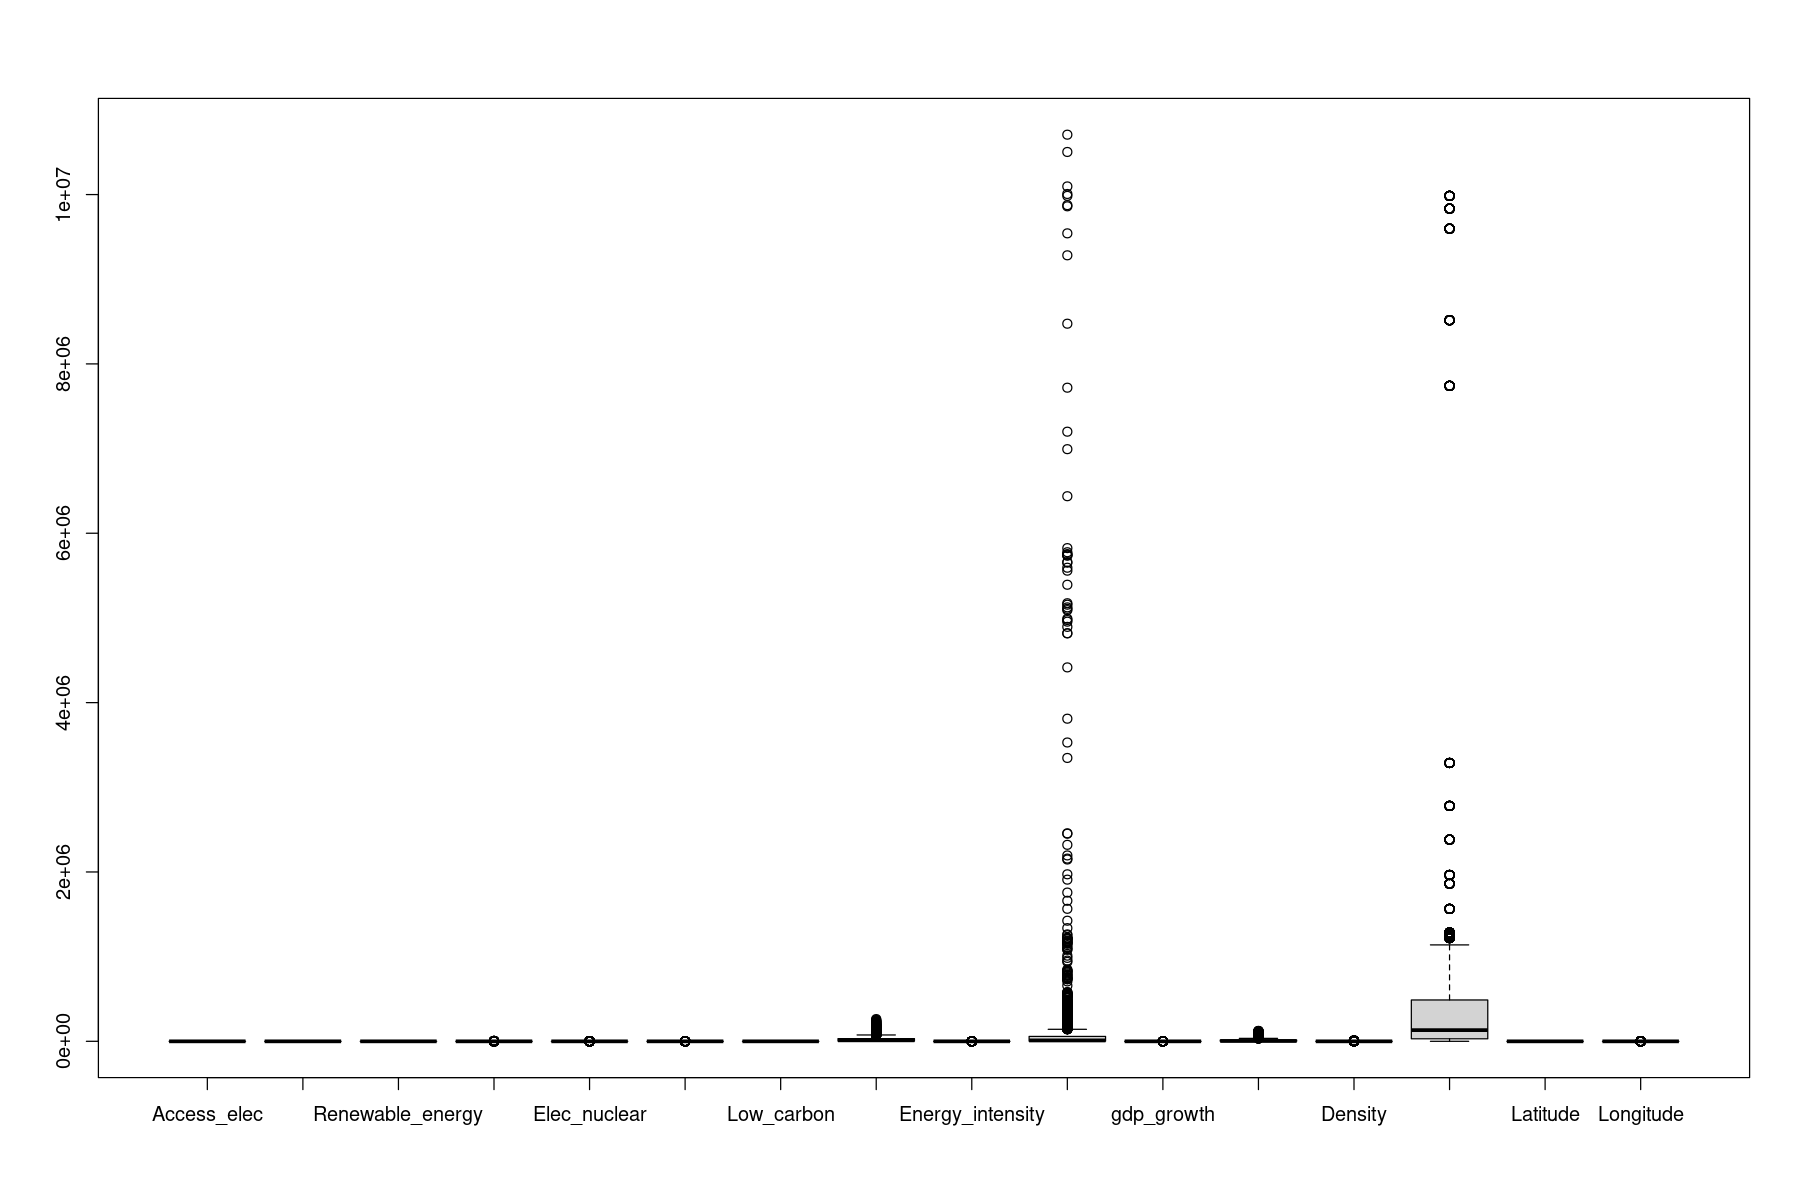

In [70]:
options(repr.plot.width = 15, repr.plot.height = 10)

df = complete_energy[,-c(1,2)]
boxplot(df)

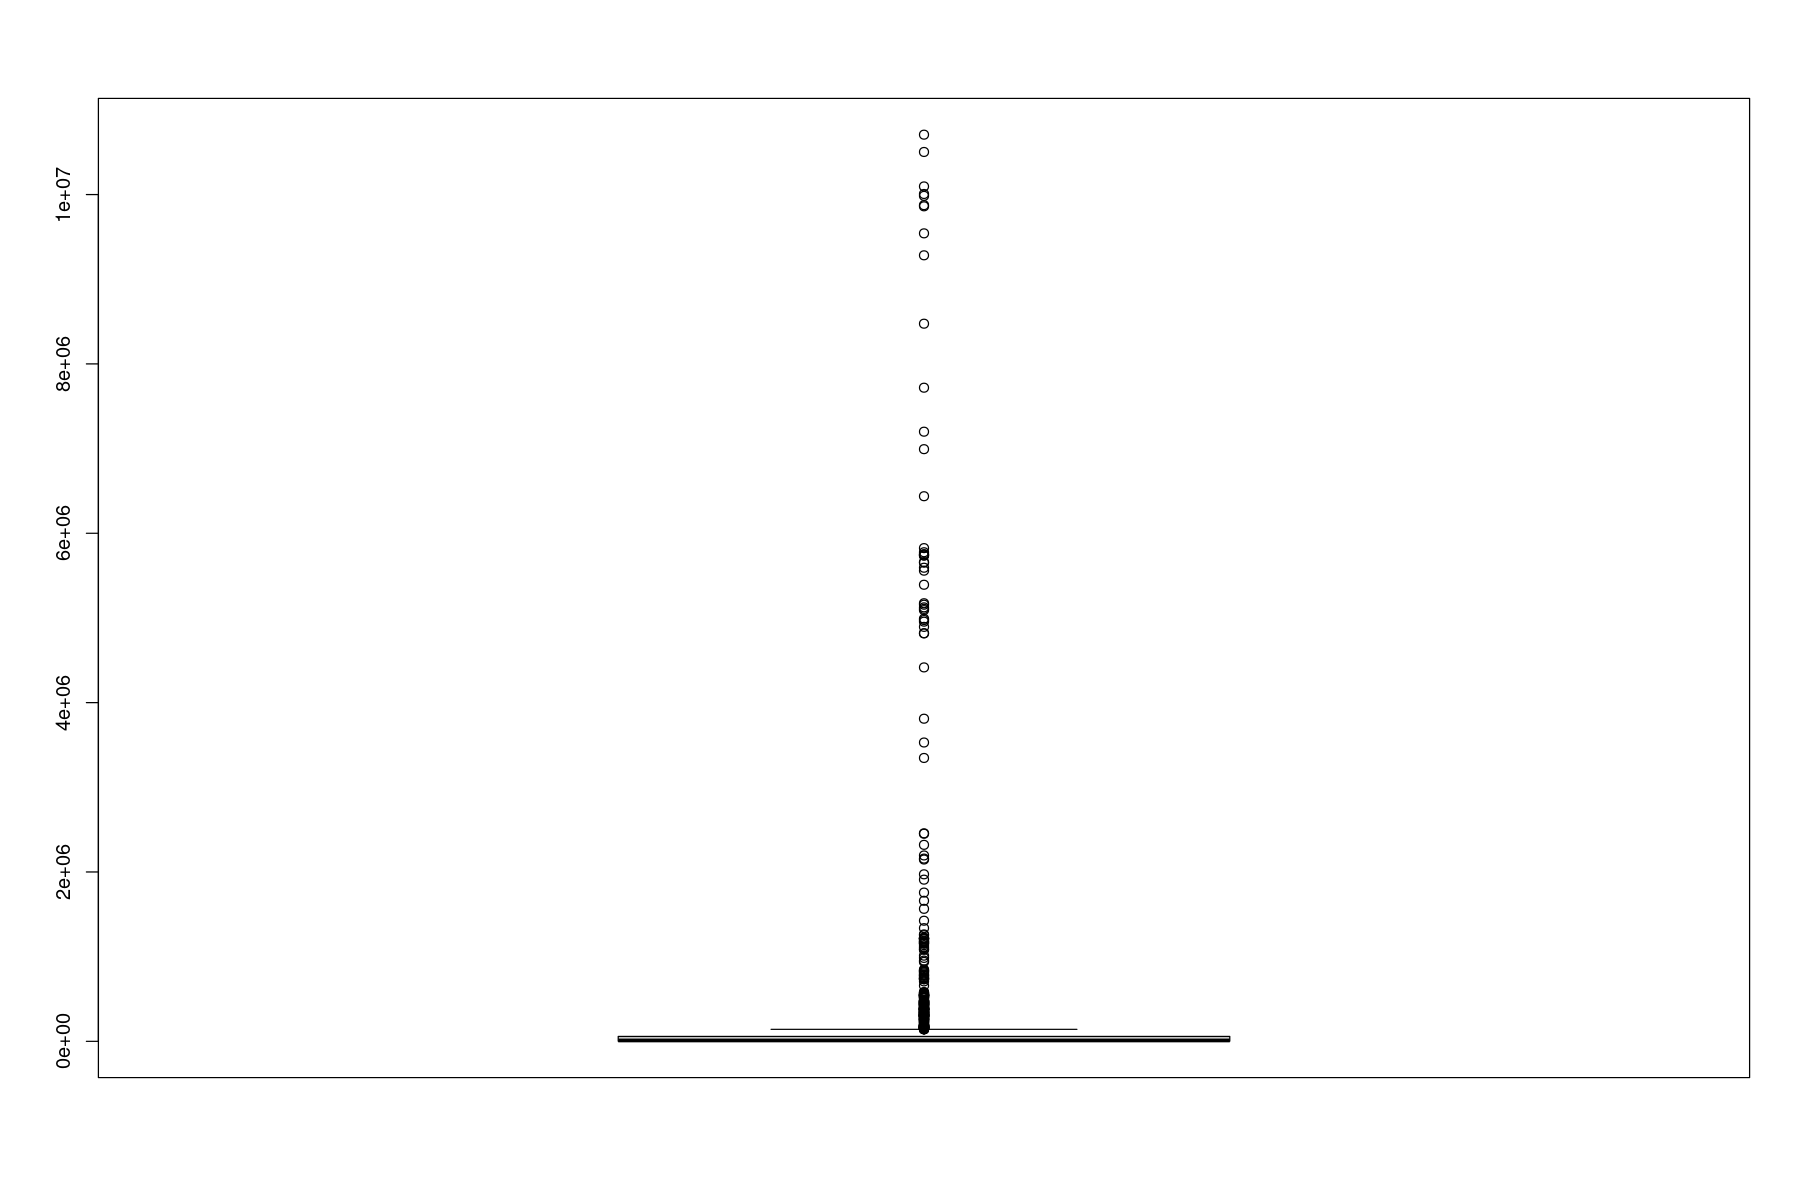

In [71]:
boxplot(df$Value_co2)

### Transformation des variables

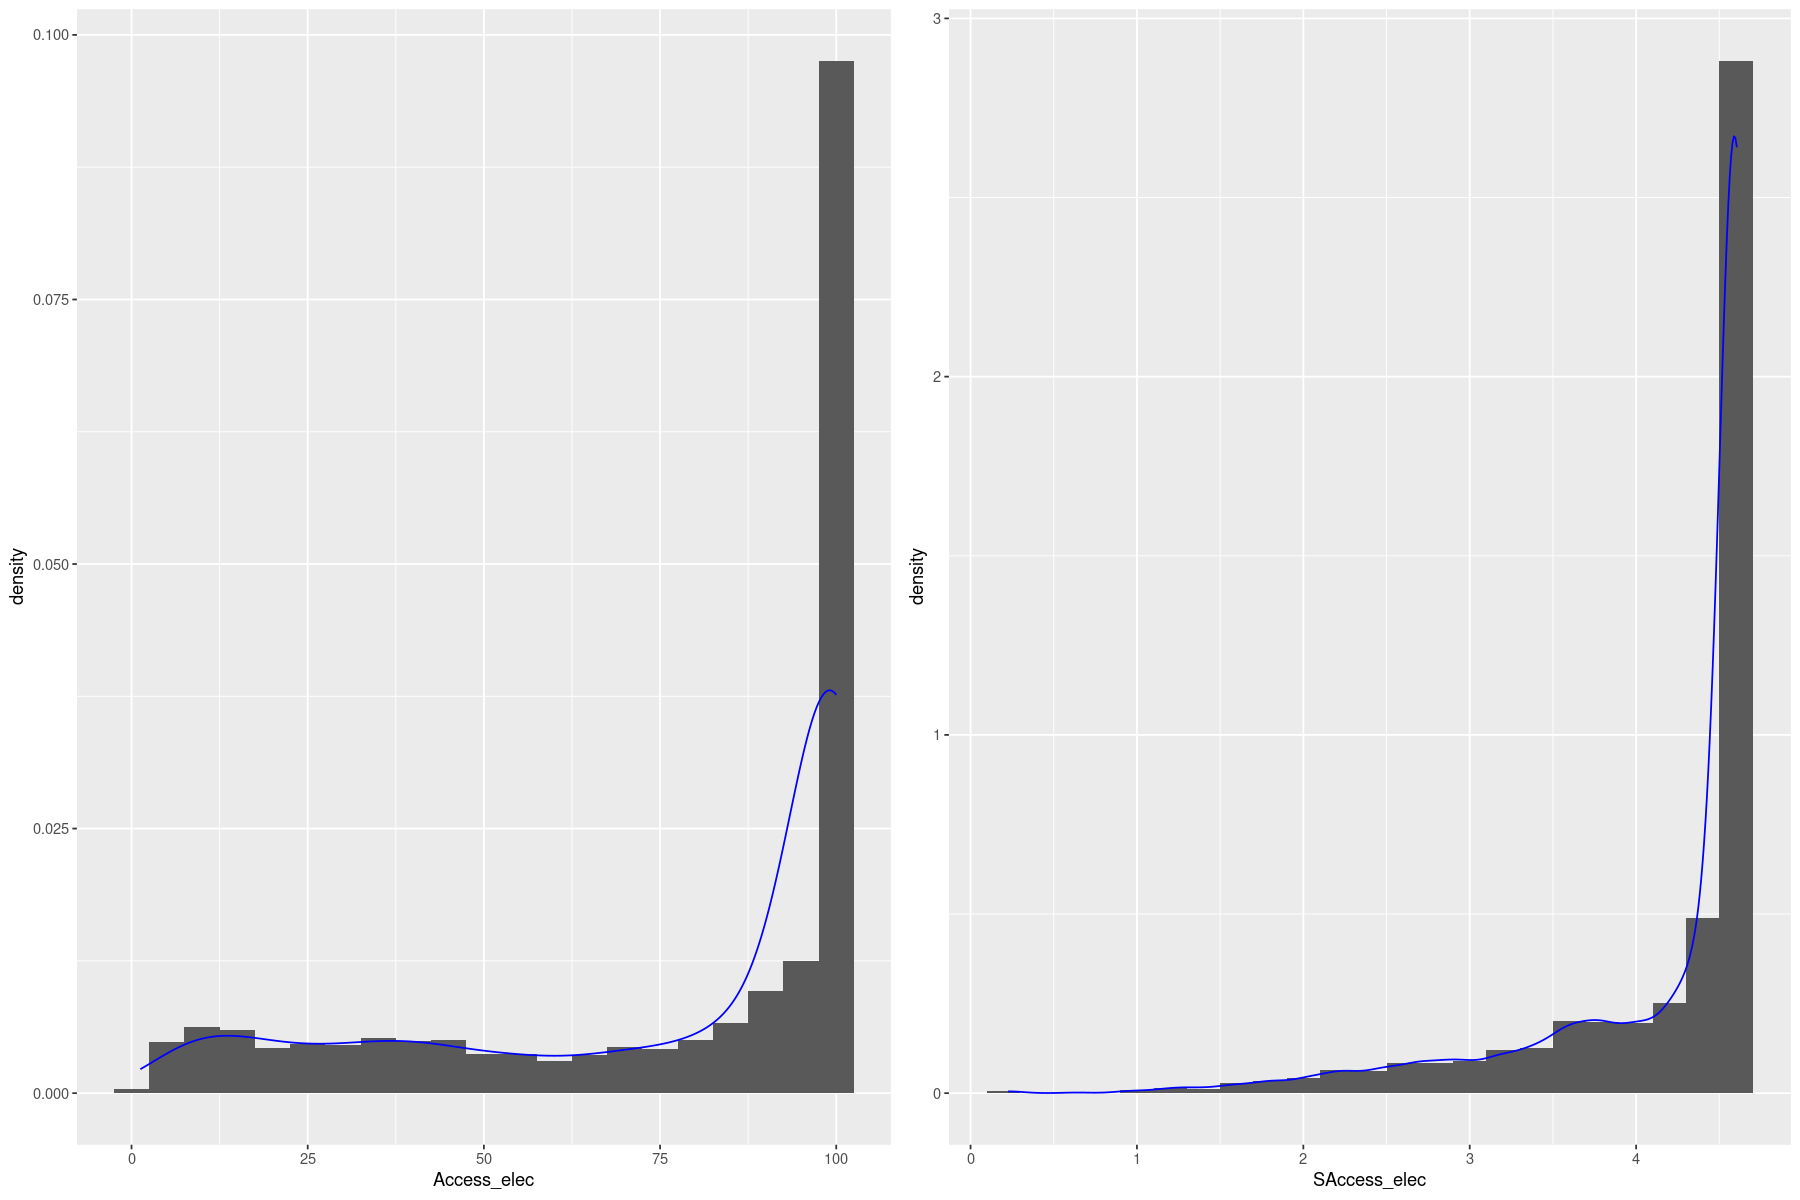

In [72]:
complete_energy[, "SAccess_elec"] = log(complete_energy[, "Access_elec"])

g1 = ggplot(complete_energy,aes(x=Access_elec))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SAccess_elec))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

In [73]:
complete_energy[, "SAccess_fuels"] = log(1+complete_energy[, "Access_fuels"])

g1 = ggplot(complete_energy,aes(x=Access_fuels))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SAccess_fuels))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

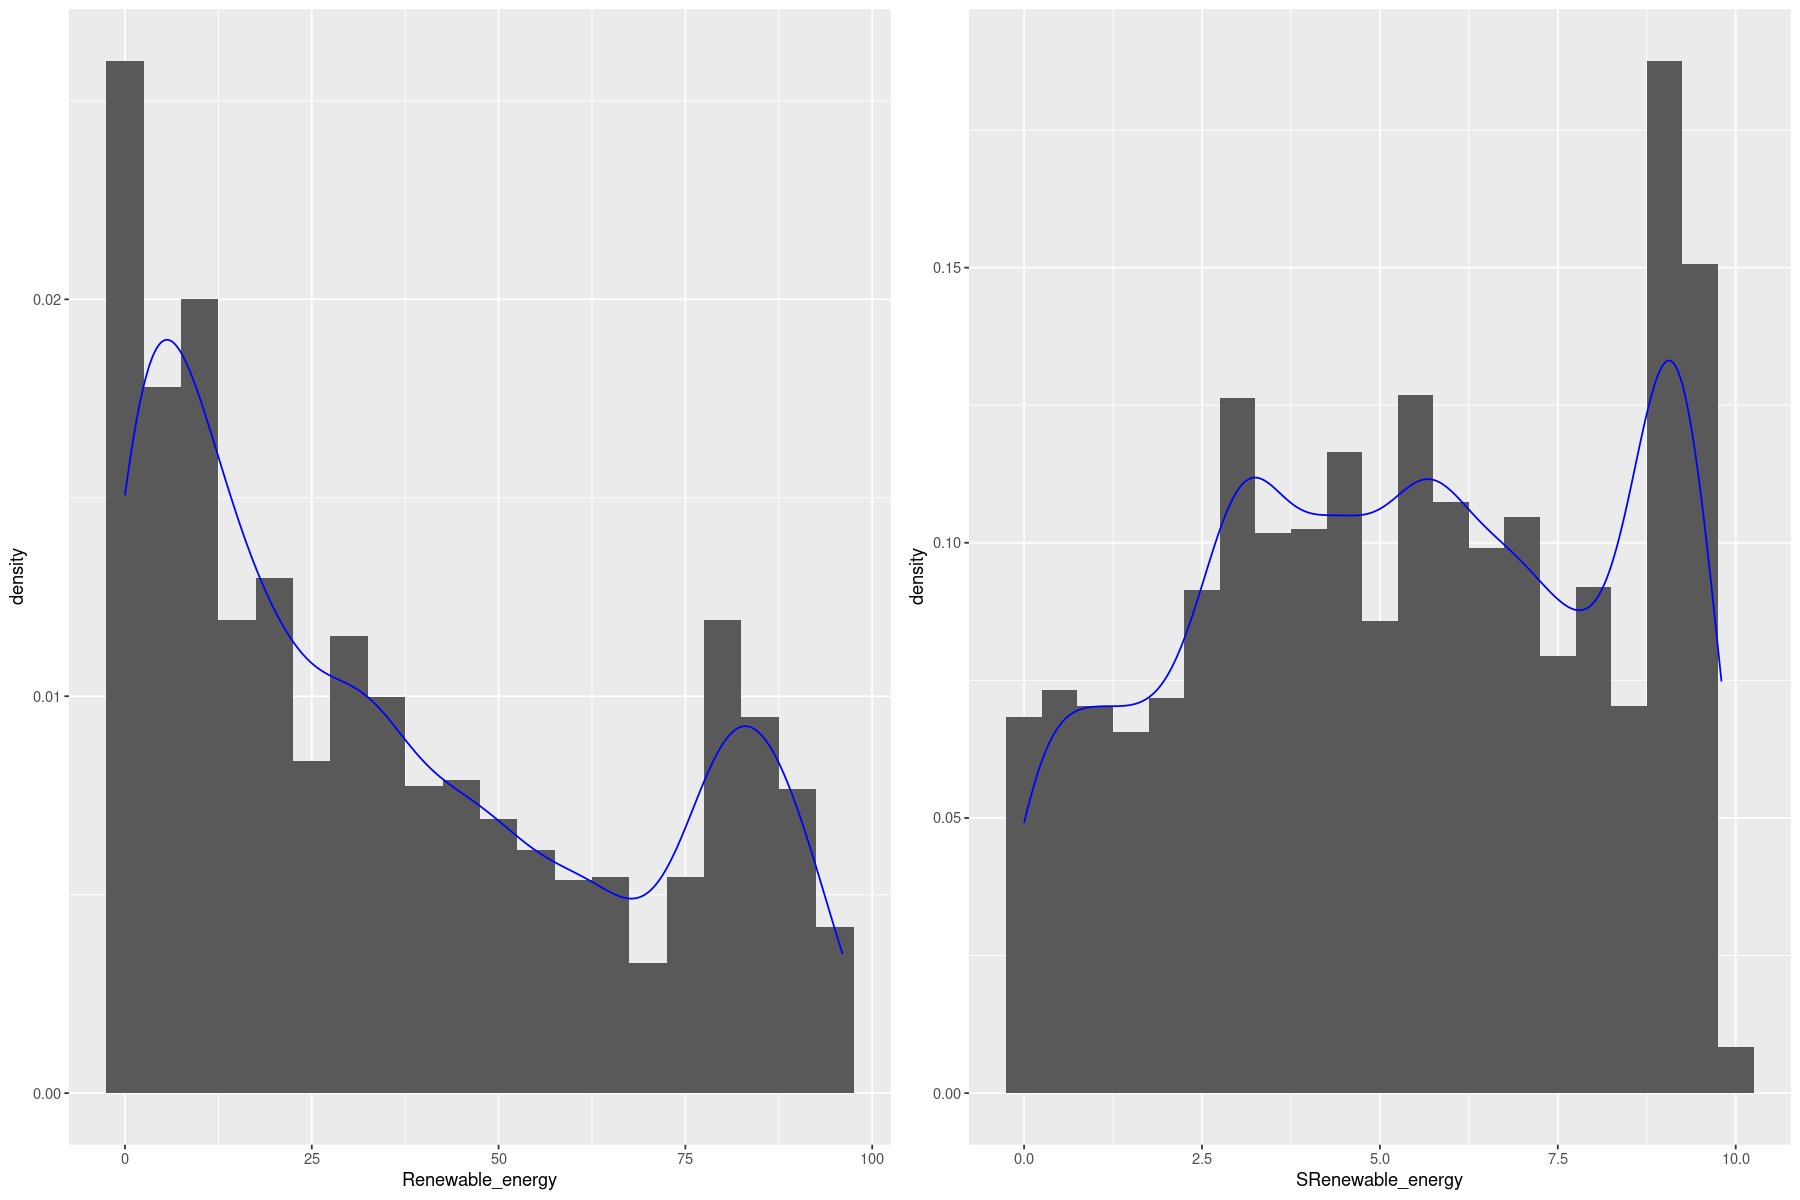

In [74]:
complete_energy[, "SRenewable_energy"] = sqrt(complete_energy[, "Renewable_energy"])

g1 = ggplot(complete_energy,aes(x=Renewable_energy))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SRenewable_energy))+ geom_histogram(aes(y=..density..),binwidth = 0.5)+geom_density(alpha=.1, col="blue") 
grid.arrange(g1,g2,ncol=2)

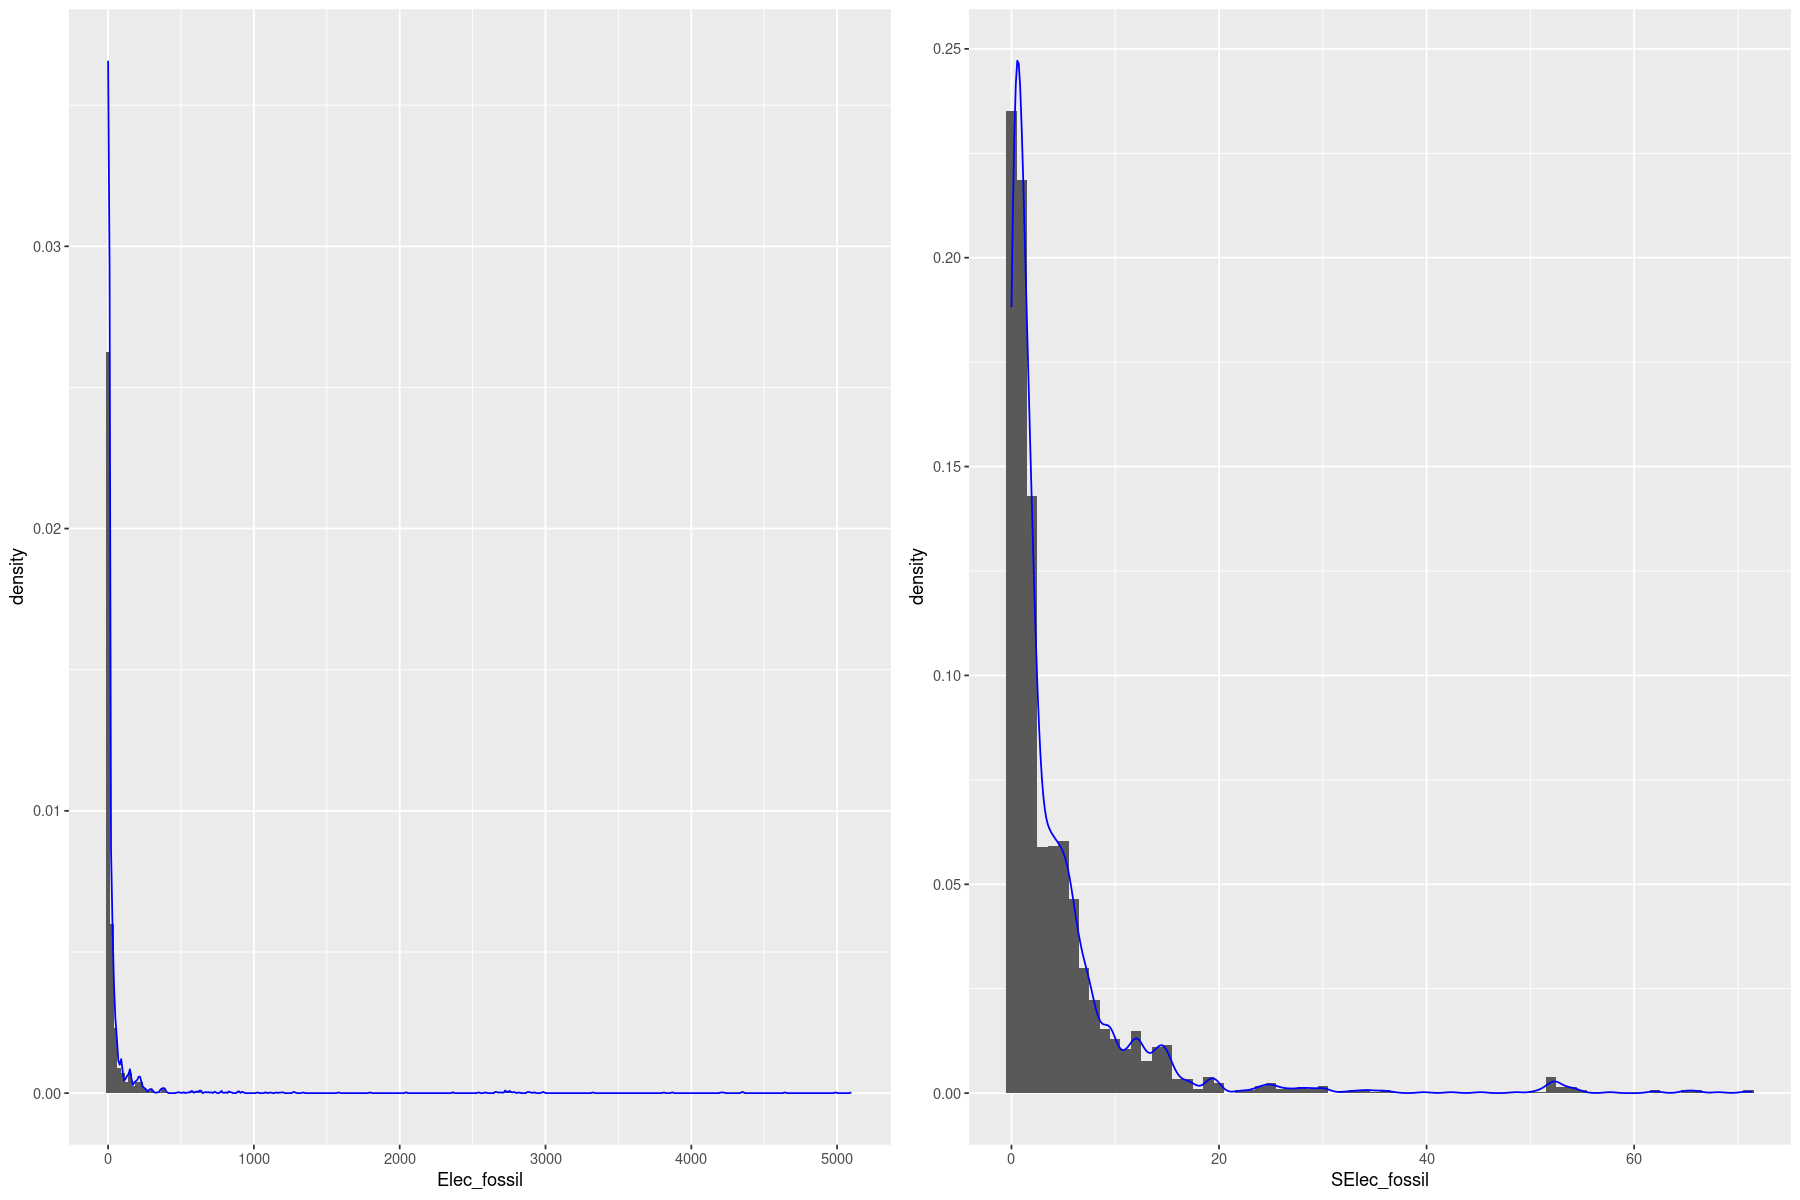

In [75]:
complete_energy[, "SElec_fossil"] = sqrt(complete_energy[, "Elec_fossil"])

g1 = ggplot(complete_energy,aes(x=Elec_fossil))+ geom_histogram(aes(y=..density..),binwidth = 25)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SElec_fossil))+ geom_histogram(aes(y=..density..),binwidth = 1)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

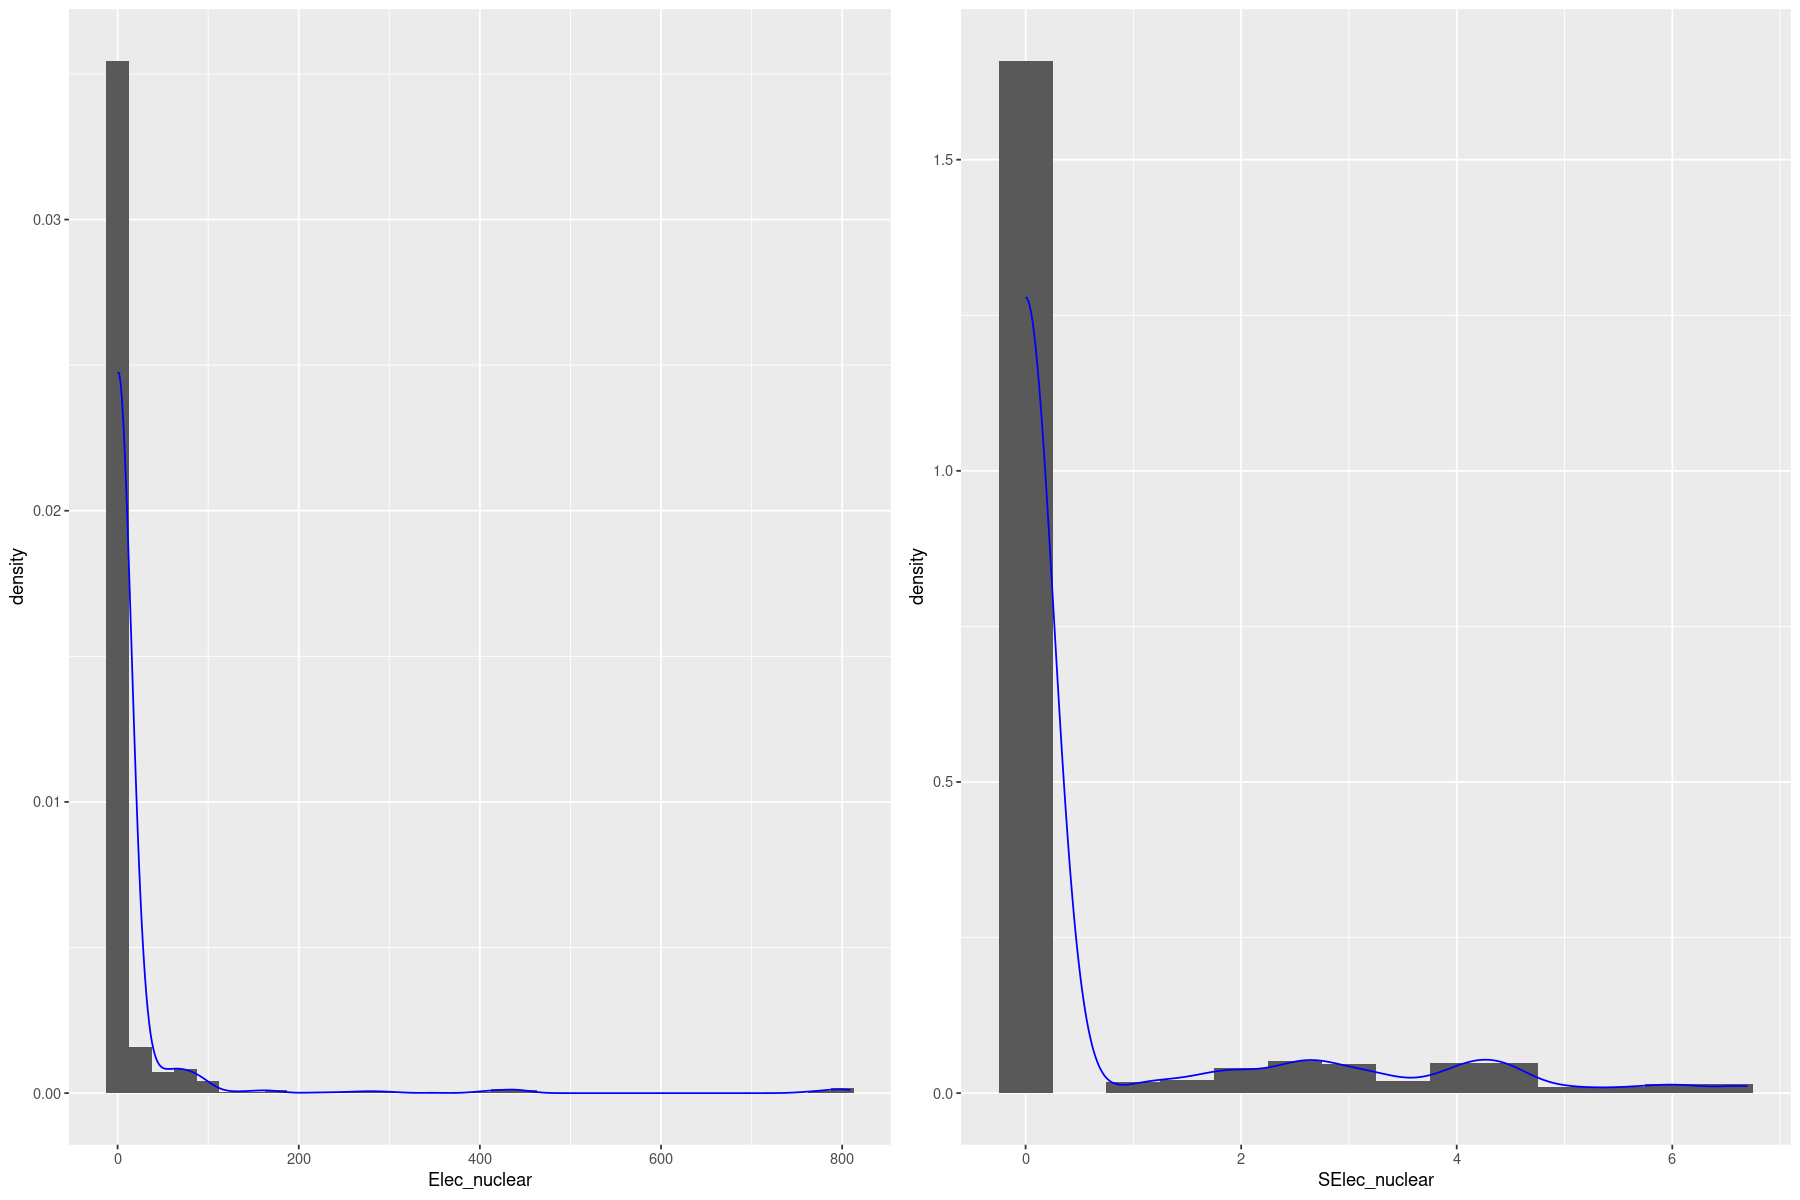

In [76]:
complete_energy[, "SElec_nuclear"] = log(1+complete_energy[, "Elec_nuclear"])

g1 = ggplot(complete_energy,aes(x=Elec_nuclear))+ geom_histogram(aes(y=..density..),binwidth = 25)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SElec_nuclear))+ geom_histogram(aes(y=..density..),binwidth = 0.5)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

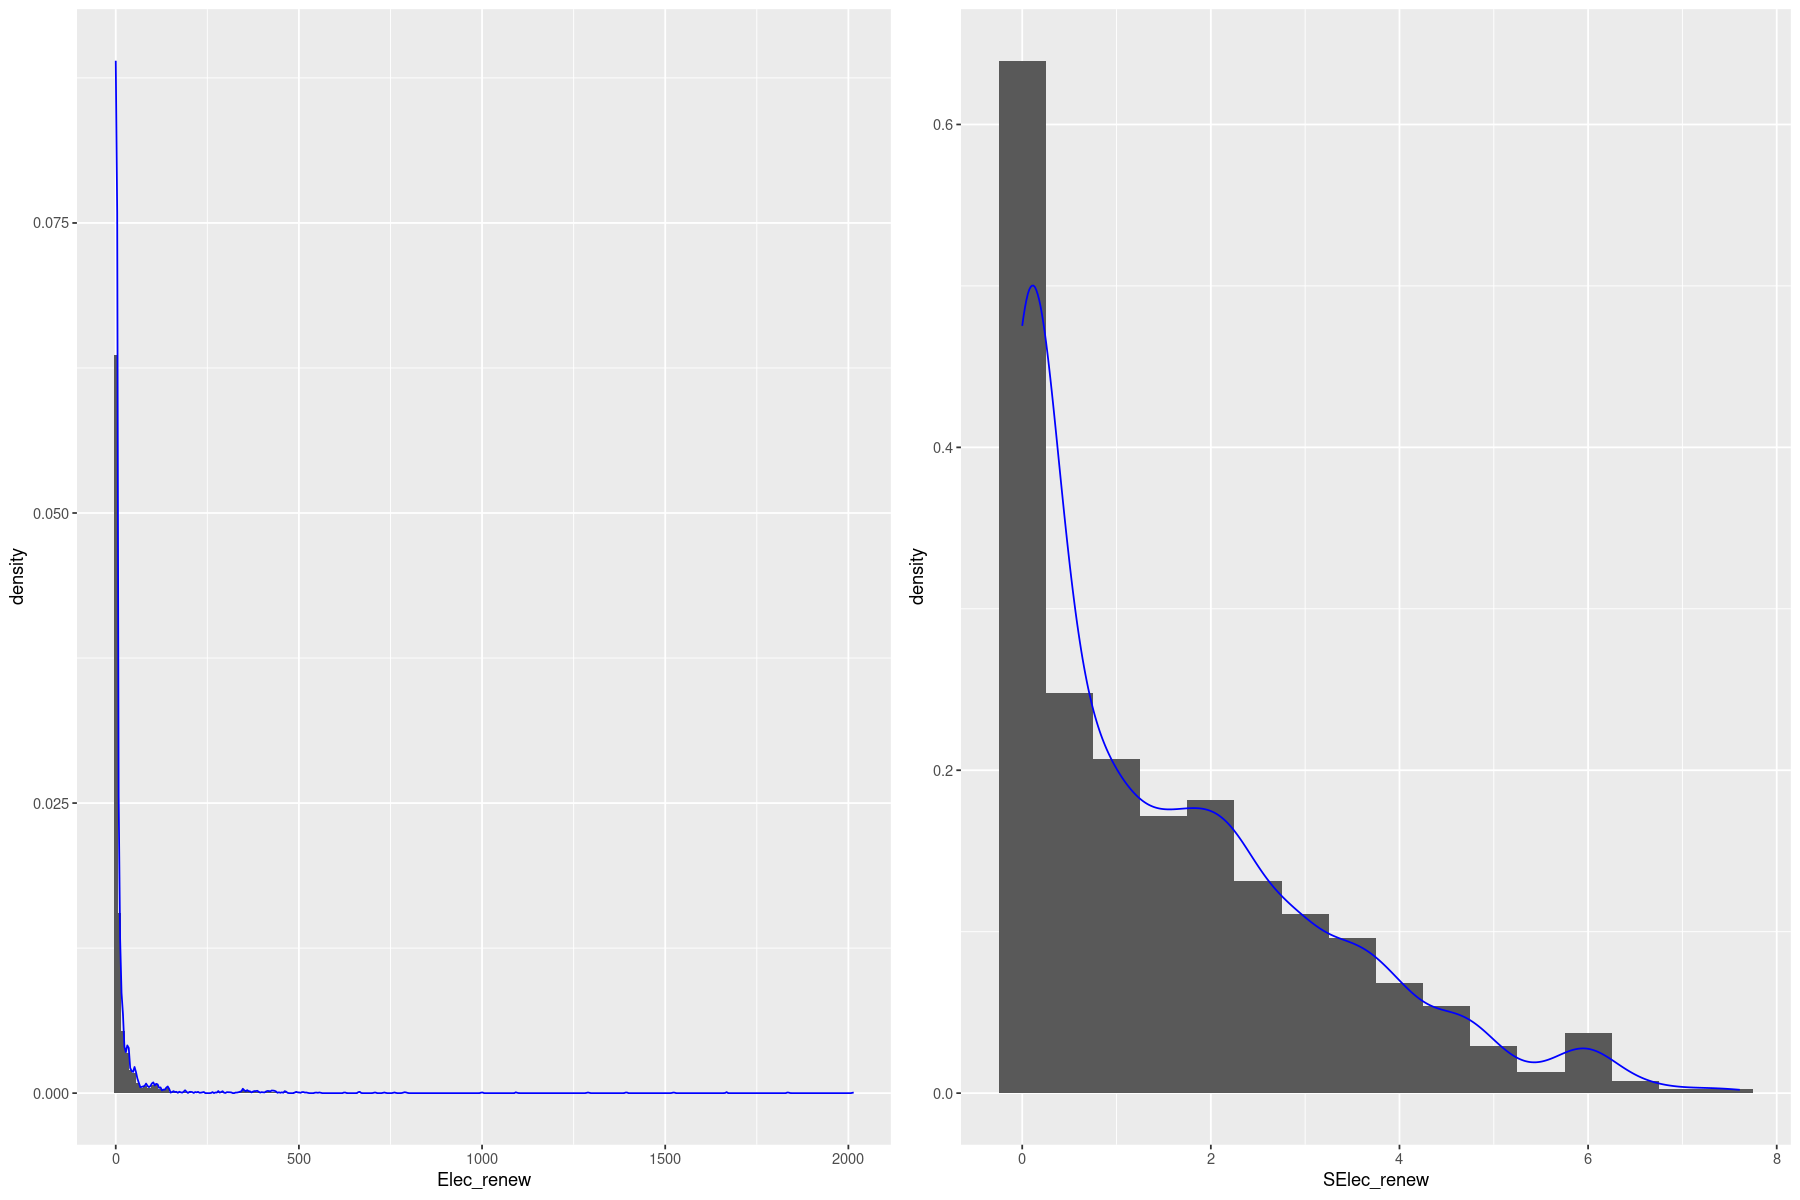

In [77]:
complete_energy[, "SElec_renew"] = log(1+complete_energy[, "Elec_renew"])

g1 = ggplot(complete_energy,aes(x=Elec_renew))+ geom_histogram(aes(y=..density..),binwidth = 10)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SElec_renew))+ geom_histogram(aes(y=..density..),binwidth = 0.5)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

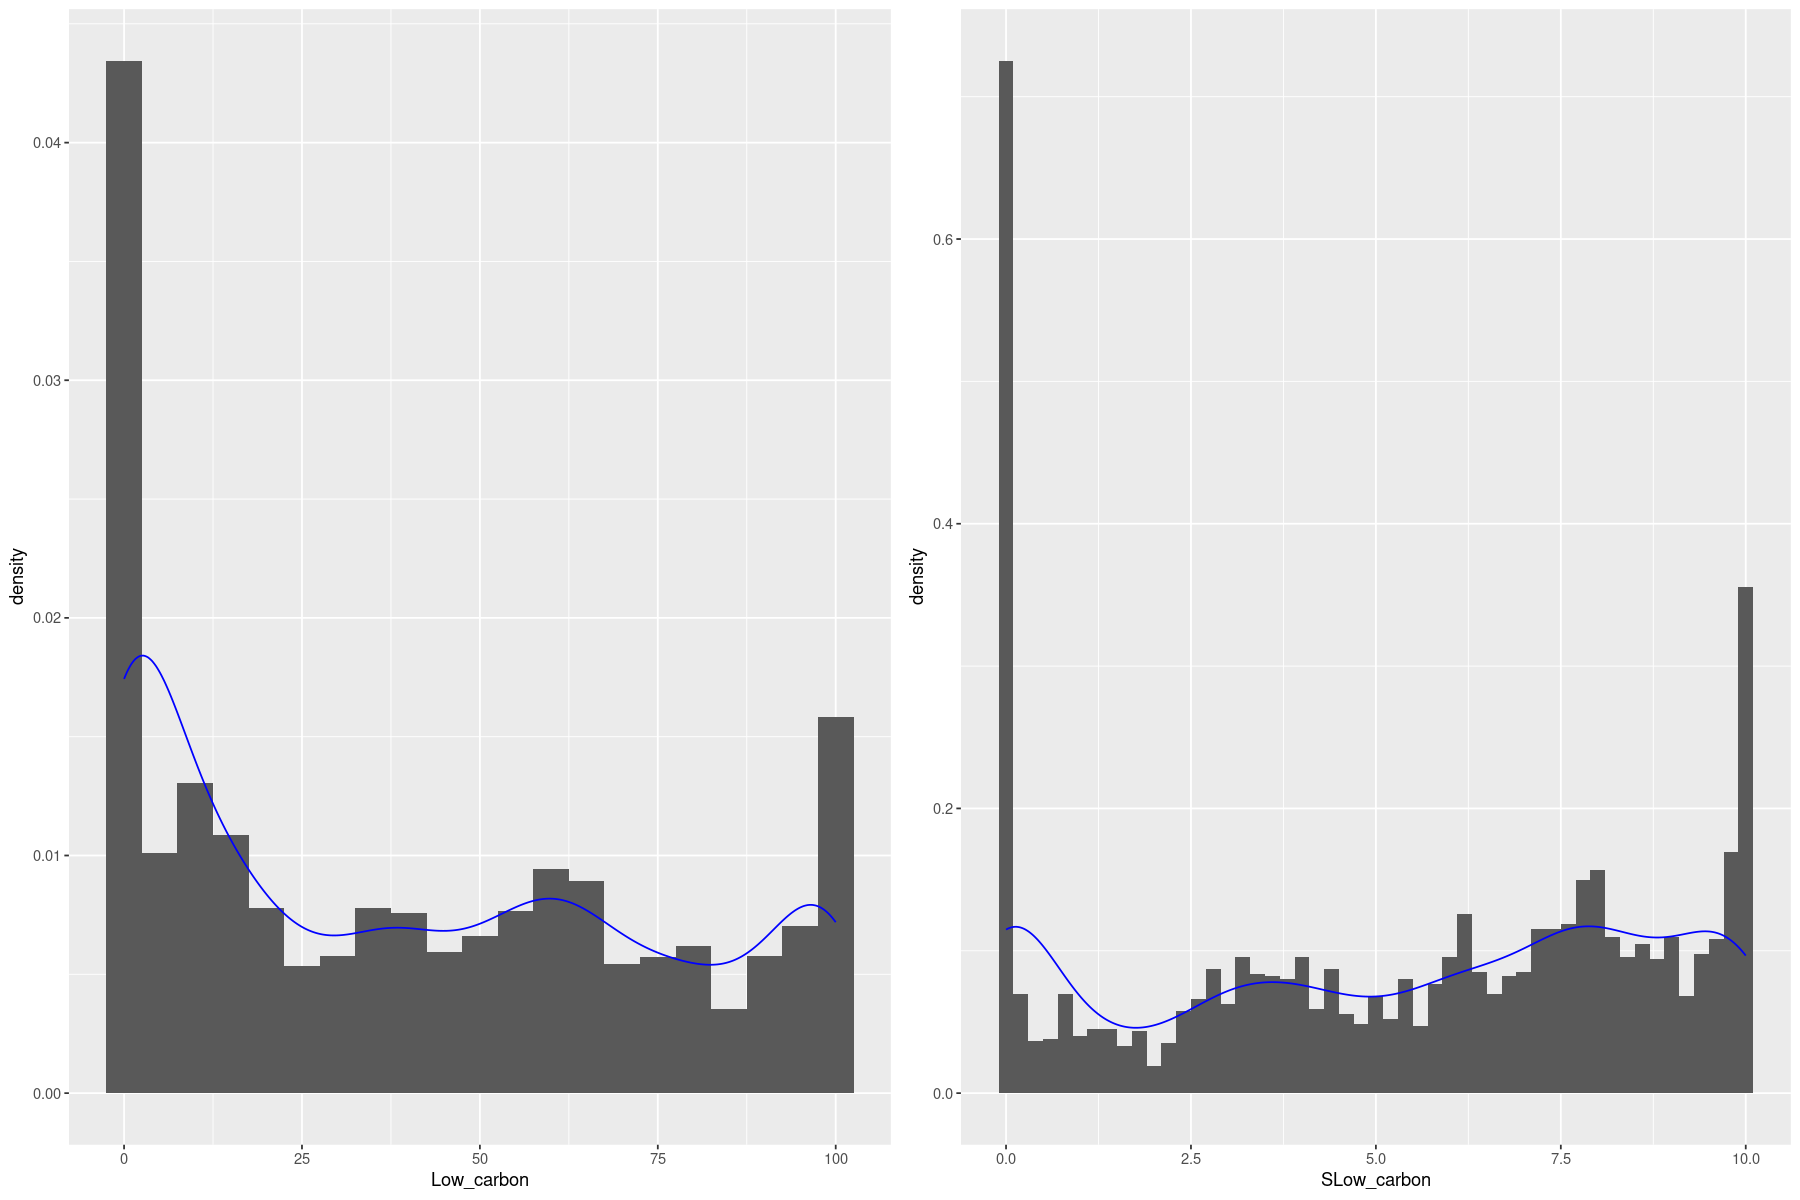

In [78]:
complete_energy[, "SLow_carbon"] = sqrt(complete_energy[, "Low_carbon"])

g1 = ggplot(complete_energy,aes(x=Low_carbon))+ geom_histogram(aes(y=..density..),binwidth = 5)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SLow_carbon))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

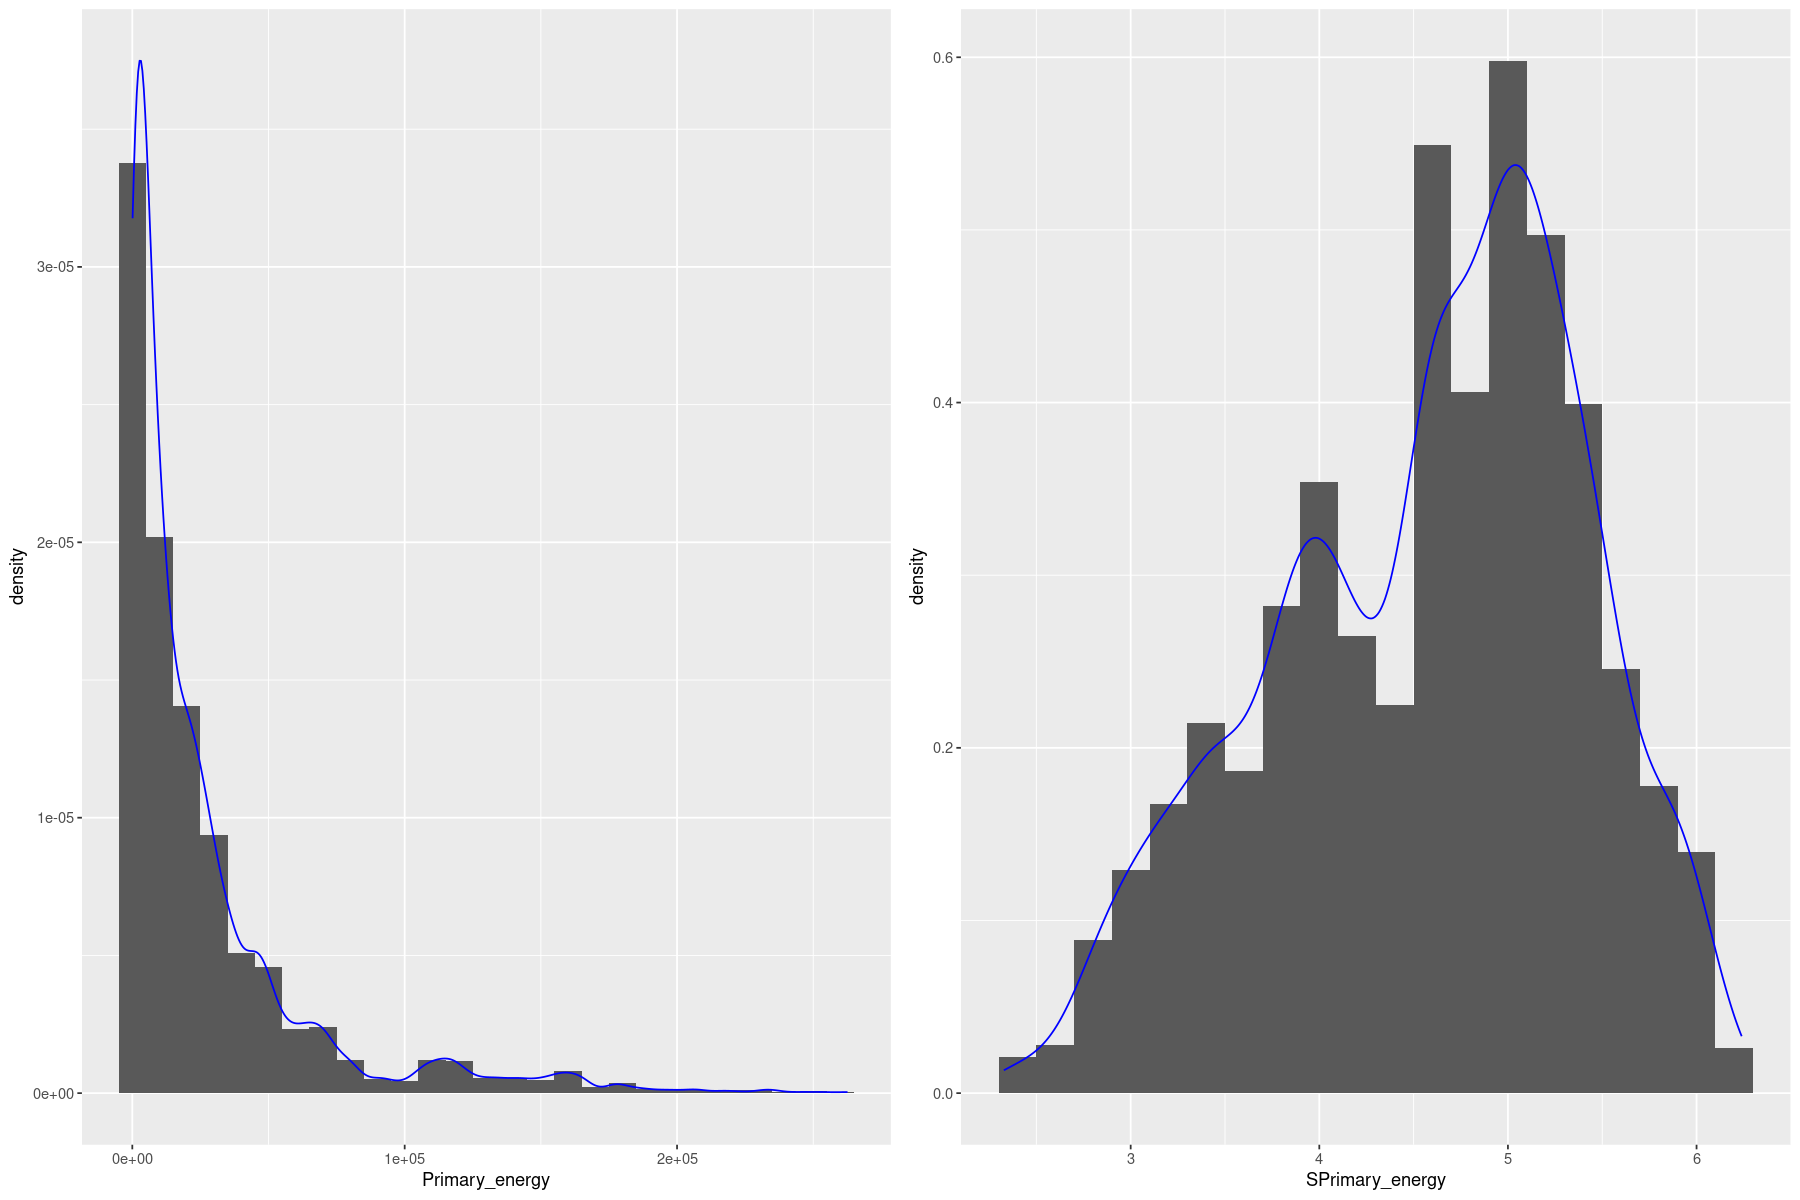

In [79]:
complete_energy[, "SPrimary_energy"] = log(sqrt(complete_energy[, "Primary_energy"]))

g1 = ggplot(complete_energy,aes(x=Primary_energy))+ geom_histogram(aes(y=..density..),binwidth = 10000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SPrimary_energy))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)
#modif 

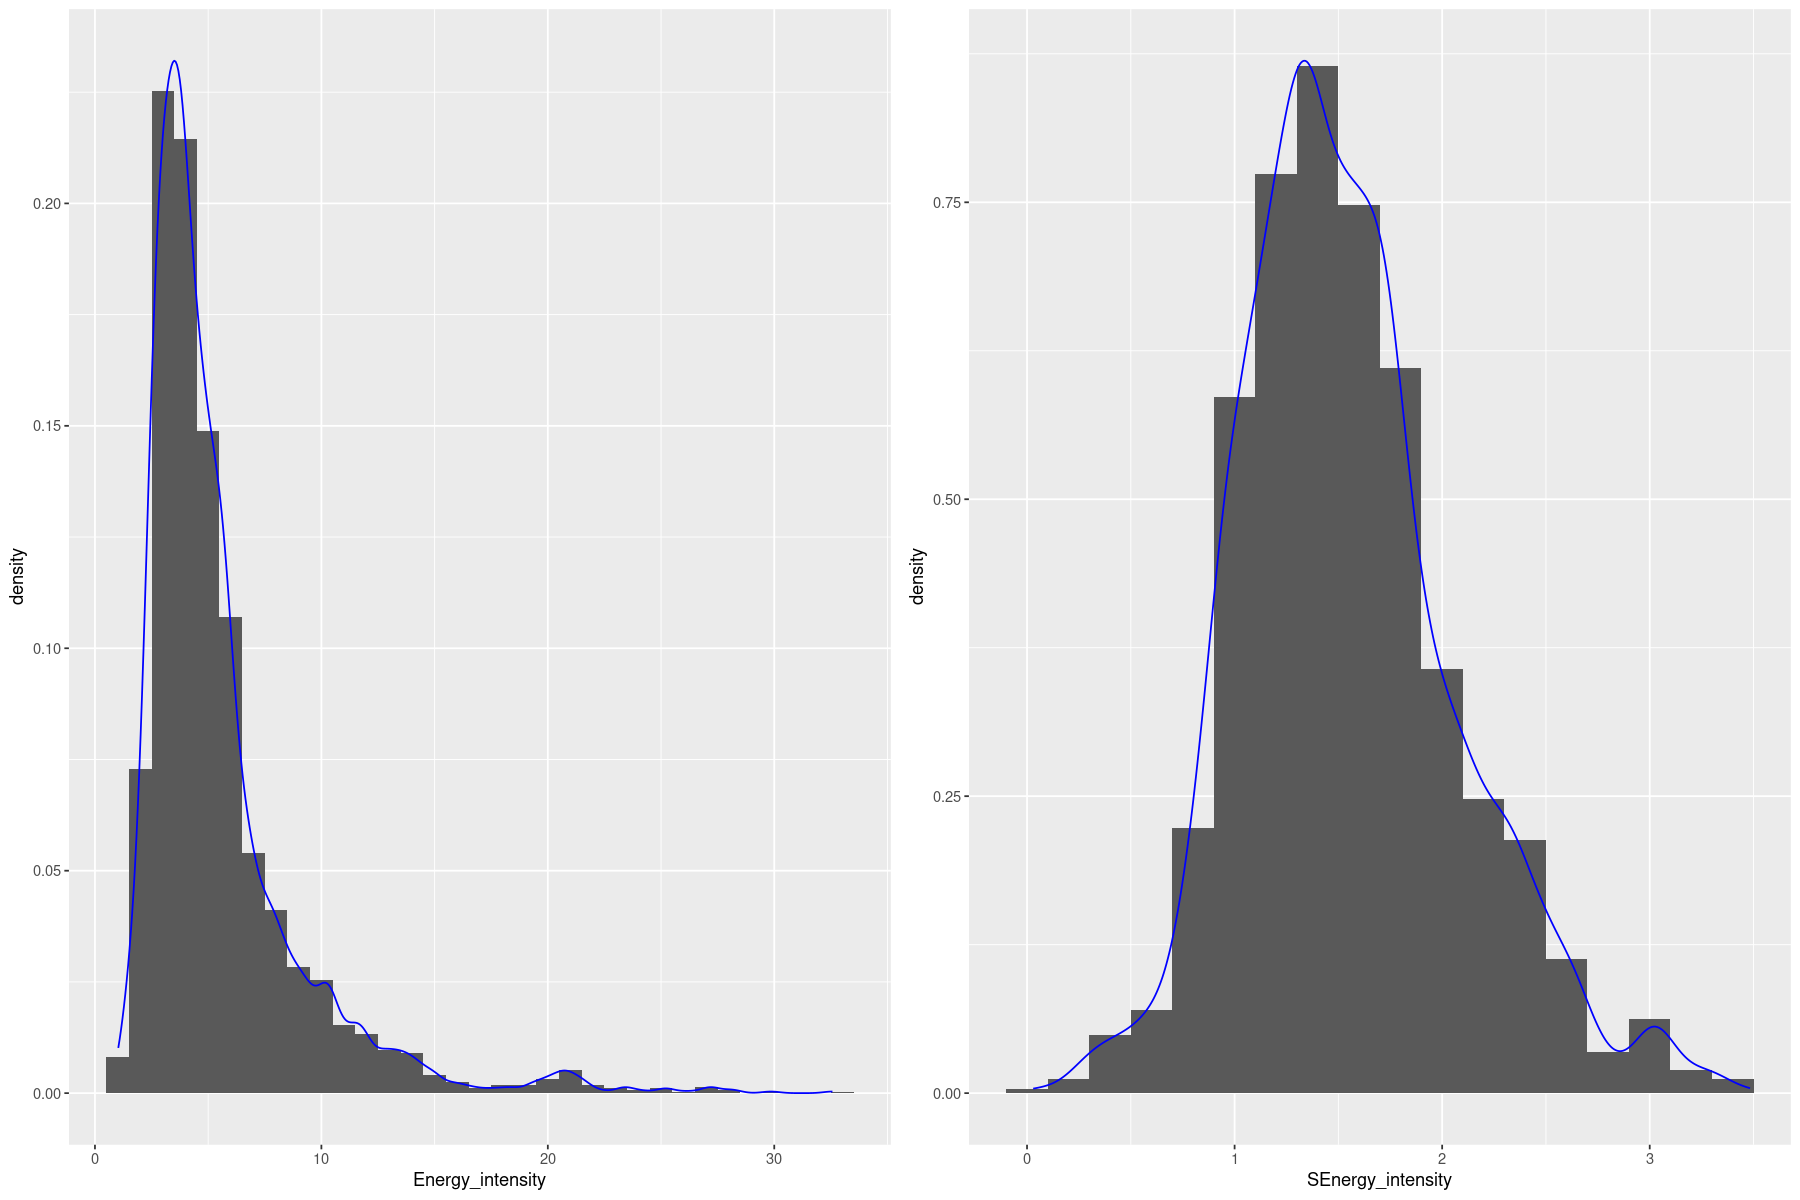

In [80]:
complete_energy[, "SEnergy_intensity"] = log(complete_energy[, "Energy_intensity"])

g1 = ggplot(complete_energy,aes(x=Energy_intensity))+ geom_histogram(aes(y=..density..),binwidth = 1)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SEnergy_intensity))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

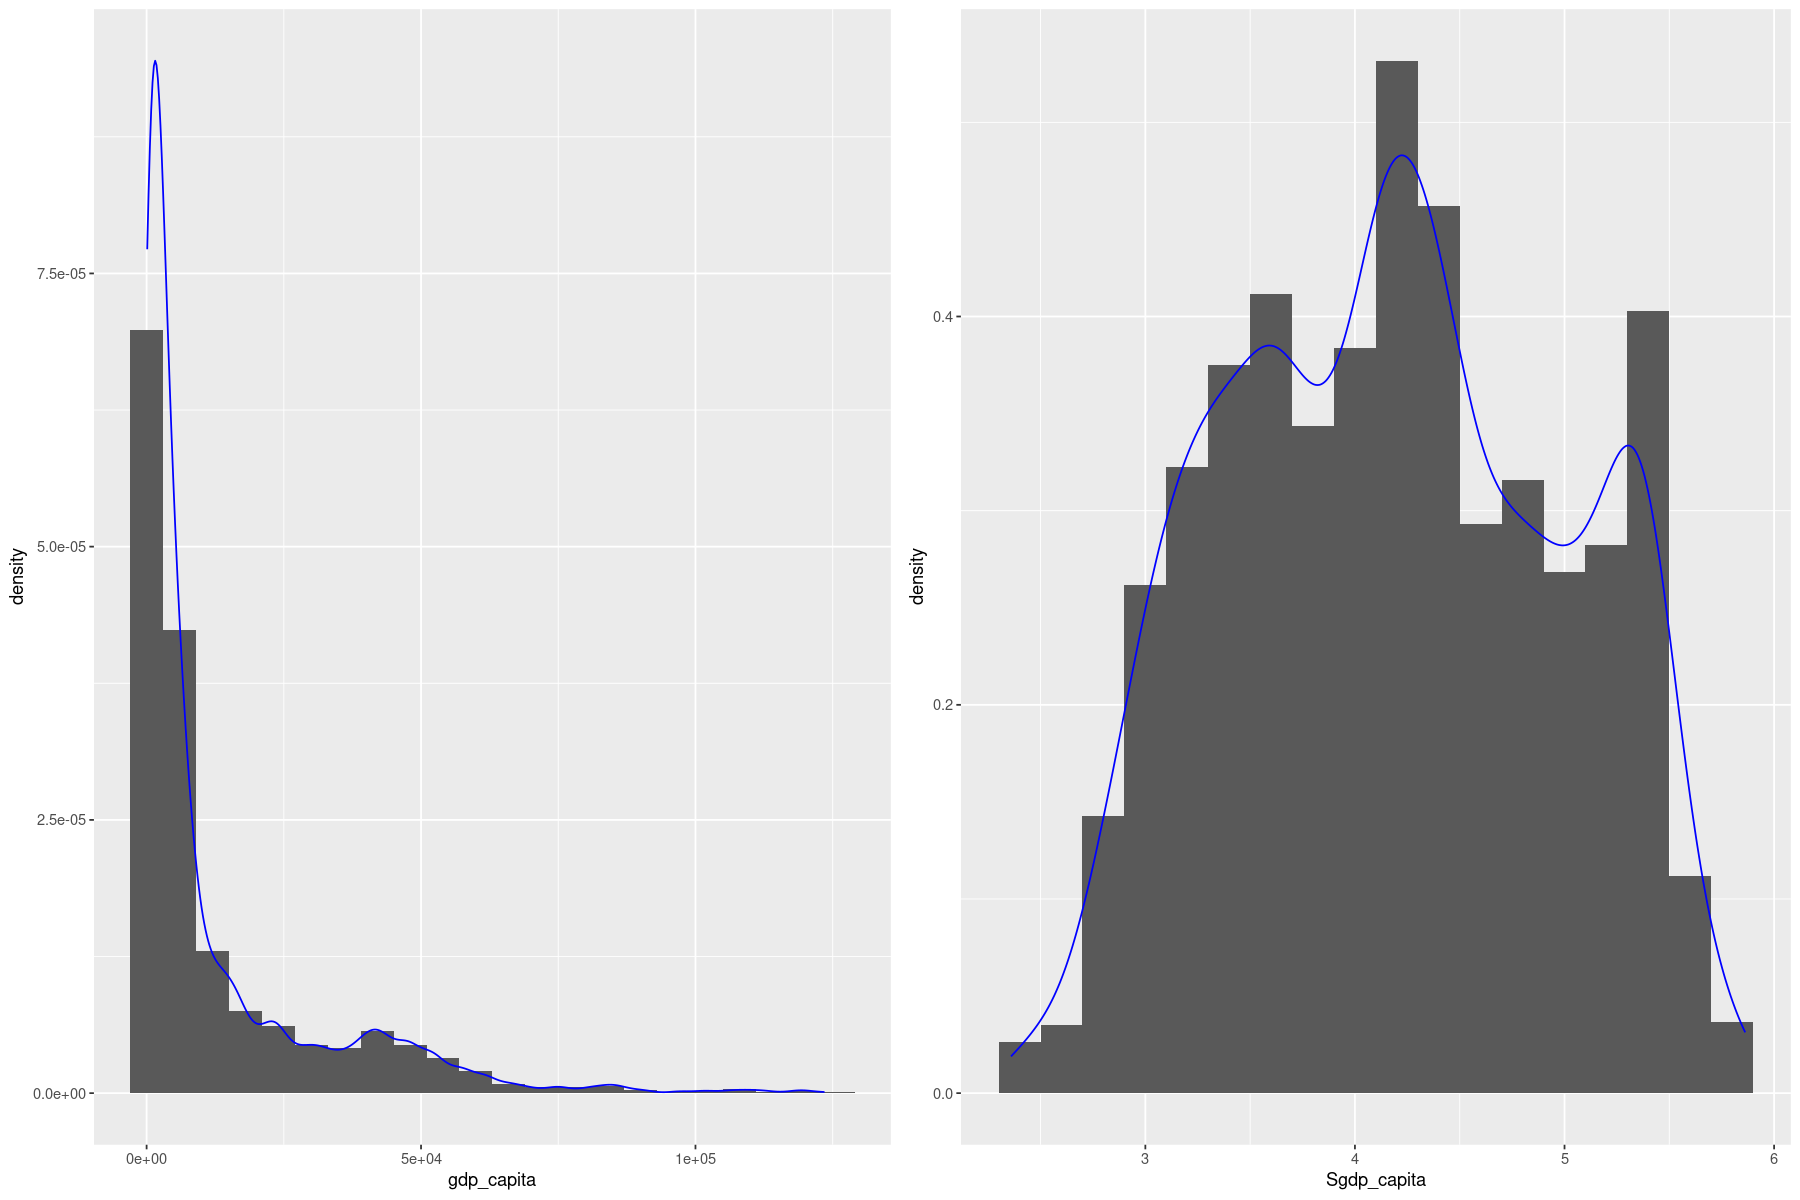

In [81]:
complete_energy[, "Sgdp_capita"] = log(sqrt(complete_energy[, "gdp_capita"]))

g1 = ggplot(complete_energy,aes(x=gdp_capita))+ geom_histogram(aes(y=..density..),binwidth = 6000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=Sgdp_capita))+ geom_histogram(aes(y=..density..),binwidth = 0.2)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

In [82]:
complete_energy[, "SDensity"] = log(complete_energy[, "Density"])

g1 = ggplot(complete_energy,aes(x=Density))+ geom_histogram(aes(y=..density..),binwidth = 25)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SDensity))+ geom_histogram(aes(y=..density..),binwidth = 0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

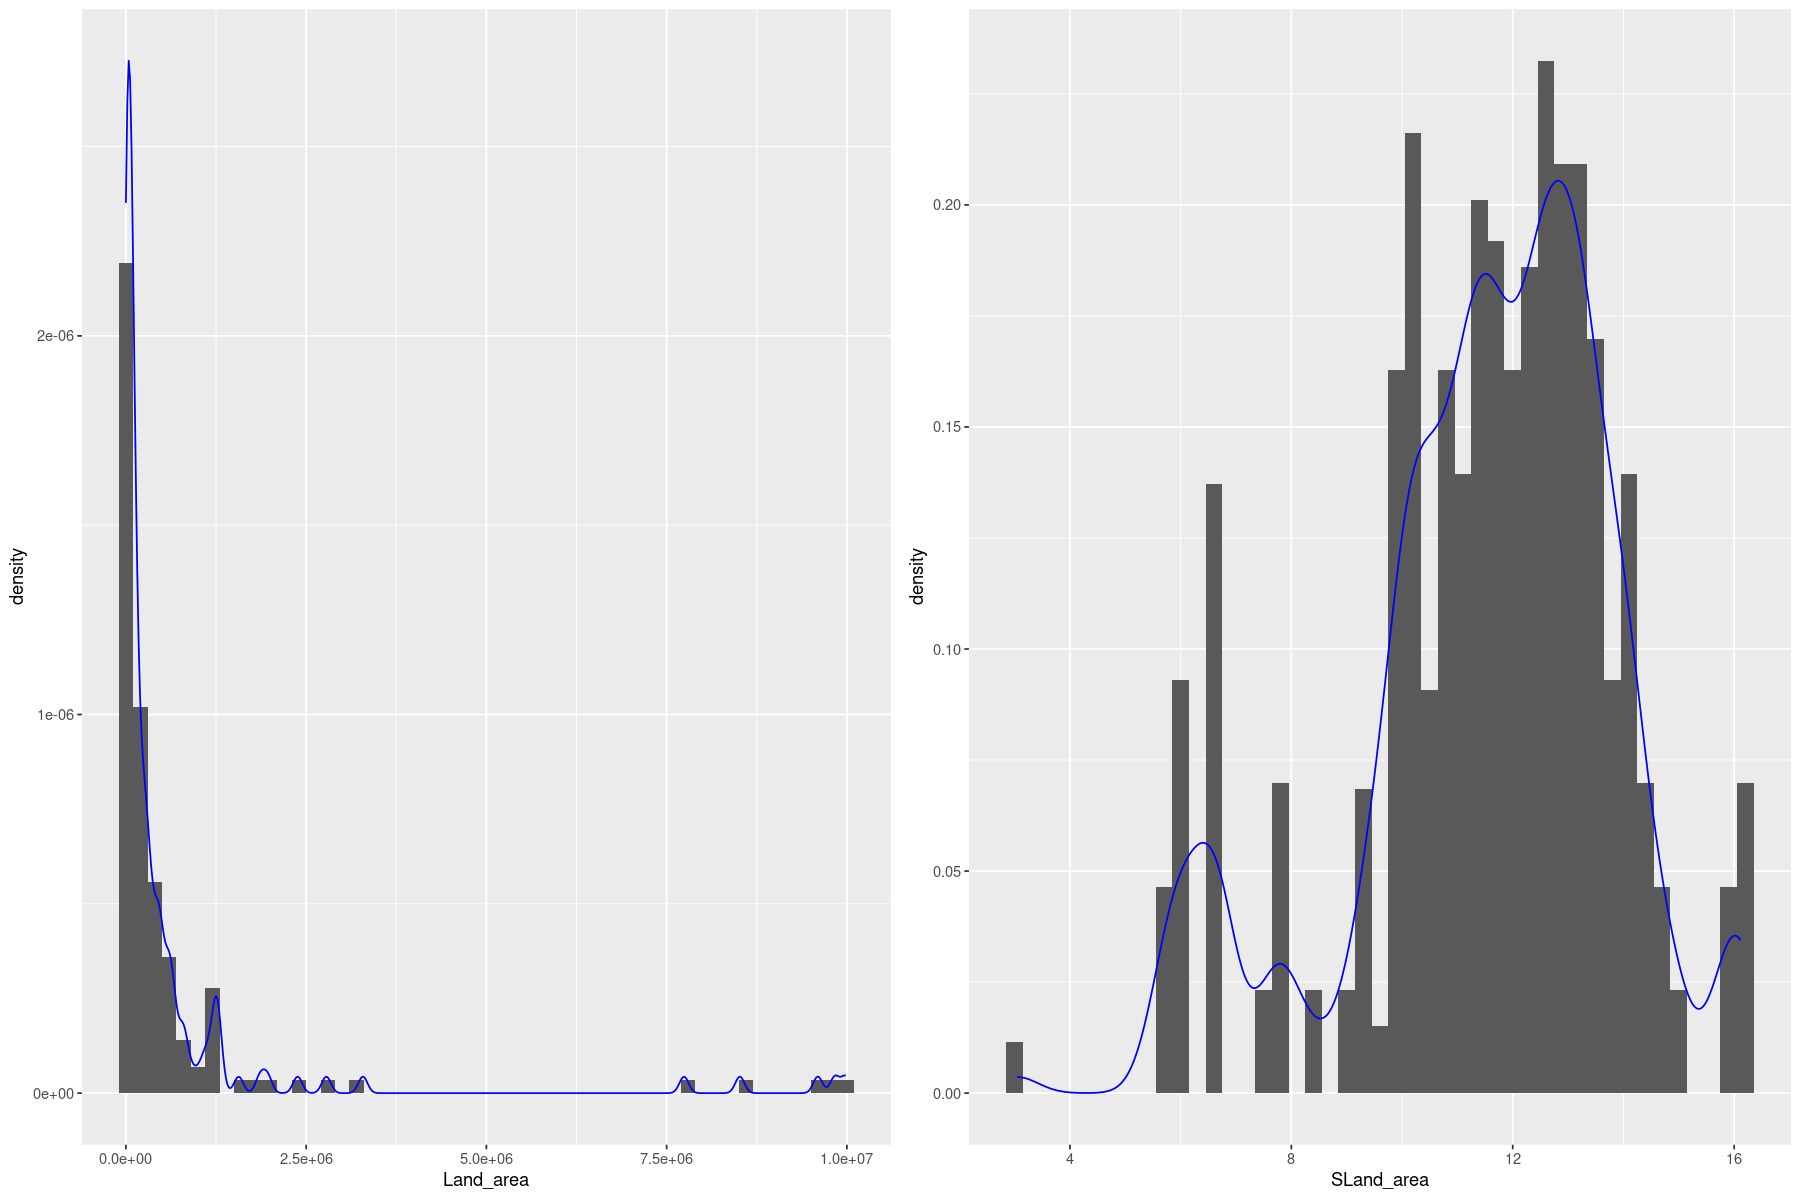

In [83]:
complete_energy[, "SLand_area"] = log(complete_energy[, "Land_area"])

g1 = ggplot(complete_energy,aes(x=Land_area))+ geom_histogram(aes(y=..density..),binwidth = 200000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SLand_area))+ geom_histogram(aes(y=..density..),binwidth = 0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

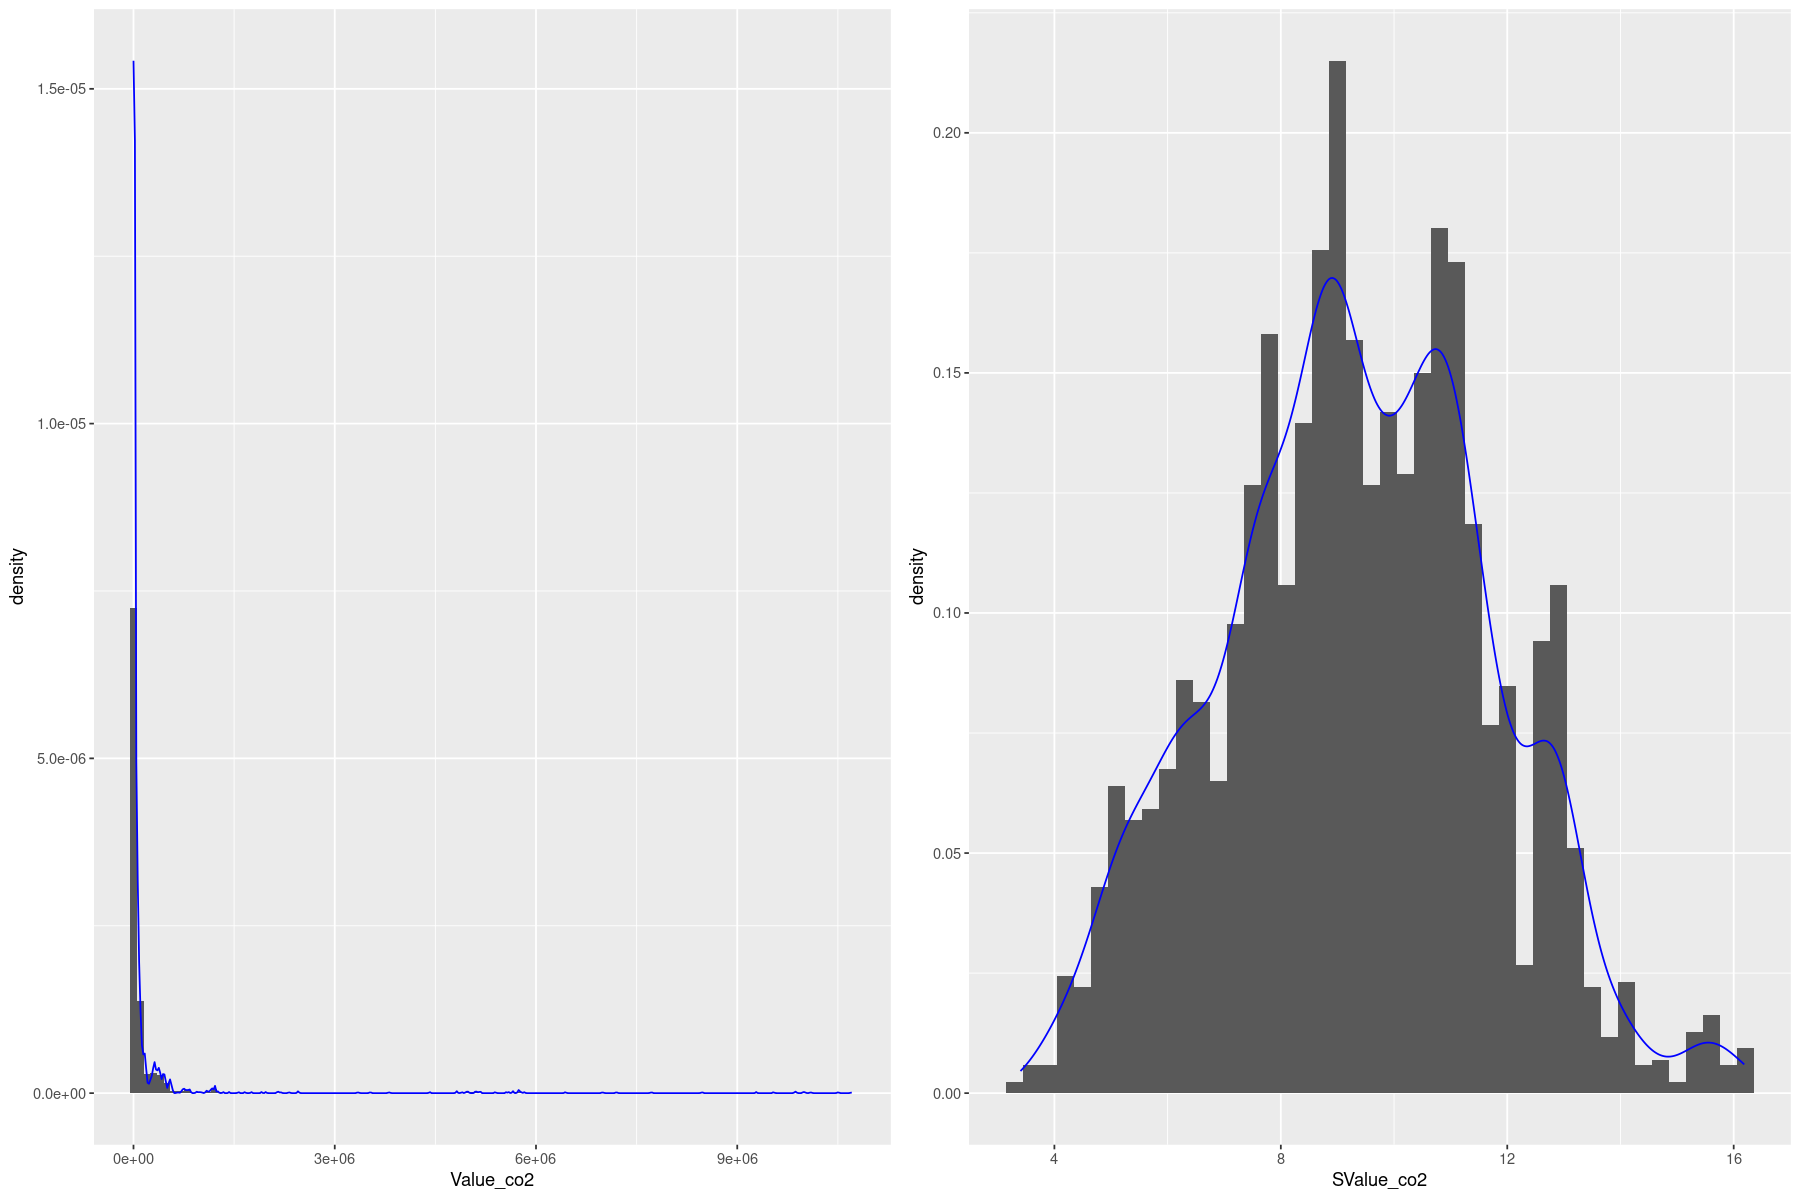

In [84]:
complete_energy[, "SValue_co2"] = log(complete_energy[, "Value_co2"])

g1 = ggplot(complete_energy,aes(x=Value_co2))+ geom_histogram(aes(y=..density..),binwidth = 100000)+geom_density(alpha=.1,col="blue") 
g2 = ggplot(complete_energy,aes(x=SValue_co2))+ geom_histogram(aes(y=..density..),binwidth = 0.3)+geom_density(alpha=.1, col="blue") 

grid.arrange(g1,g2,ncol=2)

In [88]:
complete_energy = complete_energy[-c(3,4,5,6,7,8,9,10,11,14,15,16)]

In [89]:
summary(complete_energy)

                 Entity          Year        Value_co2          gdp_growth     
 Algeria            :  20   2014   : 147   Min.   :      30   Min.   :-36.658  
 Angola             :  20   2015   : 147   1st Qu.:    2188   1st Qu.:  1.771  
 Antigua and Barbuda:  20   2016   : 146   Median :   10425   Median :  3.788  
 Argentina          :  20   2017   : 146   Mean   :  168818   Mean   :  3.895  
 Armenia            :  20   2018   : 146   3rd Qu.:   58145   3rd Qu.:  5.957  
 Australia          :  20   2019   : 146   Max.   :10707220   Max.   : 63.380  
 (Other)            :2748   (Other):1990                                       
    Latitude         Longitude        SAccess_elec   SAccess_fuels  
 Min.   :-40.901   Min.   :-175.20   Min.   :0.225   Min.   :0.000  
 1st Qu.:  1.651   1st Qu.: -10.94   1st Qu.:3.975   1st Qu.:3.139  
 Median : 17.061   Median :  18.64   Median :4.575   Median :4.413  
 Mean   : 18.140   Mean   :  12.97   Mean   :4.160   Mean   :3.633  
 3rd Qu.: 39.40

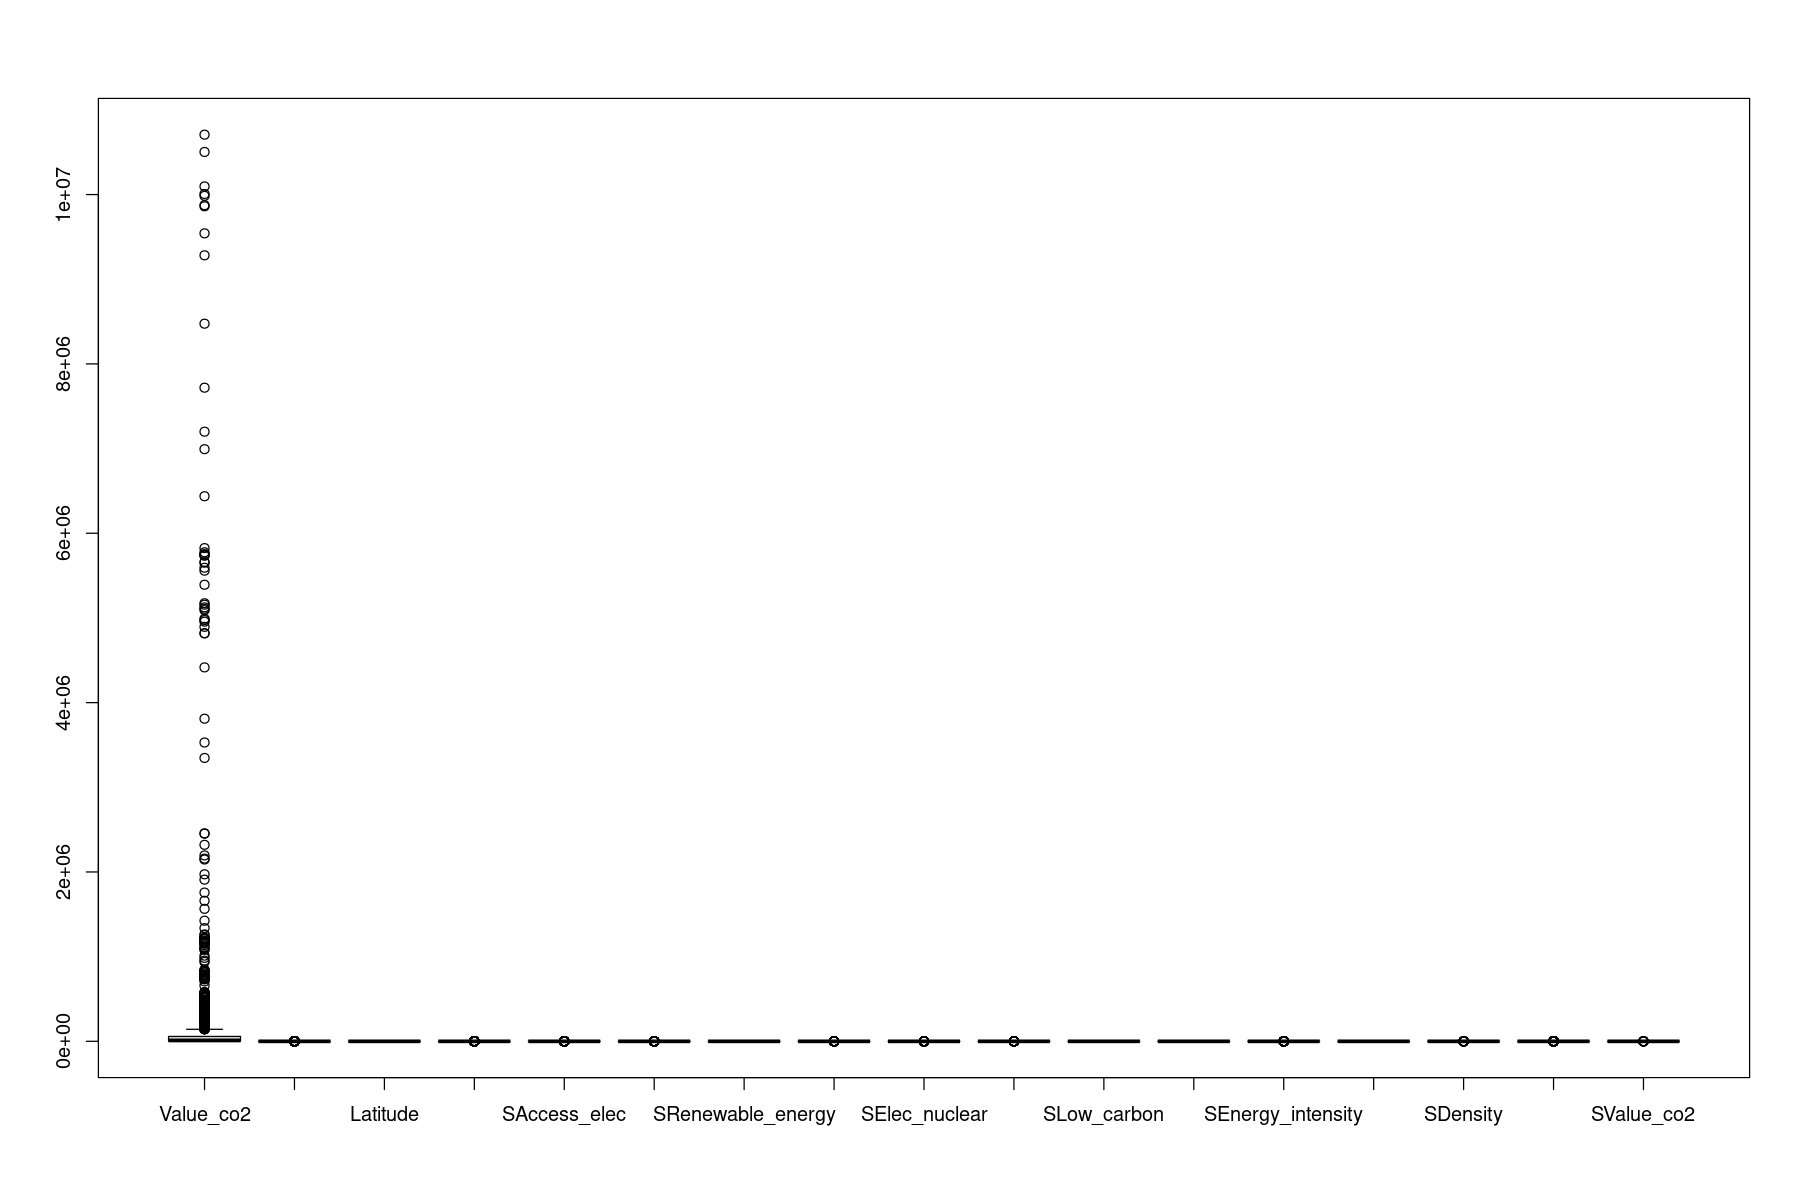

In [90]:
boxplot(complete_energy[,-c(1,2)])

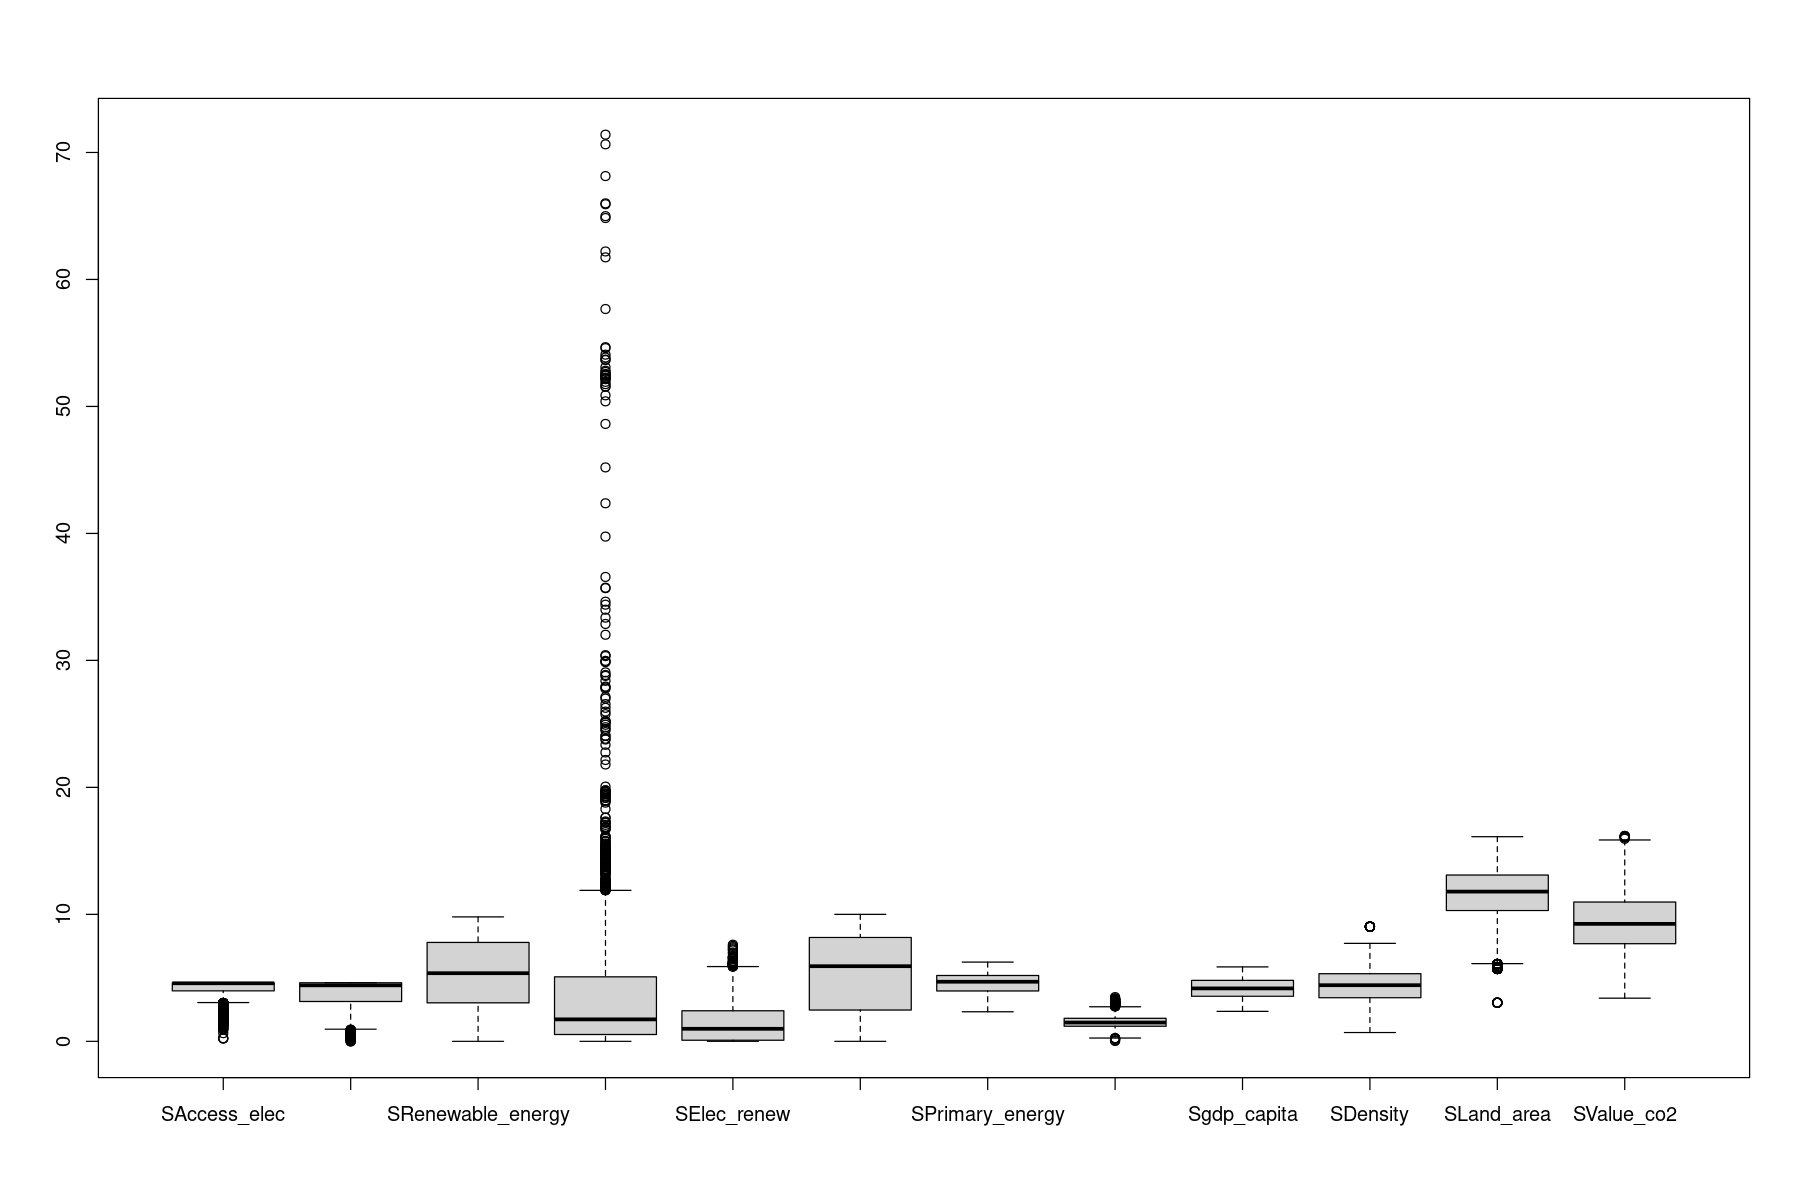

In [91]:
boxplot(complete_energy[,-c(1:6,11)])

In [92]:
boxplot(complete_energy[,c(5:6)])

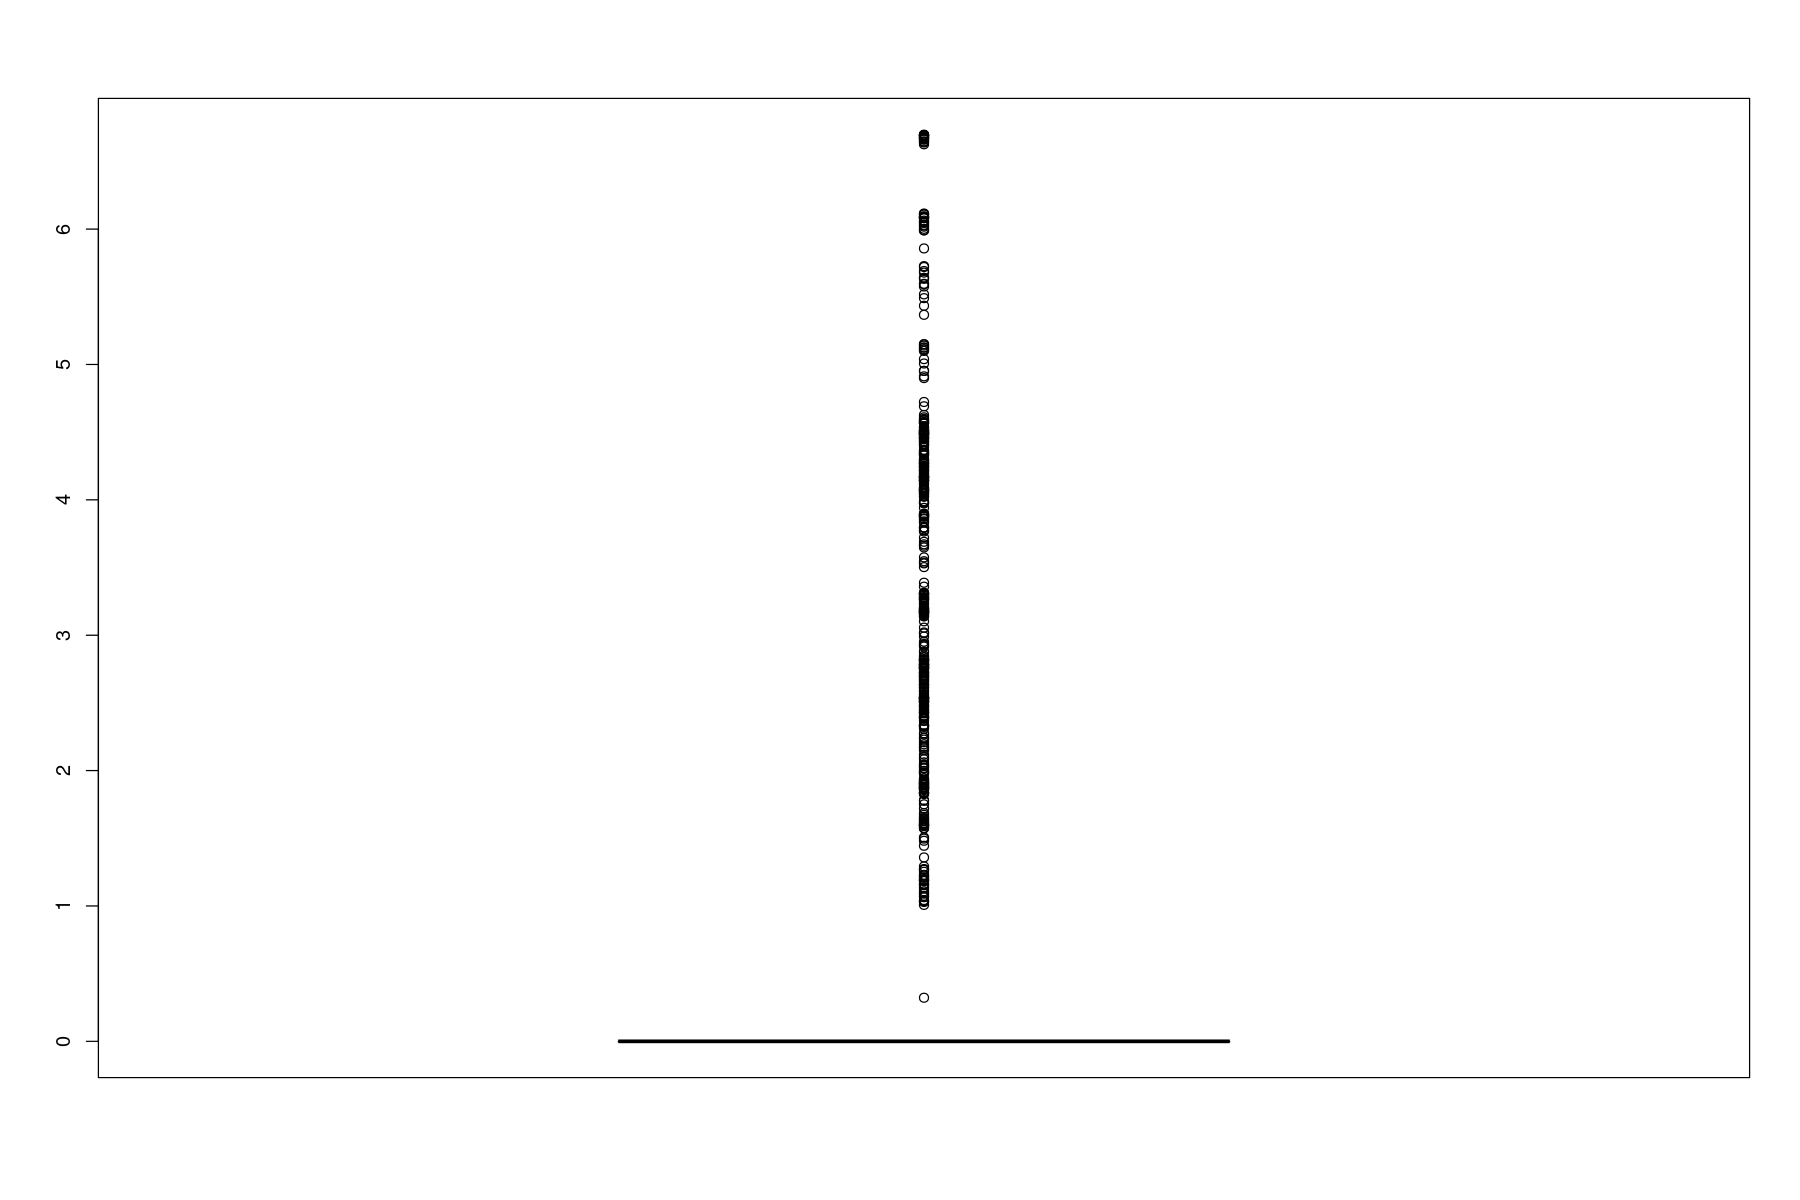

In [93]:
boxplot(complete_energy[,c(11)]) #nuclear

In [94]:
boxplot(complete_energy[,c(4)]) #gdp growth

## Question 5 : Les 5 pays les plus émetteurs de CO2  

In [95]:
#Hétérogénéité d'émission de CO2 de pays

ggplot(complete_energy) + 
  aes(x = Year, y = Value_co2, color = Entity, group = Entity) + 
  geom_line(show.legend = FALSE) 
#complete energy avec les valeurs transformées mais on garde value_Co2
#parfoisun groupe contient une seule observation et je pense que cela ne s'affiche donc pa

In [96]:
paste('ecart type')
sd(complete_energy$Value_co2)
paste('moyenne :')
mean(complete_energy$Value_co2)
paste('min')
min(complete_energy$Value_co2)
paste('max')
max(complete_energy$Value_co2)

[1] "ecart type"

[1] 818020.2

[1] "moyenne :"

[1] 168818.2

[1] "min"

[1] 30

[1] "max"

[1] 10707220

In [97]:
#Les pays les plus émetteurs de CO2
Moy = aggregate(data=complete_energy,Value_co2~Entity,FUN=mean)
index = order(Moy$Value_co2, decreasing = TRUE )
Moy_classe = Moy[index,]
head(Moy_classe,10)
barplot(Moy[,2])

Entity         Value_co2
28  China          7636642.5
143 United States  5329538.5
63  India          1633979.0
69  Japan          1183734.5
51  Germany         773644.5
25  Canada          547644.5
142 United Kingdom  470604.0
86  Mexico          444619.5
67  Italy           399400.5
124 South Africa    398041.5

## Question 6: Analyse descriptive multidimensionnelle

### Variables quantitatives

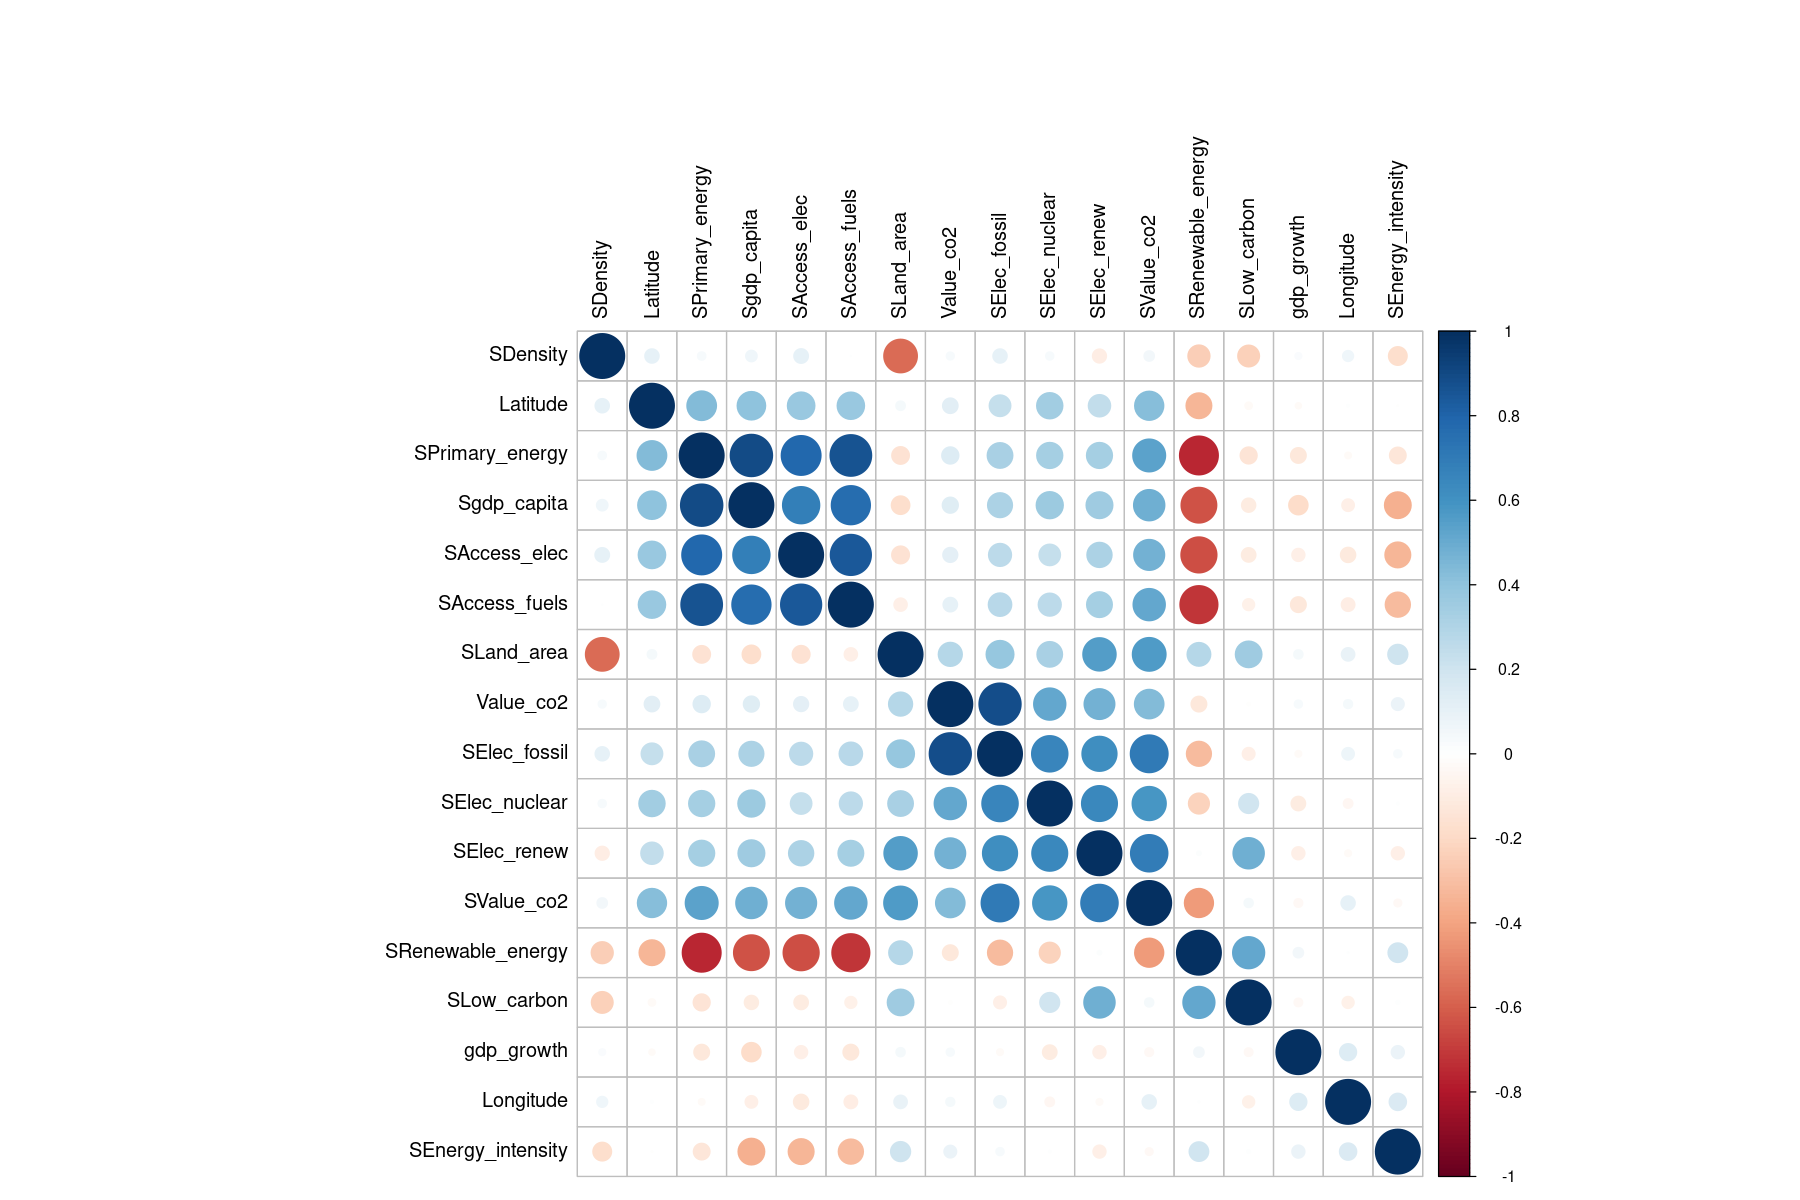

In [98]:
numeric_energy =complete_energy[sapply(complete_energy, is.numeric)]
mcor <- cor(numeric_energy)
par(mfrow=c(1,1), mar=c(5,5,2,2))
corrplot(mcor, order="hclust", tl.col="black")

### Variable qualitative

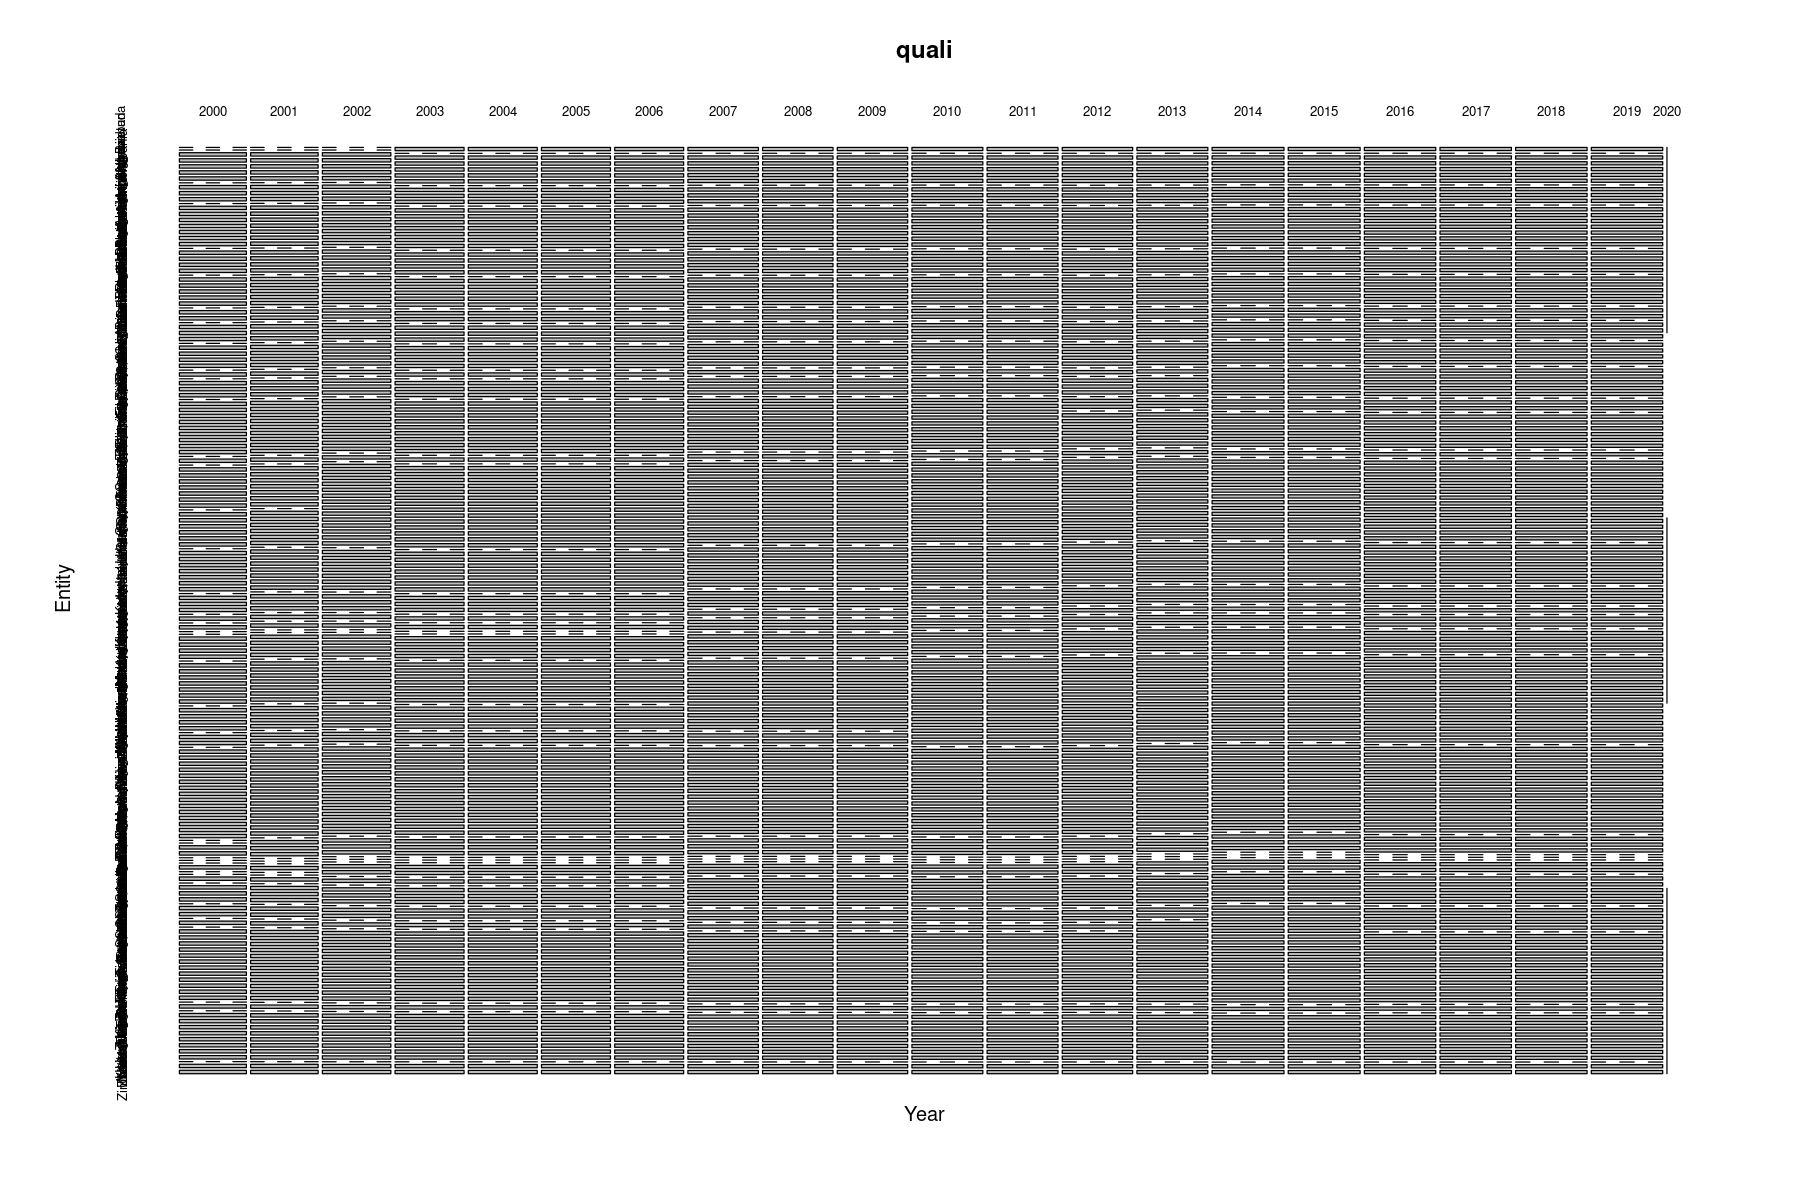

In [99]:
quali= xtabs(~Year + Entity, data = complete_energy)
mosaicplot(quali)

### Question 8 :  Dépendance entre Year et la variable à prédire

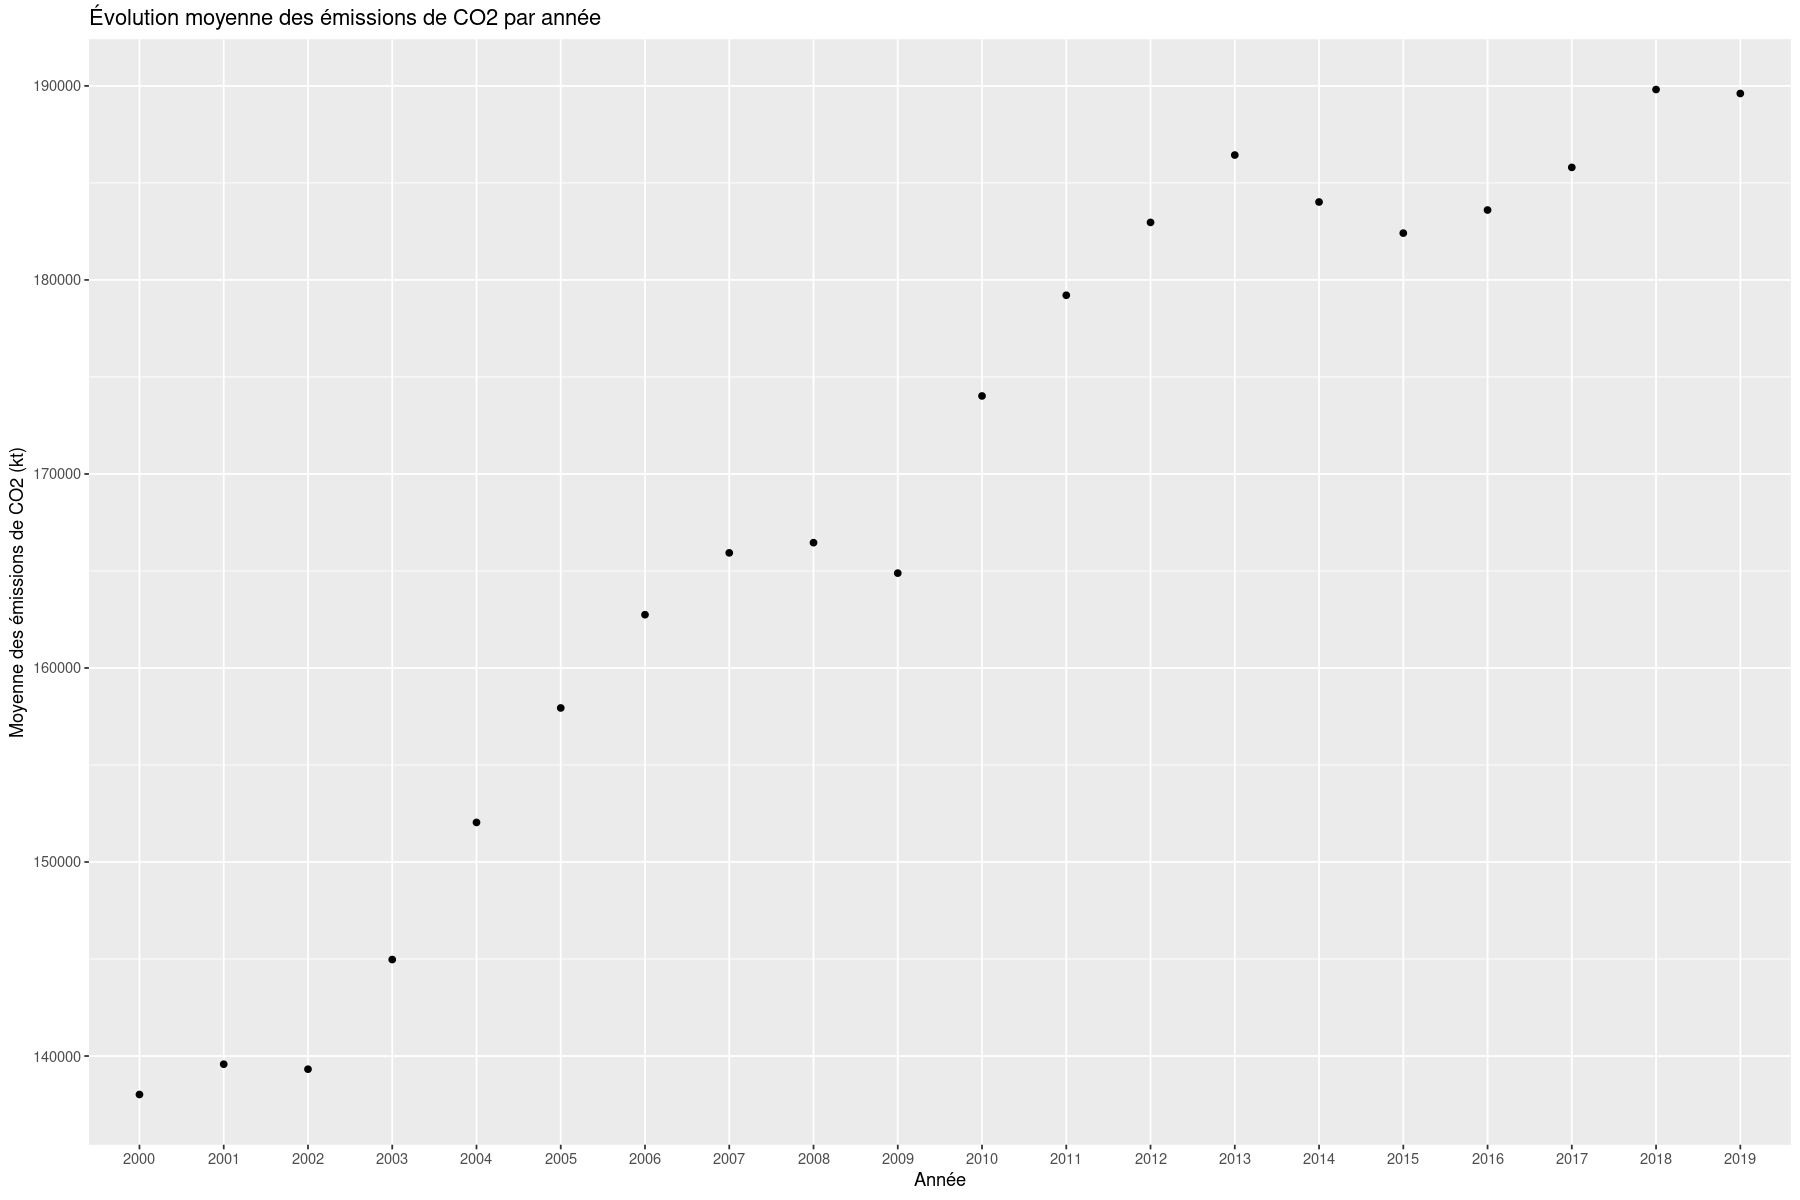

In [100]:
Moy = aggregate( Value_co2 ~ Year, data = complete_energy, FUN = mean)

ggplot(Moy) + 
  aes(x = Year, y = Value_co2) + 
  geom_point() +
  labs(x = "Année", y = "Moyenne des émissions de CO2 (kt)", title = "Évolution moyenne des émissions de CO2 par année")

In [101]:
Std = aggregate( Value_co2 ~ Year, data = complete_energy, FUN = sd )

Median = aggregate( Value_co2 ~ Year, data = complete_energy, FUN = median )

Stat = Moy
Stat$std = Std$Value_co2
Stat$median = Median$Value_co2

names(Stat)[which(names(Stat) == "Value_co2")] = "mean"

Stat

Year mean     std      median
1  2000 138016.4 586021.7  9000 
2  2001 139578.2 589751.5  9045 
3  2002 139321.1 588124.4  8985 
4  2003 144971.8 619668.0  9310 
5  2004 152039.4 661777.7  9560 
6  2005 157939.6 702156.5 10510 
7  2006 162745.4 733594.1  9970 
8  2007 165933.1 766181.3 10075 
9  2008 166458.1 770546.4  9700 
10 2009 164888.0 786177.6  9860 
11 2010 174019.5 846840.8  9950 
12 2011 179210.0 895407.9 10900 
13 2012 182964.4 911125.1 11945 
14 2013 186437.5 945723.5 11330 
15 2014 184016.3 943343.7 10860 
16 2015 182412.4 928555.0 11070 
17 2016 183602.7 929534.0 11135 
18 2017 185800.3 944709.9 12585 
19 2018 189814.1 981043.4 14325 
20 2019 189609.5 990345.4 13395

## Question 7 : Analyse en Composantes Principales

In [102]:
str(complete_energy)

'data.frame':	2868 obs. of  19 variables:
 $ Entity           : Factor w/ 176 levels "Afghanistan",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Year             : Factor w/ 21 levels "2000","2001",..: 4 5 6 7 8 9 10 11 12 13 ...
 $ Value_co2        : num  1220 1030 1550 1760 1770 ...
 $ gdp_growth       : num  8.83 1.41 11.23 5.36 13.83 ...
 $ Latitude         : num  33.9 33.9 33.9 33.9 33.9 ...
 $ Longitude        : num  67.7 67.7 67.7 67.7 67.7 ...
 $ SAccess_elec     : num  2.69 3 3.23 3.42 3.58 ...
 $ SAccess_fuels    : num  2.35 2.48 2.58 2.7 2.79 ...
 $ SRenewable_energy: num  6.05 6.65 5.82 5.65 5.36 ...
 $ SElec_fossil     : num  0.557 0.574 0.583 0.447 0.447 ...
 $ SElec_nuclear    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SElec_renew      : num  0.489 0.445 0.464 0.495 0.56 ...
 $ SLow_carbon      : num  8.19 7.93 7.96 8.73 8.89 ...
 $ SPrimary_energy  : num  2.72 2.66 2.76 2.86 2.94 ...
 $ SEnergy_intensity: num  0.336 0.182 0.344 0.405 0.425 ...
 $ Sgdp_capita      : num  2.63 2.68 2.74 2.79 2.9

In [103]:
energy_pca = scale(complete_energy[,-c(1,2,3)], center = TRUE, scale = TRUE)
head(energy_pca)

gdp_growth   Latitude  Longitude SAccess_elec SAccess_fuels SRenewable_energy
4  1.062712614 0.6338505 0.8359896 -1.9758403   -0.9495474     0.27838517      
5 -0.534097141 0.6338505 0.8359896 -1.5610729   -0.8568021     0.48769117      
6  1.578777364 0.6338505 0.8359896 -1.2445776   -0.7799768     0.19625172      
7  0.314722045 0.6338505 0.8359896 -0.9884929   -0.6927000     0.13536853      
8  2.137714332 0.6338505 0.8359896 -0.7733013   -0.6236650     0.03627968      
9  0.006383943 0.6338505 0.8359896 -0.5552194   -0.5626073    -0.23163510      
  SElec_fossil SElec_nuclear SElec_renew SLow_carbon SPrimary_energy
4 -0.4890647   -0.4113497    -0.6367967  0.8483680   -2.258782      
5 -0.4867492   -0.4113497    -0.6642972  0.7739608   -2.330927      
6 -0.4856178   -0.4113497    -0.6523632  0.7835205   -2.203004      
7 -0.5034139   -0.4113497    -0.6329647  1.0069395   -2.088298      
8 -0.5034139   -0.4113497    -0.5922914  1.0527261   -1.996101      
9 -0.5048969   -0.4113497    -0.6723815  0.9695002   -1.667974      
  SEnergy_intensity Sgdp_capita SDensity   SLand_area SValue_co2
4 -2.326985         -1.963254   -0.1815456 0.7884167  -0.9320640
5 -2.624948         -1.898120   -0.1815456 0.7884167  -1.0030475
6 -2.313227         -1.812539   -0.1815456 0.7884167  -0.8316828
7 -2.193626         -1.758263   -0.1815456 0.7884167  -0.7784075
8 -2.155349         -1.562128   -0.1815456 0.7884167  -0.7760319
9 -1.696431         -1.553454   -0.1815456 0.7884167  -0.4830358

In [104]:
resultat_pca = PCA(energy_pca,ncp=16)
get_eig(resultat_pca)

eigenvalue  variance.percent cumulative.variance.percent
Dim.1  5.484759138 34.27974461       34.27974                  
Dim.2  2.991178926 18.69486828       52.97461                  
Dim.3  1.522017152  9.51260720       62.48722                  
Dim.4  1.173257491  7.33285932       69.82008                  
Dim.5  0.984740573  6.15462858       75.97471                  
Dim.6  0.865739312  5.41087070       81.38558                  
Dim.7  0.844580761  5.27862976       86.66421                  
Dim.8  0.633640931  3.96025582       90.62446                  
Dim.9  0.480224132  3.00140083       93.62587                  
Dim.10 0.296853269  1.85533293       95.48120                  
Dim.11 0.269506708  1.68441692       97.16561                  
Dim.12 0.184078742  1.15049213       98.31611                  
Dim.13 0.122602638  0.76626649       99.08237                  
Dim.14 0.101238596  0.63274122       99.71511                  
Dim.15 0.038753005  0.24220628       99.95732                  
Dim.16 0.006828628  0.04267892      100.00000

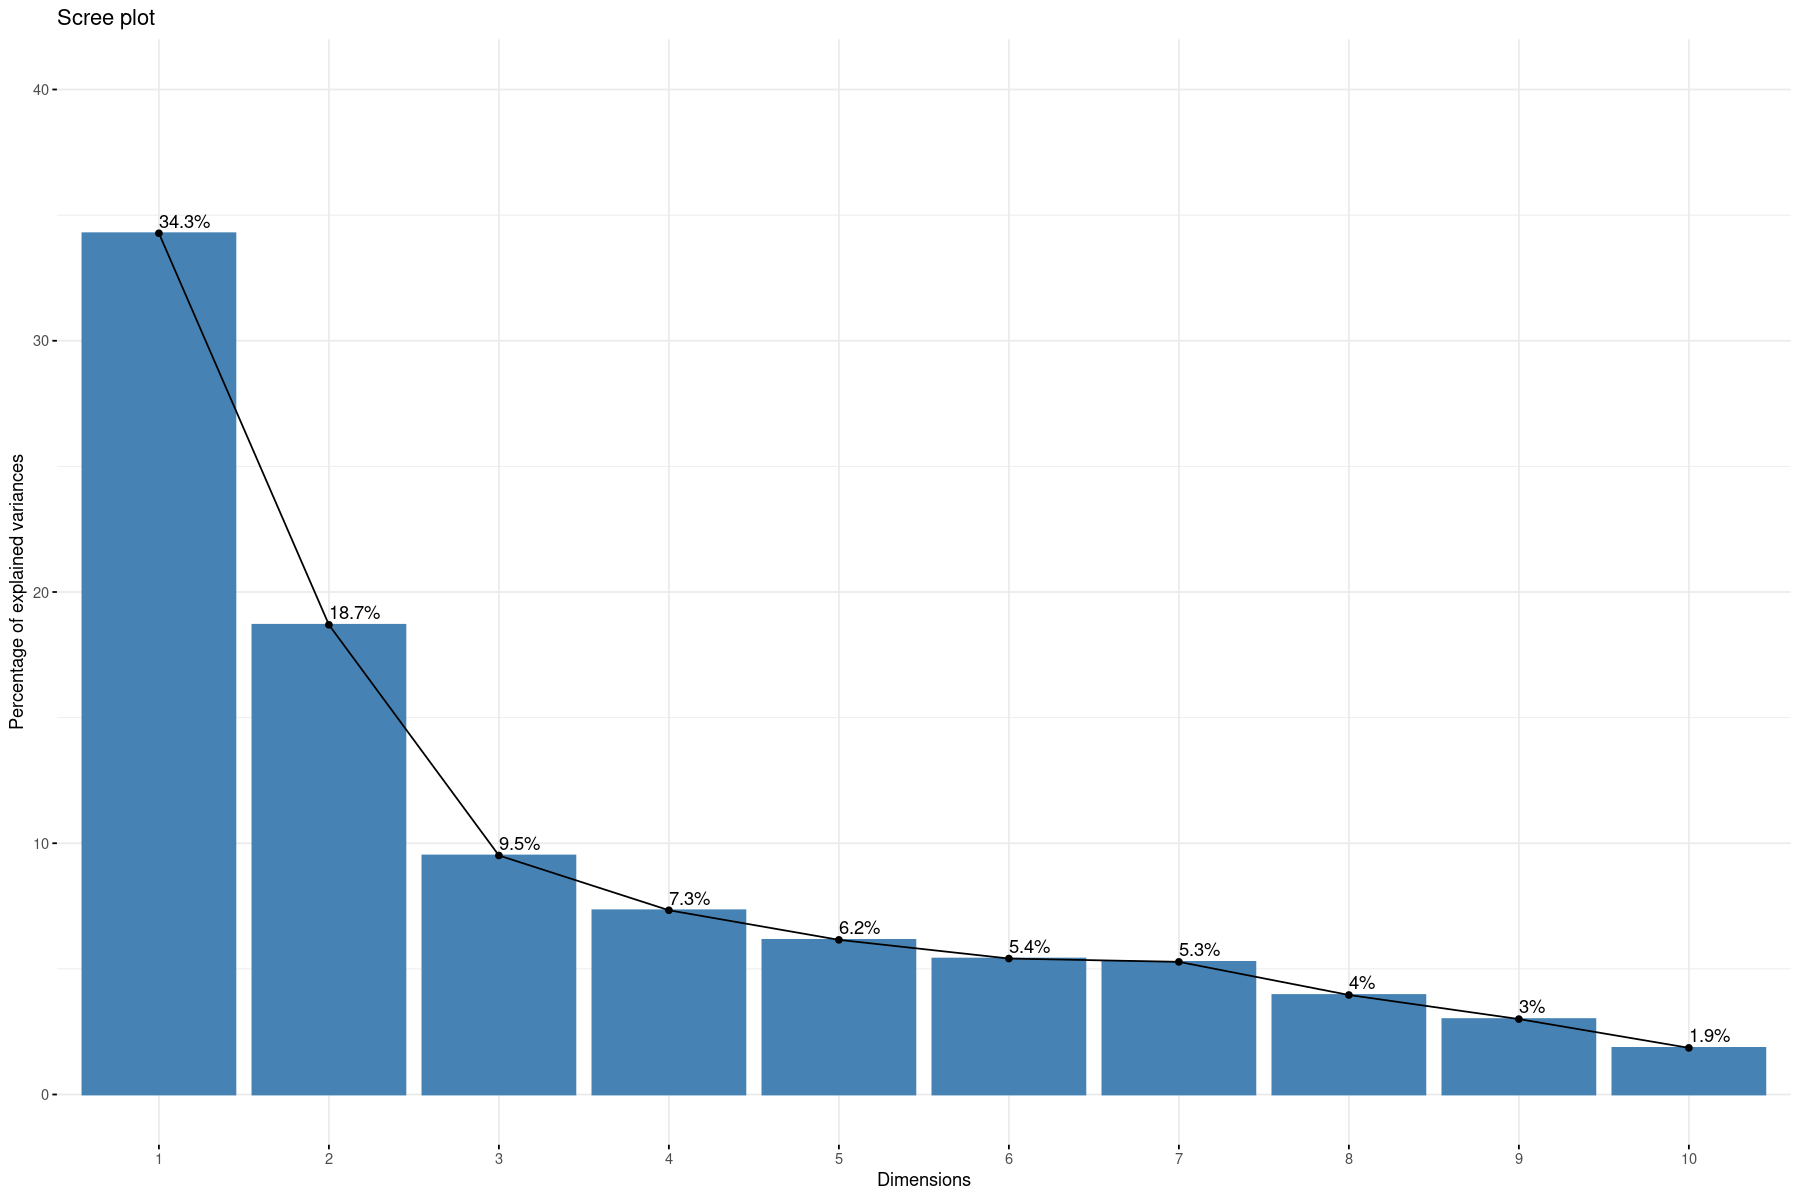

In [105]:
fviz_screeplot(resultat_pca, addlabels=TRUE, ylim=c(0,40))

In [106]:
boxplot(resultat_pca$ind$coord)

In [107]:
var=get_pca_var(resultat_pca)
fviz_pca_var(resultat_pca,col.var= "contrib",gradient.cols=c("grey", "red"))

In [108]:
corrplot(resultat_pca$var$cor, is.corr=FALSE)

# Modélisation

In [109]:
complete_energy$SElec_fossil = NULL
complete_energy$Value_co2 = NULL
complete_energy$Entity = NULL

La variable Entity ajoute beaucoup de variables ce qui perturbe notre étude

## Question 1 : extraction des échantillons d'apprentissage et test

In [110]:
set.seed(183) # initialisation du générateur

# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(complete_energy) # nombre de lignes dans les données
nvar <- ncol(complete_energy) # nombre de colonnes

# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 

# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

# construction de l'échantillon d'apprentissage
datappr <-complete_energy[appri,] 
# construction de l'échantillon test
datestr <- complete_energy[testi, ] 

# vérification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	2294 obs. of  16 variables:
 $ Year             : Factor w/ 21 levels "2000","2001",..: 4 5 7 9 10 11 12 14 15 16 ...
 $ gdp_growth       : num  8.83 1.41 5.36 3.92 21.39 ...
 $ Latitude         : num  33.9 33.9 33.9 33.9 33.9 ...
 $ Longitude        : num  67.7 67.7 67.7 67.7 67.7 ...
 $ SAccess_elec     : num  2.69 3 3.42 3.75 3.84 ...
 $ SAccess_fuels    : num  2.35 2.48 2.7 2.87 2.97 ...
 $ SRenewable_energy: num  6.05 6.65 5.65 4.6 4.07 ...
 $ SElec_nuclear    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SElec_renew      : num  0.489 0.445 0.495 0.432 0.577 ...
 $ SLow_carbon      : num  8.19 7.93 8.73 8.6 9.11 ...
 $ SPrimary_energy  : num  2.72 2.66 2.86 3.2 3.44 ...
 $ SEnergy_intensity: num  0.336 0.182 0.405 0.663 0.811 ...
 $ Sgdp_capita      : num  2.63 2.68 2.79 2.95 3.04 ...
 $ SDensity         : num  4.09 4.09 4.09 4.09 4.09 ...
 $ SLand_area       : num  13.4 13.4 13.4 13.4 13.4 ...
 $ SValue_co2       : num  7.11 6.94 7.47 8.18 8.49 ...
'data.frame':	574 obs. of  16

In [111]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(2, 17)+ylim(-0.8, 2)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

## Question 2 : comparaison de différentes méthodes de prévision sur l'échantillon d'apprentissage

### Modèles de prévision par Regression

#### Sans sélection de variable

In [112]:
# estimation du modèle sans interaction
reg.lm <-aov(SValue_co2 ~ ., data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.lm)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_rl <- 1 - (SS_Residual / SS_Total)
R2a_rl = 1 - ((1-R2_rl)*(dim(datappr)[1]-1))/(dim(datappr)[1]-length(reg.lm$coefficients)-20)# on compte bien chaque modalité de year comme un paramètre 
paste("R2 =", R2a_rl)

plot(fit.lm,datappr$SValue_co2)

[1] "R2 = 0.980789176921687"

Warning message:
“Removed 38 rows containing missing values (`geom_point()`).”


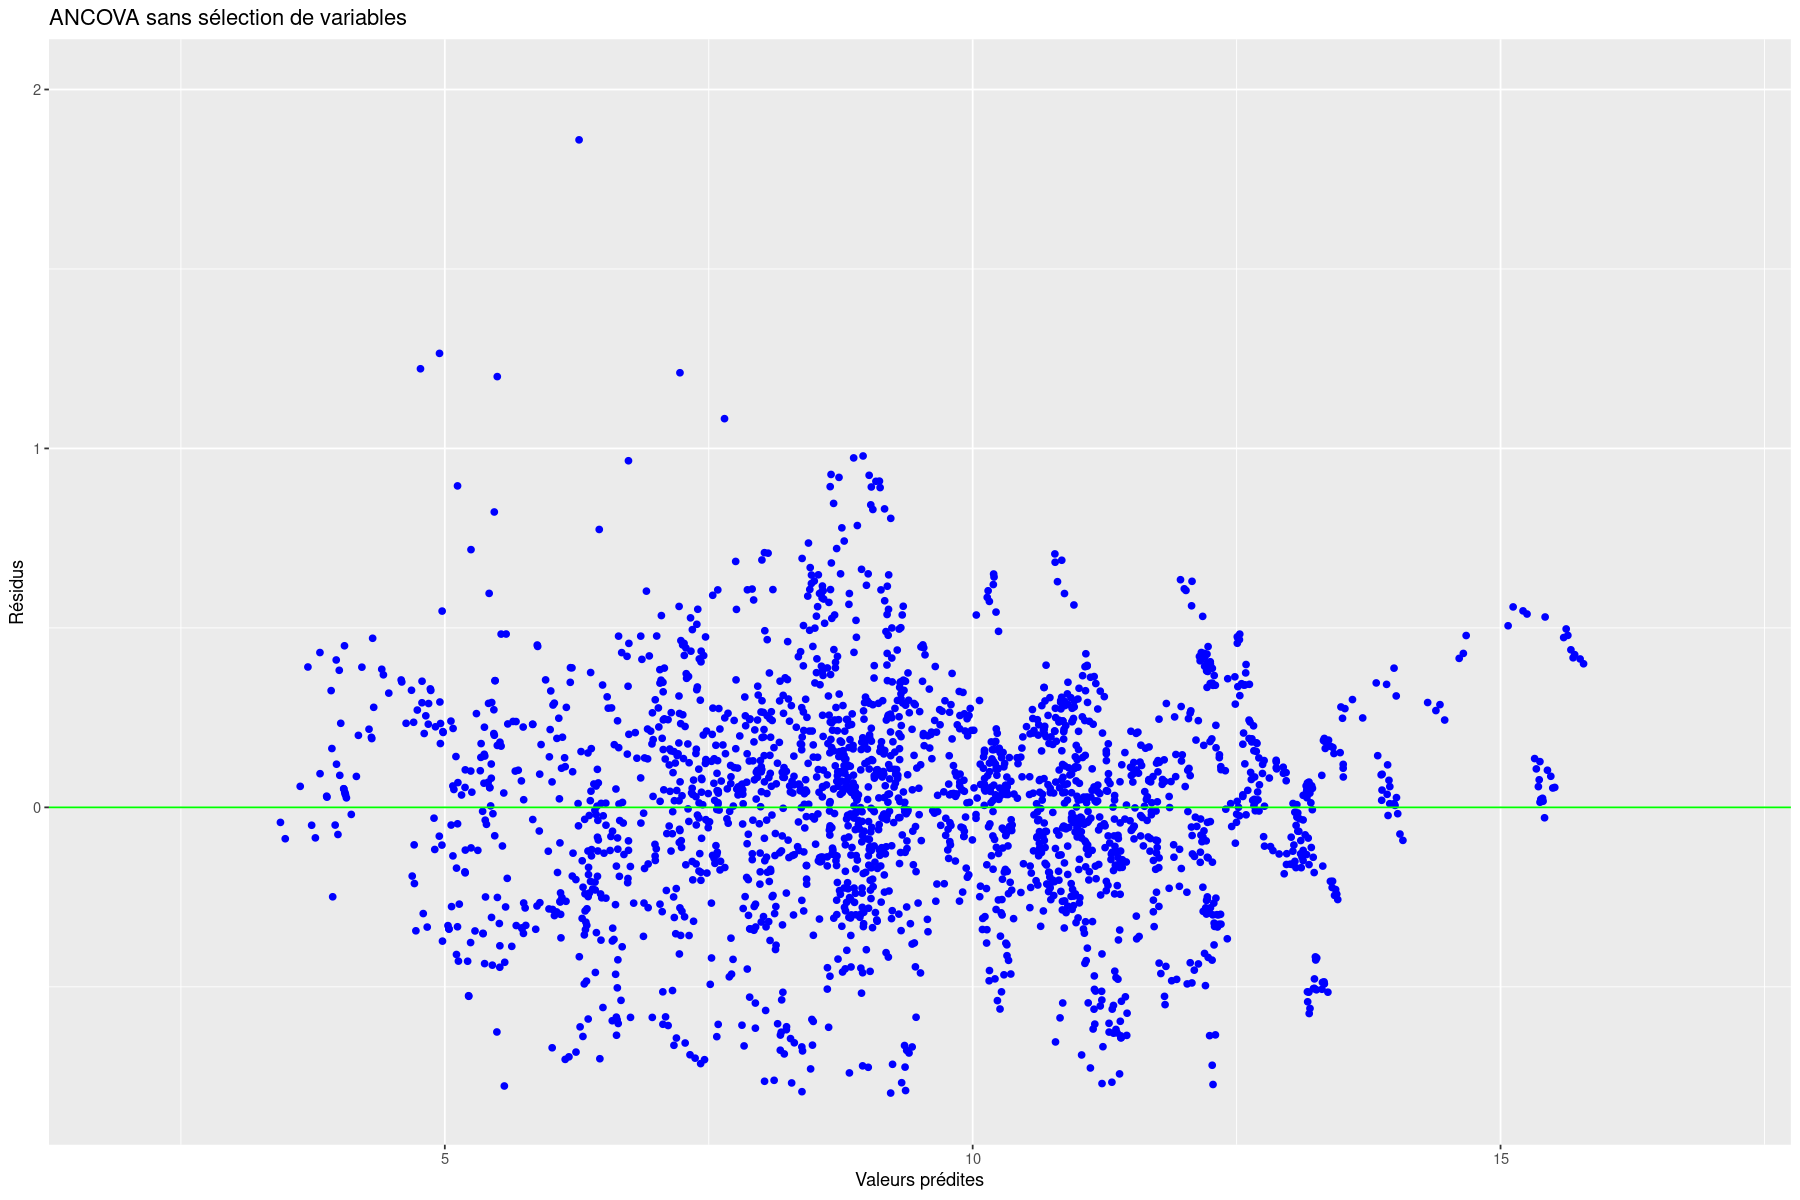

In [113]:

gplot.res(fit.lm,res.lm,"ANCOVA sans sélection de variables")


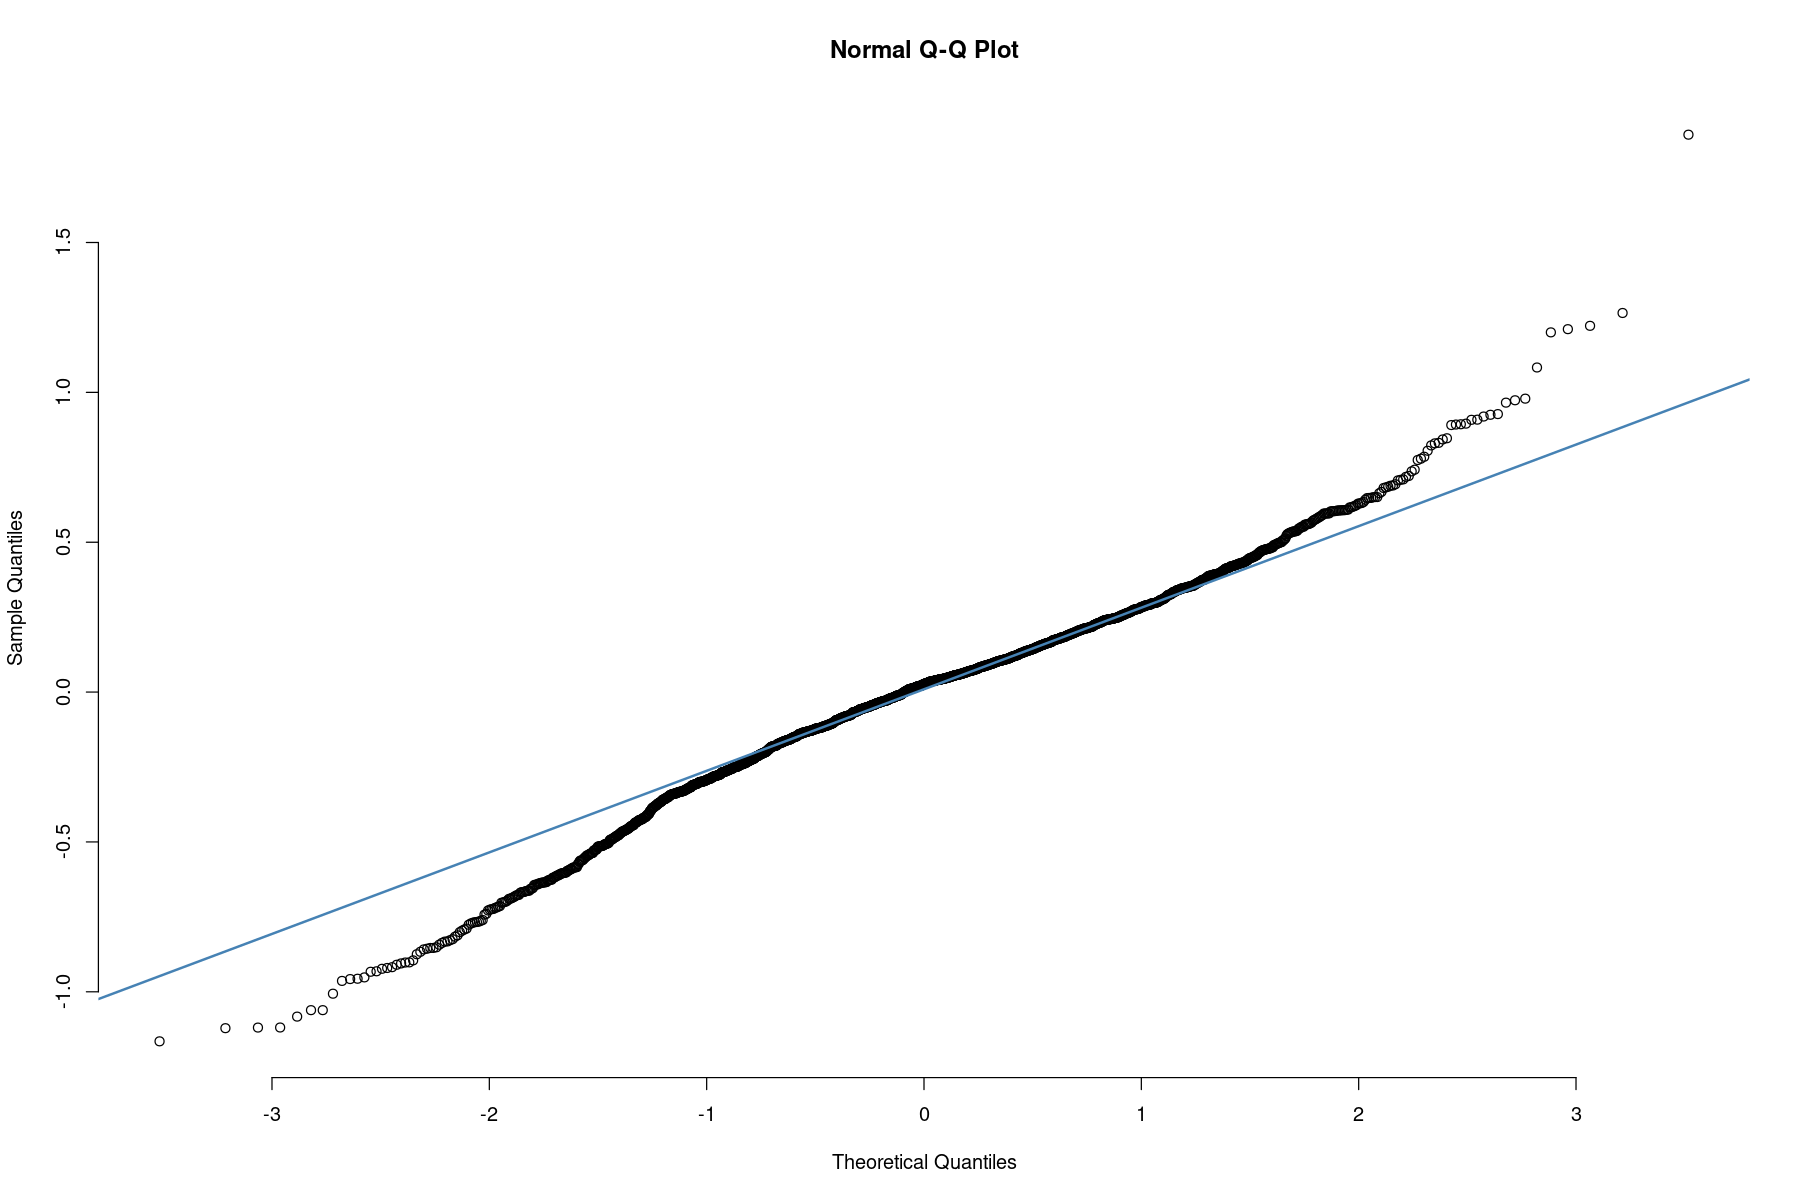

In [114]:
qqnorm(res.lm , pch = 1, frame = FALSE)
qqline(res.lm , col = "steelblue", lwd = 2)

In [115]:
summary(reg.lm)

                    Df Sum Sq Mean Sq   F value Pr(>F)    
Year                19     61       3    29.846 <2e-16 ***
gdp_growth           1     21      21   197.199 <2e-16 ***
Latitude             1   2217    2217 20670.729 <2e-16 ***
Longitude            1    120     120  1114.903 <2e-16 ***
SAccess_elec         1   1555    1555 14502.939 <2e-16 ***
SAccess_fuels        1    482     482  4493.154 <2e-16 ***
SRenewable_energy    1     20      20   189.737 <2e-16 ***
SElec_nuclear        1   2188    2188 20399.895 <2e-16 ***
SElec_renew          1   2235    2235 20836.882 <2e-16 ***
SLow_carbon          1    137     137  1275.367 <2e-16 ***
SPrimary_energy      1     35      35   323.589 <2e-16 ***
SEnergy_intensity    1     98      98   917.805 <2e-16 ***
Sgdp_capita          1     28      28   265.536 <2e-16 ***
SDensity             1      0       0     1.197  0.274    
SLand_area           1   3476    3476 32409.505 <2e-16 ***
Residuals         2260    242       0                   

**Le test de nullité des paramètres montre que seule la variable Density n'a pas un effet significatif sur la quantité de CO2 émise par un pays au niveau 5%. Cette variable peut donc être enlevées du modèle séparément**

#### Avec interactions entre les variables

[1] "R2 = 0.99448595474924"

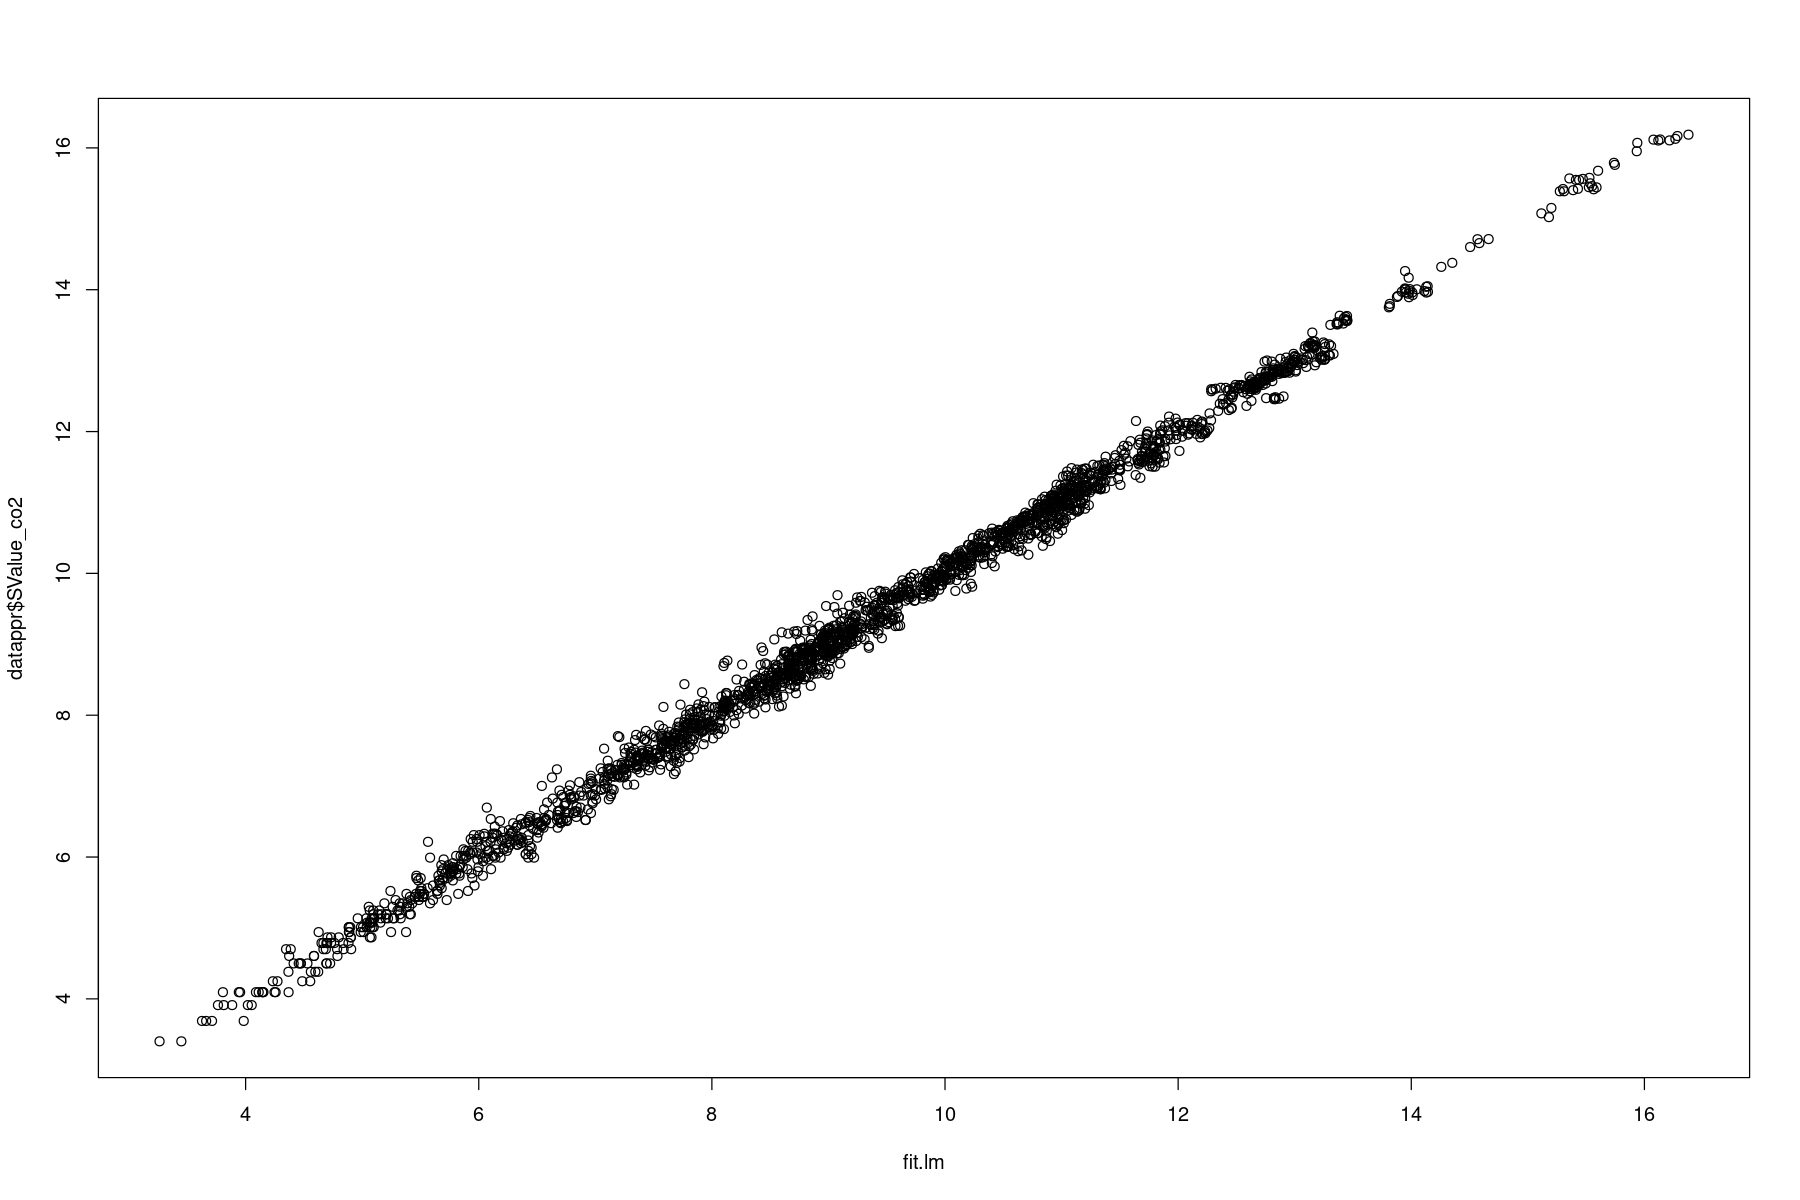

In [116]:
# estimation du modèle sans interaction
reg.lm <-aov(SValue_co2 ~ .^2, data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values
# MSE_rl = mean((datappr$SValue_co2 - fit.lm)^2)
# paste("MSE =", MSE_rl)

# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.lm)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_rl <- 1 - (SS_Residual / SS_Total)
R2a_rl = 1 - ((1-R2_rl)*(dim(datappr)[1]-1))/(dim(datappr)[1]-length(reg.lm$coefficients)-1)
paste("R2 =", R2a_rl)

plot(fit.lm,datappr$SValue_co2)

In [117]:
summary(reg.lm)

                                      Df Sum Sq Mean Sq   F value   Pr(>F)    
Year                                  19     61       3 1.031e+02  < 2e-16 ***
gdp_growth                             1     21      21 6.813e+02  < 2e-16 ***
Latitude                               1   2217    2217 7.142e+04  < 2e-16 ***
Longitude                              1    120     120 3.852e+03  < 2e-16 ***
SAccess_elec                           1   1555    1555 5.011e+04  < 2e-16 ***
SAccess_fuels                          1    482     482 1.552e+04  < 2e-16 ***
SRenewable_energy                      1     20      20 6.555e+02  < 2e-16 ***
SElec_nuclear                          1   2188    2188 7.048e+04  < 2e-16 ***
SElec_renew                            1   2235    2235 7.199e+04  < 2e-16 ***
SLow_carbon                            1    137     137 4.406e+03  < 2e-16 ***
SPrimary_energy                        1     35      35 1.118e+03  < 2e-16 ***
SEnergy_intensity                      1     98     

**Le modèle avec interactions entre les variables surajuste les données c'est à dire qu'il s'adapte trop bien à nos données d'entrainement. En prenant en compte toutes les interactions, nous obtenons un modèle difficile à interpreter et avec un grand nombre de variables. Nous allons donc faire une sélection de variables avec le critère BIC pénalisant les modèles complexes.
Nous avons fait le choix de ce critère car c'est celui qui pénalise le plus la dimension du modèle. Ainsi, il favorise les modèles qui expliquent efficacement les données tout en restant aussi simples que possible.** 

#### Avec sélection de variables (BIC)

In [118]:
reg.glm <- glm(SValue_co2 ~ ., data = datappr)
# Recherche du meilleur modèle au sens 
# du critère d'Akaïke par méthode descendante
reg.glm.step <- stepAIC(reg.glm, direction = "backward",k = log(nrow(datestr)), trace = 0)

Warning message:
“Removed 24 rows containing missing values (`geom_point()`).”


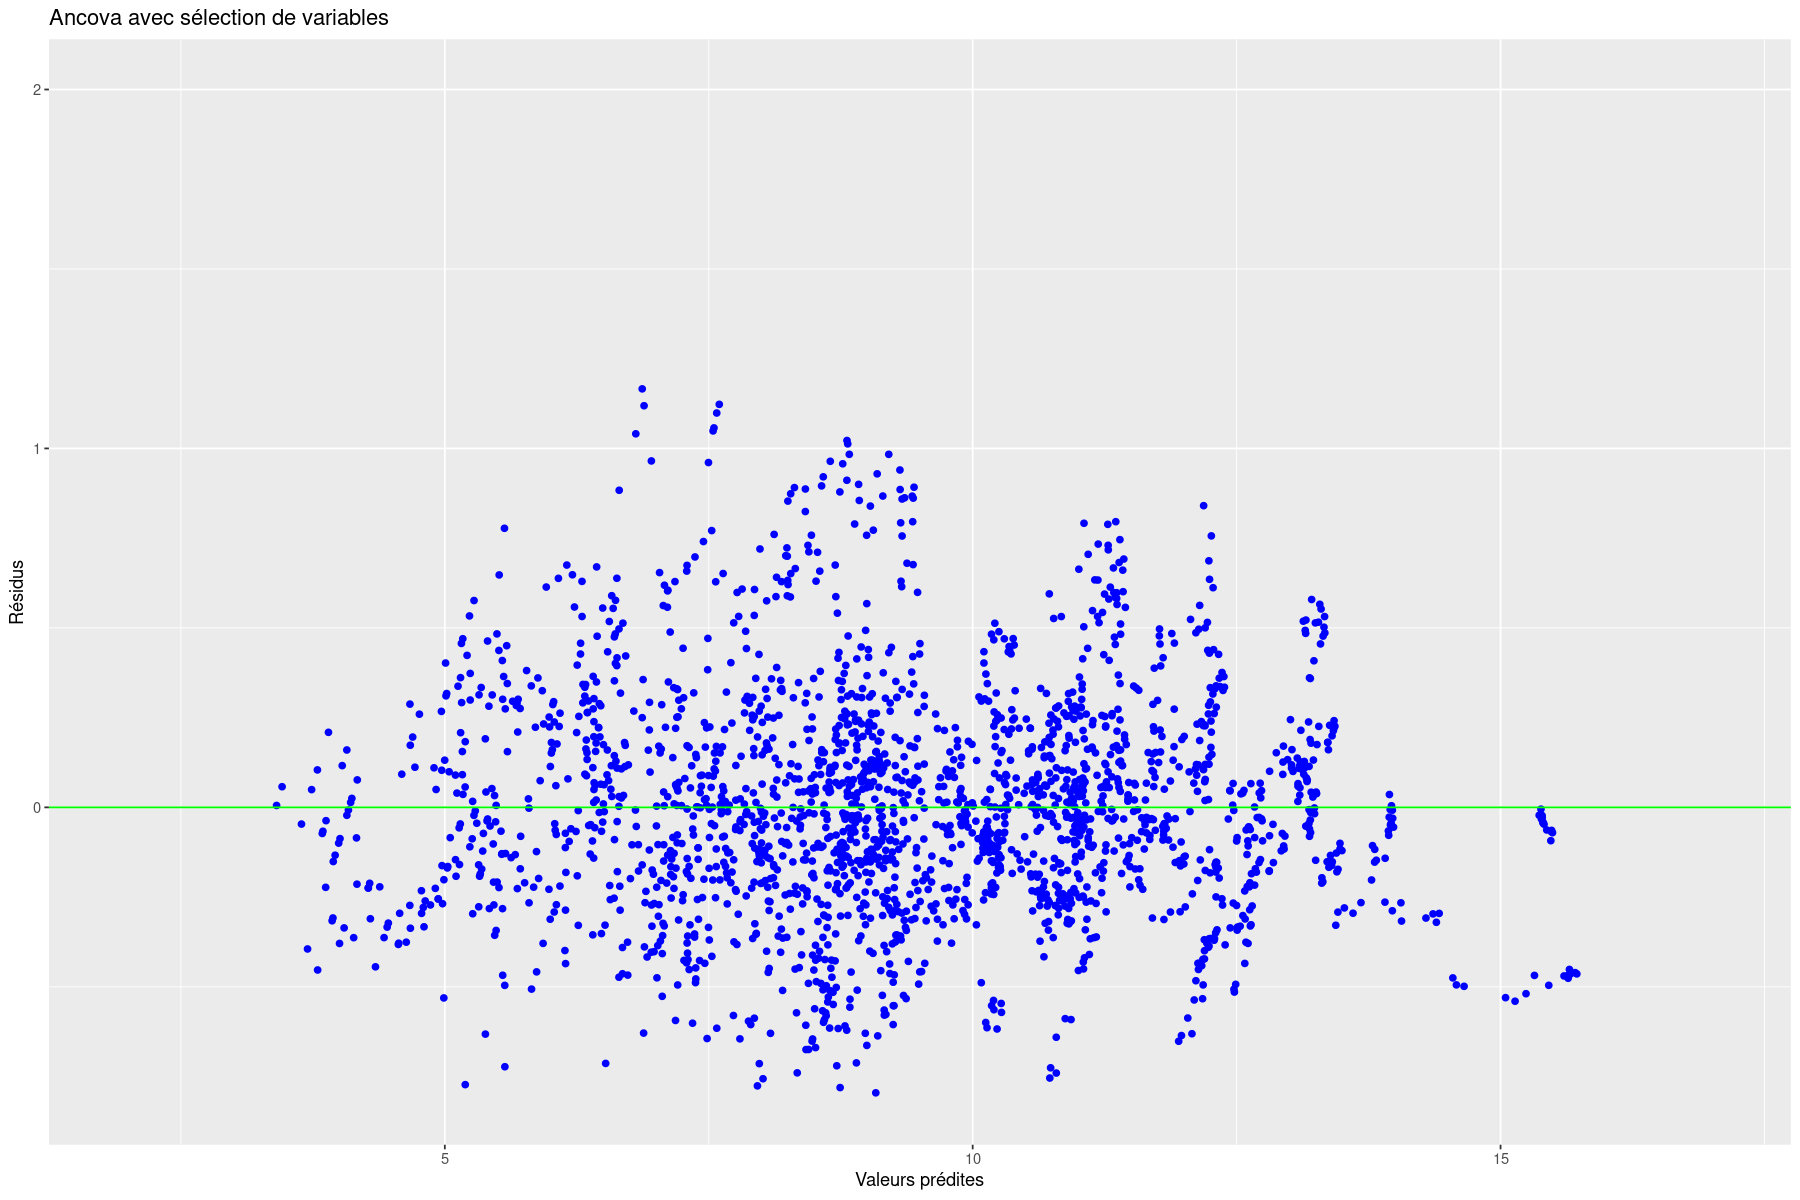

In [119]:
fit.bic=reg.glm.step$fitted
res.bic=fit.bic-datappr[,"SValue_co2"]
gplot.res(fit.bic,res.bic,titre="Ancova avec sélection de variables")

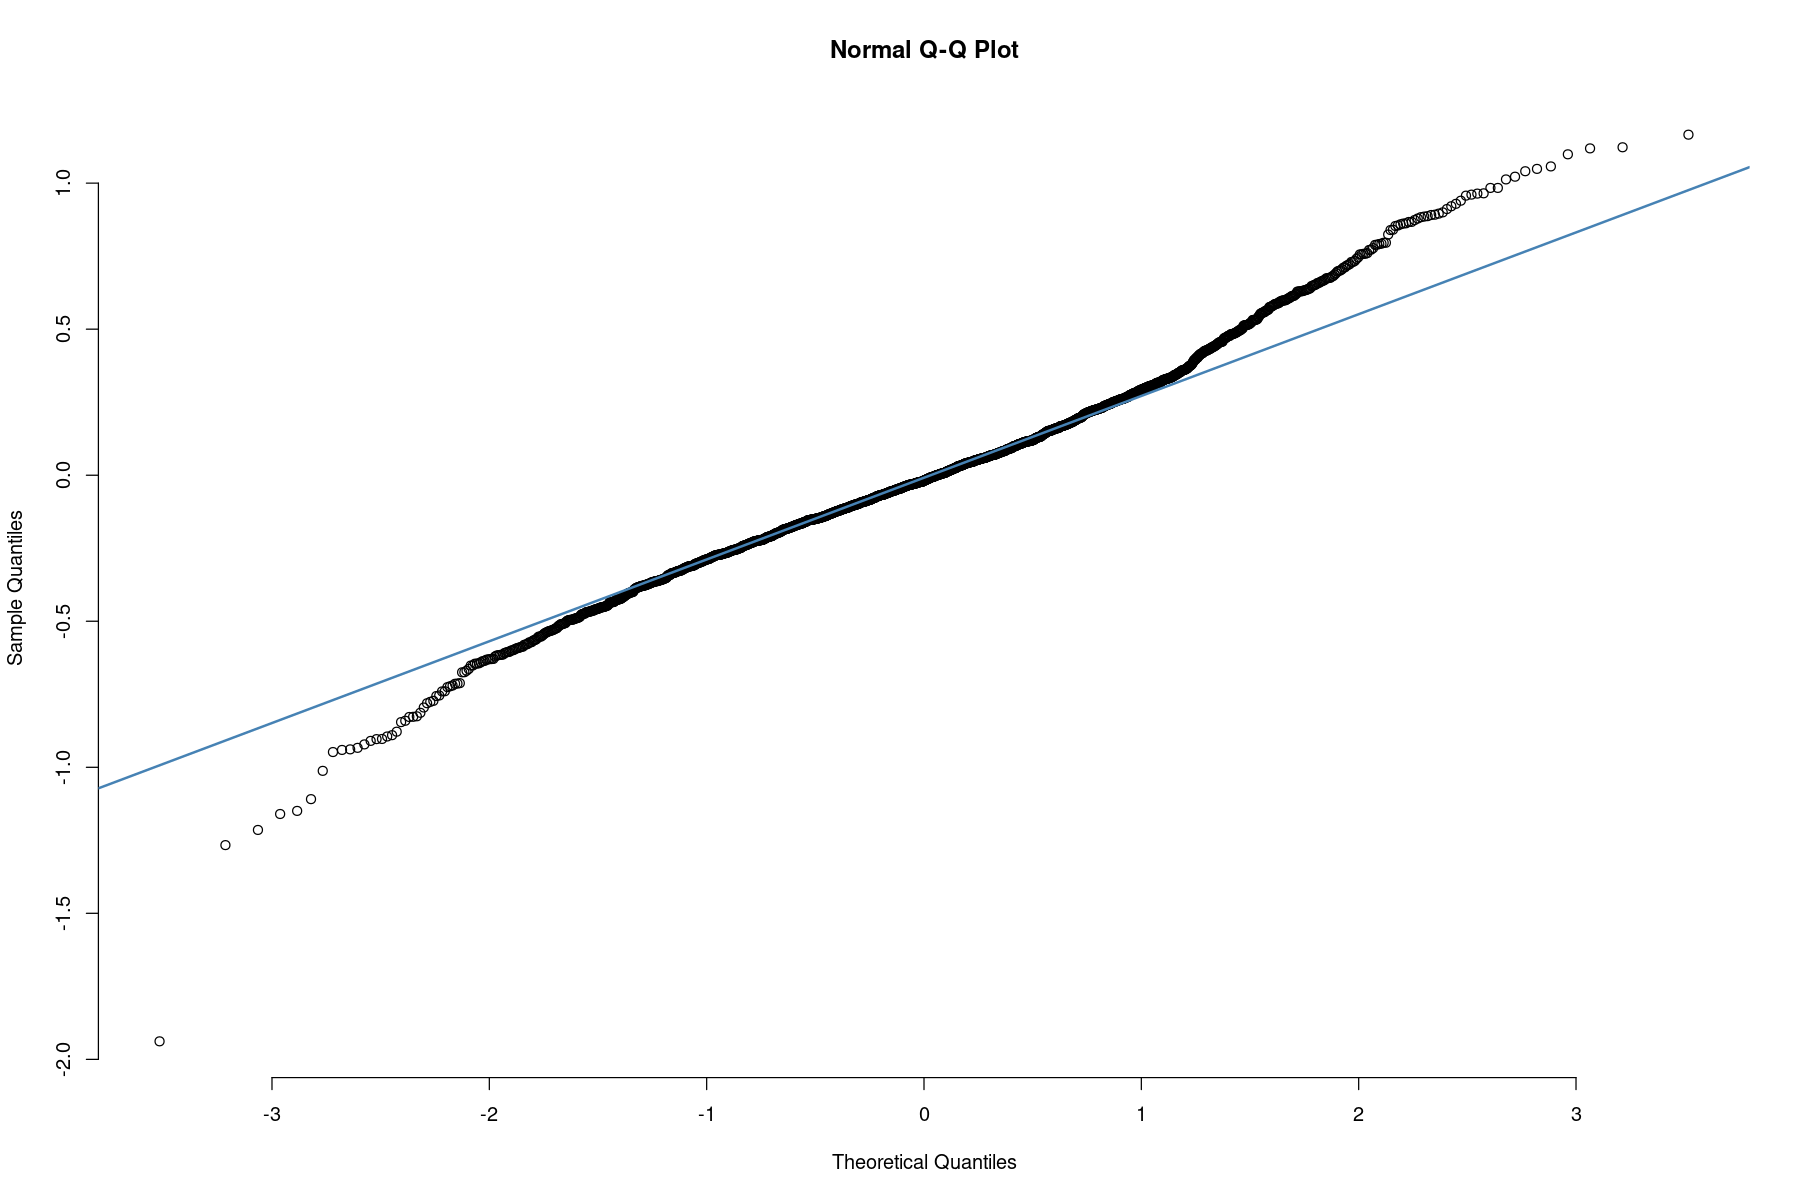

In [120]:
qqnorm(res.bic , pch = 1, frame = FALSE)
qqline(res.bic , col = "steelblue", lwd = 2)

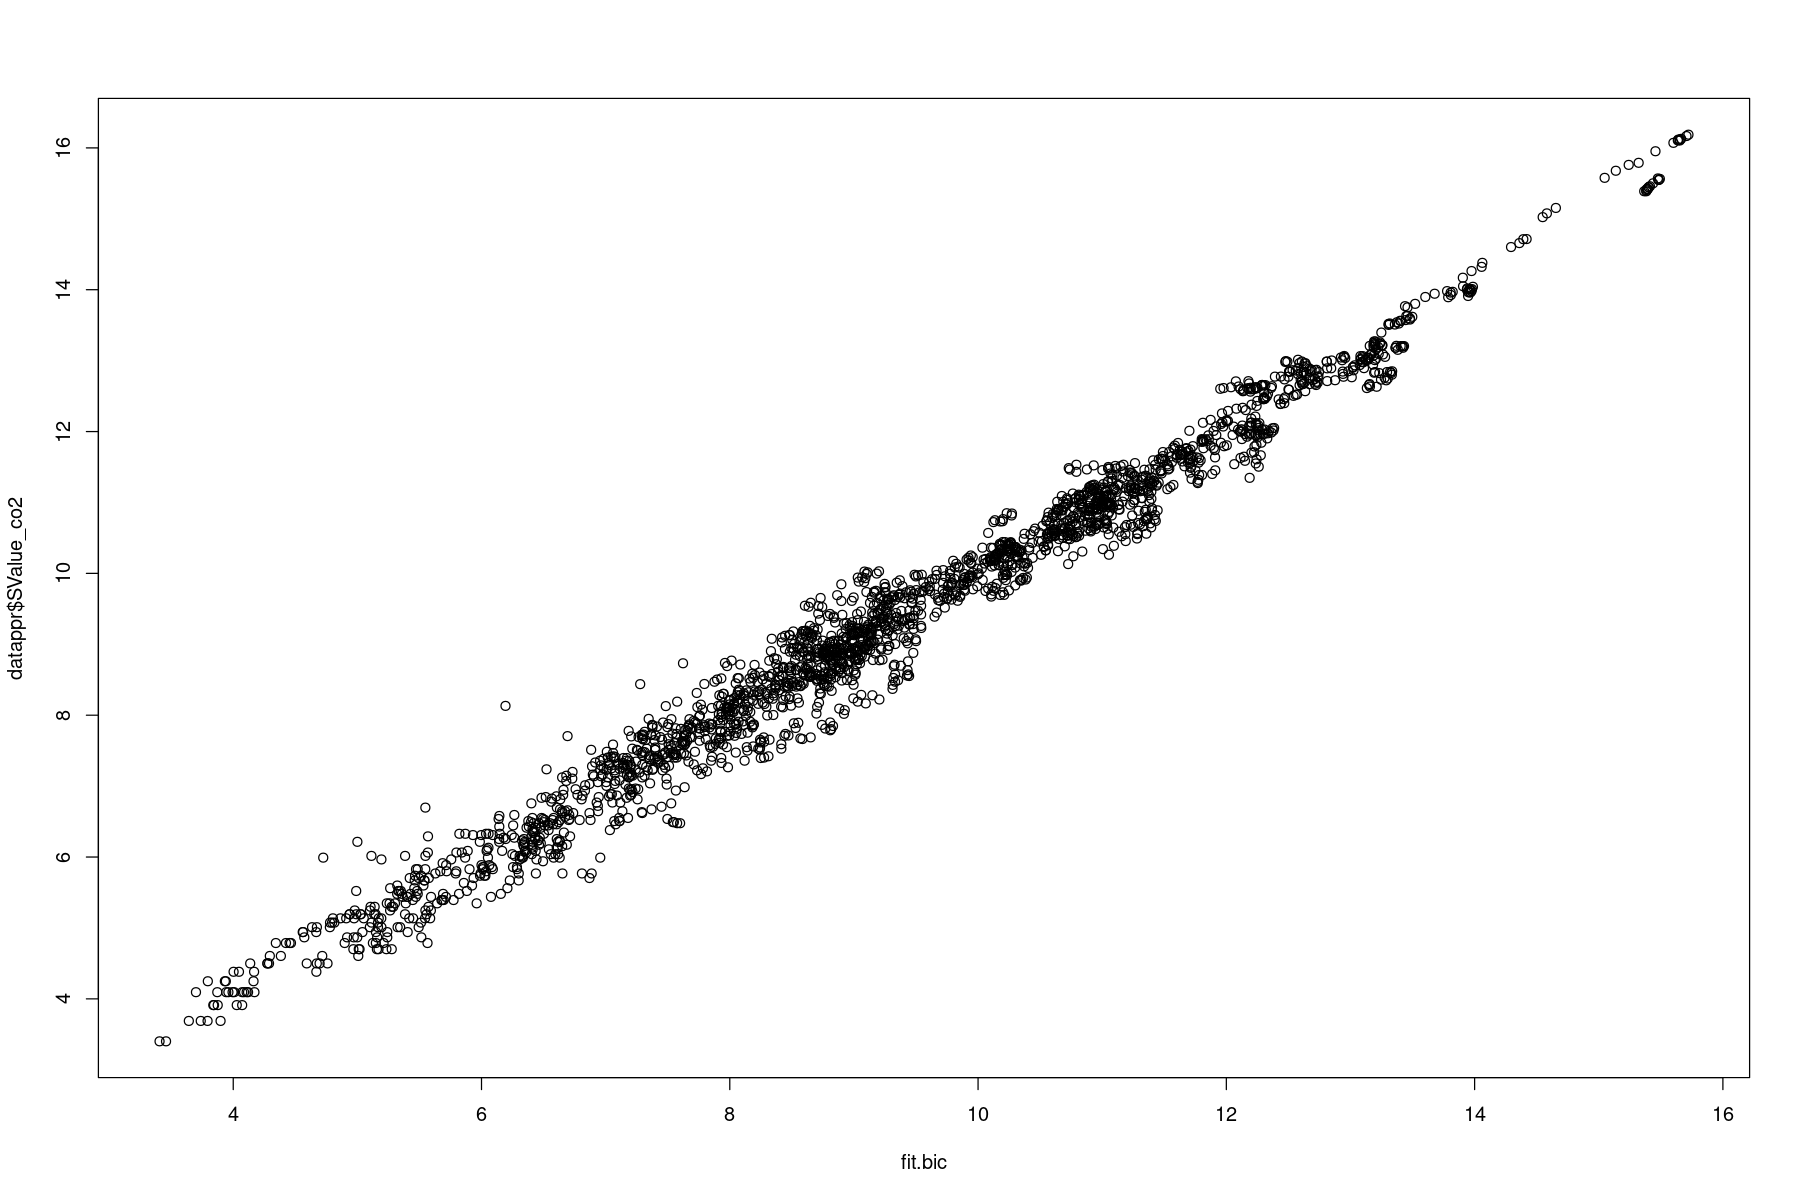

In [121]:
plot(fit.bic,datappr$SValue_co2)

In [122]:
summary(reg.glm.step)


Call:
glm(formula = SValue_co2 ~ gdp_growth + Latitude + SAccess_elec + 
    SAccess_fuels + SRenewable_energy + SElec_nuclear + SElec_renew + 
    SLow_carbon + SPrimary_energy + SEnergy_intensity + Sgdp_capita + 
    SDensity + SLand_area, data = datappr)

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1.478e+01  1.714e-01 -86.204  < 2e-16 ***
gdp_growth        -4.580e-03  1.558e-03  -2.939 0.003325 ** 
Latitude           1.481e-03  3.224e-04   4.595 4.57e-06 ***
SAccess_elec       3.750e-01  1.910e-02  19.630  < 2e-16 ***
SAccess_fuels      8.563e-02  1.321e-02   6.484 1.09e-10 ***
SRenewable_energy -7.338e-02  5.675e-03 -12.930  < 2e-16 ***
SElec_nuclear      1.835e-02  7.204e-03   2.547 0.010943 *  
SElec_renew       -3.577e-02  9.532e-03  -3.753 0.000179 ***
SLow_carbon       -3.638e-02  3.053e-03 -11.916  < 2e-16 ***
SPrimary_energy    8.908e-01  3.431e-02  25.962  < 2e-16 ***
SEnergy_intensity  1.781e-01  1.943e-02   9.168  < 2e-1

In [123]:
MSE_bic = mean((datappr$SValue_co2 - fit.bic)^2)
paste("MSE =", MSE_bic)
# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.bic)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_bic <- 1 - (SS_Residual / SS_Total)
R2a_bic = 1 - ((1-R2_bic)*(dim(datappr)[1]-1))/(dim(datappr)[1]-length(reg.glm.step$coefficients)-1)
paste("R2 ajusté=", R2a_bic)

[1] "MSE = 0.107416999052532"

[1] "R2 ajusté= 0.980803009573477"

#### Avec pénalisation

In [124]:
# Dans glmnet, le 17 correspond à l'indice de notre SvalueCo2 qu'il faut mettre en y ( variable à prédire) et pas dans x.
# Il faudra aussi enlever les factors ( entity et year )
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(SValue_co2 ~ .-1, data = datappr)
reg.lasso <- glmnet(y = datappr$SValue_co2, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
#legend("topright", legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))



head(x.mat)

Year2000 Year2001 Year2002 Year2003 Year2004 Year2005 Year2006 Year2007
4  0        0        0        1        0        0        0        0       
5  0        0        0        0        1        0        0        0       
7  0        0        0        0        0        0        1        0       
9  0        0        0        0        0        0        0        0       
10 0        0        0        0        0        0        0        0       
11 0        0        0        0        0        0        0        0       
   Year2008 Year2009 ⋯ SAccess_fuels SRenewable_energy SElec_nuclear
4  0        0        ⋯ 2.351375      6.054750          0            
5  0        0        ⋯ 2.476538      6.651316          0            
7  0        0        ⋯ 2.698000      5.647123          0            
9  1        0        ⋯ 2.873565      4.601087          0            
10 0        1        ⋯ 2.965273      4.065710          0            
11 0        0        ⋯ 3.044522      3.892300          0            
   SElec_renew SLow_carbon SPrimary_energy SEnergy_intensity Sgdp_capita
4  0.4885800   8.186653    2.718971        0.3364722         2.625308   
5  0.4446858   7.932298    2.659626        0.1823216         2.676834   
7  0.4946962   8.728716    2.859206        0.4054651         2.787470   
9  0.4317824   8.600733    3.204950        0.6626880         2.949488   
10 0.5766134   9.109266    3.441243        0.8109302         3.040274   
11 0.5596158   8.932370    3.537859        0.9001613         3.148837   
   SDensity SLand_area
4  4.094345 13.38815  
5  4.094345 13.38815  
7  4.094345 13.38815  
9  4.094345 13.38815  
10 4.094345 13.38815  
11 4.094345 13.38815

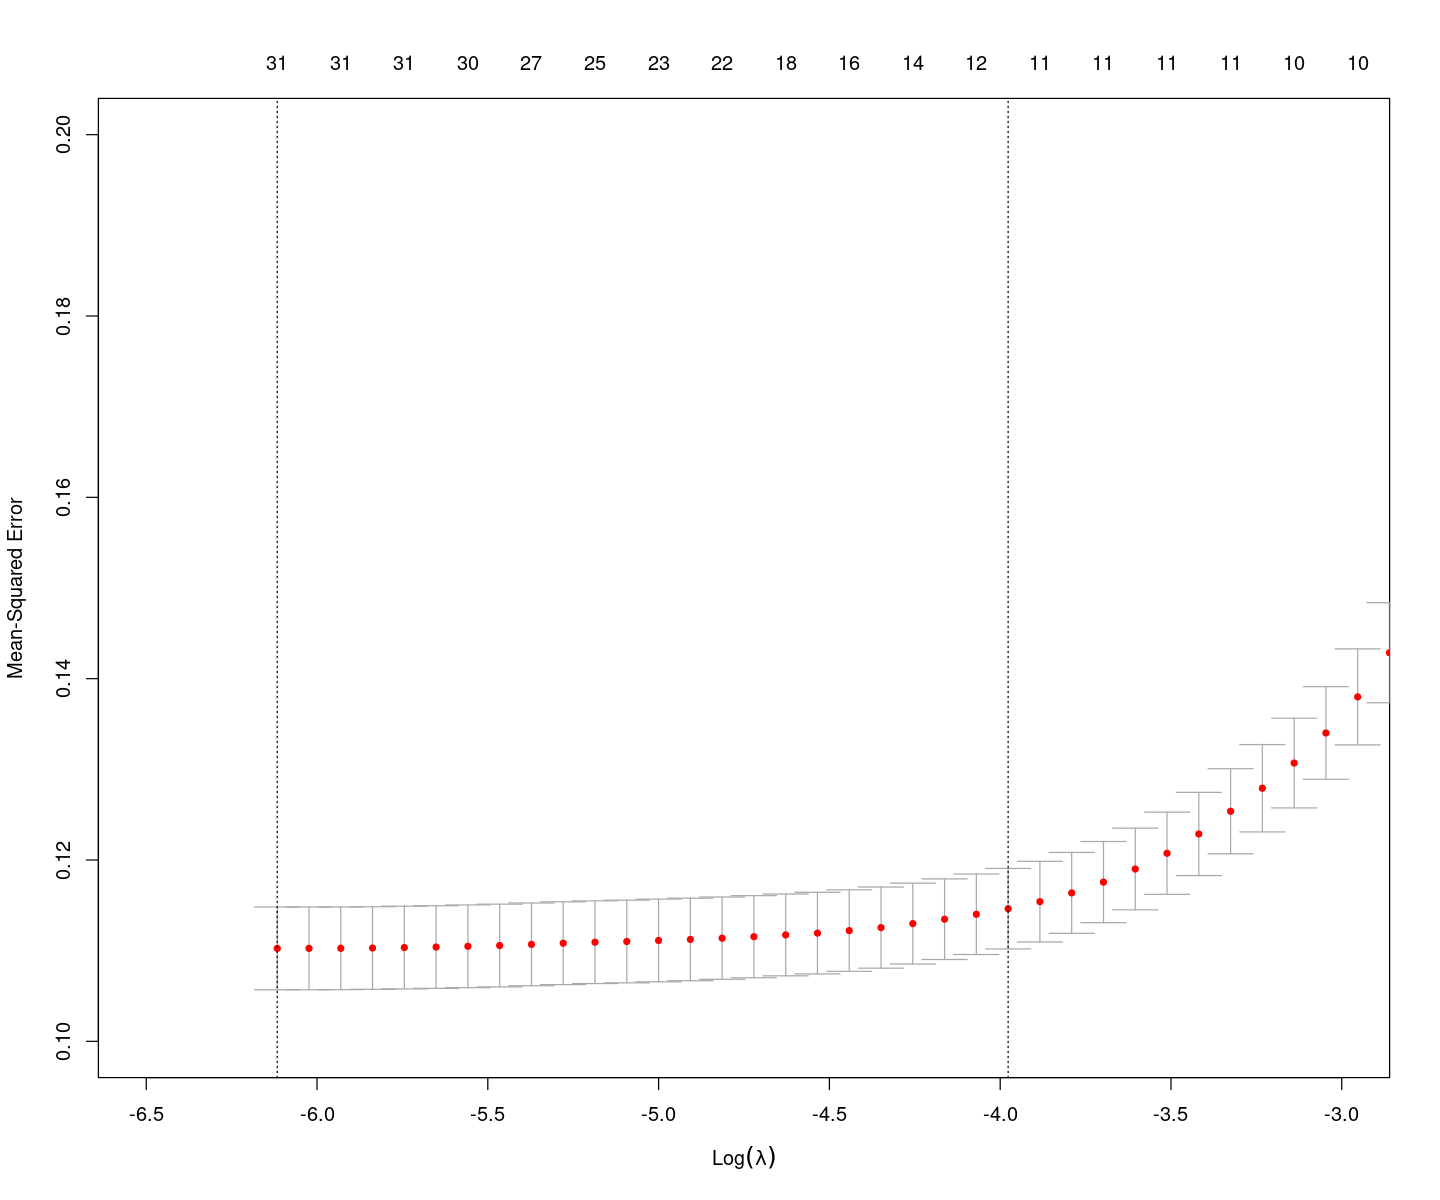

In [125]:
#Choix optimal de l'hyperparamètre
reg.lasso.cv <- cv.glmnet(y = datappr[, 16], x = x.mat, nfolds = 10)
plot(reg.lasso.cv,xlim=c(-6.5,-3),ylim=c(0.1,0.2))

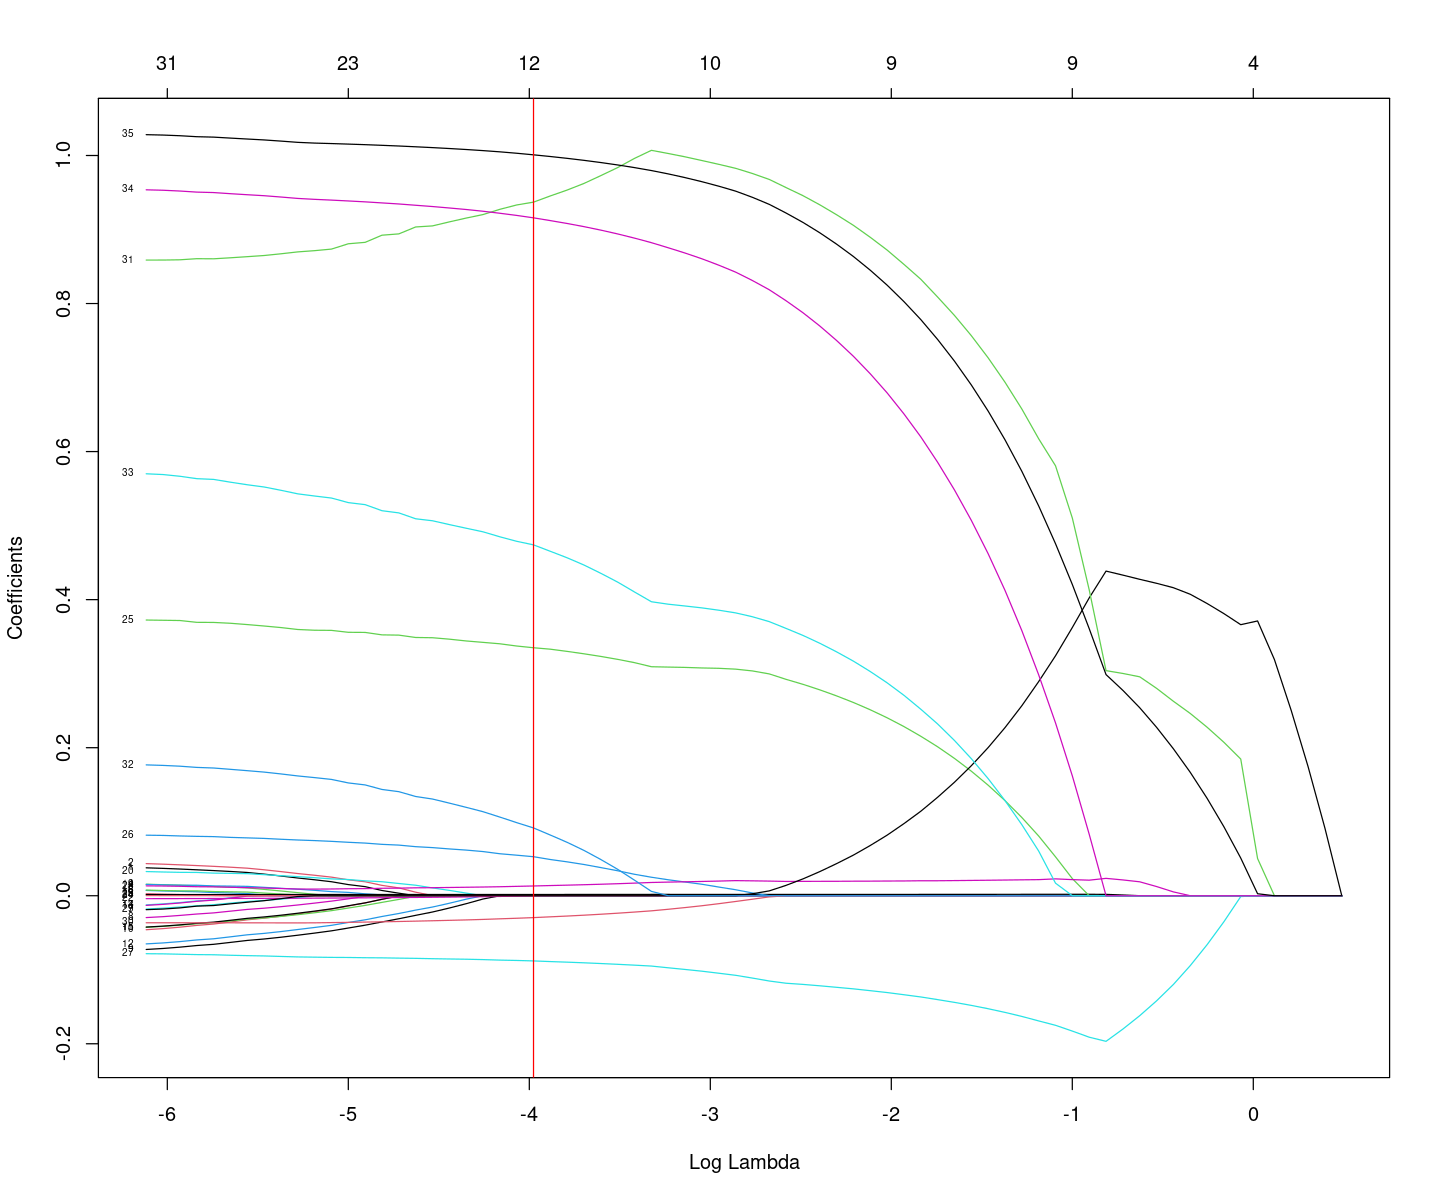

In [134]:
plot(reg.lasso, xvar = "lambda", label = TRUE)
abline(v=log(reg.lasso.cv$lambda.1se),col="red")

In [127]:
fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- datappr$SValue_co2 - fit.lasso.1se 

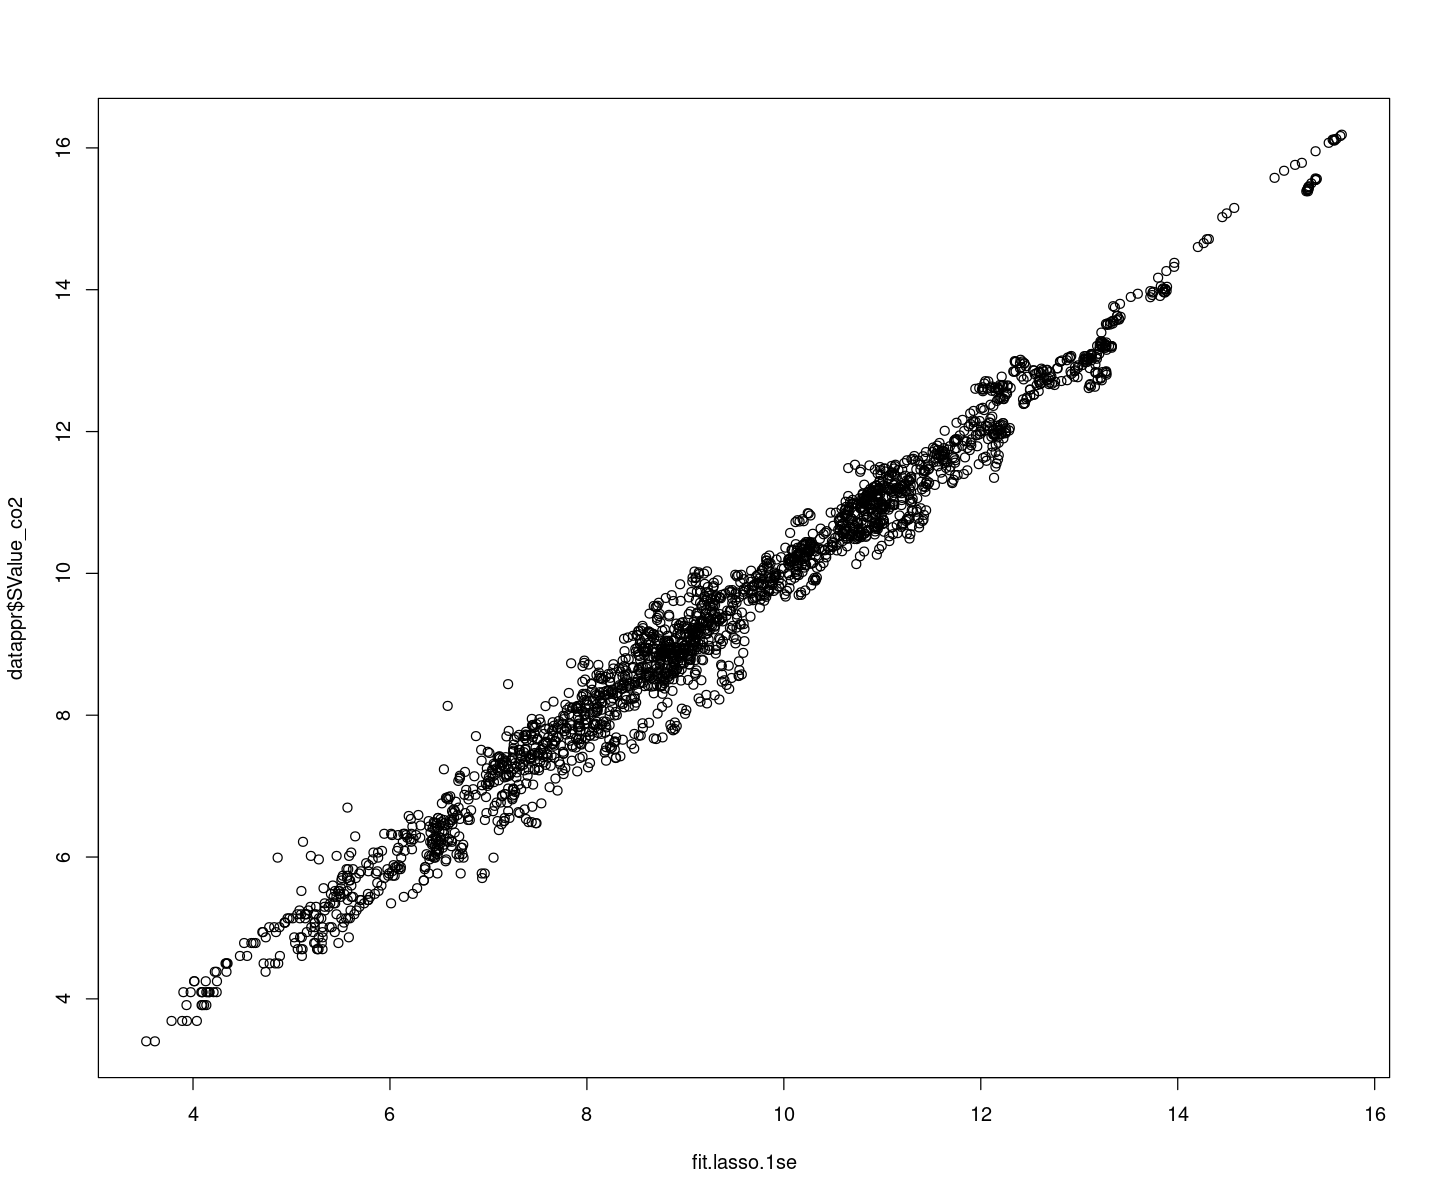

In [128]:
plot(fit.lasso.1se,datappr$SValue_co2)

Warning message:
“Removed 45 rows containing missing values (`geom_point()`).”


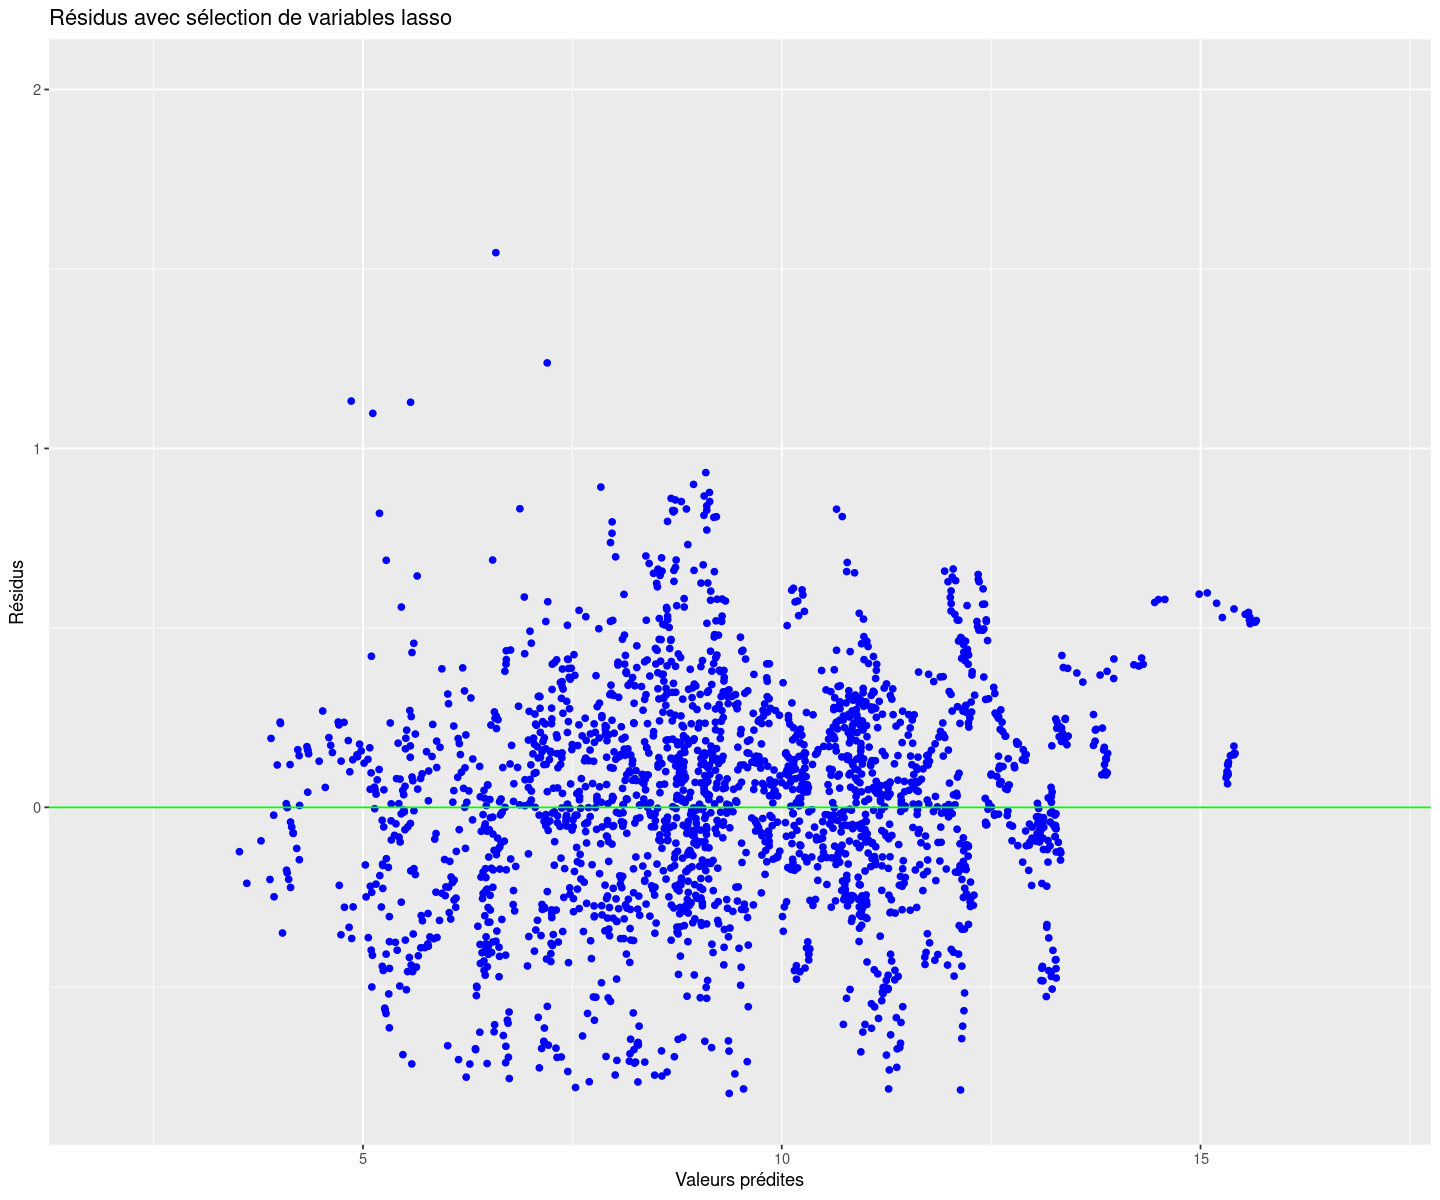

In [129]:
#Graphe des résidus
gplot.res(fit.lasso.1se,res.lasso.1se,"Résidus avec sélection de variables lasso")

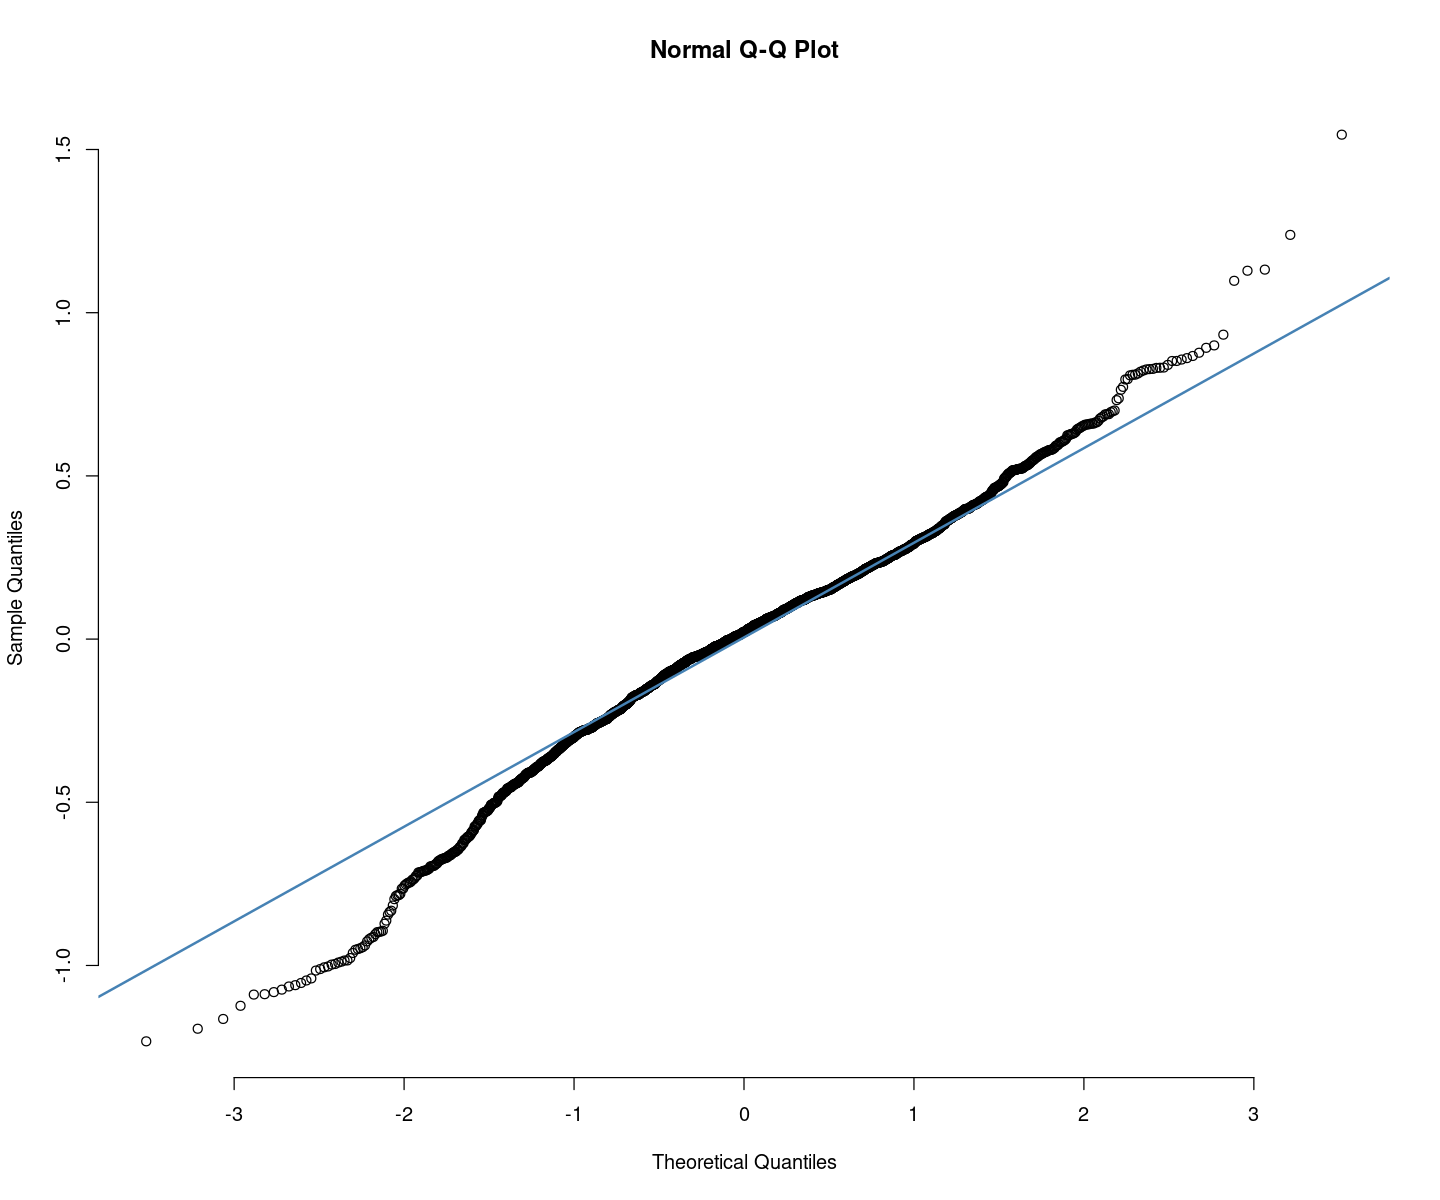

In [130]:
qqnorm(res.lasso.1se , pch = 1, frame = FALSE)
qqline(res.lasso.1se , col = "steelblue", lwd = 2)

In [131]:
#MSE et R²
MSE_lse = mean((datappr$SValue_co2 - fit.lasso.1se)^2)
paste("MSE =", MSE_lse)

# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.lasso.1se)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_lse <- 1 - (SS_Residual / SS_Total)
R2a_lse = 1 - ((1-R2_lse)*(dim(datappr)[1]-1))/(dim(datappr)[1]-length(reg.lasso.cv$coefficients)-1)
paste("R2 ajusté =", R2a_lse)

[1] "MSE = 0.112627460273712"

[1] "R2 ajusté = 0.979994717222961"

#### Interpretation de l'effet des variables

In [132]:
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 0.019"

36 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)       -1.359818e+01
Year2000           .           
Year2001           .           
Year2002           .           
Year2003           .           
Year2004           .           
Year2005           .           
Year2006           .           
Year2007           .           
Year2008           .           
Year2009           .           
Year2010           .           
Year2011           .           
Year2012           .           
Year2013           .           
Year2014           .           
Year2015           .           
Year2016           .           
Year2017           .           
Year2018           .           
Year2019           .           
Year2020           .           
gdp_growth        -1.871127e-04
Latitude           1.705864e-03
Longitude          .           
SAccess_elec       3.350167e-01
SAccess_fuels      5.272588e-02
SRenewable_energy -8.805590e-02
SElec_nuclear      1.318647e-0

### La méthode SVR : Support Vector Regression 

In [252]:
svm.reg0 = svm(SValue_co2 ~ ., data = datappr)
summary(svm.reg0)


Call:
svm(formula = SValue_co2 ~ ., data = datappr)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.02857143 
    epsilon:  0.1 


Number of Support Vectors:  577






In [ ]:
#Choix du meilleur noyau SVR
param = list(kernel = c("linear", "polynomial", "radial", "sigmoid"),
            cost = c(0.4, 0.5, 0.6, 0.8, 1, 1.4, 2),
            gamma = c(0.02, 0.05, 0.1, 0.5, 0.9, 1),
            epsilon = c(0.05,0.1,0.2,0.5))

svm.reg.tune = tune(svm,SValue_co2 ~ ., data = datappr, ranges = param)

svm.reg.tune

In [ ]:
#Résidus
svm.reg = svm(SValue_co2~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    kernel = svm.reg.tune$best.parameters$kernel)

summary(svm.reg)

In [ ]:
# Calculer le coefficient de détermination R² (R2 score)
SS_Residual <- sum((datappr$SValue_co2 - fit.svmr)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_svm <- 1 - (SS_Residual / SS_Total)

paste("R2 =", R2_svm)

In [ ]:
plot(fit.svmr,datappr$SValue_co2)

In [ ]:
fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"SValue_co2"]
gplot.res(fit.svmr,res.svmr,titre="")

### La méthode CART : Classification And Regression Trees 

In [183]:
tree.reg=rpart(SValue_co2~.,data=datappr, control = rpart.control(cp=0.02))

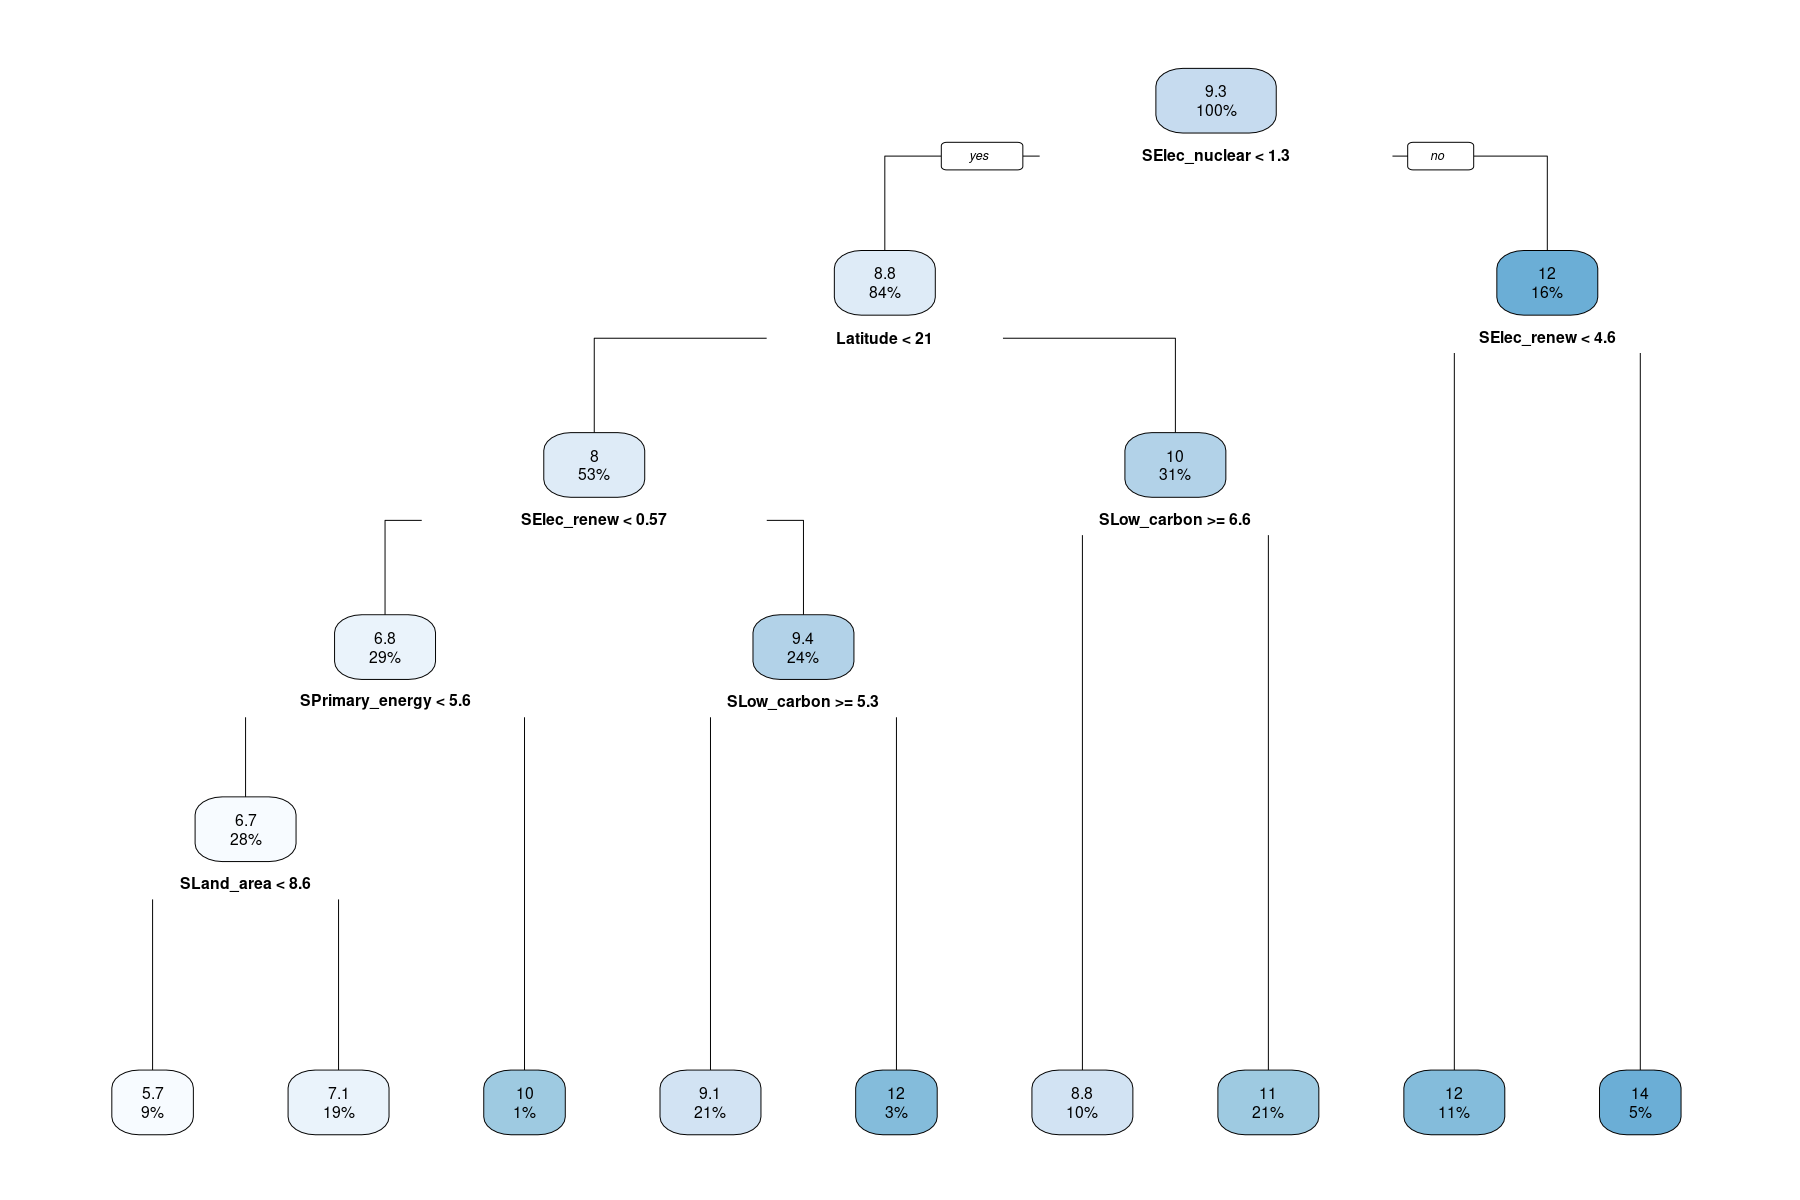

In [184]:
library(rpart.plot)
options(repr.plot.width = 15, repr.plot.height = 10)
rpart.plot(tree.reg)

L'arbre brut est complexe, nous allons donc le simplifier en estimant la profondeur de l'arbre par validation croisée.

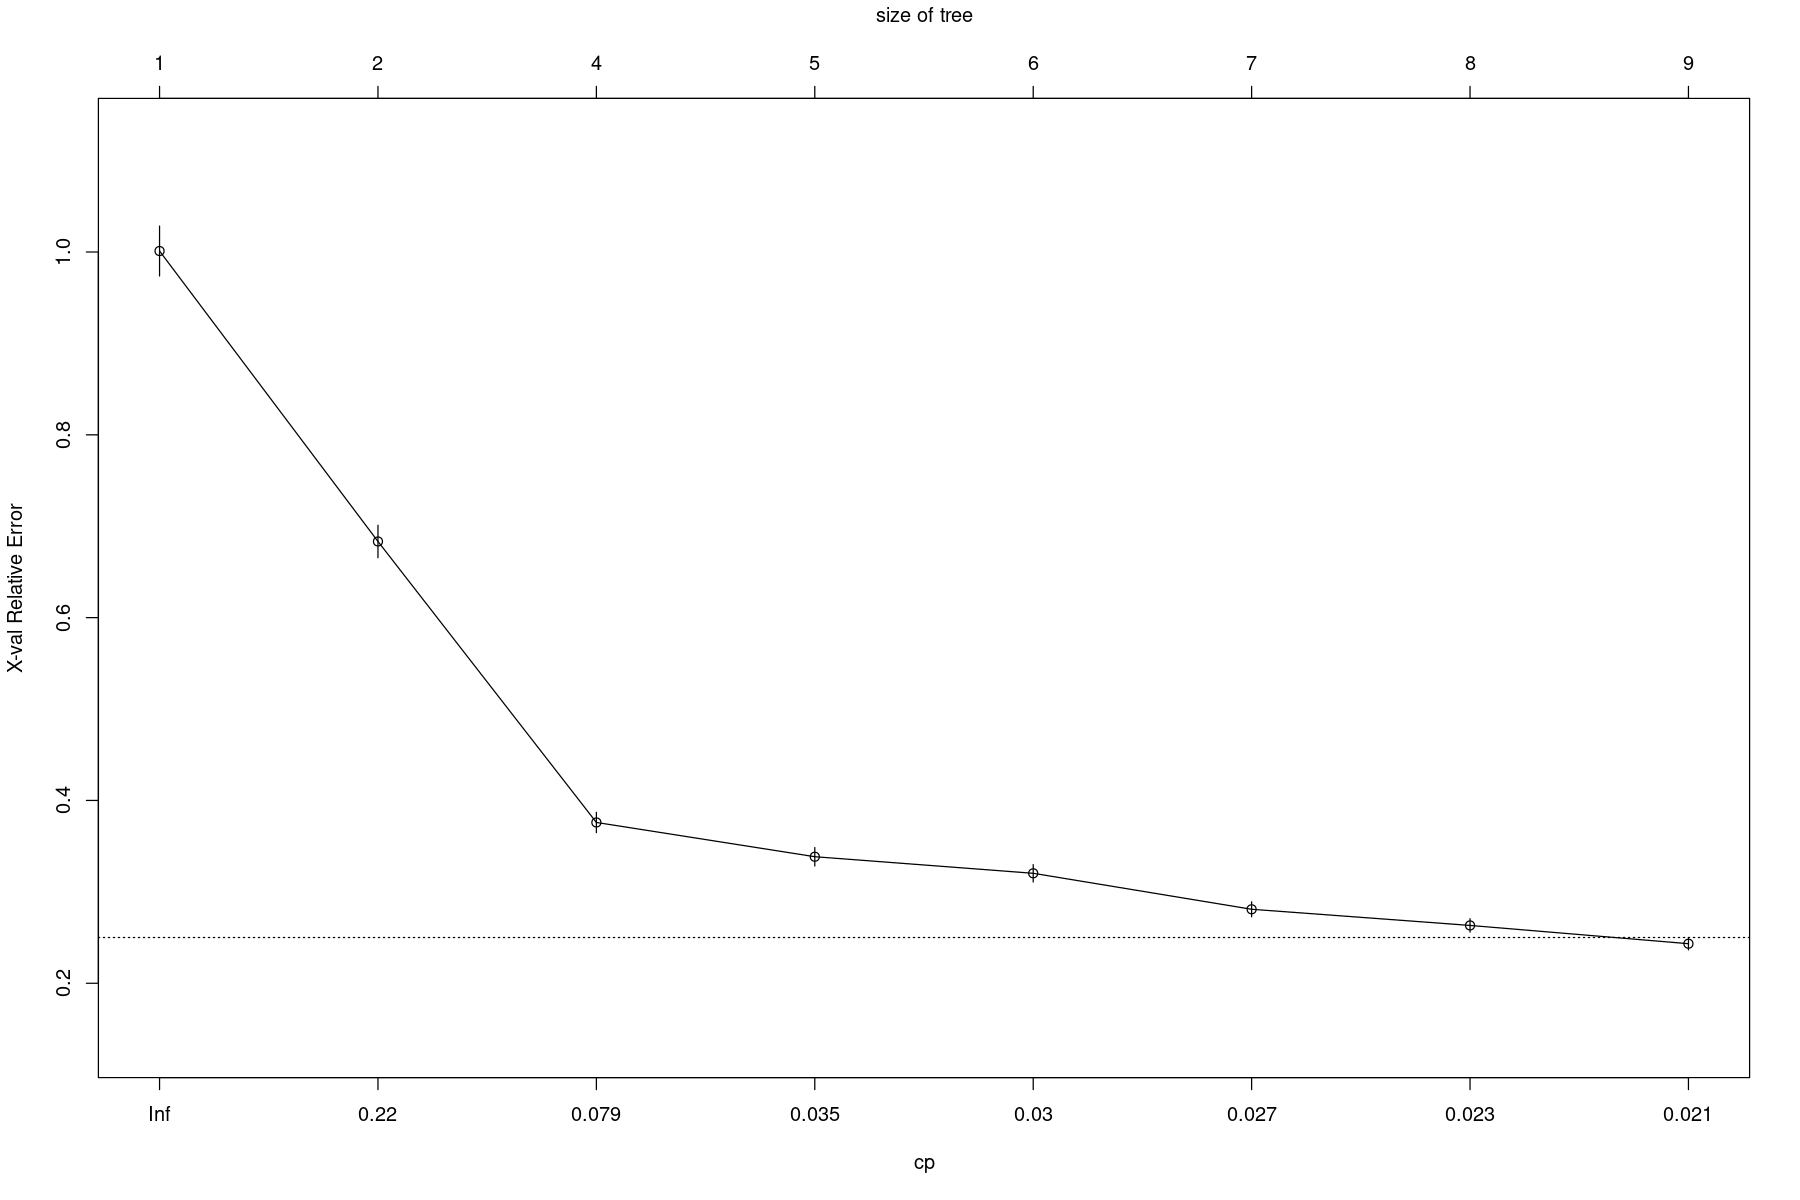

In [185]:
xmat<-xpred.rpart(tree.reg,xval=10) 
# one row for each observation and one column for each complexity value

# Cross-validation error par valeur de CP
CVerr<-apply((xmat-datappr[,"SValue_co2"])^2,2,sum)

plotcp(tree.reg)

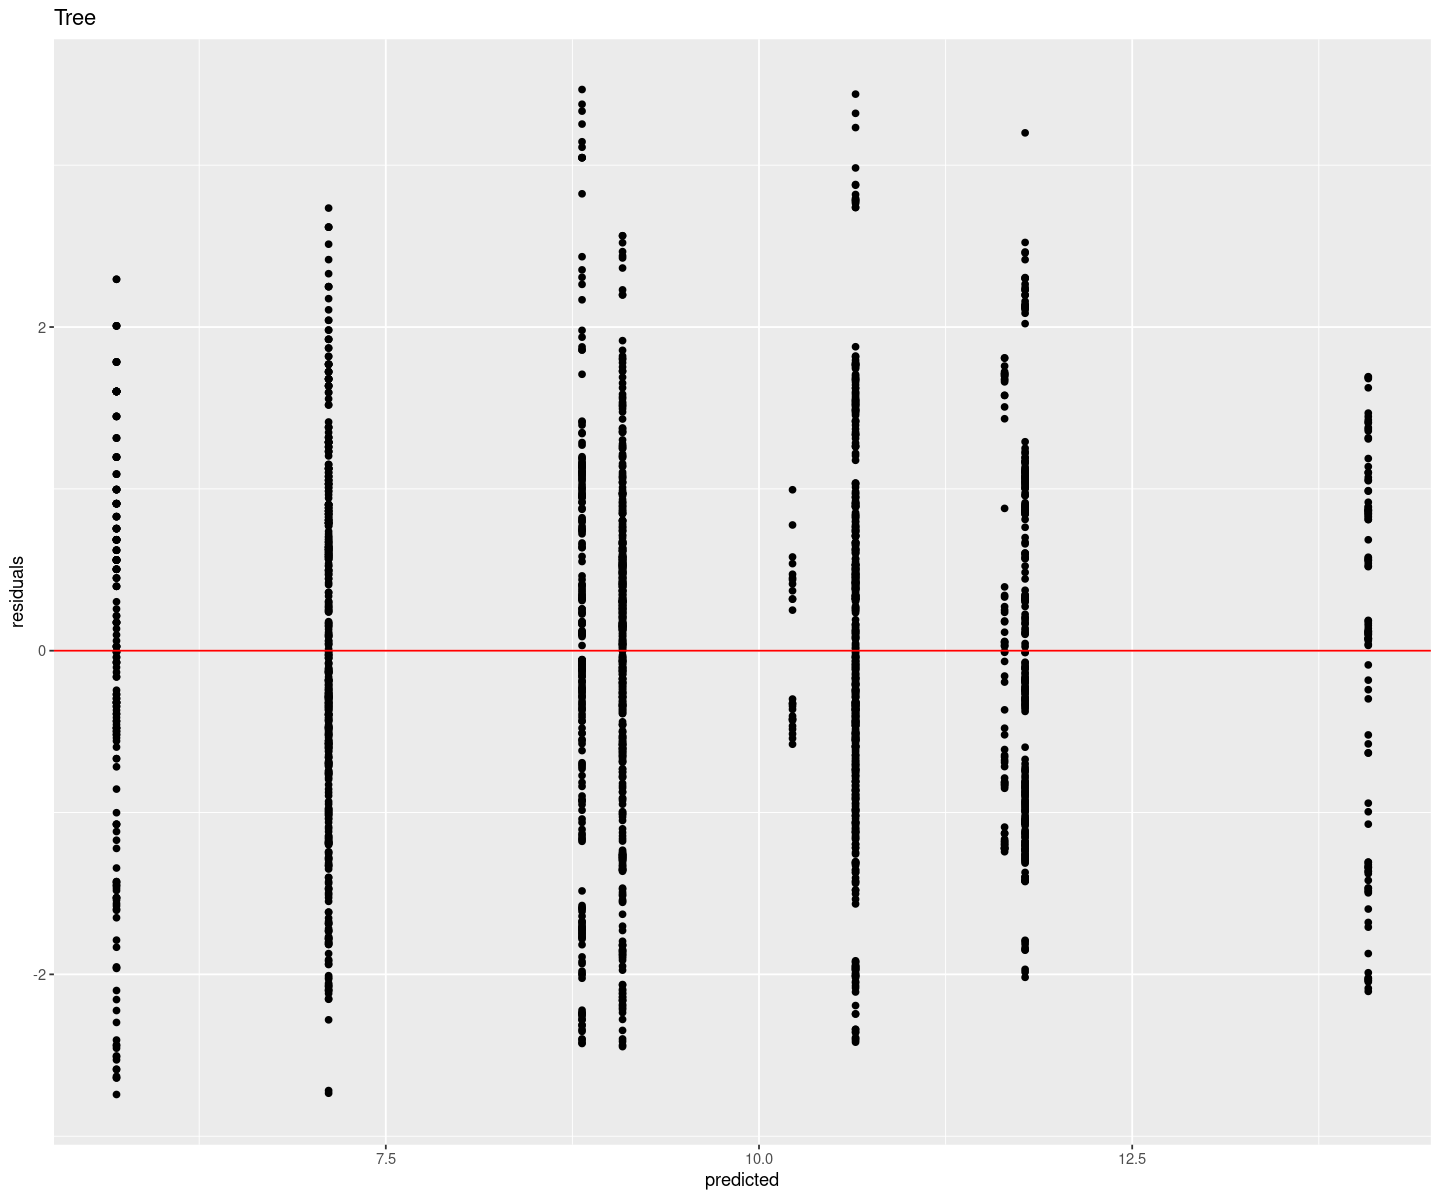

In [187]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"SValue_co2"]

options(repr.plot.width = 12, repr.plot.height = 10)
par(mfrow = c(1, 3))
ggplot(data.frame(residuals = res.tree, predicted = fit.tree), aes(x = predicted, y = residuals)) +
  geom_point() +
  geom_hline(yintercept = 0 ,color = "red") +
  ggtitle("Tree")

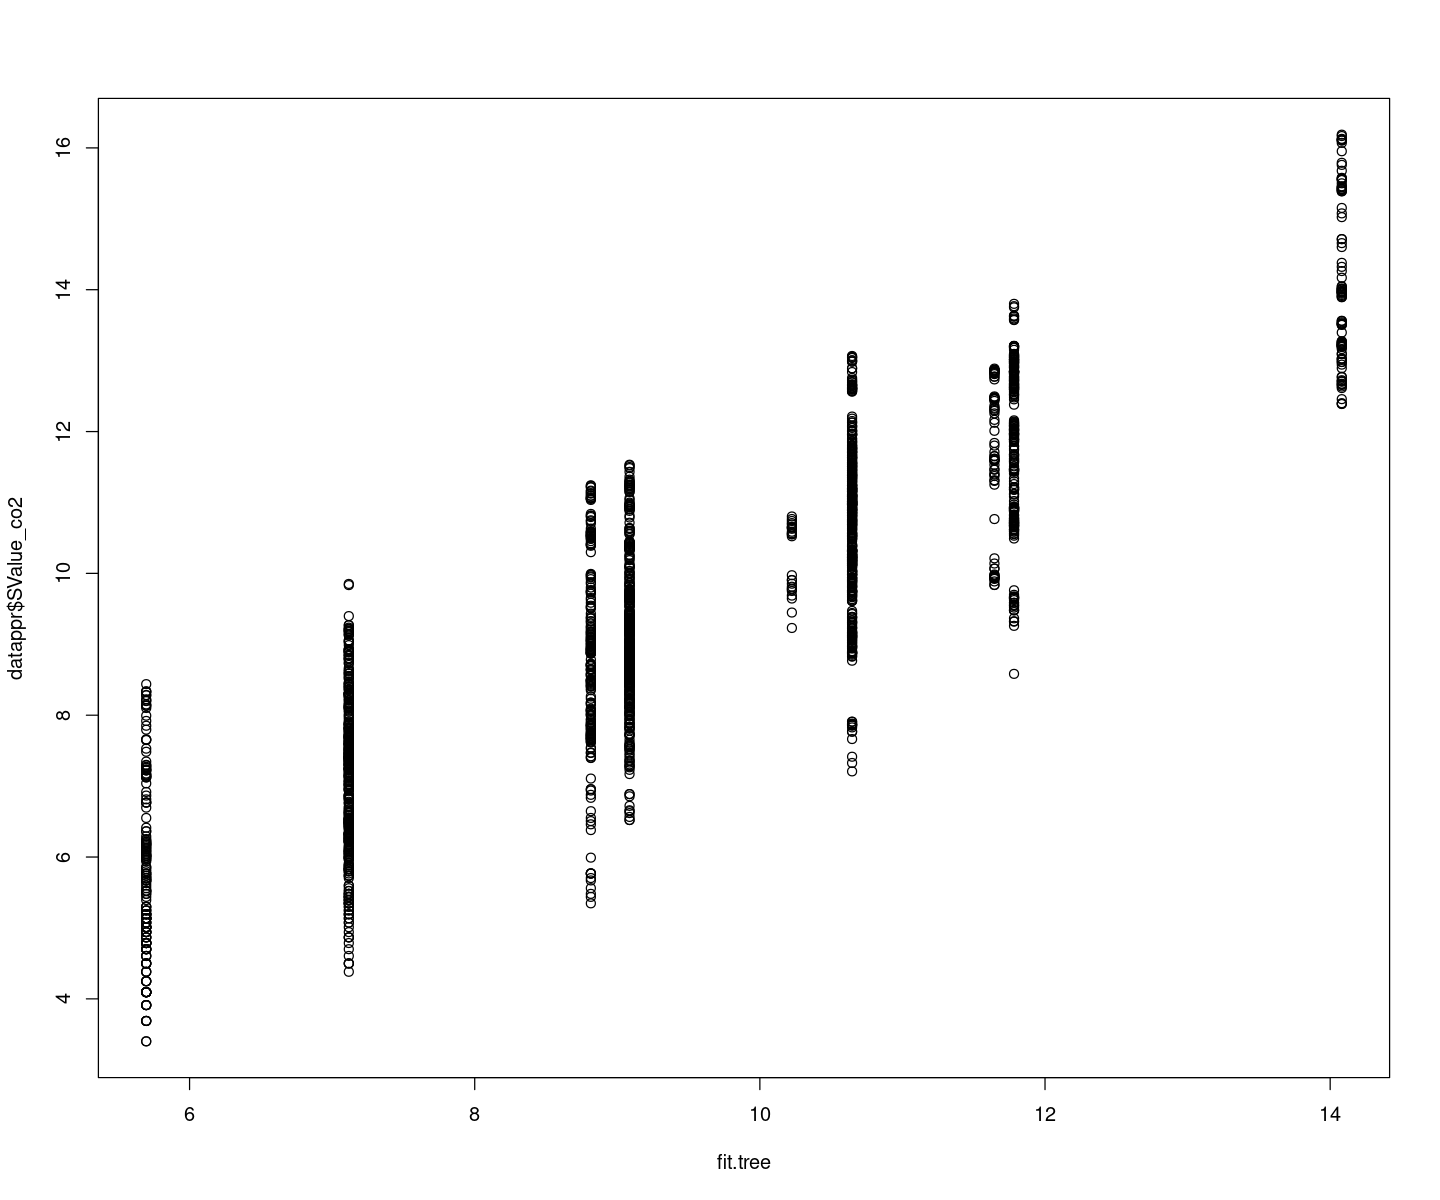

In [188]:
plot(fit.tree,datappr$SValue_co2)

[1] 0.02069784

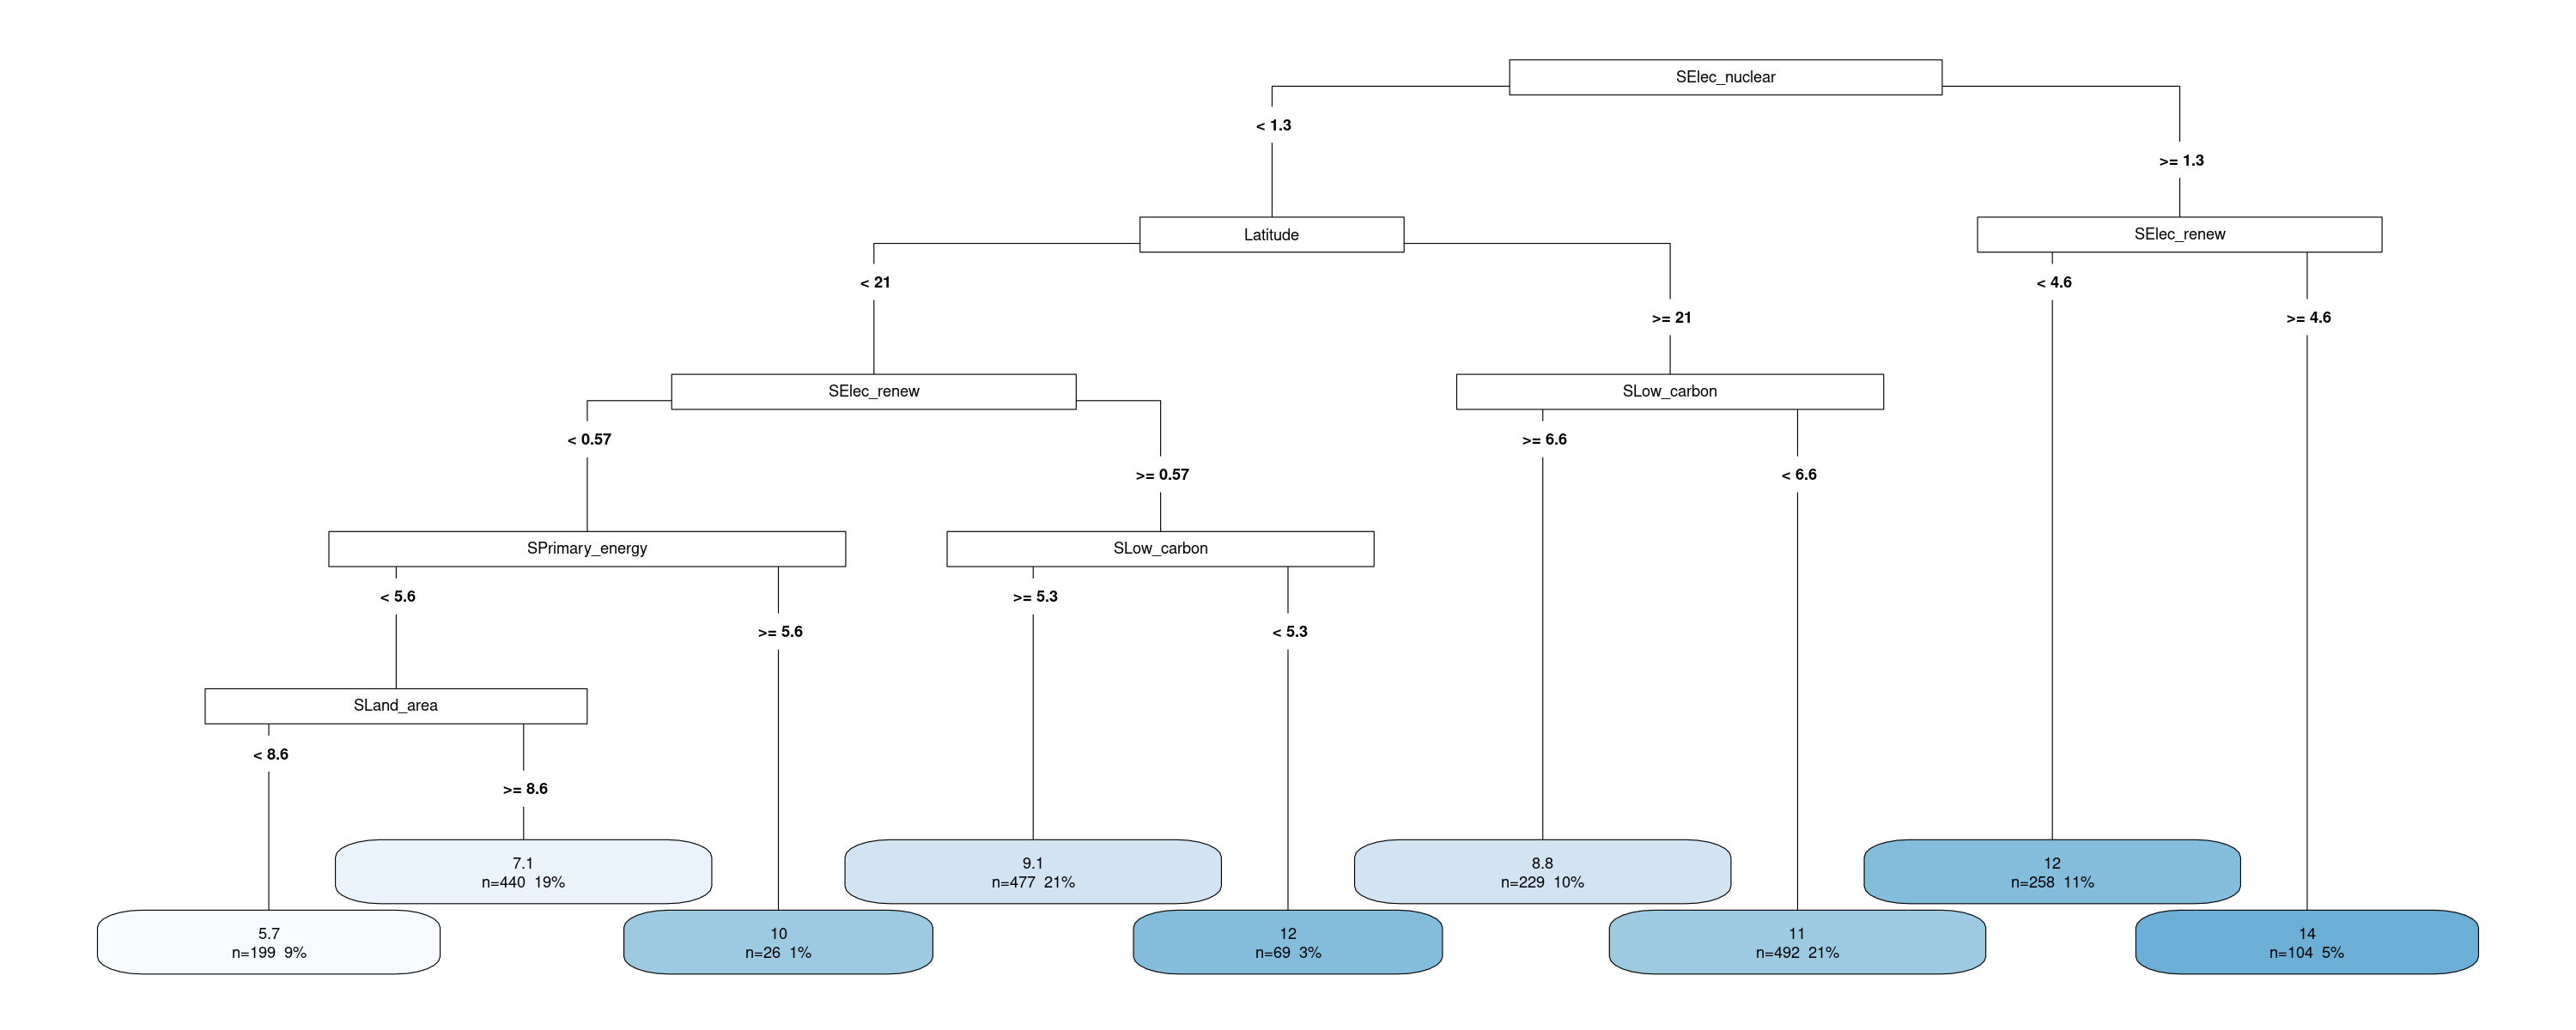

In [186]:
options(repr.plot.width = 25, repr.plot.height = 10)

as.numeric(attributes(which.min(CVerr))$names)
tree.reg=rpart(SValue_co2~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))
rpart.plot(tree.reg,type=5,extra=101)

In [146]:
# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.tree)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_a <- 1 - (SS_Residual / SS_Total)

paste("R2 =", R2_a)

[1] "R2 = 0.989318076343159"

### La méthode Random Forests

mtry = 5  OOB error = 0.03943727 
Searching left ...
mtry = 3 	OOB error = 0.04739029 
-0.2016627 0.05 
Searching right ...
mtry = 10 	OOB error = 0.03930081 
0.003460214 0.05 


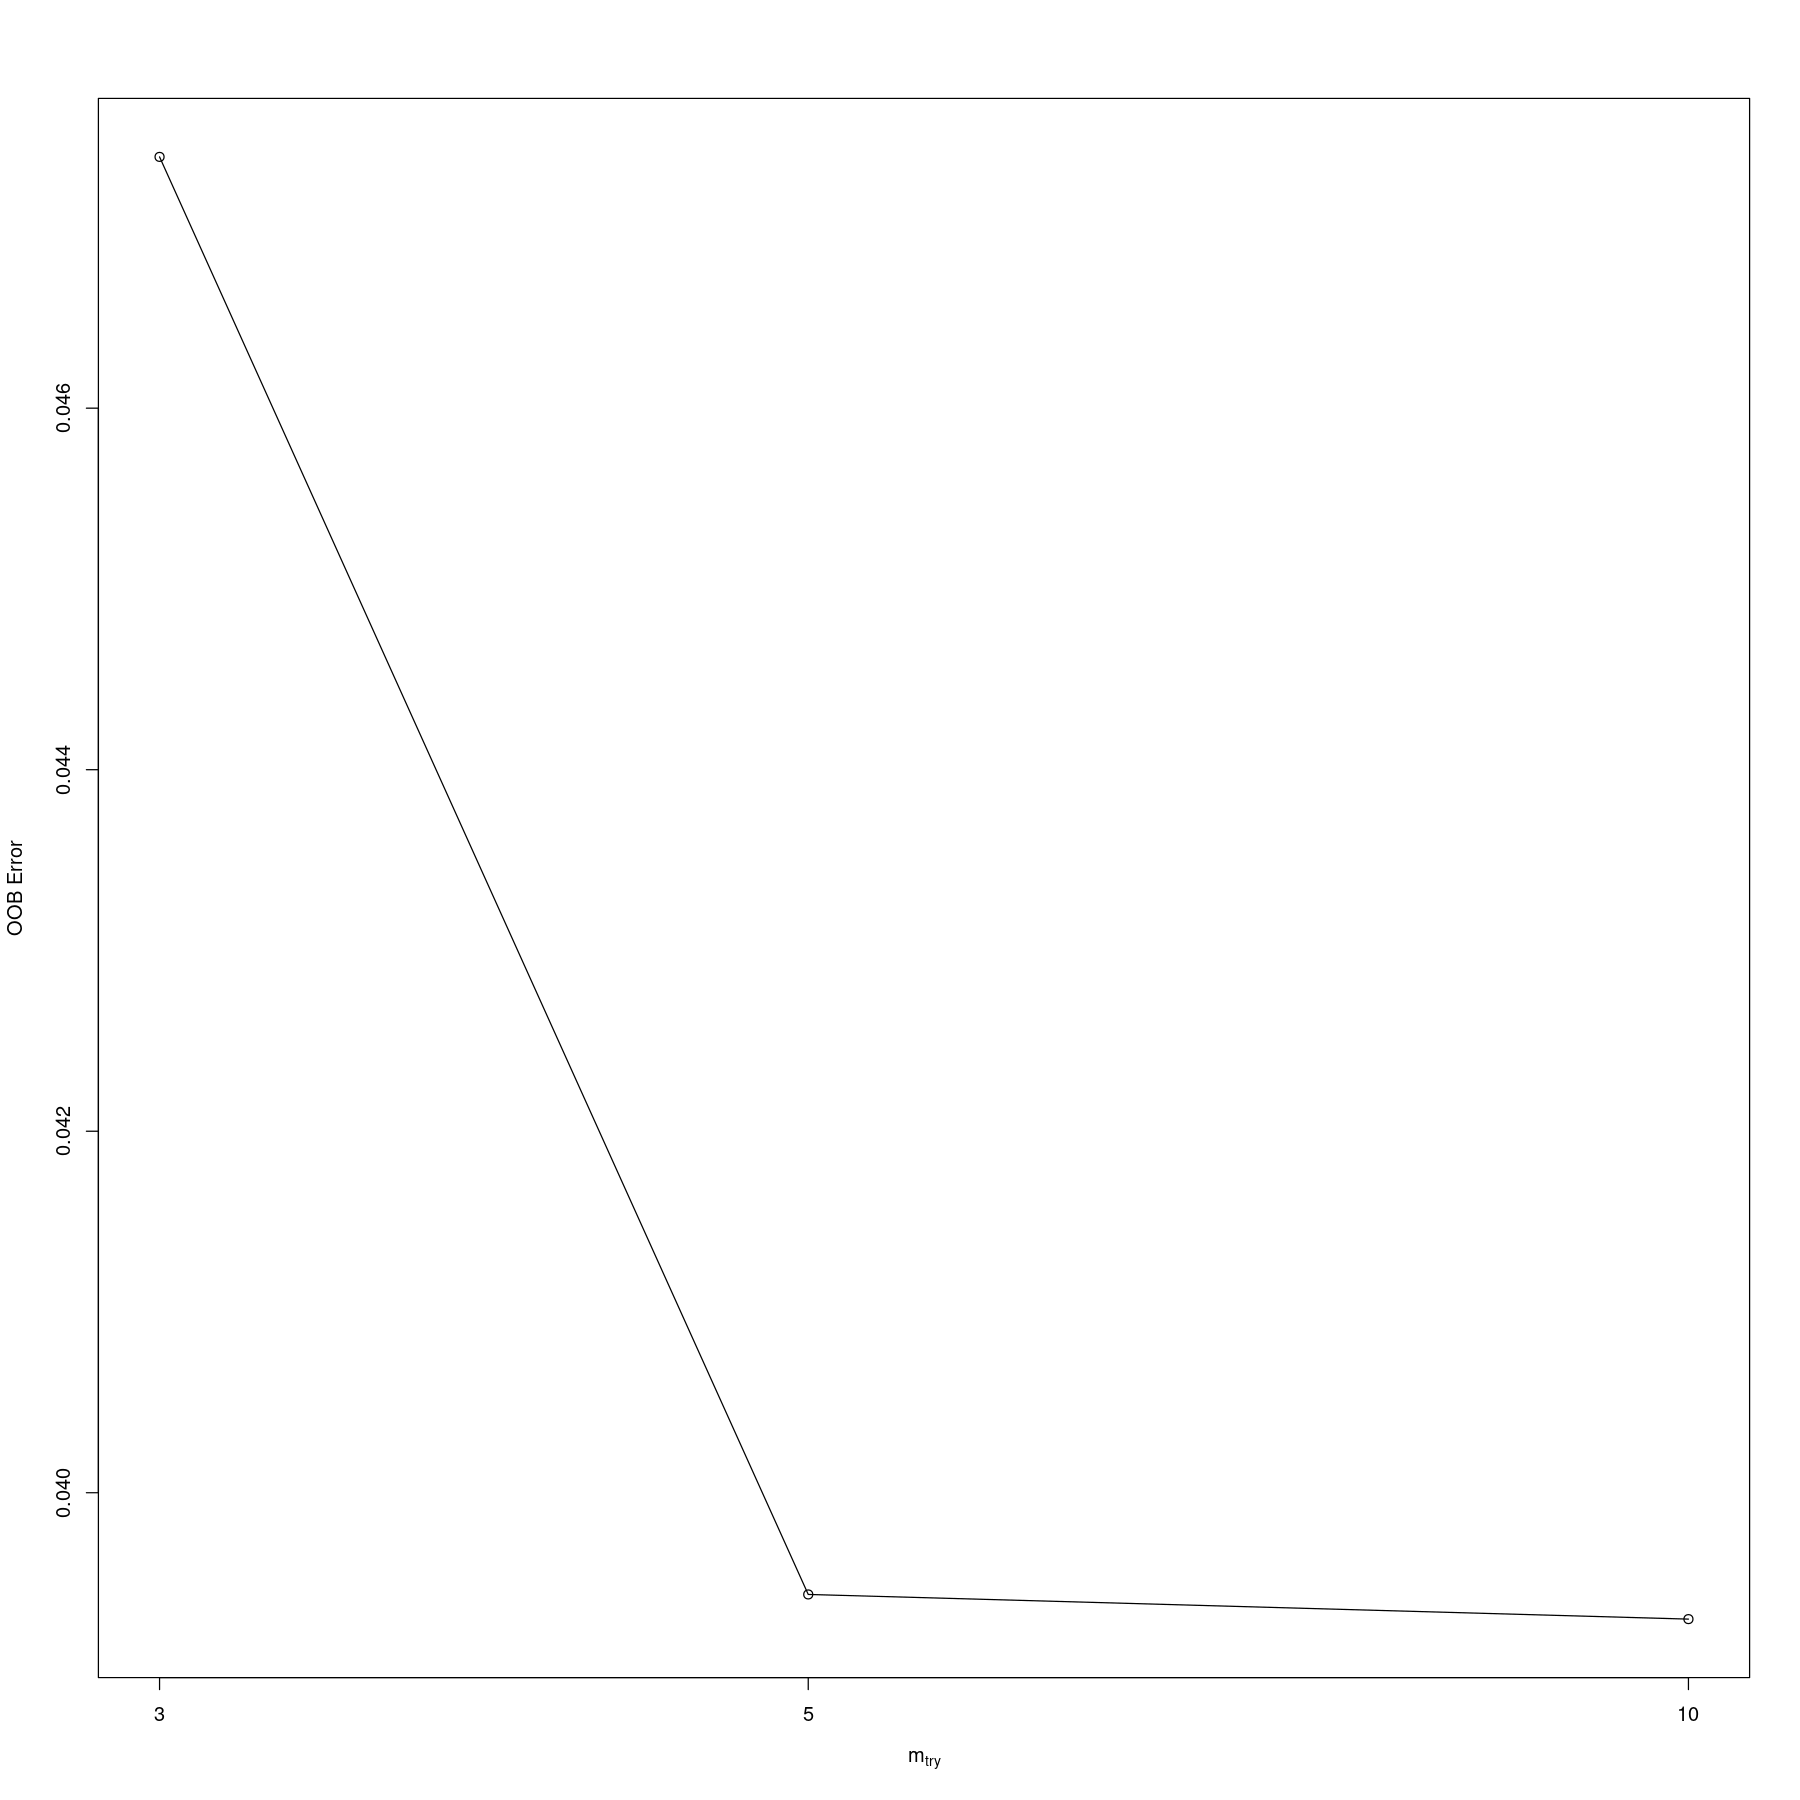

In [233]:
res.rf <- tuneRF(datappr[,-16], datappr[,16])

In [240]:
rf.reg=randomForest(SValue_co2~., data=datappr,ntree=1000,do.trace=50,importance=TRUE,mtry =10)

attributes(rf.reg)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
  50 |  0.03904     0.69 |
 100 |  0.03458     0.61 |
 150 |  0.03324     0.59 |
 200 |  0.03266     0.58 |
 250 |  0.03243     0.58 |
 300 |   0.0317     0.56 |
 350 |  0.03156     0.56 |
 400 |  0.03144     0.56 |
 450 |  0.03129     0.56 |
 500 |  0.03151     0.56 |
 550 |  0.03155     0.56 |
 600 |  0.03137     0.56 |
 650 |  0.03127     0.56 |
 700 |  0.03124     0.55 |
 750 |  0.03108     0.55 |
 800 |   0.0309     0.55 |
 850 |  0.03086     0.55 |
 900 |  0.03077     0.55 |
 950 |  0.03072     0.55 |
1000 |  0.03068     0.54 |


$names
 [1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

In [241]:
rf.reg


Call:
 randomForest(formula = SValue_co2 ~ ., data = datappr, ntree = 1000,      do.trace = 50, importance = TRUE, mtry = 10) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 10

          Mean of squared residuals: 0.03068091
                    % Var explained: 99.46

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


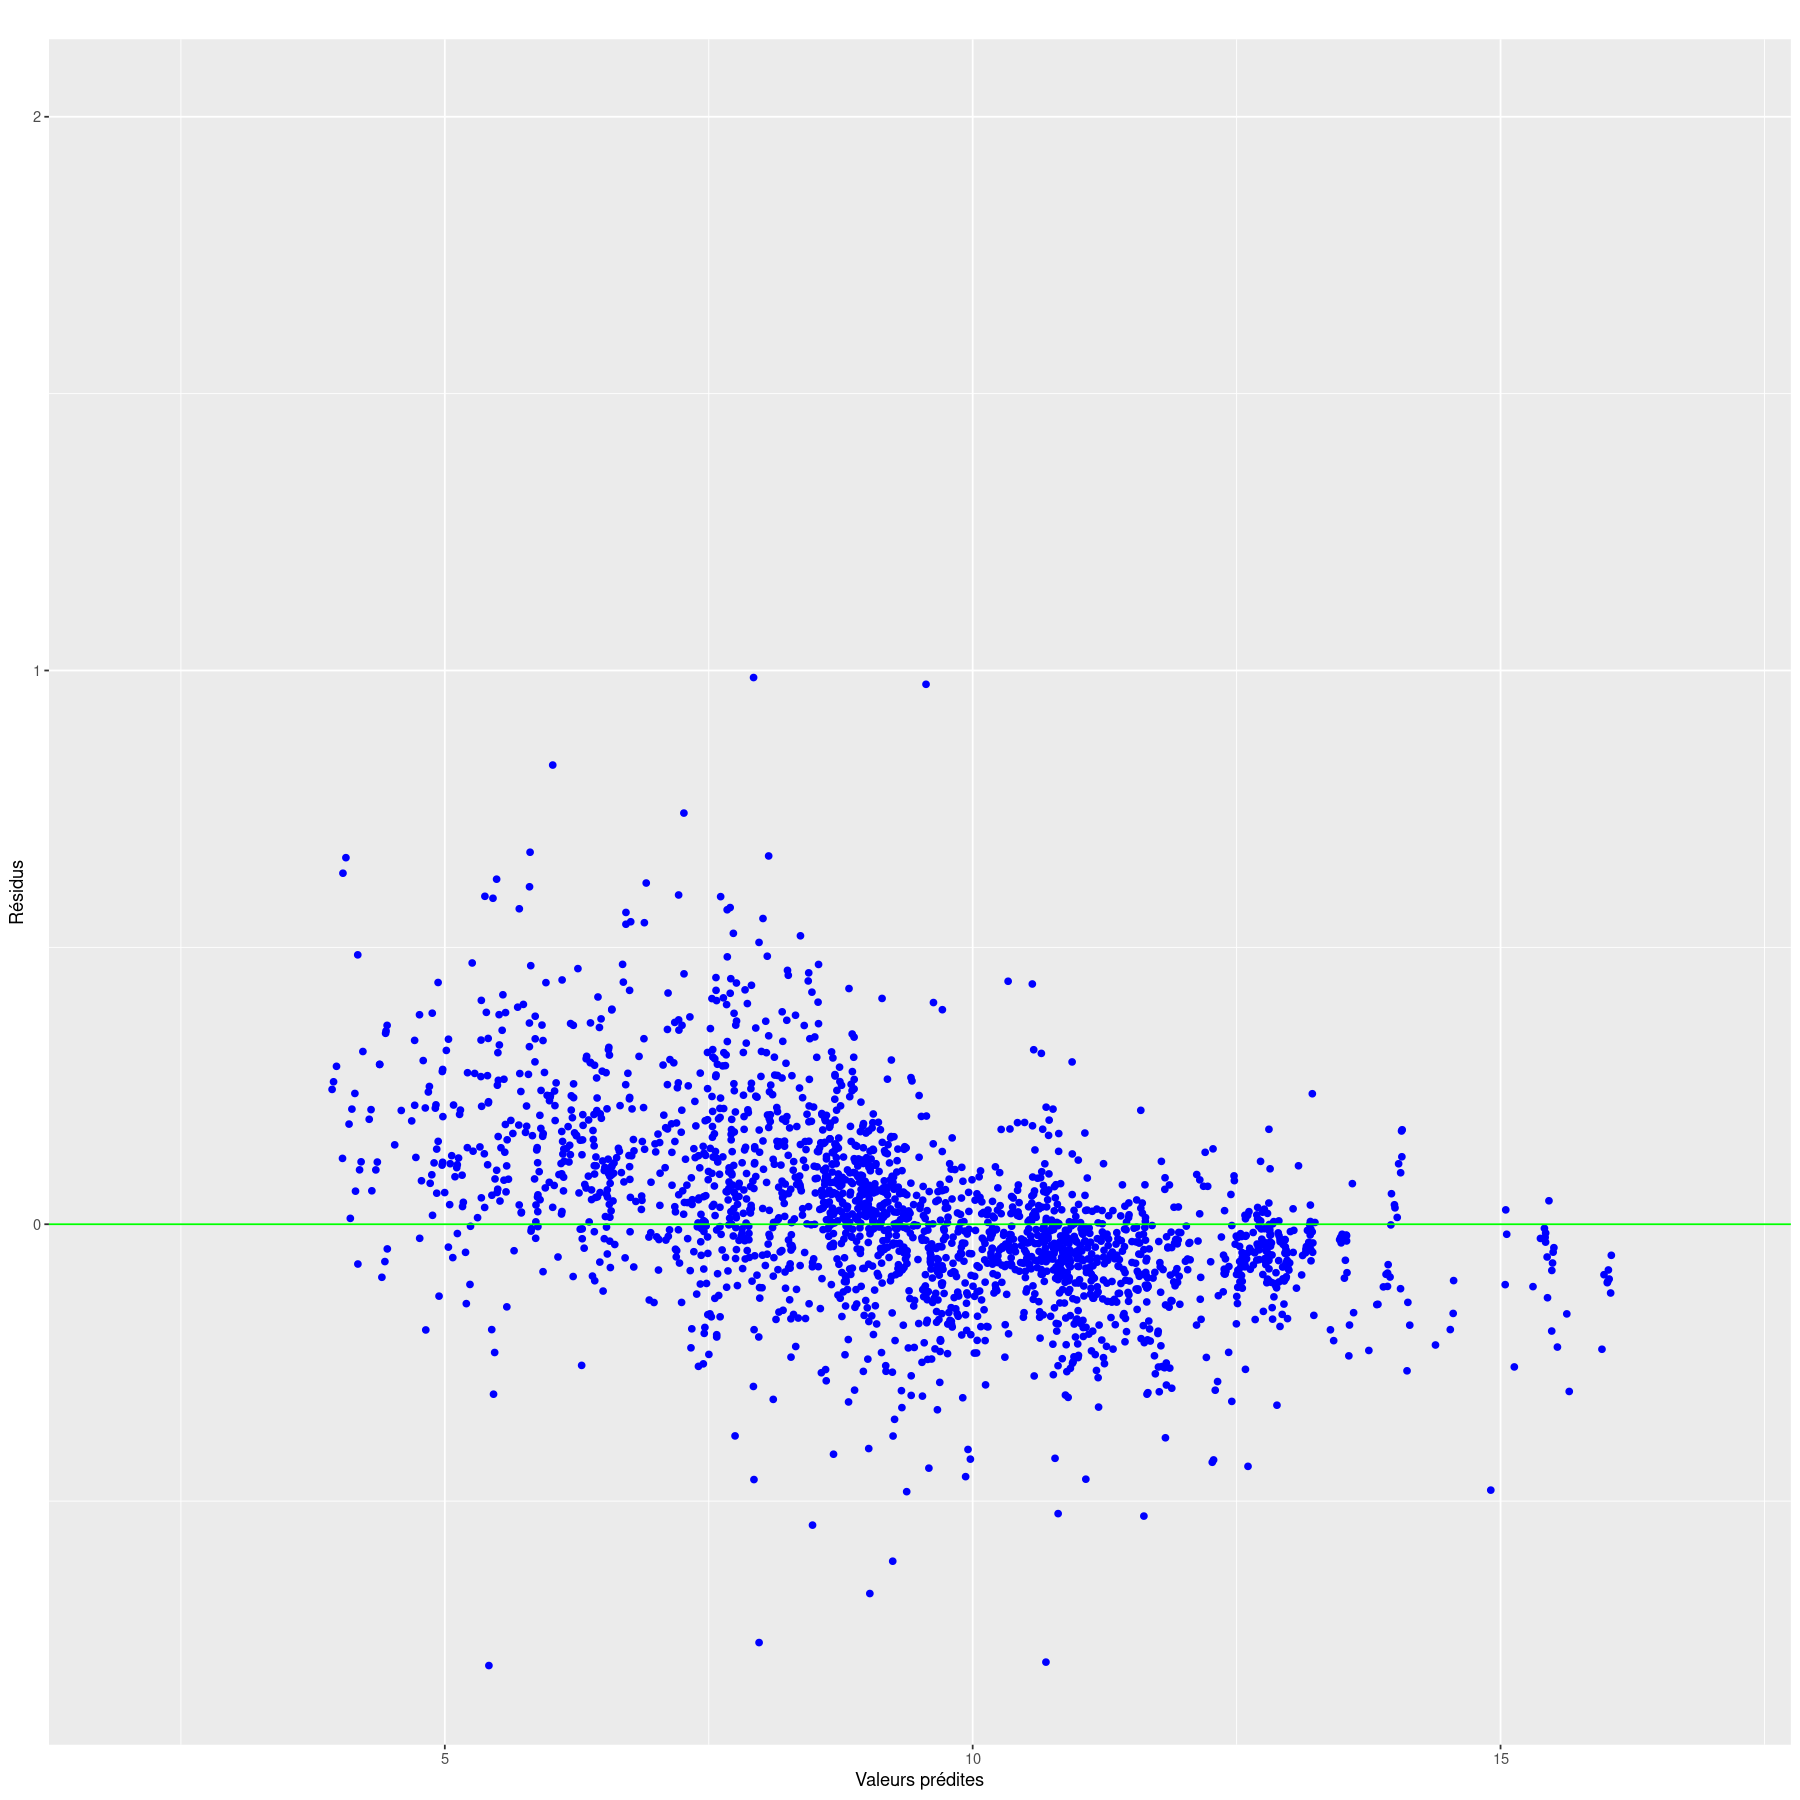

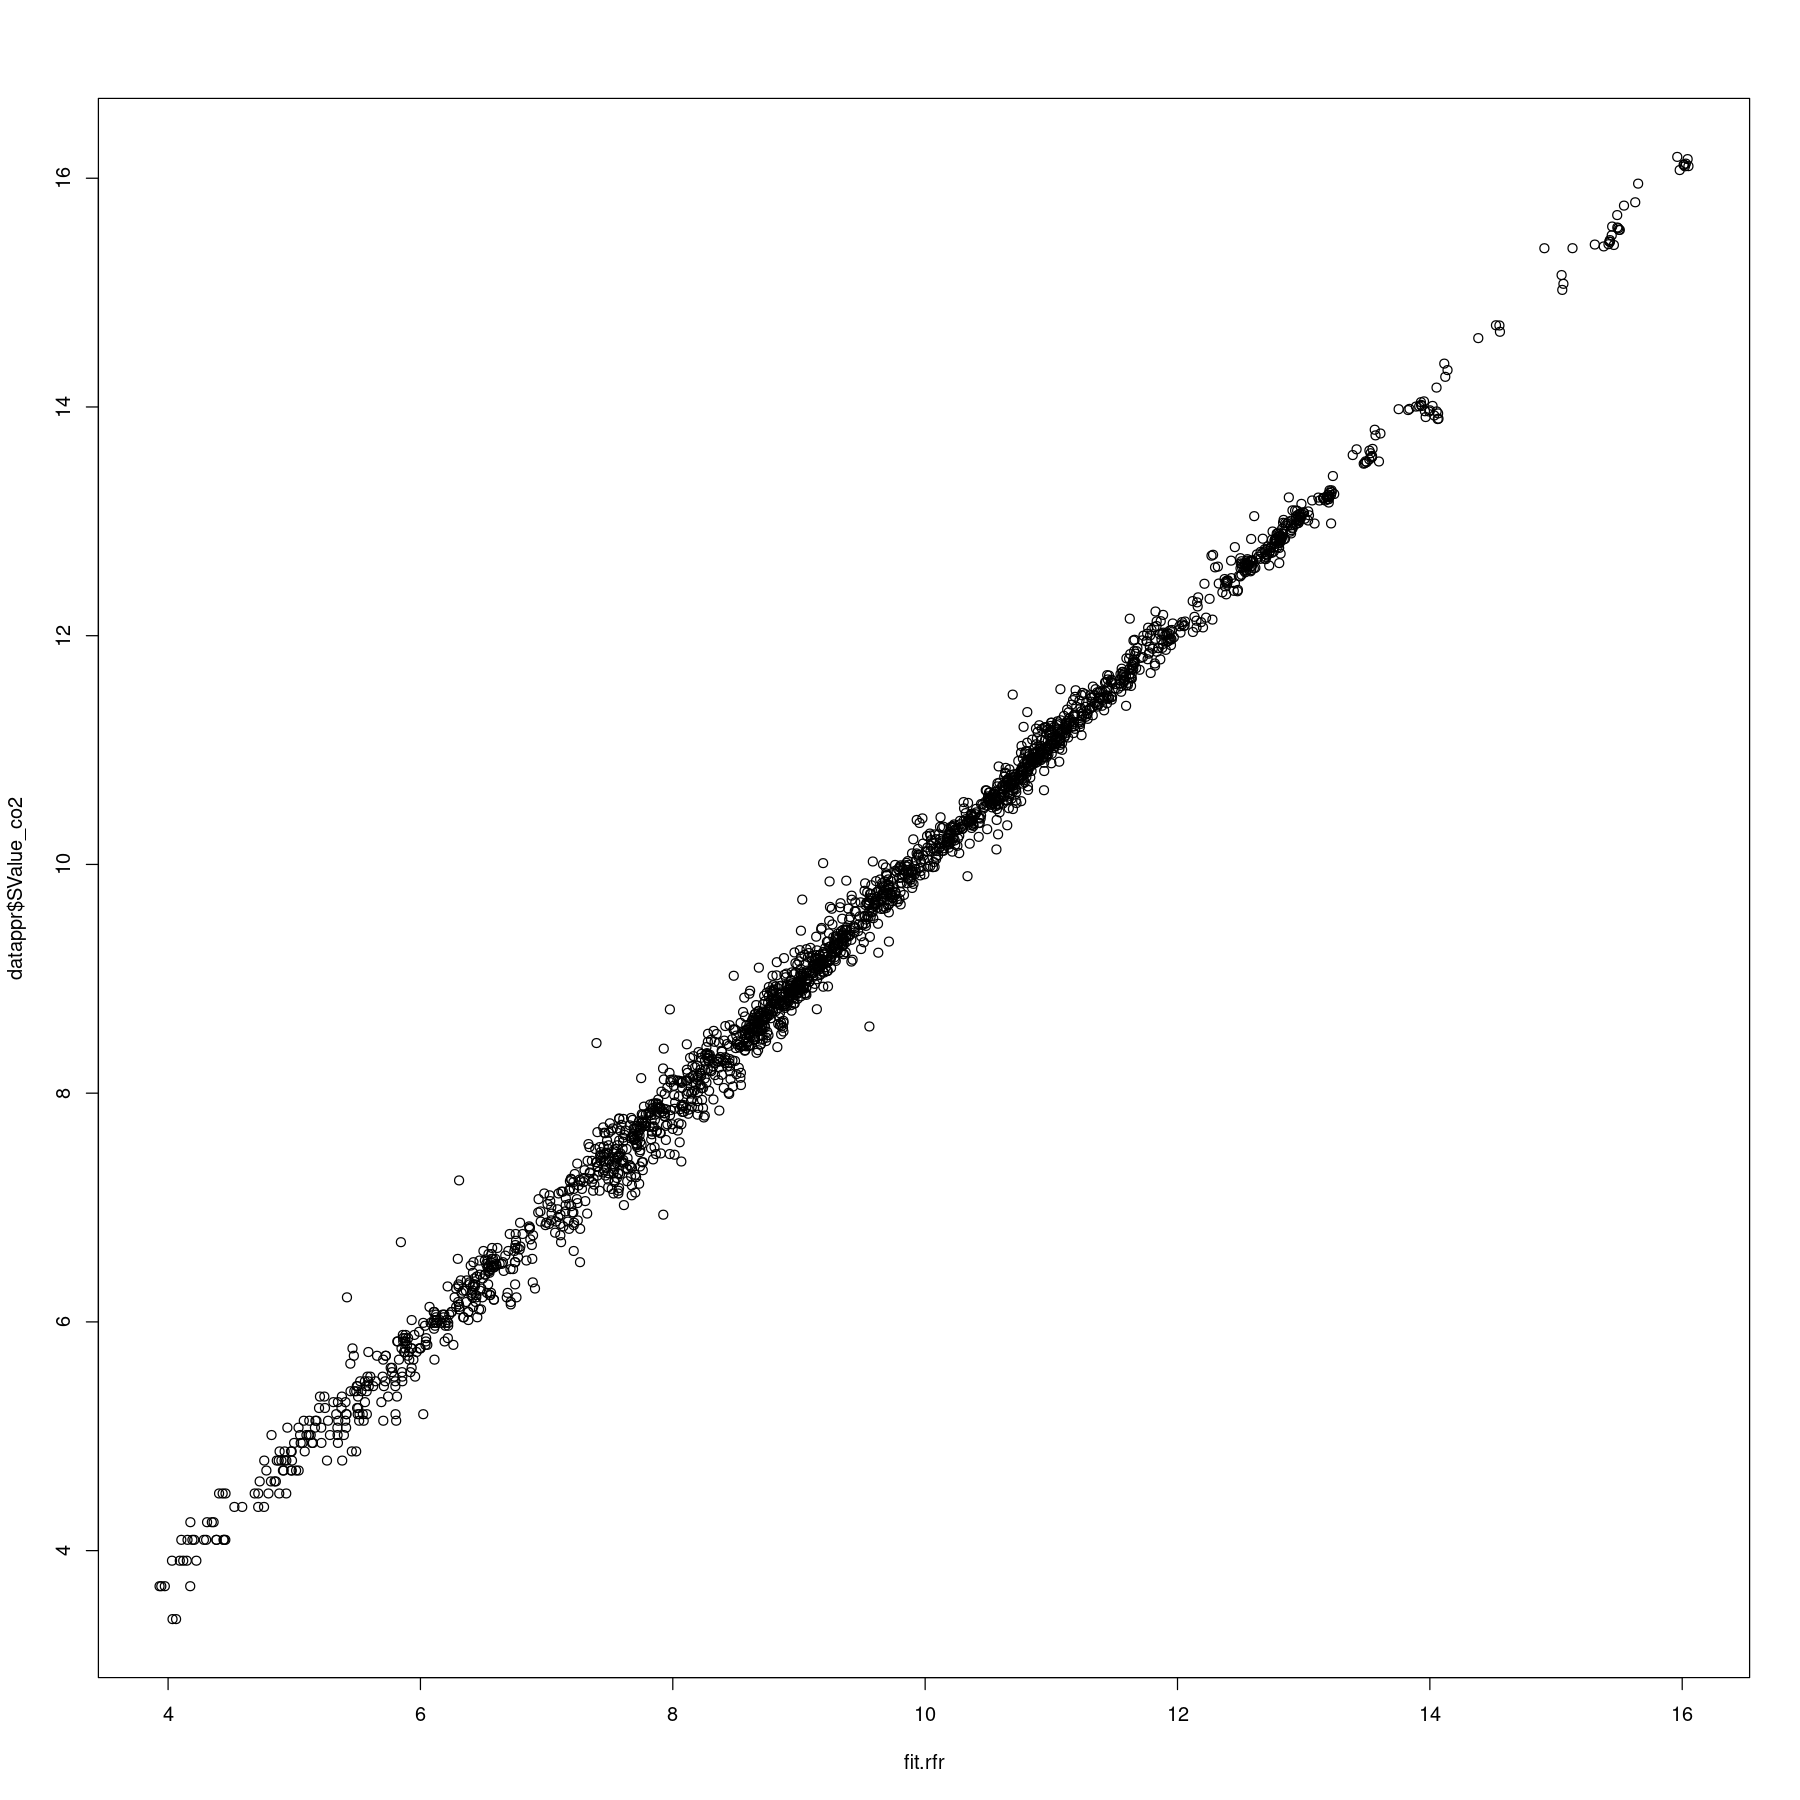

In [242]:
fit.rfr=rf.reg$predicted
res.rfr=fit.rfr-datappr[,"SValue_co2"]
gplot.res(fit.rfr,res.rfr,titre="")
plot(fit.rfr,datappr$SValue_co2)

In [243]:
# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.rfr)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_rf <- 1 - (SS_Residual / SS_Total)

paste("R2 =", R2_rf)

[1] "R2 = 0.994550350323872"

In [244]:
varImpPlot(rf.reg)

### La méthode du Boosting

In [200]:
library(caret)

# Hyperparamètres à tester
param_grid <- expand.grid( shrinkage = c(0.01,0.1), n.minobsinnode = 10 ,n.trees = c(200,500,1000),interaction.depth = 10)

# Contrôle de la validation croisée
train_control <- trainControl(
  method = "cv",      # Utiliser la validation croisée
  number = 10          # Nombre de folds
)

model <- train(
  SValue_co2 ~ .,
  data = datappr,
  method = "gbm",
  trControl = train_control,
  tuneGrid = param_grid,
  verbose = FALSE
)

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 20: Year2020 has no variation.”
Warning message in (function (x, y, offset = NUL

In [201]:
print(model$bestTune)

  n.trees interaction.depth shrinkage n.minobsinnode
6    1000                10       0.1             10


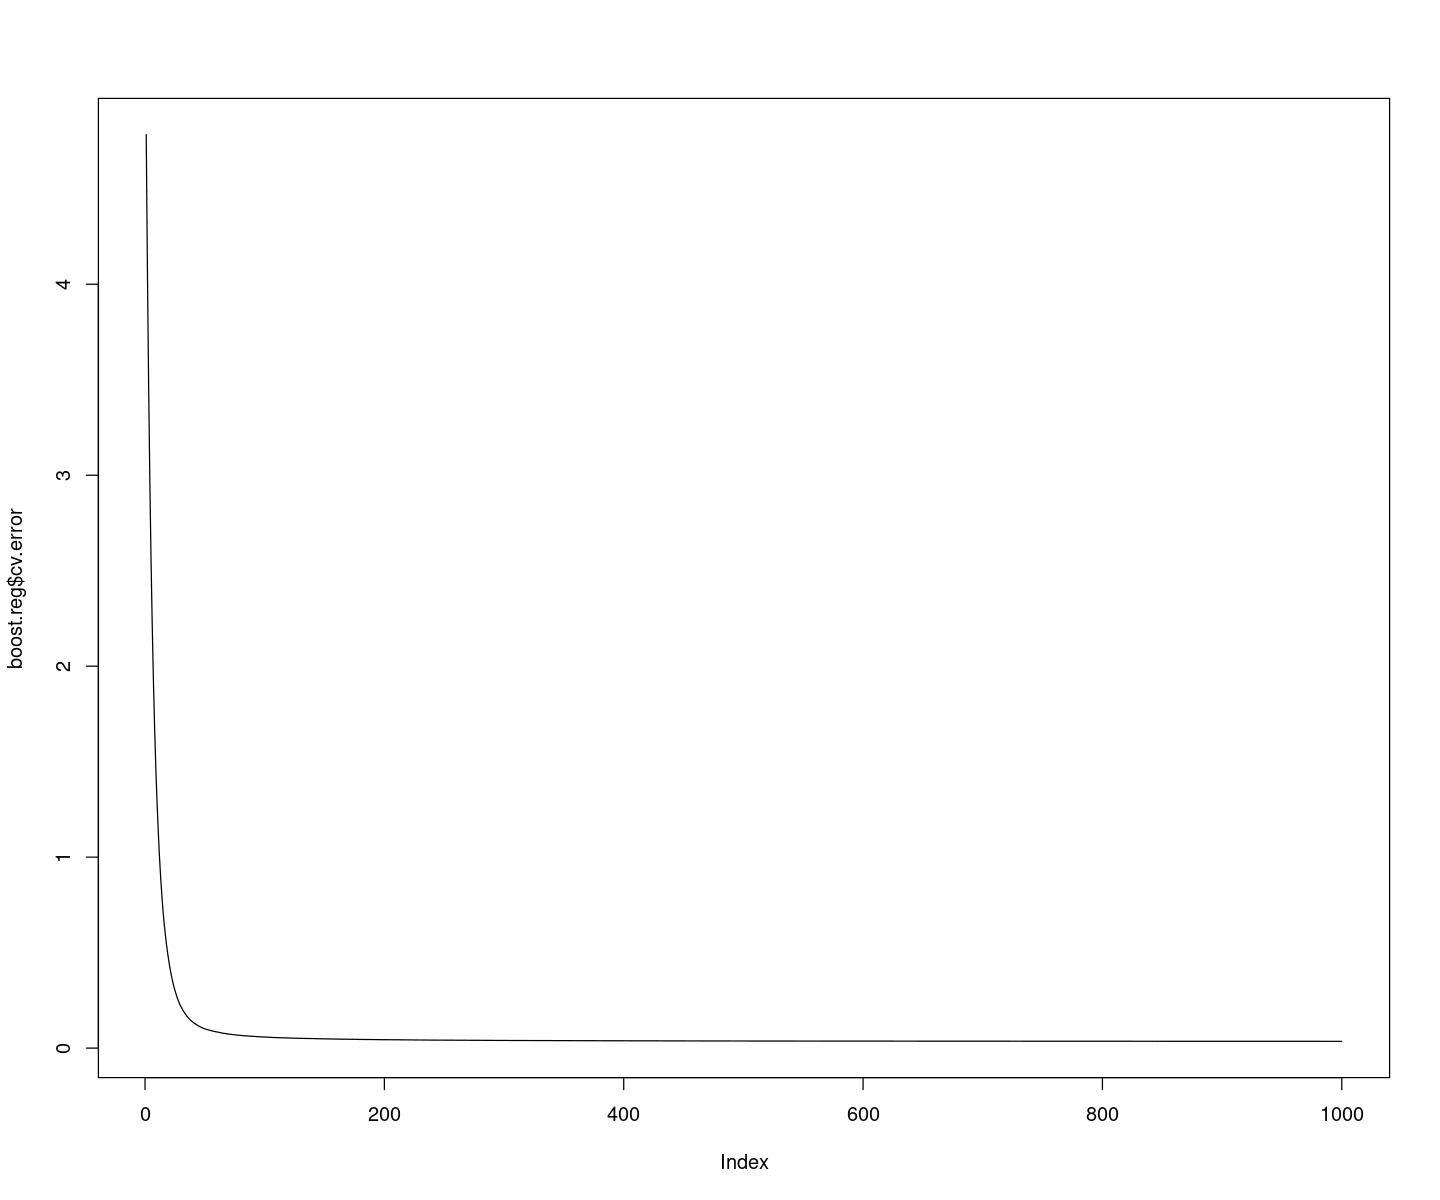

In [202]:
boost.reg = gbm(SValue_co2 ~ ., data = datappr, distribution = "gaussian", n.trees = model$bestTune$n.trees, 
    cv.folds = 10,interaction.depth = model$bestTune$interaction.depth, n.minobsinnode = model$bestTune$n.minobsinnode, shrinkage = model$bestTune$shrinkage, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error, type = "l")

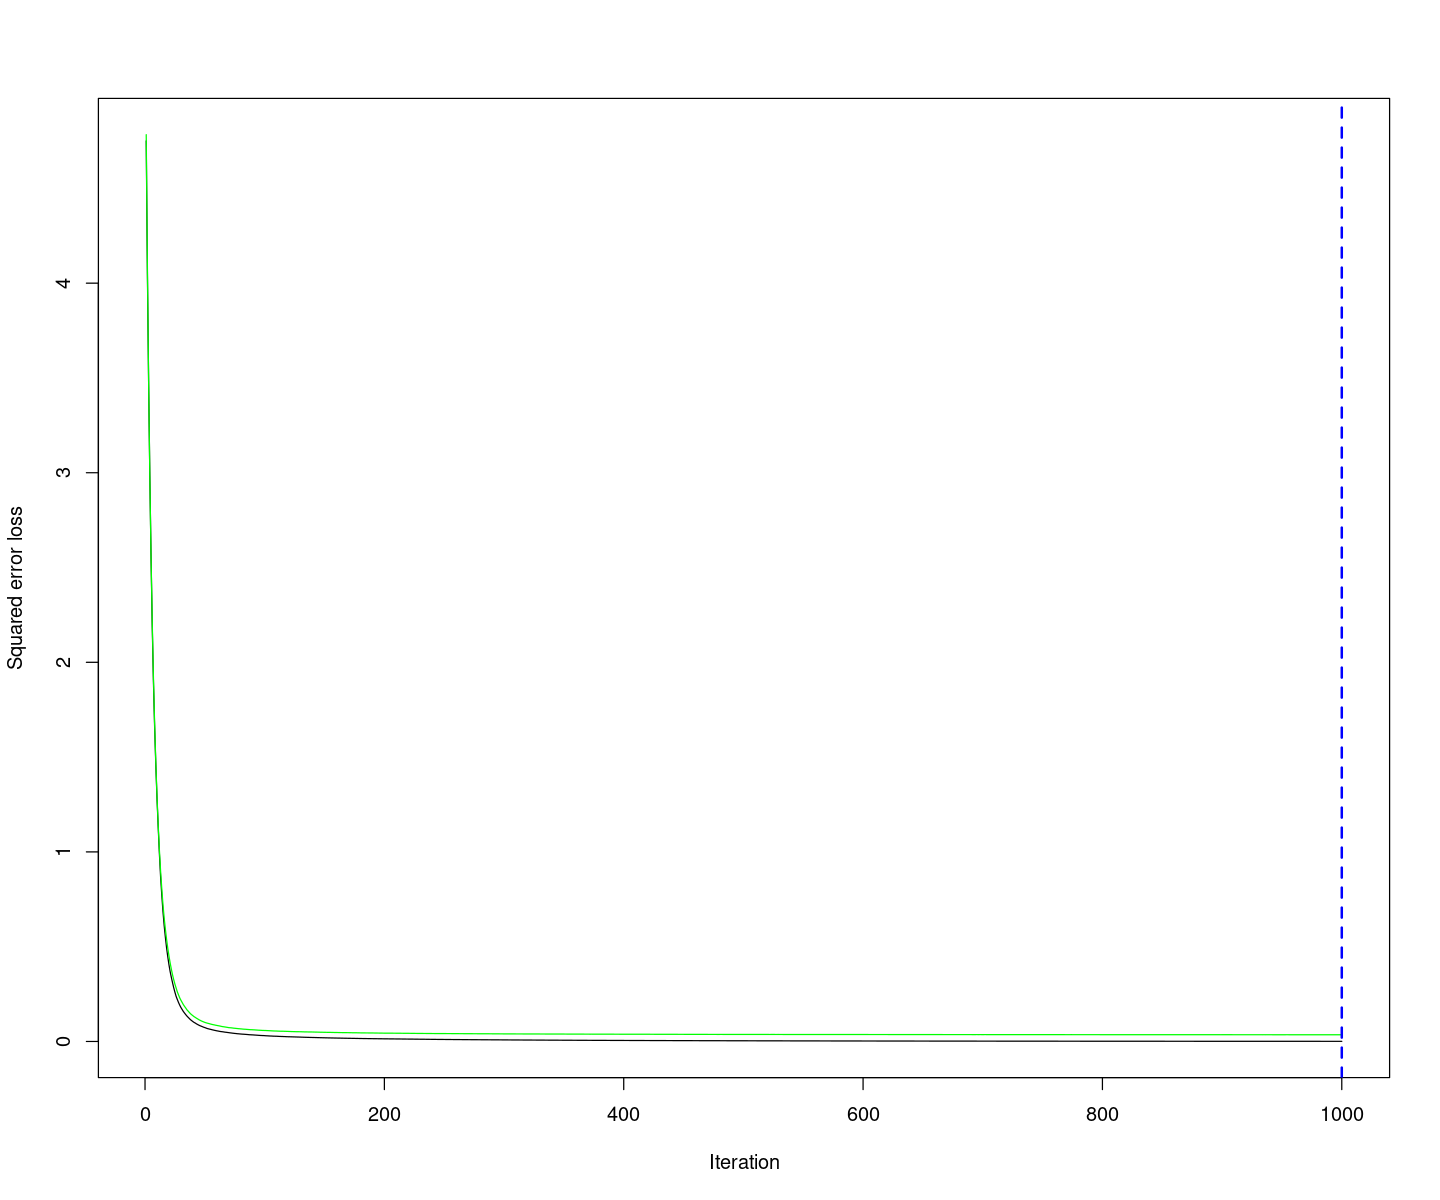

In [203]:
best.iter=gbm.perf(boost.reg,method="cv")

In [204]:
fit.boo=boost.reg$fit
res.boo=fit.boo-datappr[,"SValue_co2"]
gplot.res(fit.boo,res.boo,titre="")

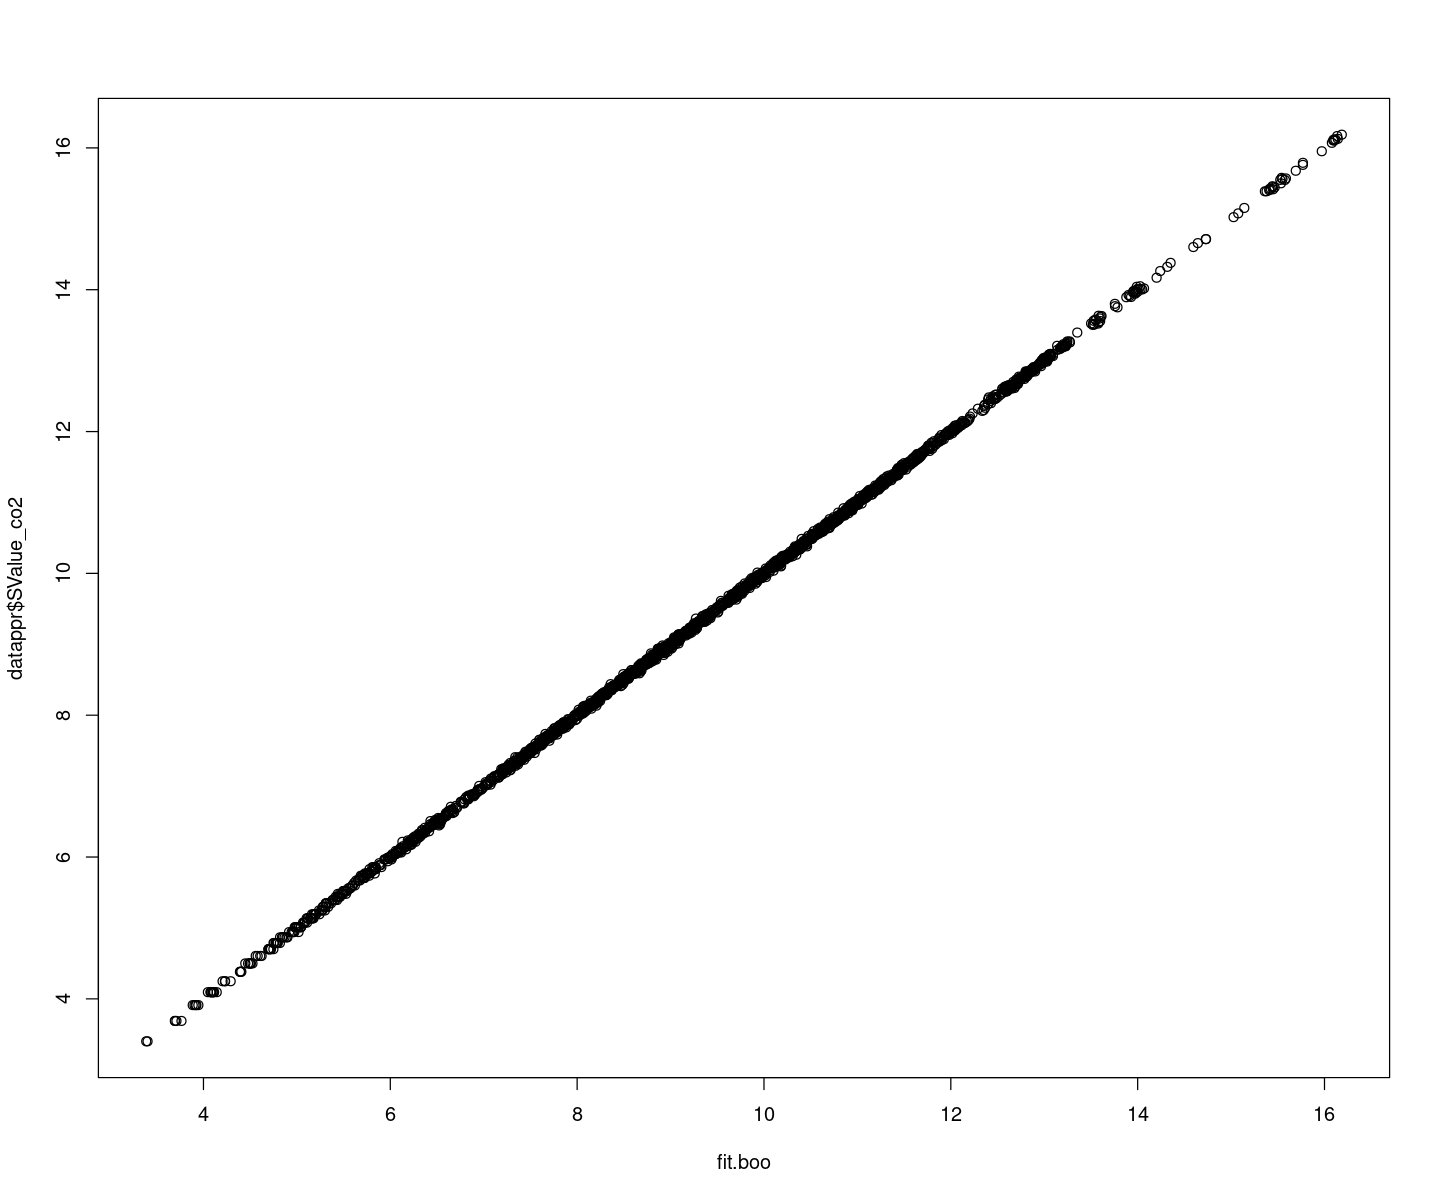

In [205]:
plot(fit.boo,datappr$SValue_co2)

In [206]:
summary.gbm(boost.reg)

var               rel.inf   
SElec_renew       SElec_renew       33.4900960
SElec_nuclear     SElec_nuclear     13.7141123
Latitude          Latitude          13.2859224
SLand_area        SLand_area        10.4659627
SLow_carbon       SLow_carbon        8.6713910
SRenewable_energy SRenewable_energy  7.3653823
SPrimary_energy   SPrimary_energy    3.6894315
SDensity          SDensity           2.5306592
Sgdp_capita       Sgdp_capita        2.0927593
SAccess_elec      SAccess_elec       1.4524796
SAccess_fuels     SAccess_fuels      1.2495305
Longitude         Longitude          1.0932276
Year              Year               0.4932647
SEnergy_intensity SEnergy_intensity  0.2687335
gdp_growth        gdp_growth         0.1370475

In [207]:
# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.boo)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_boo <- 1 - (SS_Residual / SS_Total)

paste("R2 =", R2_boo)

[1] "R2 = 0.999880591426135"

### Les Réseaux de Neurones

In [209]:
nnet.reg=nnet(SValue_co2~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500,verbose = FALSE) 

# weights:  181
initial  value 203982.283050 
iter  10 value 11795.952065
iter  20 value 10407.030362
iter  30 value 8846.157600
iter  40 value 5246.484002
iter  50 value 4185.369896
iter  60 value 3246.006161
iter  70 value 2548.119390
iter  80 value 2147.072942
iter  90 value 1817.816245
iter 100 value 1442.796942
iter 110 value 1258.894358
iter 120 value 1073.725881
iter 130 value 828.140315
iter 140 value 633.931029
iter 150 value 545.237032
iter 160 value 505.047201
iter 170 value 471.261079
iter 180 value 448.180474
iter 190 value 443.685895
iter 200 value 436.561734
iter 210 value 428.052458
iter 220 value 423.345684
iter 230 value 417.090985
iter 240 value 411.087974
iter 250 value 408.185839
iter 260 value 405.699559
iter 270 value 403.151563
iter 280 value 396.880562
iter 290 value 388.022592
iter 300 value 379.319873
iter 310 value 376.182807
iter 320 value 374.743249
iter 330 value 373.270176
iter 340 value 372.585151
iter 350 value 370.135884
iter 360 value 366.754634
iter

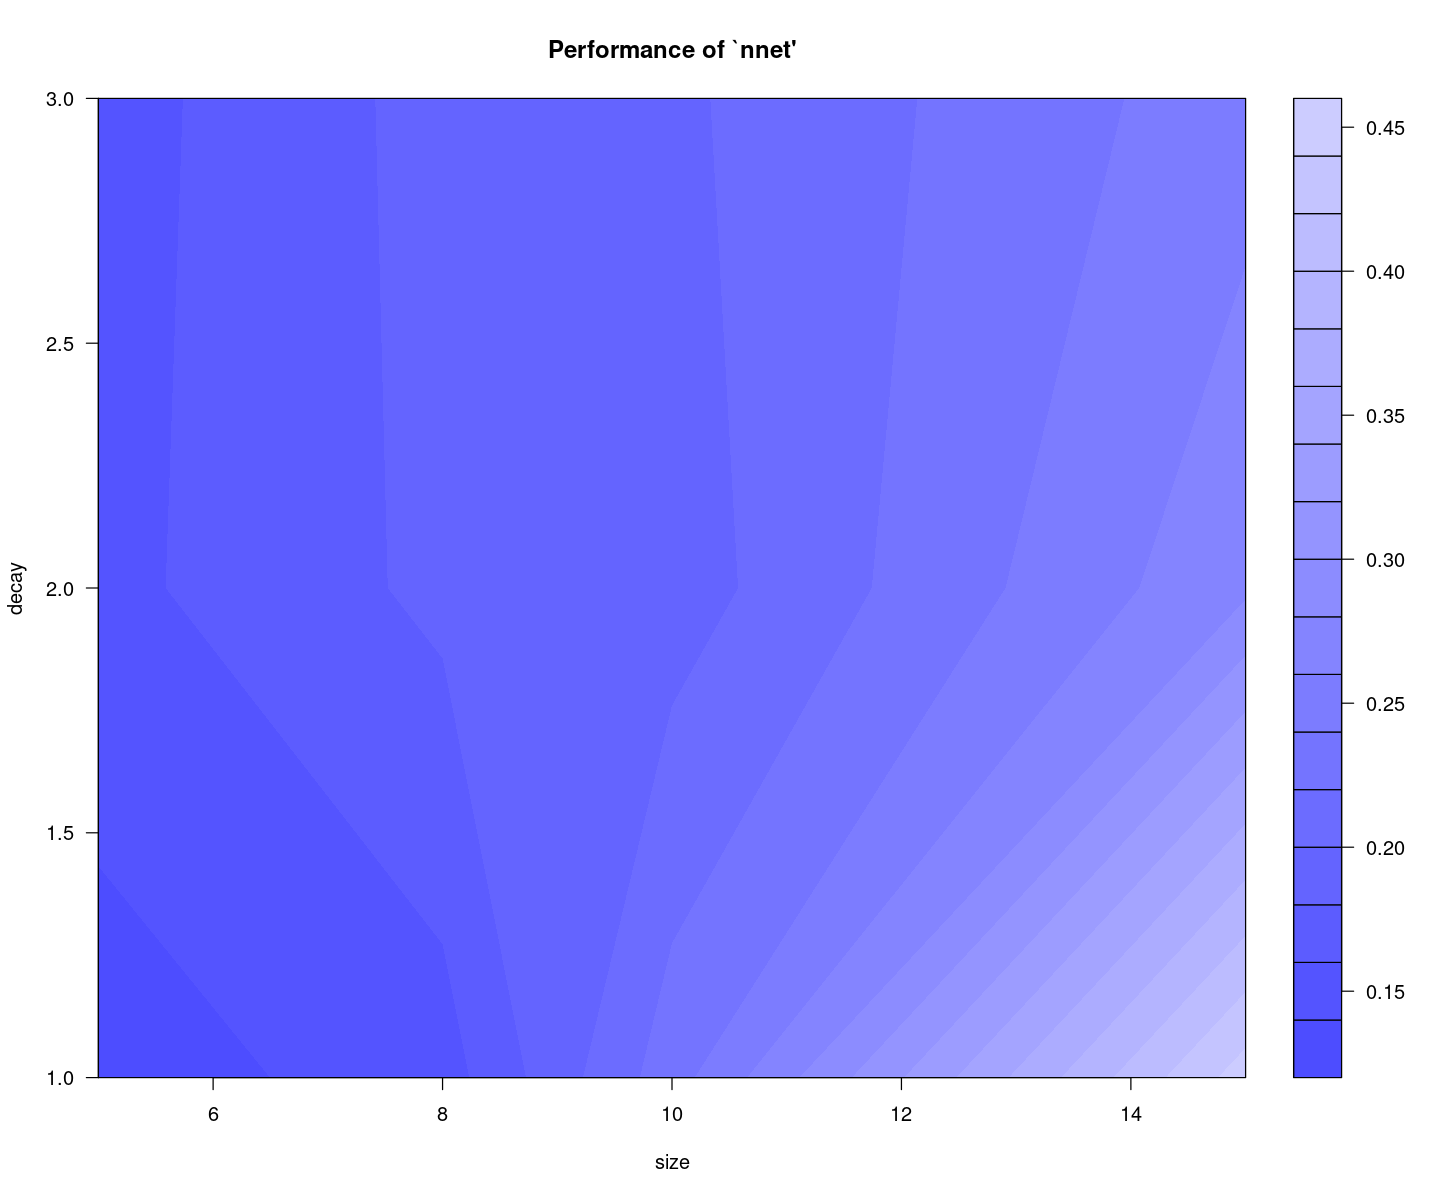

In [215]:
plot(tune.nnet(SValue_co2~.,data=datappr,size=c(5,8,10,15),decay=c(1,2,3),maxit=200,linout=TRUE))

In [162]:
nnet.reg=nnet(SValue_co2~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"SValue_co2"]
gplot.res(fit.nnetr,res.nnetr,titre="")

# weights:  109
initial  value 180633.247510 
iter  10 value 11042.544758
iter  20 value 10904.223409
iter  30 value 9365.160864
iter  40 value 7644.655751
iter  50 value 6306.621013
iter  60 value 5703.917228
iter  70 value 4353.912338
iter  80 value 3739.811592
iter  90 value 3300.772851
iter 100 value 2630.337032
iter 110 value 1995.957950
iter 120 value 1491.431582
iter 130 value 1113.285150
iter 140 value 937.501680
iter 150 value 790.090492
iter 160 value 703.819749
iter 170 value 650.916960
iter 180 value 640.940033
iter 190 value 636.087334
iter 200 value 630.032299
final  value 630.032299 
stopped after 200 iterations


Warning message:
“Removed 28 rows containing missing values (`geom_point()`).”


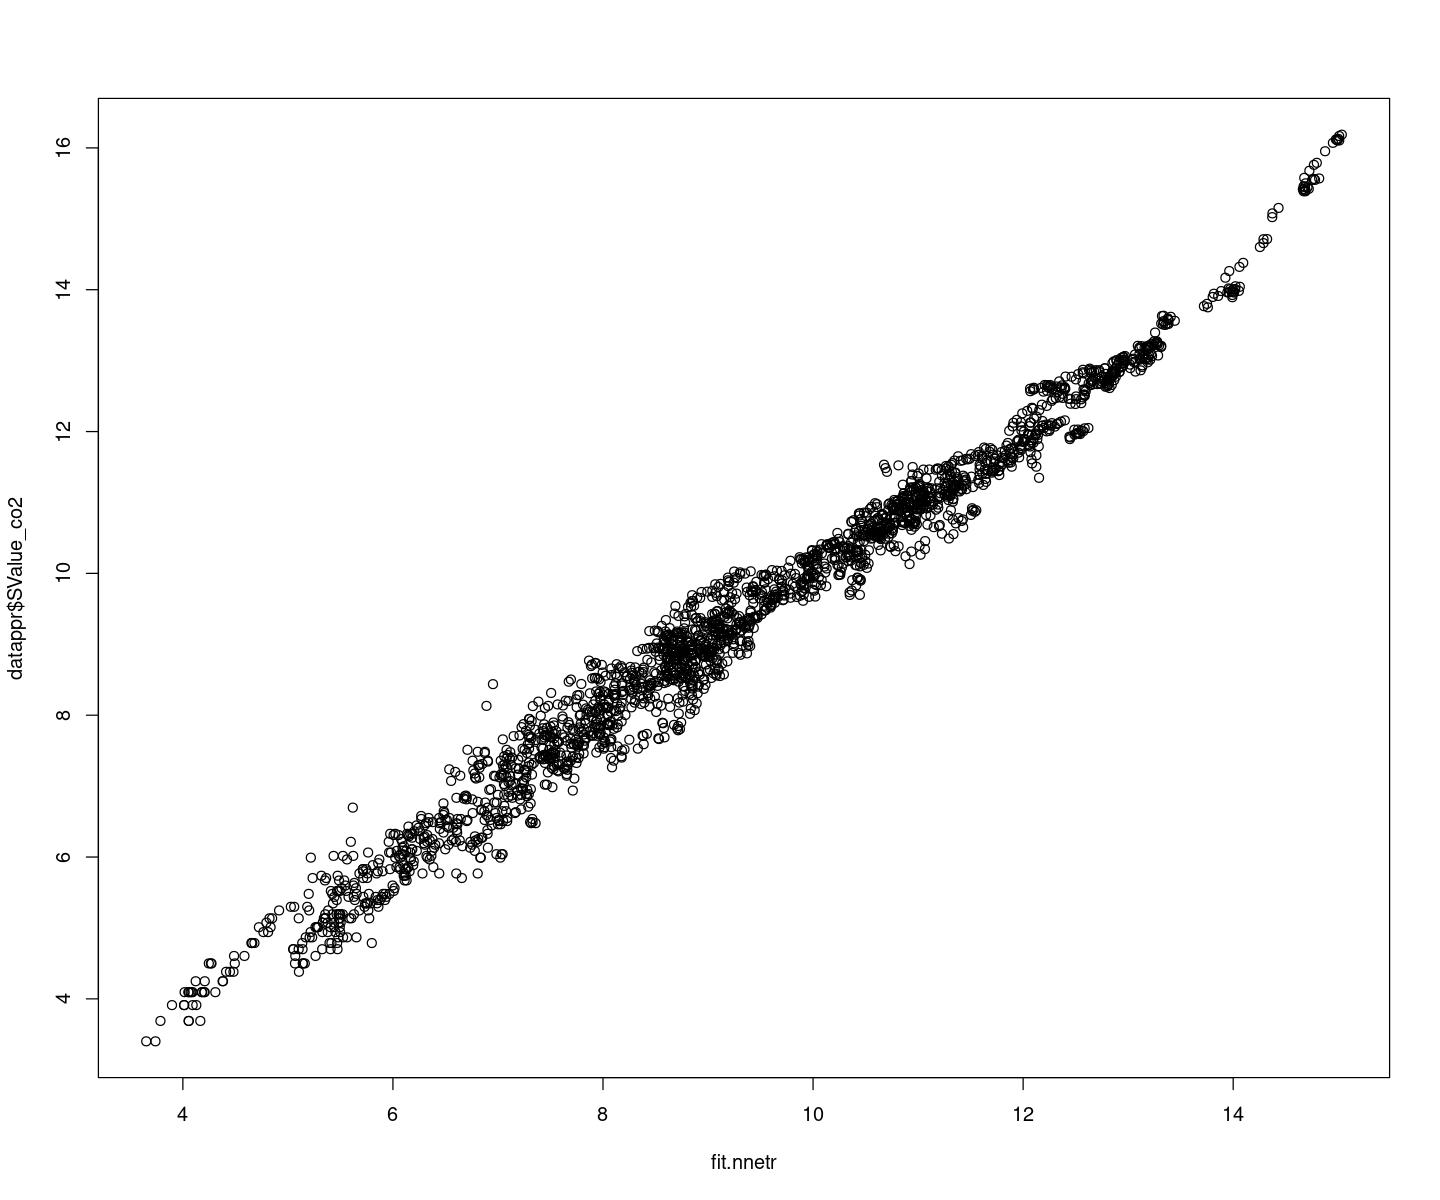

In [163]:
plot(fit.nnetr,datappr$SValue_co2)

In [164]:
# Calculer le coefficient de détermination R² (R2 score)

SS_Residual <- sum((datappr$SValue_co2 - fit.nnetr)^2)
SS_Total <- sum((datappr$SValue_co2 - mean(datappr$SValue_co2))^2)
R2_nn <- 1 - (SS_Residual / SS_Total)

paste("R2 =", R2_nn)

[1] "R2 = 0.980172574581454"

## Question 3 : comparaison de différentes méthodes de prévision sur l'échantillon test

In [251]:
pred.rl=predict(reg.lm,newdata=datestr)
pred.bic=predict(reg.glm,newdata=datestr)

x.matest <- model.matrix(SValue_co2 ~ .-1, data = datestr)
pred.lse=predict(reg.lasso.cv,s = "lambda.1se", newx = x.matest)
#pred.svm=predict(svm.reg,newdata=datestr)
pred.a=predict(tree.reg,newdata=datestr)
pred.rf=predict(rf.reg,newdata=datestr)
pred.boo=predict(boost.reg,newdata=datestr)
pred.nn=predict(nnet.reg,newdata=datestr)

#Calcul de nos MSE pour les différents méthodes 

MSE_rl = MSE(pred.rl,datestr[,16])
MSE_bic = MSE(pred.bic,datestr[,16])
MSE_lse = MSE(pred.lse,datestr[,16])
#MSE_svm = MSE(pred.svm,datestr[,16])
MSE_a = MSE(pred.a,datestr[,16])
MSE_rf = MSE(pred.rf,datestr[,16])
MSE_boo = MSE(pred.boo,datestr[,16])
MSE_nn = MSE(pred.nn,datestr[,16])

prec_rl = 100*(1-MSE_rl/var(datestr[,16]))
prec_bic = 100*(1-MSE_bic/var(datestr[,16]))
prec_lse = 100*(1-MSE_lse/var(datestr[,16]))
#prec_svm = 100*(1-MSE_svm/var(datestr[,16]))
prec_a = 100*(1-MSE_a/var(datestr[,16]))
prec_rf = 100*(1-MSE_rf/var(datestr[,16]))
prec_boo = 100*(1-MSE_boo/var(datestr[,16]))
prec_nn = 100*(1-MSE_nn/var(datestr[,16]))

Using 1000 trees...




In [249]:
Perf <- data.frame(
  Methode = c("RegLig", "AIC", "LASSO", "SVM", "Arbre","Forêt Aléatoire","Boosting","Neural Network"),
  MSE = c(MSE_rl,MSE_bic,MSE_lse,MSE_svm,MSE_a,MSE_rf,MSE_boo,MSE_nn),
  R2 = c(prec_rl,prec_bic,prec_lse,prec_svm,prec_a,prec_rf,prec_boo,prec_nn)
)

Perf

ERROR: Error in eval(expr, envir, enclos): objet 'MSE_svm' introuvable


## Question 4 : Retour sur l'analyse exploratoire

In [ ]:
varImpPlot(rf.reg)

In [ ]:
summary.gbm(boost.reg)

In [ ]:
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

In [ ]:
summary(reg.glm.step)

## Question 5 : modélisation après une imputation des données manquantes

### Visualisation des données manquantes

In [219]:
energyna = energy_pt2

In [220]:
missing = data.frame(colSums(is.na(energyna)))
missing

colSums.is.na.energyna..
Entity             0                     
Year               0                     
Access_elec       10                     
Access_fuels     169                     
Renewable_energy 194                     
Elec_fossil       21                     
Elec_nuclear     126                     
Elec_renew        21                     
Low_carbon        42                     
Primary_energy     0                     
Energy_intensity 207                     
Value_co2        428                     
gdp_growth       317                     
gdp_capita       282                     
Density            1                     
Land_area          1                     
Latitude           1                     
Longitude          1

In [221]:
#On enlève Entity et Year
energynaQuant = energyna[,3:18]
#On enlève Electricity from fossil fuel
energynaQuant = energynaQuant[,-4]
head(energynaQuant)

Access_elec Access_fuels Renewable_energy Elec_nuclear Elec_renew Low_carbon
1  1.613591    6.2         44.99            0            0.31       65.95744  
2  4.074574    7.2         45.60            0            0.50       84.74577  
3  9.409158    8.2         37.83            0            0.56       81.15942  
4 14.738506    9.5         36.66            0            0.63       67.02128  
5 20.064968   10.9         44.24            0            0.56       62.92135  
6 25.390894   12.2         33.88            0            0.59       63.44086  
  Primary_energy Energy_intensity Value_co2 gdp_growth gdp_capita Density
1 302.5948       1.64              760             NA        NA   60     
2 236.8919       1.74              730             NA        NA   60     
3 210.8622       1.40             1030             NA  179.4266   60     
4 229.9682       1.40             1220       8.832278  190.6838   60     
5 204.2312       1.20             1030       1.414118  211.3821   60     
6 252.0691       1.41             1550      11.229715  242.0313   60     
  Land_area Latitude Longitude
1 652230    33.93911 67.70995 
2 652230    33.93911 67.70995 
3 652230    33.93911 67.70995 
4 652230    33.93911 67.70995 
5 652230    33.93911 67.70995 
6 652230    33.93911 67.70995

### Transformation des variables 

In [222]:
energynaQuant[, "SAccess_elec"] = log(energynaQuant[, "Access_elec"])
energynaQuant[, "SAccess_fuels"] = log(1+energynaQuant[, "Access_fuels"])
energynaQuant[, "SRenewable_energy"] = sqrt(energynaQuant[, "Renewable_energy"])
energynaQuant[, "SElec_nuclear"] = log(1+energynaQuant[, "Elec_nuclear"])
energynaQuant[, "SElec_renew"] = log(1+energynaQuant[, "Elec_renew"])
energynaQuant[, "SLow_carbon"] = sqrt(energynaQuant[, "Low_carbon"])
energynaQuant[, "SPrimary_energy"] = log(1+energynaQuant[, "Primary_energy"])
energynaQuant[, "SEnergy_intensity"] = log(sqrt(energynaQuant[, "Energy_intensity"]))
energynaQuant[, "Sgdp_capita"] = log(sqrt(energynaQuant[, "gdp_capita"]))
energynaQuant[, "SDensity"] = log(energynaQuant[, "Density"])
energynaQuant[, "SLand_area"] = log(energynaQuant[, "Land_area"])
energynaQuant[, "Svalue_co2"] = log(energynaQuant[, "Value_co2"])
energynaQuant = energynaQuant[-c(1:9,11:13)]


In [223]:
head(energynaQuant)

gdp_growth Latitude Longitude SAccess_elec SAccess_fuels SRenewable_energy
1        NA  33.93911 67.70995  0.4784621    1.974081      6.707459         
2        NA  33.93911 67.70995  1.4047662    2.104134      6.752777         
3        NA  33.93911 67.70995  2.2416835    2.219203      6.150610         
4  8.832278  33.93911 67.70995  2.6904635    2.351375      6.054750         
5  1.414118  33.93911 67.70995  2.9989754    2.476538      6.651316         
6 11.229715  33.93911 67.70995  3.2343906    2.580217      5.820653         
  SElec_nuclear SElec_renew SLow_carbon SPrimary_energy SEnergy_intensity
1 0             0.2700271   8.121419    5.715694        0.24734812       
2 0             0.4054651   9.205746    5.471816        0.27694256       
3 0             0.4446858   9.008853    5.355936        0.16823612       
4 0             0.4885800   8.186653    5.442280        0.16823612       
5 0             0.4446858   7.932298    5.324137        0.09116078       
6 0             0.4637340   7.964977    5.533663        0.17179485       
  Sgdp_capita SDensity SLand_area Svalue_co2
1       NA    4.094345 13.38815   6.633318  
2       NA    4.094345 13.38815   6.593045  
3 2.594883    4.094345 13.38815   6.937314  
4 2.625308    4.094345 13.38815   7.106606  
5 2.676834    4.094345 13.38815   6.937314  
6 2.744534    4.094345 13.38815   7.346010

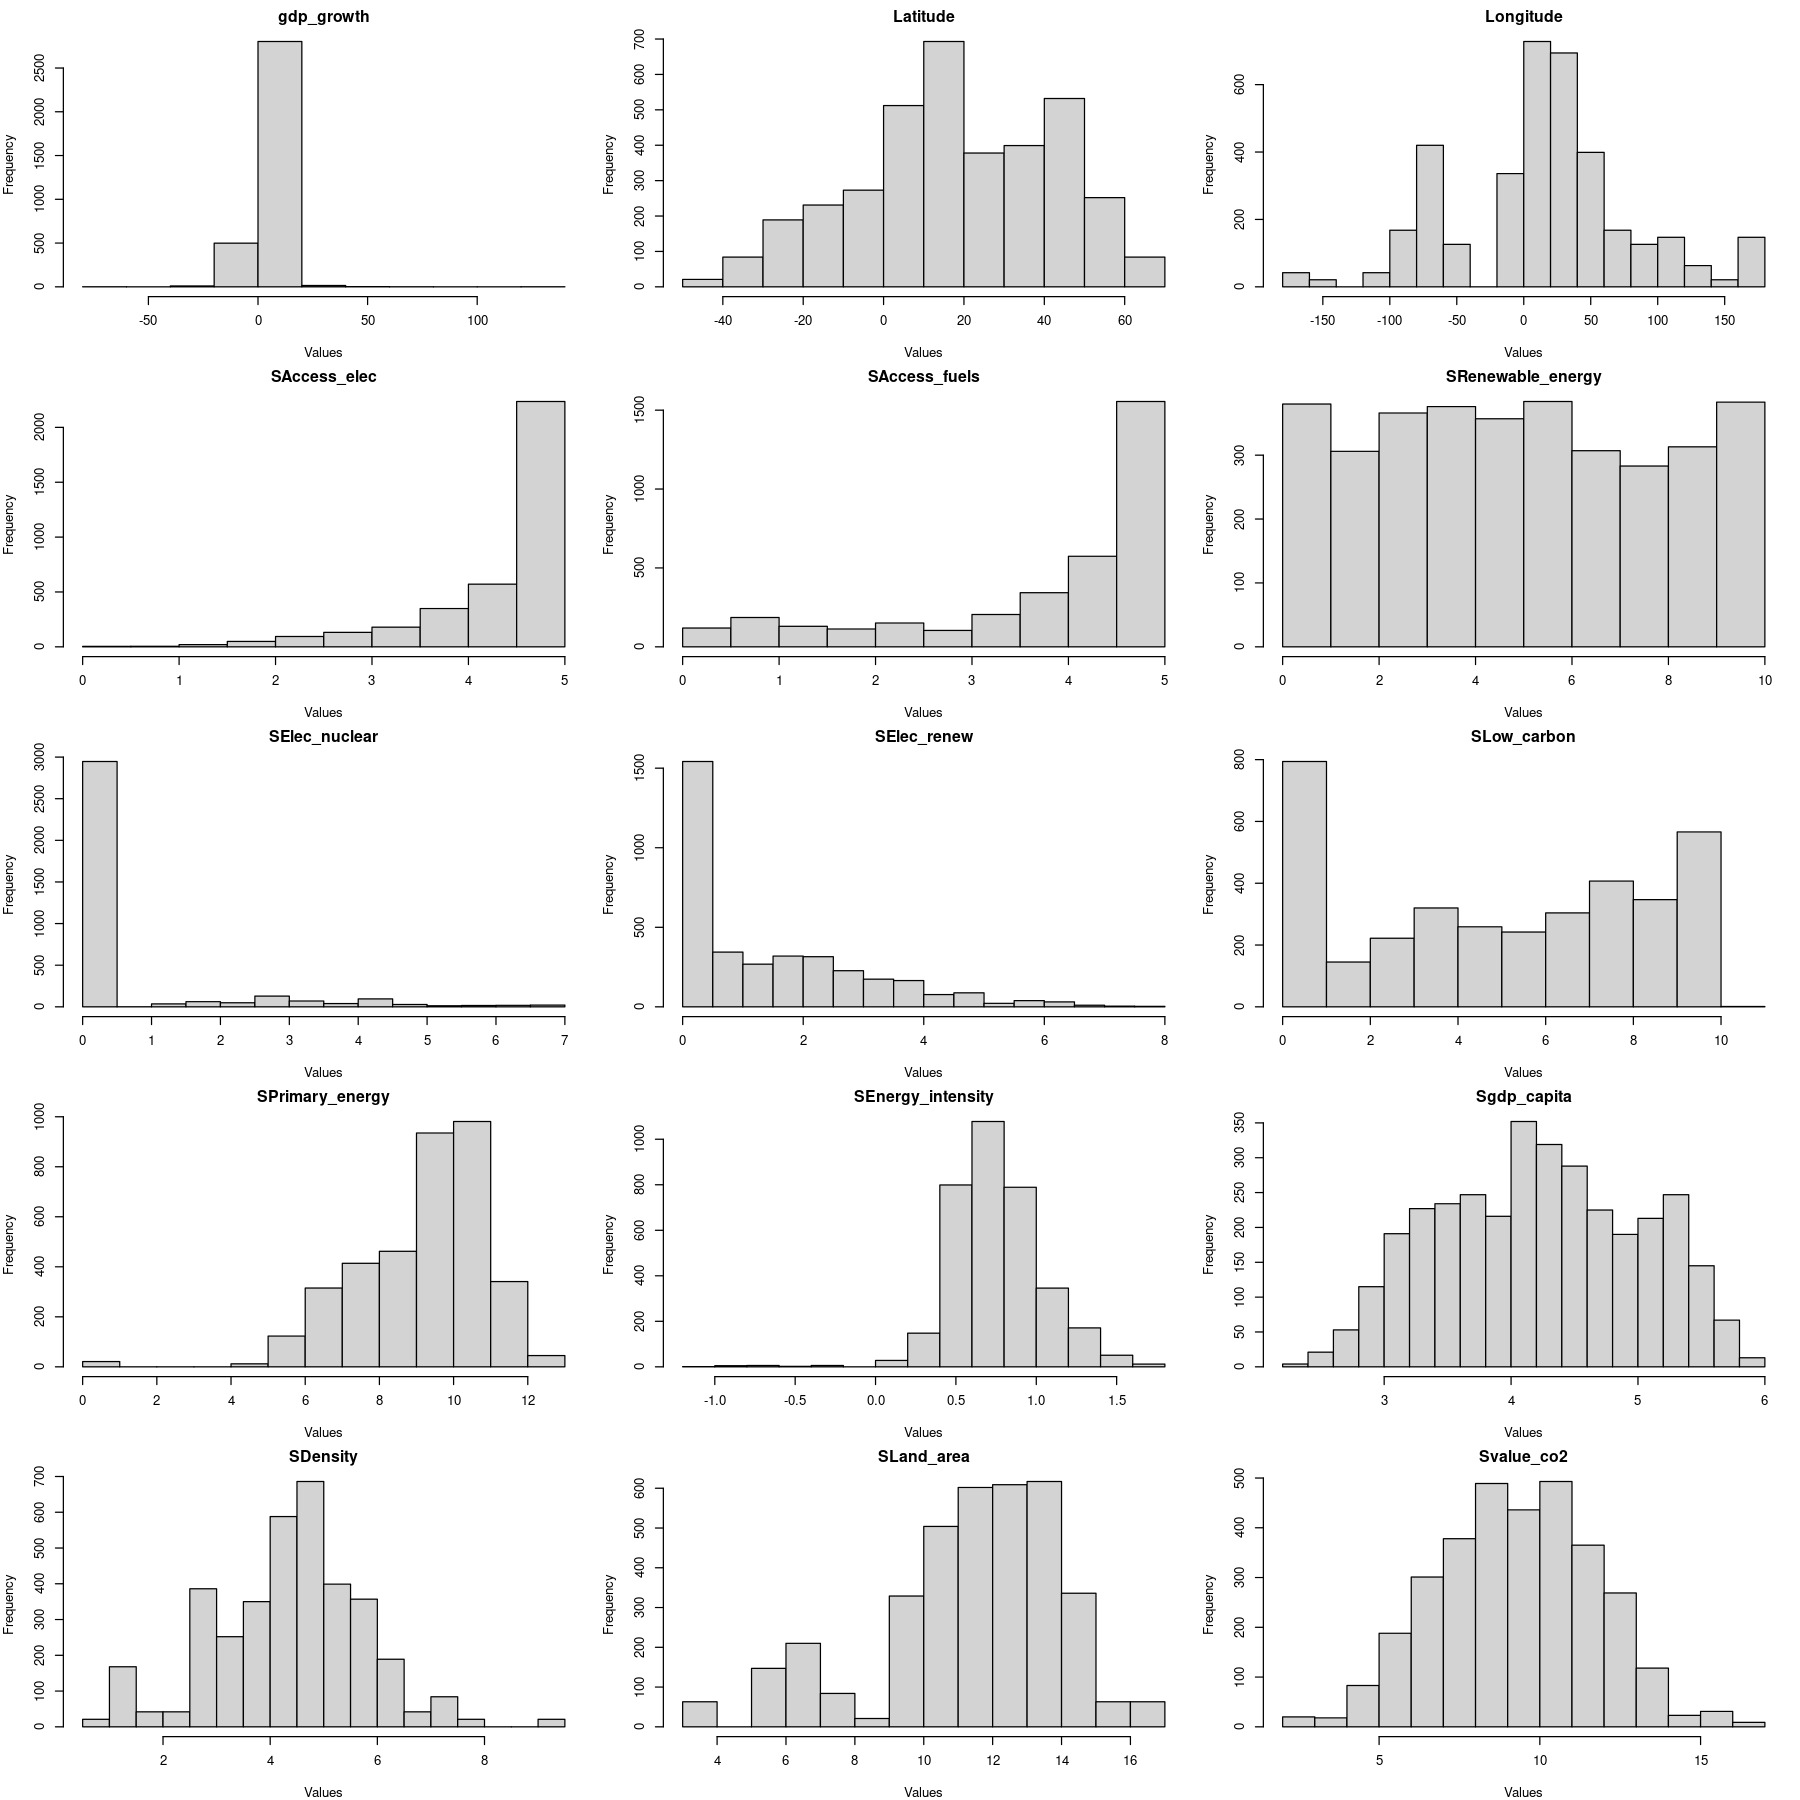

In [224]:
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow = c(5,3) , mar = c(4,4,2,1))

for (i in 1:length(names(energynaQuant))) {
    dfi = energynaQuant[,c(i)]
    hist(dfi, main=names(energynaQuant)[i],xlab='Values')
}

In [225]:
library(missForest)

In [226]:
XnaImp=missForest(energynaQuant,verbose=TRUE)

  missForest iteration 1 in progress...done!
    estimated error(s): 0.172851 
    difference(s): 0.0004680855 
    time: 27.103 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.1414459 
    difference(s): 0.0001362881 
    time: 26.598 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.1405785 
    difference(s): 1.69749e-05 
    time: 27.307 seconds

  missForest iteration 4 in progress...done!
    estimated error(s): 0.1413079 
    difference(s): 1.973455e-05 
    time: 26.475 seconds



In [227]:
X_imp = data.frame(XnaImp$ximp)

In [228]:
missing_rates = data.frame(colSums(is.na(X_imp)))
missing_rates

colSums.is.na.X_imp..
gdp_growth        0                    
Latitude          0                    
Longitude         0                    
SAccess_elec      0                    
SAccess_fuels     0                    
SRenewable_energy 0                    
SElec_nuclear     0                    
SElec_renew       0                    
SLow_carbon       0                    
SPrimary_energy   0                    
SEnergy_intensity 0                    
Sgdp_capita       0                    
SDensity          0                    
SLand_area        0                    
Svalue_co2        0

### Modélisation avec le jeu de données complété

In [229]:
set.seed(183) # initialisation du générateur

# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(X_imp) # nombre de lignes dans les données
nvar <- ncol(X_imp) # nombre de colonnes

# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 

# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

# construction de l'échantillon d'apprentissage
datappi <-X_imp[appri,] 
# construction de l'échantillon test
datesti <- X_imp[testi, ] 

# vérification
str(datappi)
str(datesti)
#summary(datappr) 

'data.frame':	2919 obs. of  15 variables:
 $ gdp_growth       : num  5.67 6.36 8.83 11.23 5.36 ...
 $ Latitude         : num  33.9 33.9 33.9 33.9 33.9 ...
 $ Longitude        : num  67.7 67.7 67.7 67.7 67.7 ...
 $ SAccess_elec     : num  0.478 1.405 2.69 3.234 3.425 ...
 $ SAccess_fuels    : num  1.97 2.1 2.35 2.58 2.7 ...
 $ SRenewable_energy: num  6.71 6.75 6.05 5.82 5.65 ...
 $ SElec_nuclear    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SElec_renew      : num  0.27 0.405 0.489 0.464 0.495 ...
 $ SLow_carbon      : num  8.12 9.21 8.19 7.96 8.73 ...
 $ SPrimary_energy  : num  5.72 5.47 5.44 5.53 5.72 ...
 $ SEnergy_intensity: num  0.247 0.277 0.168 0.172 0.203 ...
 $ Sgdp_capita      : num  2.84 2.83 2.63 2.74 2.79 ...
 $ SDensity         : num  4.09 4.09 4.09 4.09 4.09 ...
 $ SLand_area       : num  13.4 13.4 13.4 13.4 13.4 ...
 $ Svalue_co2       : num  6.63 6.59 7.11 7.35 7.47 ...
'data.frame':	730 obs. of  15 variables:
 $ gdp_growth       : num  4.34 5.73 1.58 2.9 9.03 ...
 $ Latitude    

#### Random Forest

In [216]:
tuned.model <- tuneRF(datappi[,-16], datappi[,16])

ERROR: Error in eval(expr, envir, enclos): objet 'datappi' introuvable


In [268]:
rf.reg <- randomForest(Svalue_co2 ~ ., data = datappi, ntree = 500, mtry = 8, importance = TRUE, do.trace = 50)

attributes(rf.reg)
rf.reg$mtry

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
  50 |  0.02265     0.38 |
 100 |  0.01985     0.34 |
 150 |  0.01797     0.30 |
 200 |  0.01773     0.30 |
 250 |  0.01781     0.30 |
 300 |  0.01751     0.30 |
 350 |  0.01727     0.29 |
 400 |  0.01718     0.29 |
 450 |  0.01725     0.29 |
 500 |  0.01706     0.29 |


$names
 [1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

[1] 8

Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


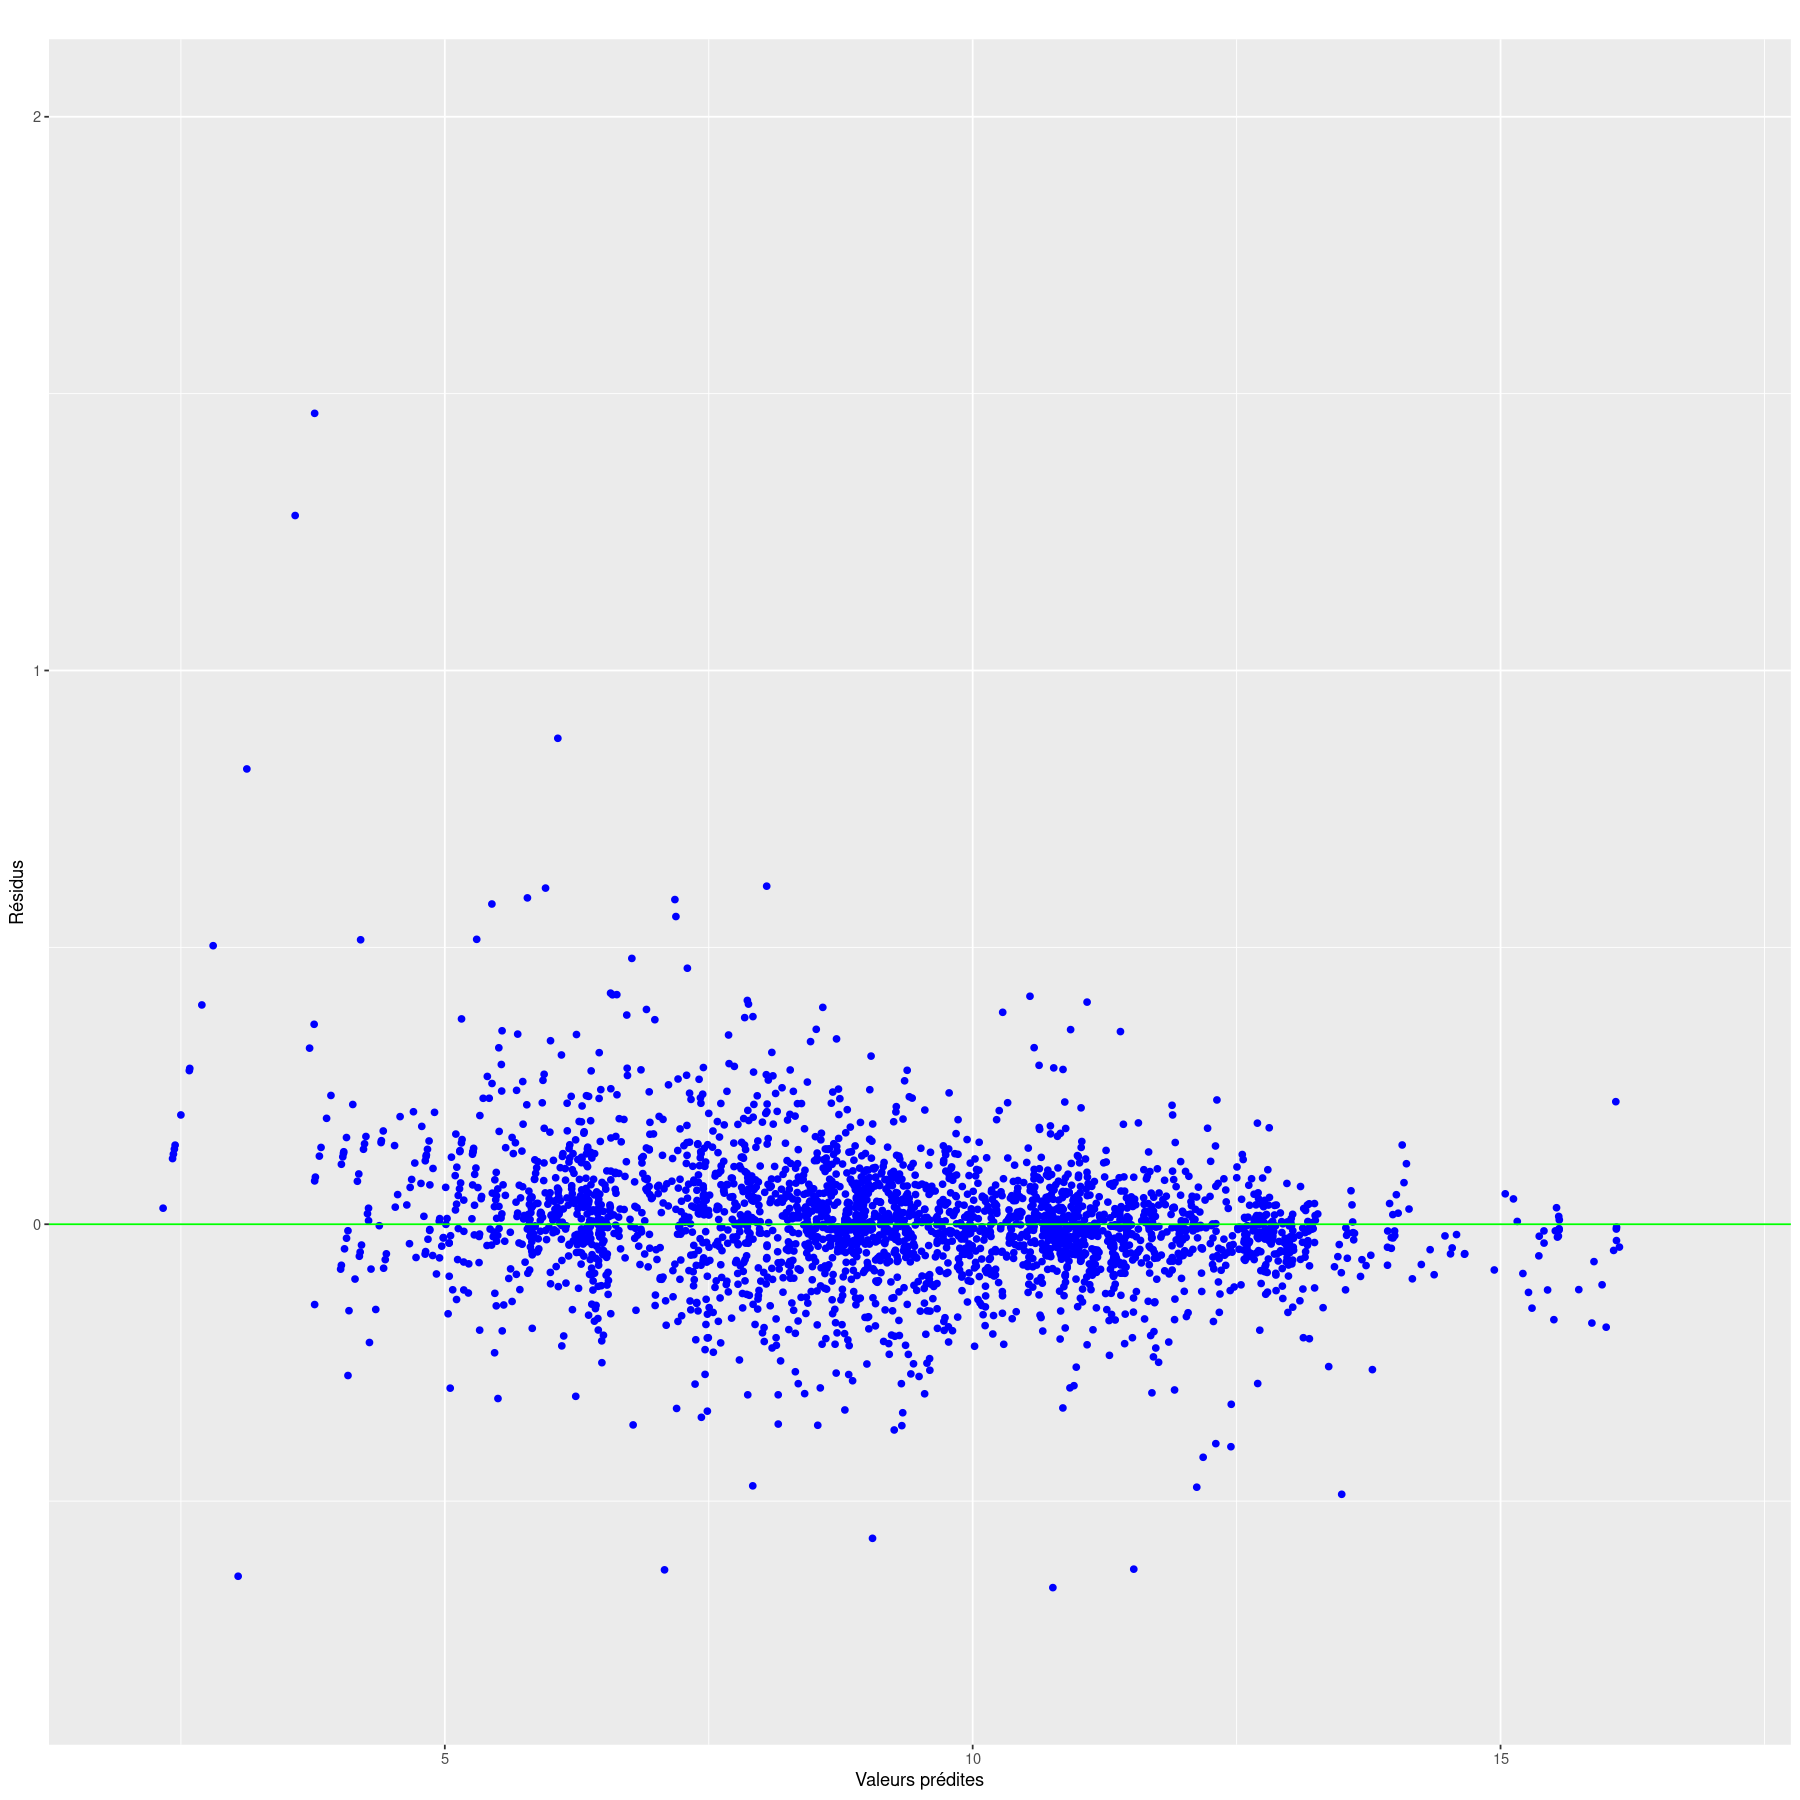

In [276]:
fit.rfr=rf.reg$predicted
res.rfr=fit.rfr-datappi[,"Svalue_co2"]
gplot.res(fit.rfr,res.rfr,titre="")

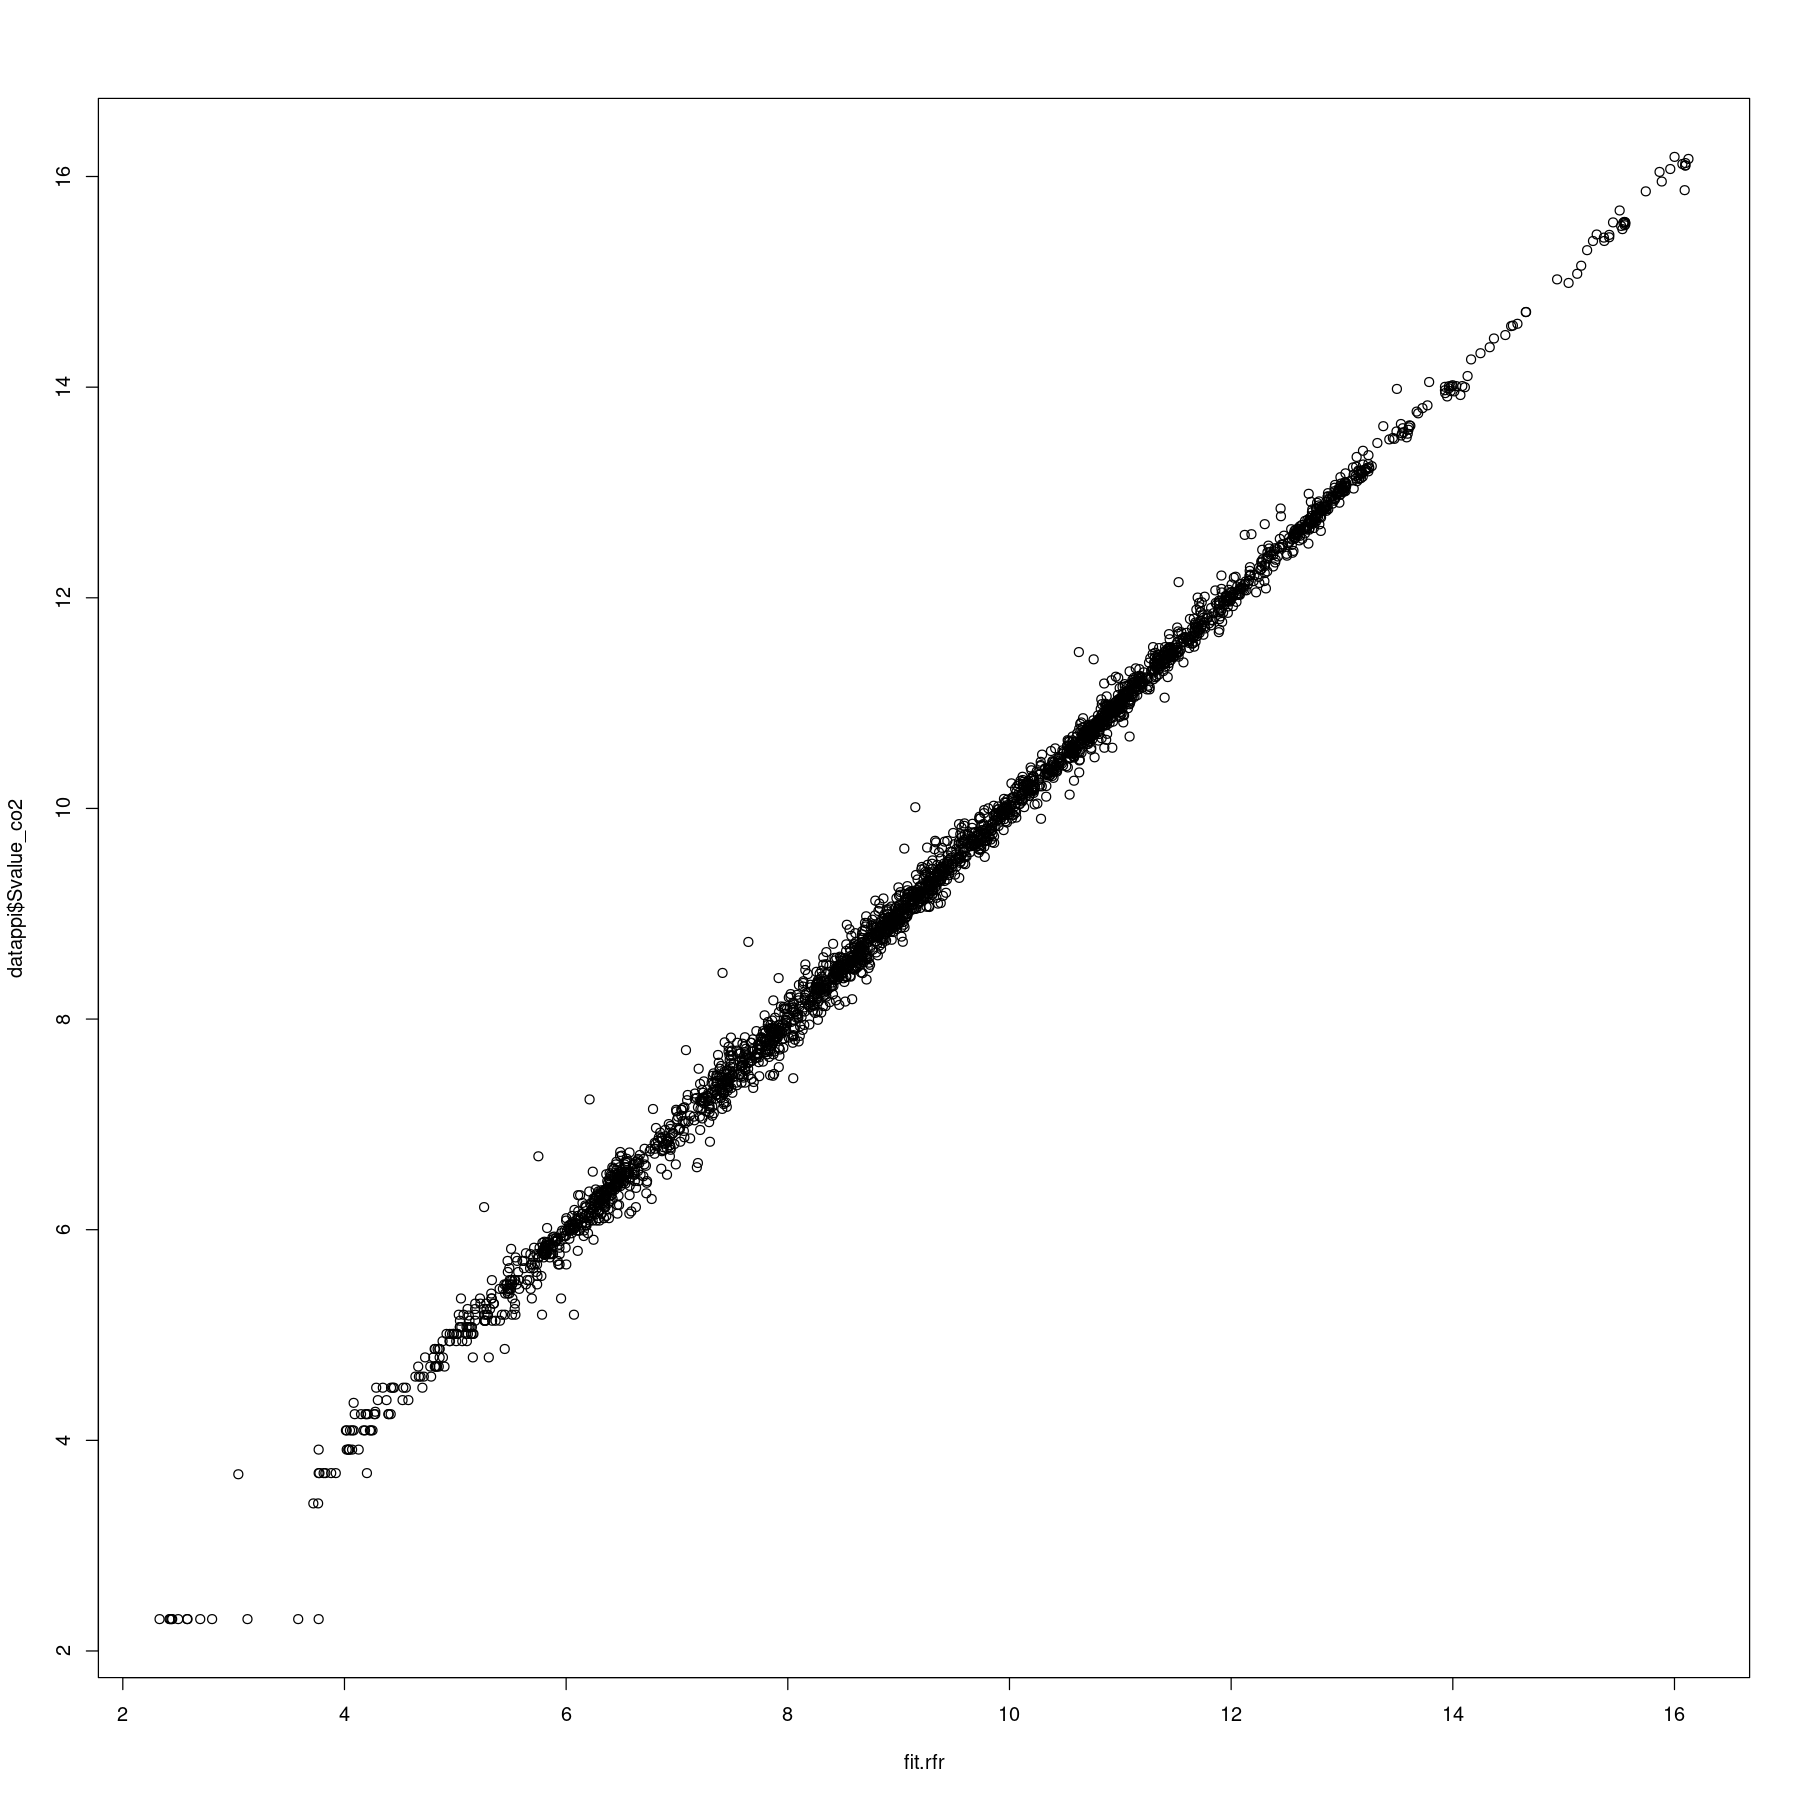

In [278]:
plot(fit.rfr,datappi$Svalue_co2)

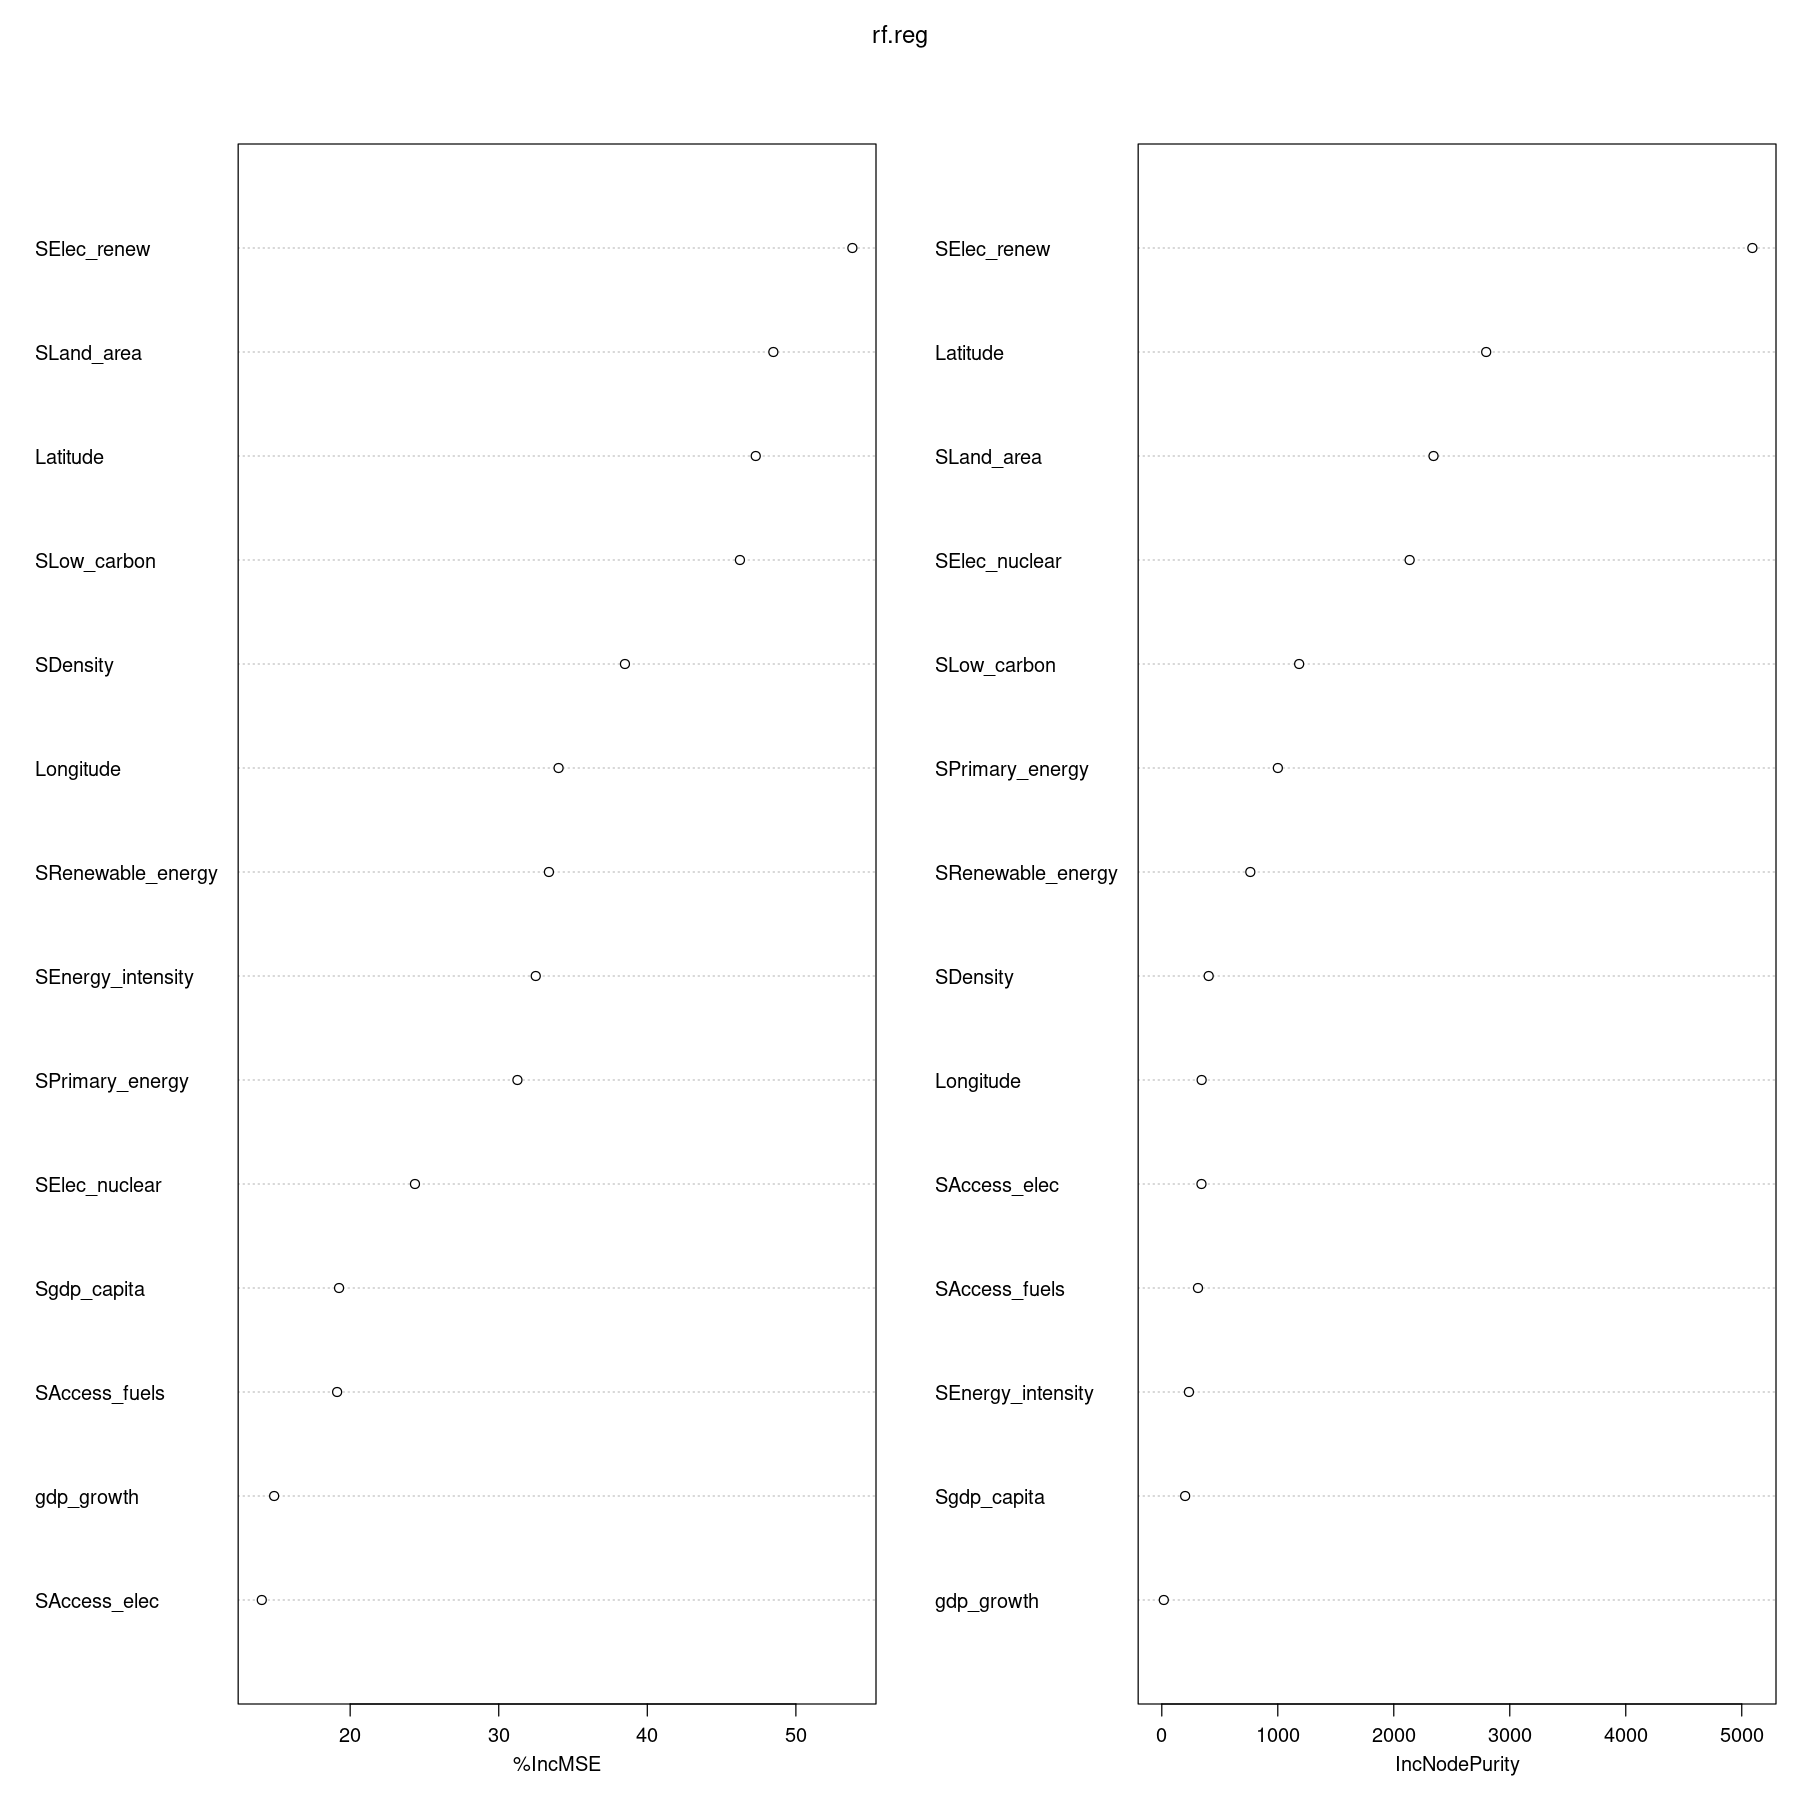

In [269]:
varImpPlot(rf.reg)

[1] 0.01563213

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


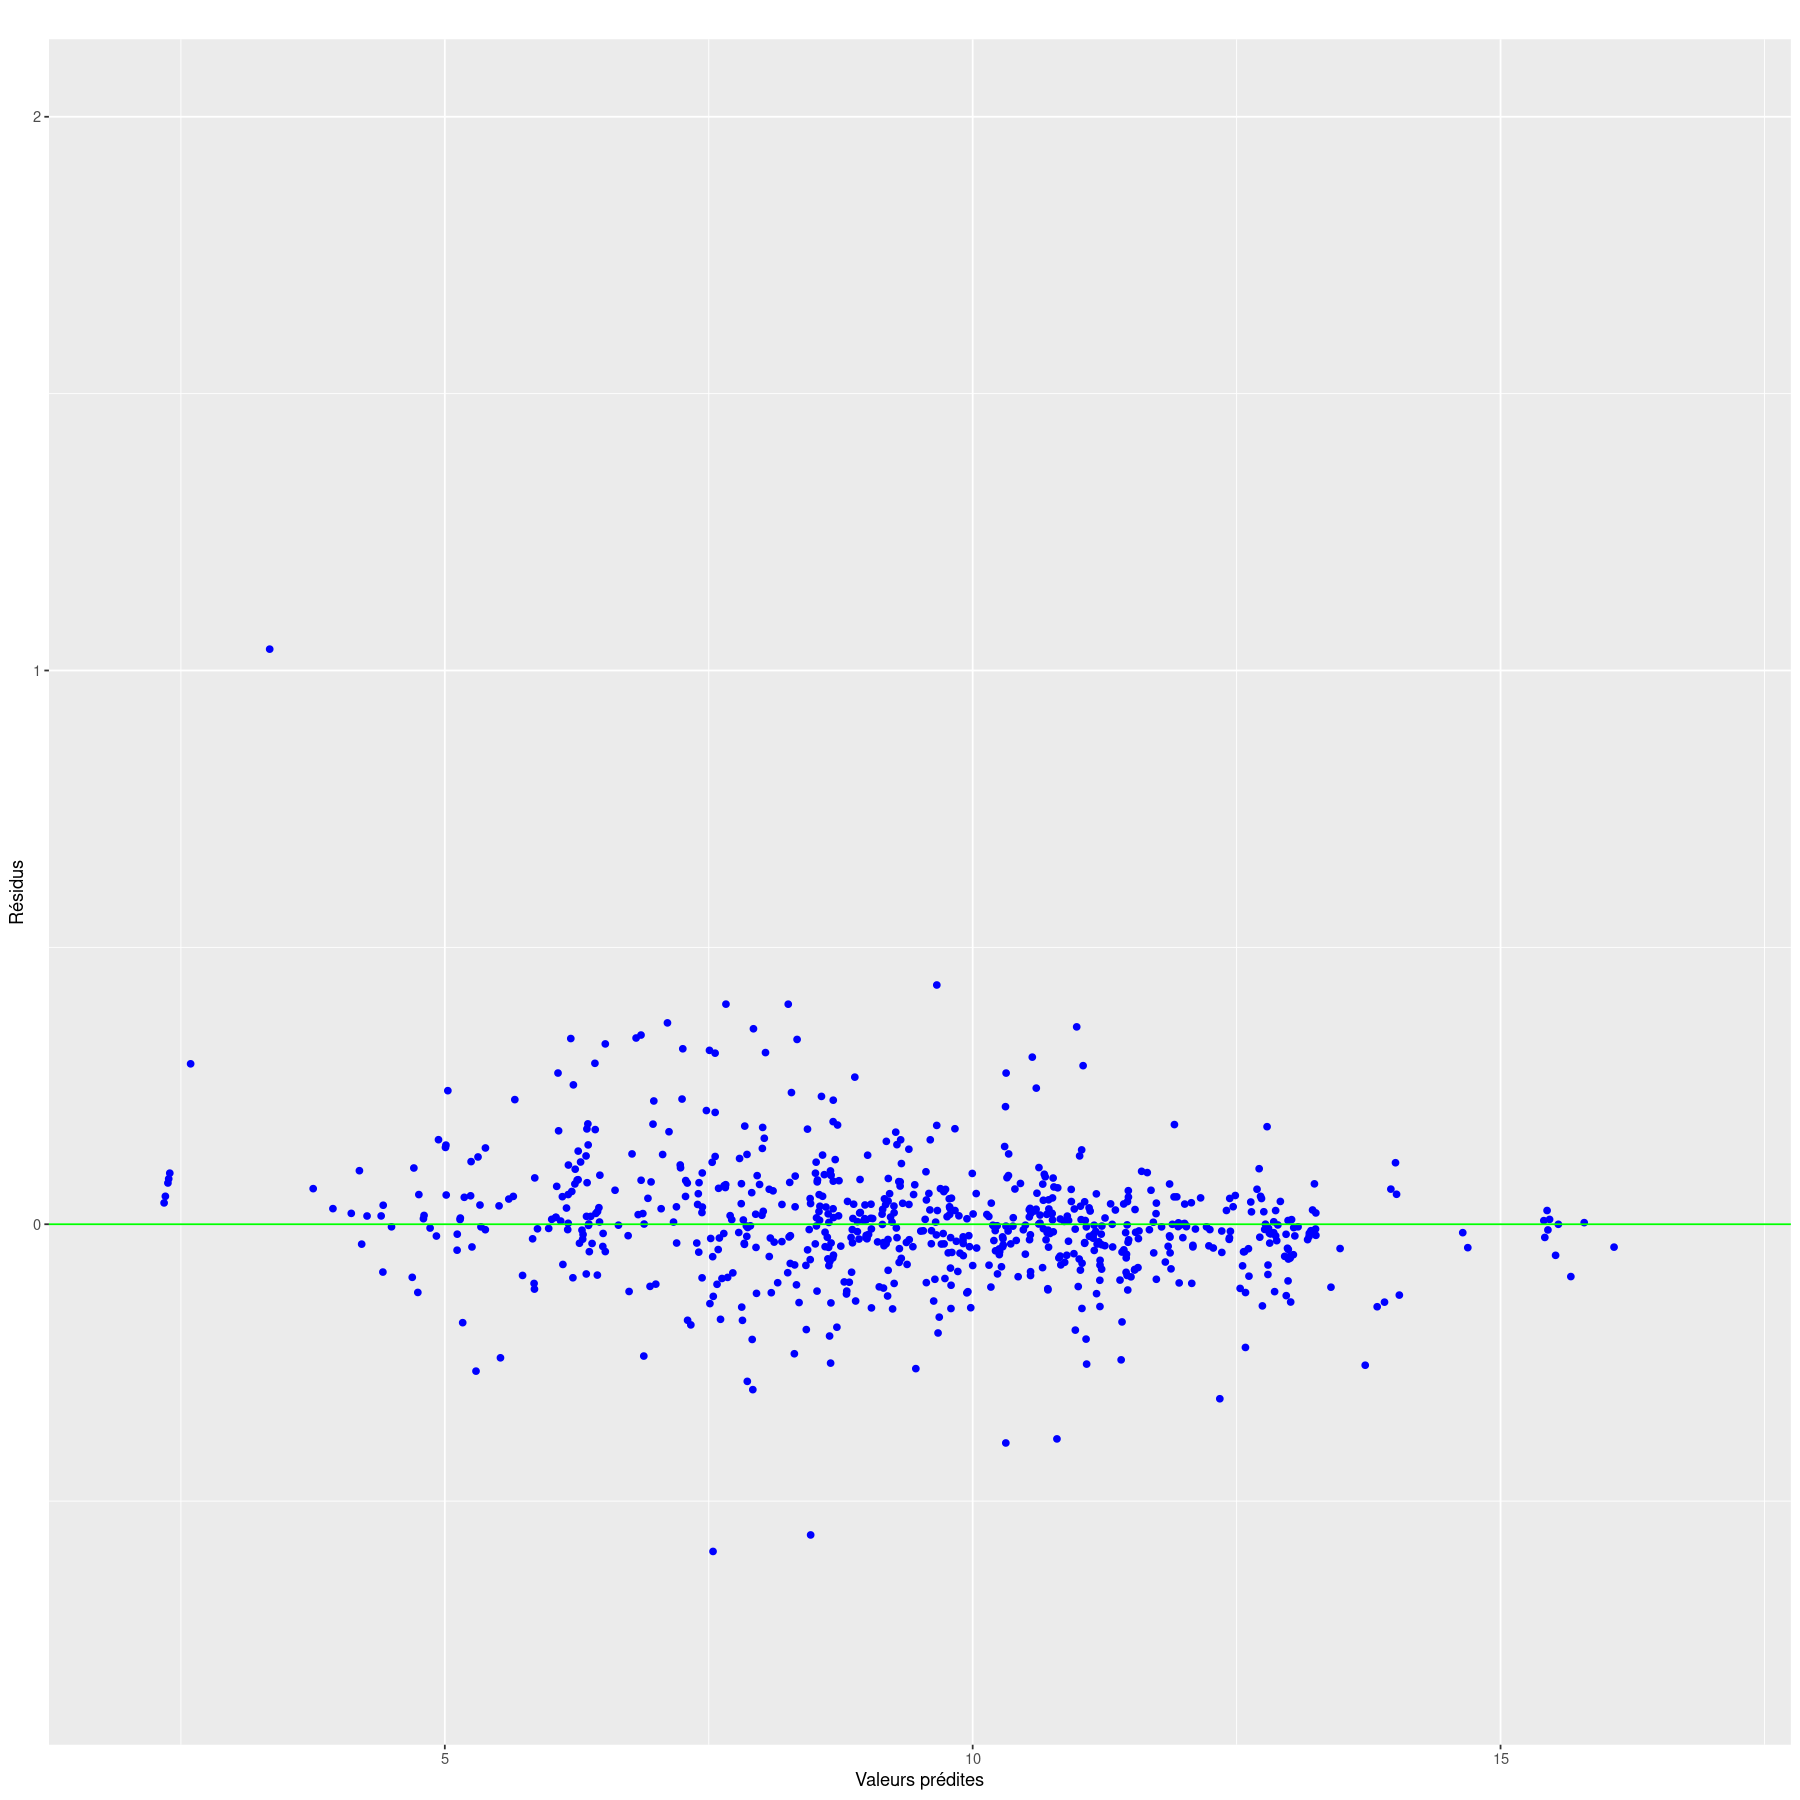

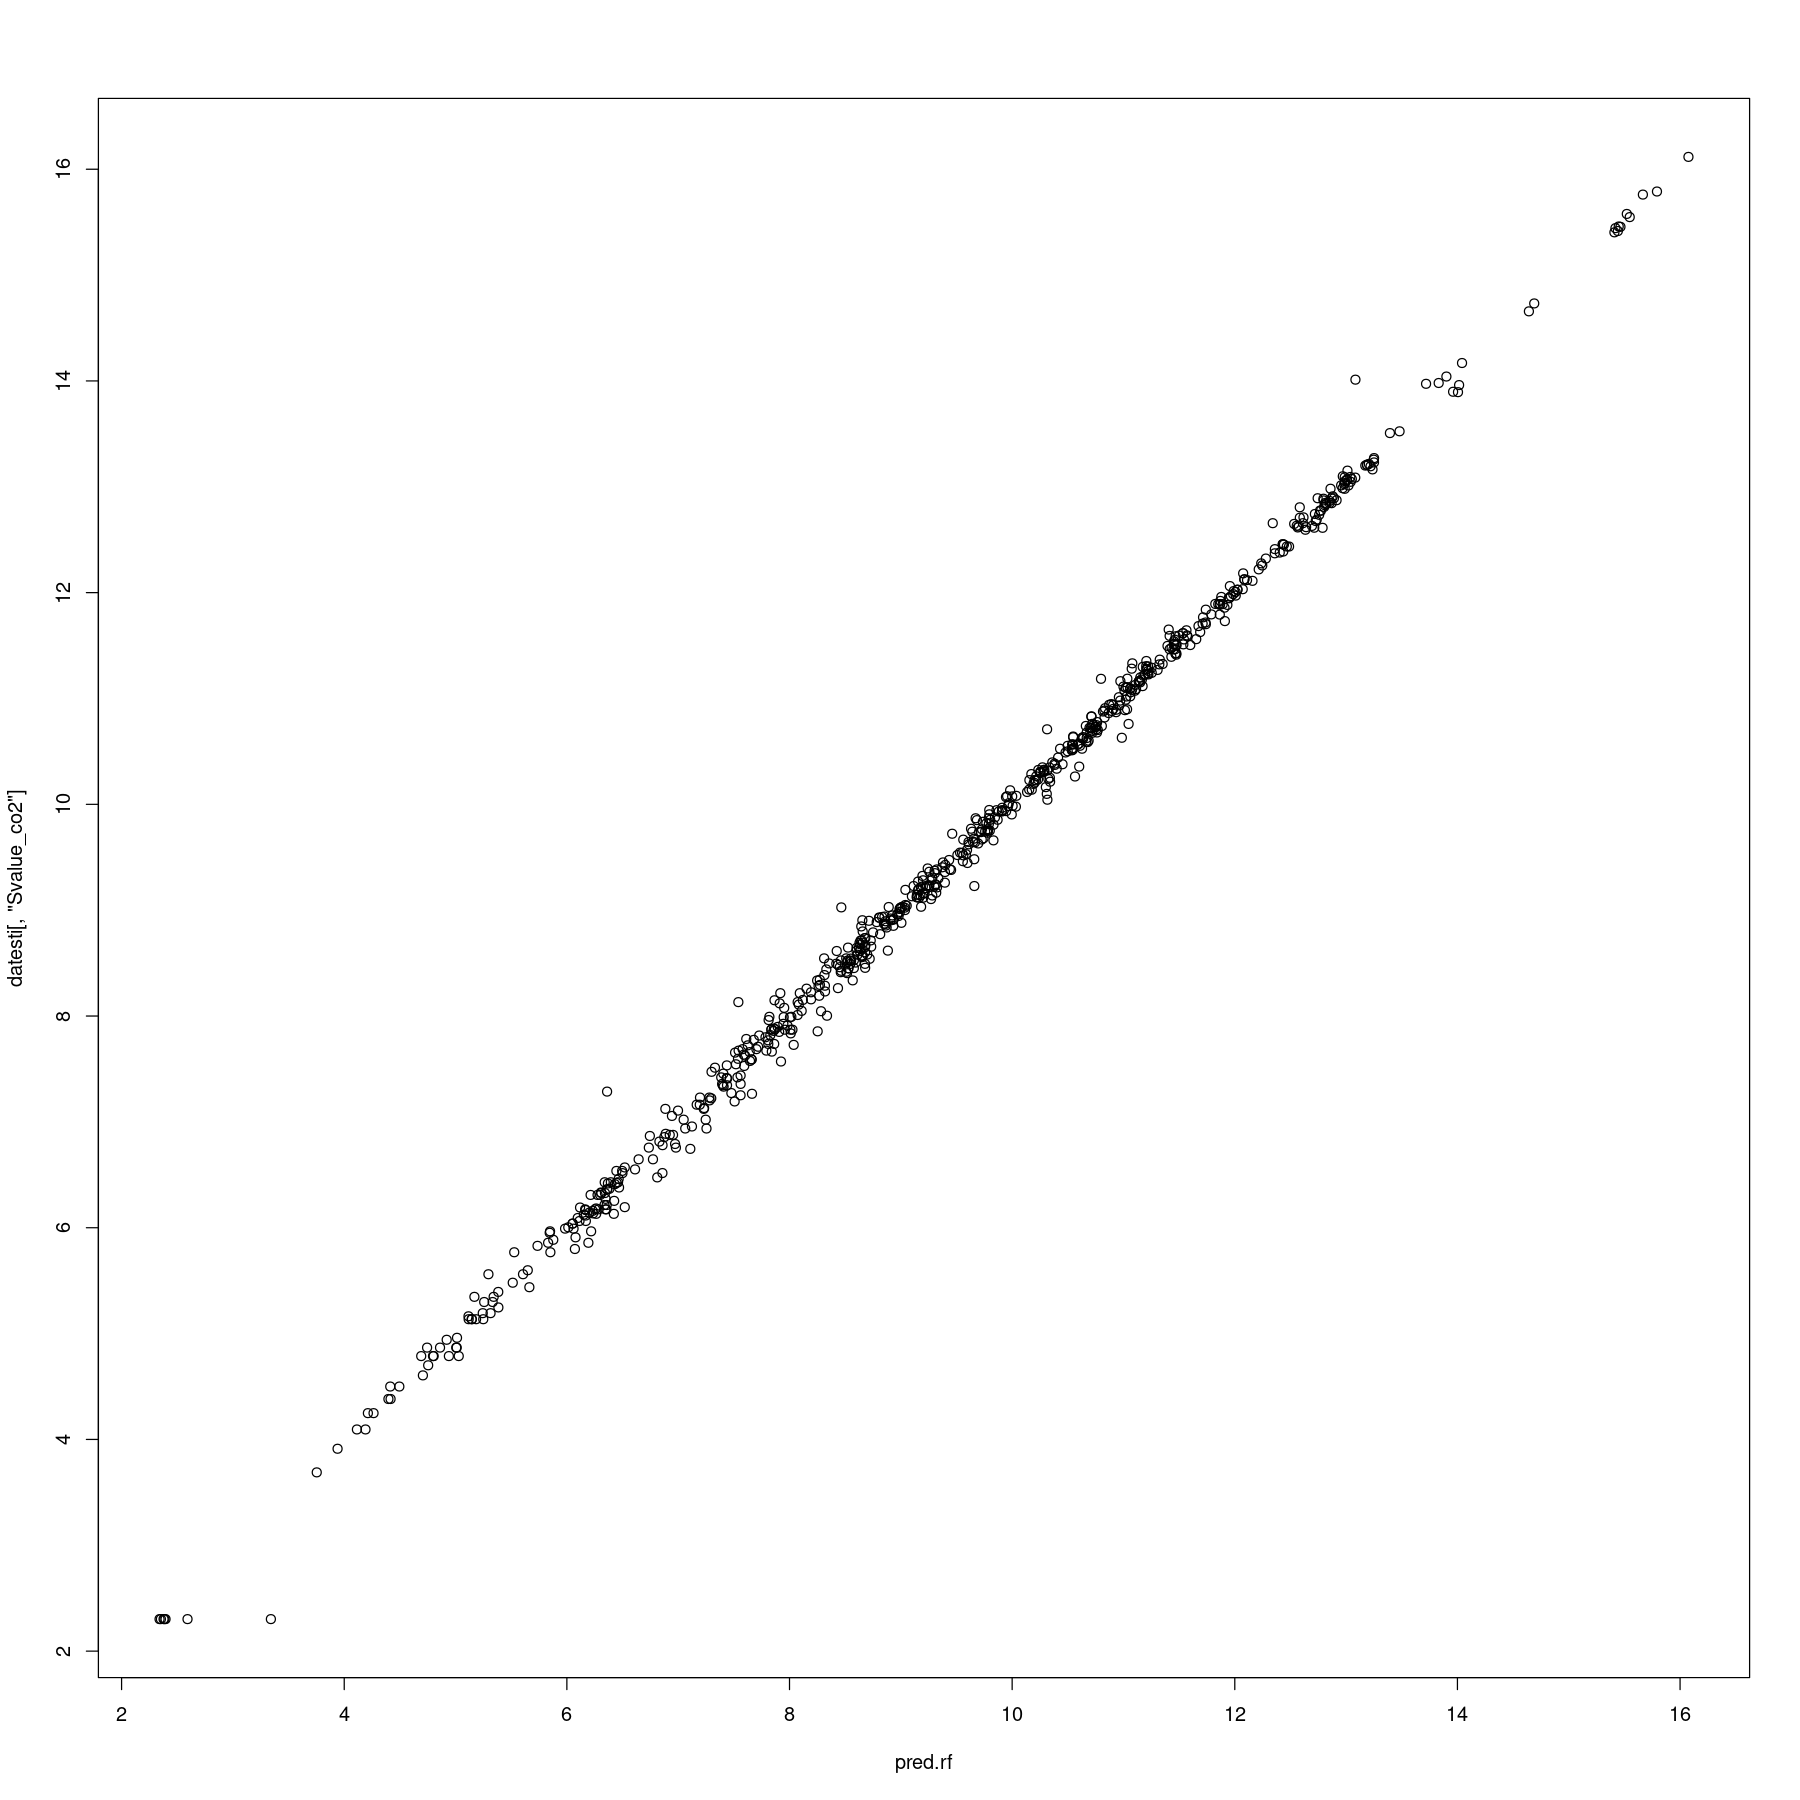

In [286]:
#Sur nos données test
pred.rf=predict(rf.reg,newdata=datesti)
#Erreur quadratique moyenne de prévision
sum((pred.rf-datesti[,"Svalue_co2"])^2)/nrow(datesti)

err.rf=pred.rf-datesti[,"Svalue_co2"]

gplot.res(pred.rf,err.rf,titre="")
plot(pred.rf,datesti[,"Svalue_co2"])

In [ ]:
varImpPlot(pred.rf)

#### Boosting

In [230]:
# Hyperparamètres à tester
param_grid <- expand.grid( shrinkage = c(0.001,0.5,0.1), n.minobsinnode = c(2,3,4,5,6) ,n.trees = c(100,500,900), interaction.depth = 10)

# Contrôle de la validation croisée
train_control <- trainControl(
  method = "cv",      # Utiliser la validation croisée
  number = 10          # Nombre de folds
)

model <- train(
  Svalue_co2 ~ .,
  data = datappi,
  method = "gbm",
  trControl = train_control,
  tuneGrid = param_grid,
  verbose = FALSE
)

In [231]:
print(model$bestTune)

   n.trees interaction.depth shrinkage n.minobsinnode
24     900                10       0.1              4


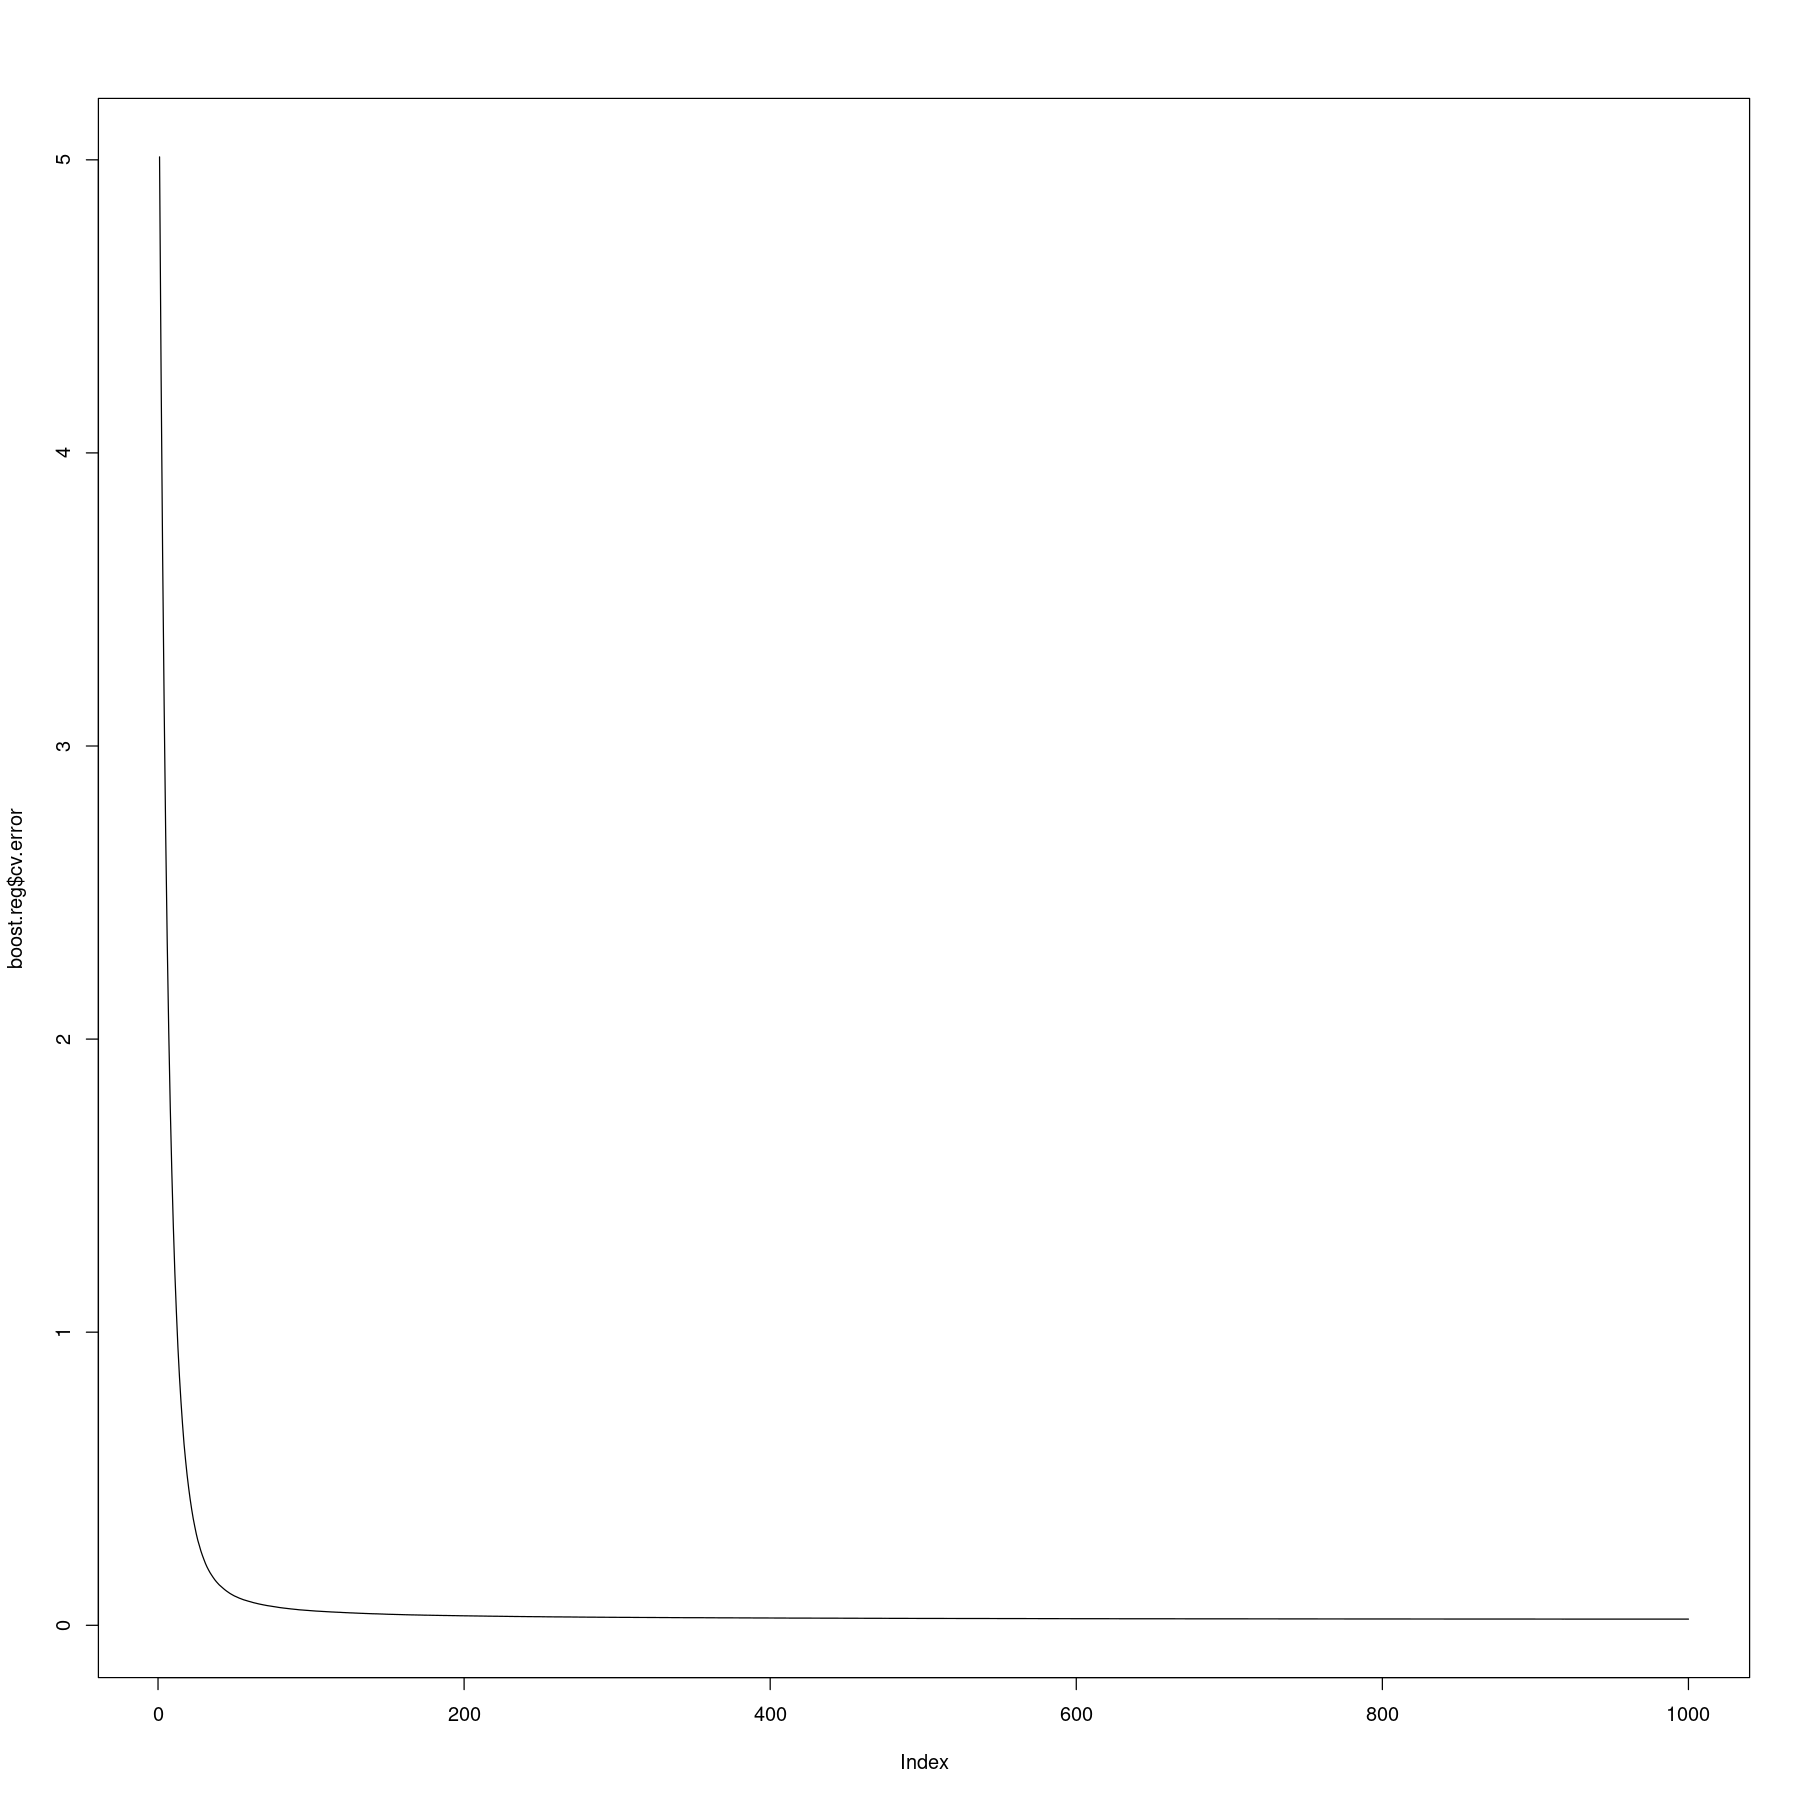

In [328]:
boost.reg = gbm(Svalue_co2 ~ ., data = datappi, distribution = "gaussian", n.trees = model$bestTune$n.trees, 
    cv.folds = 10,interaction.depth = model$bestTune$interaction.depth, n.minobsinnode = model$bestTune$n.minobsinnode, shrinkage = model$bestTune$shrinkage, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error, type = "l")

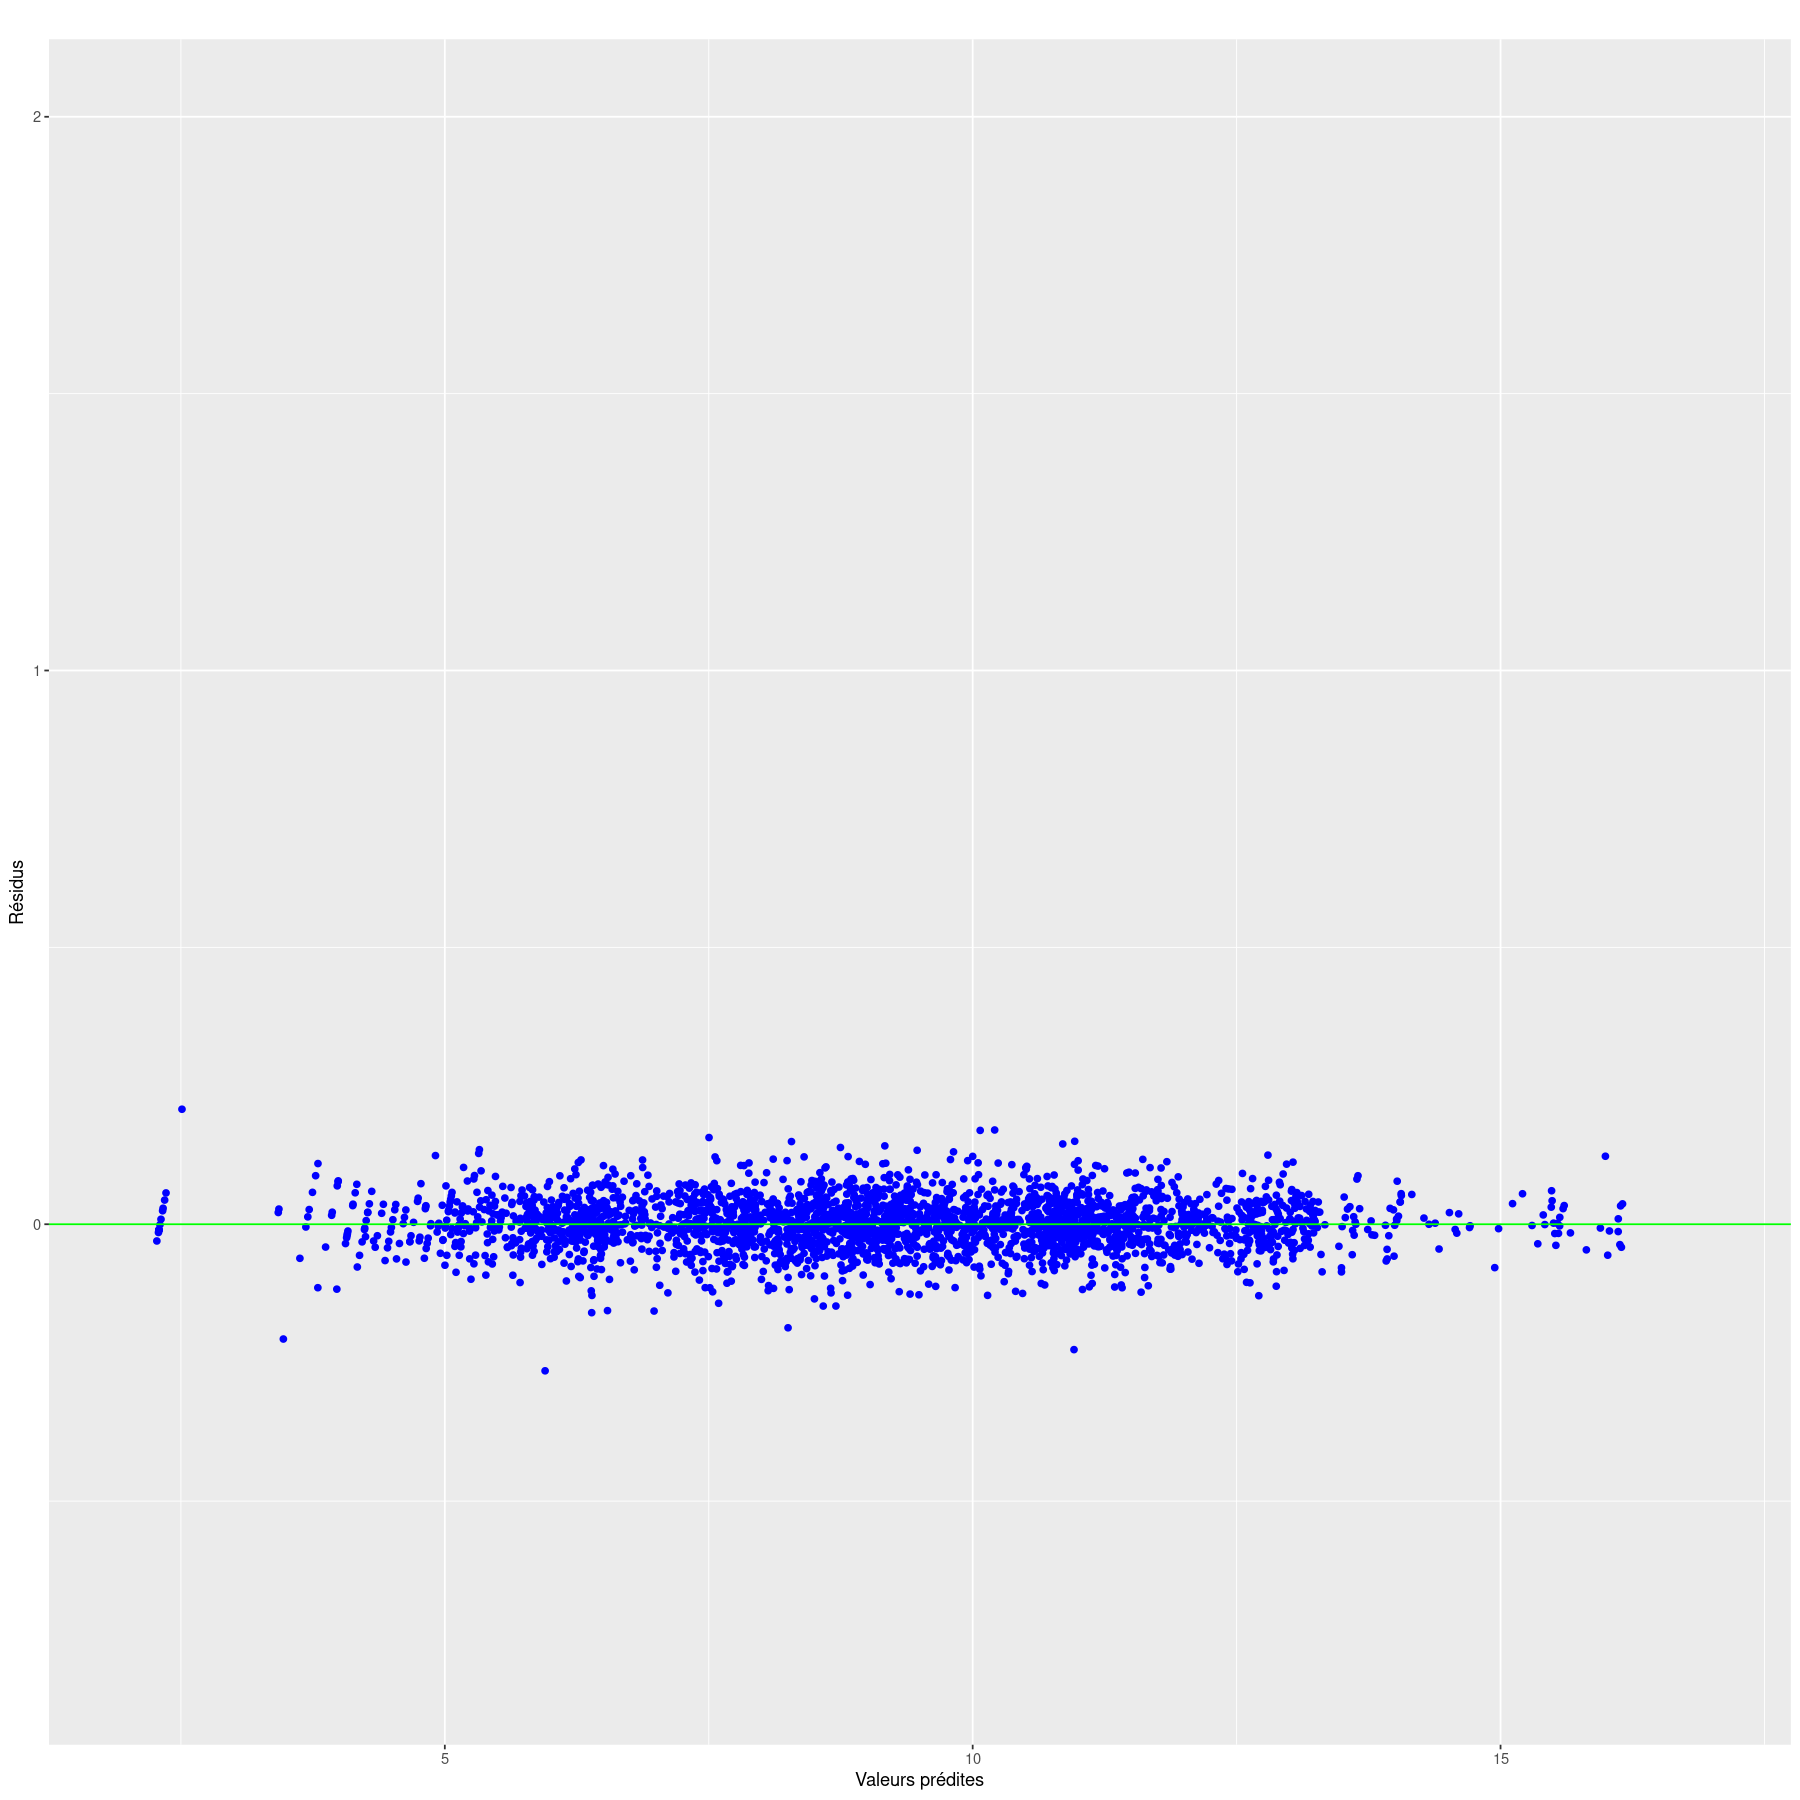

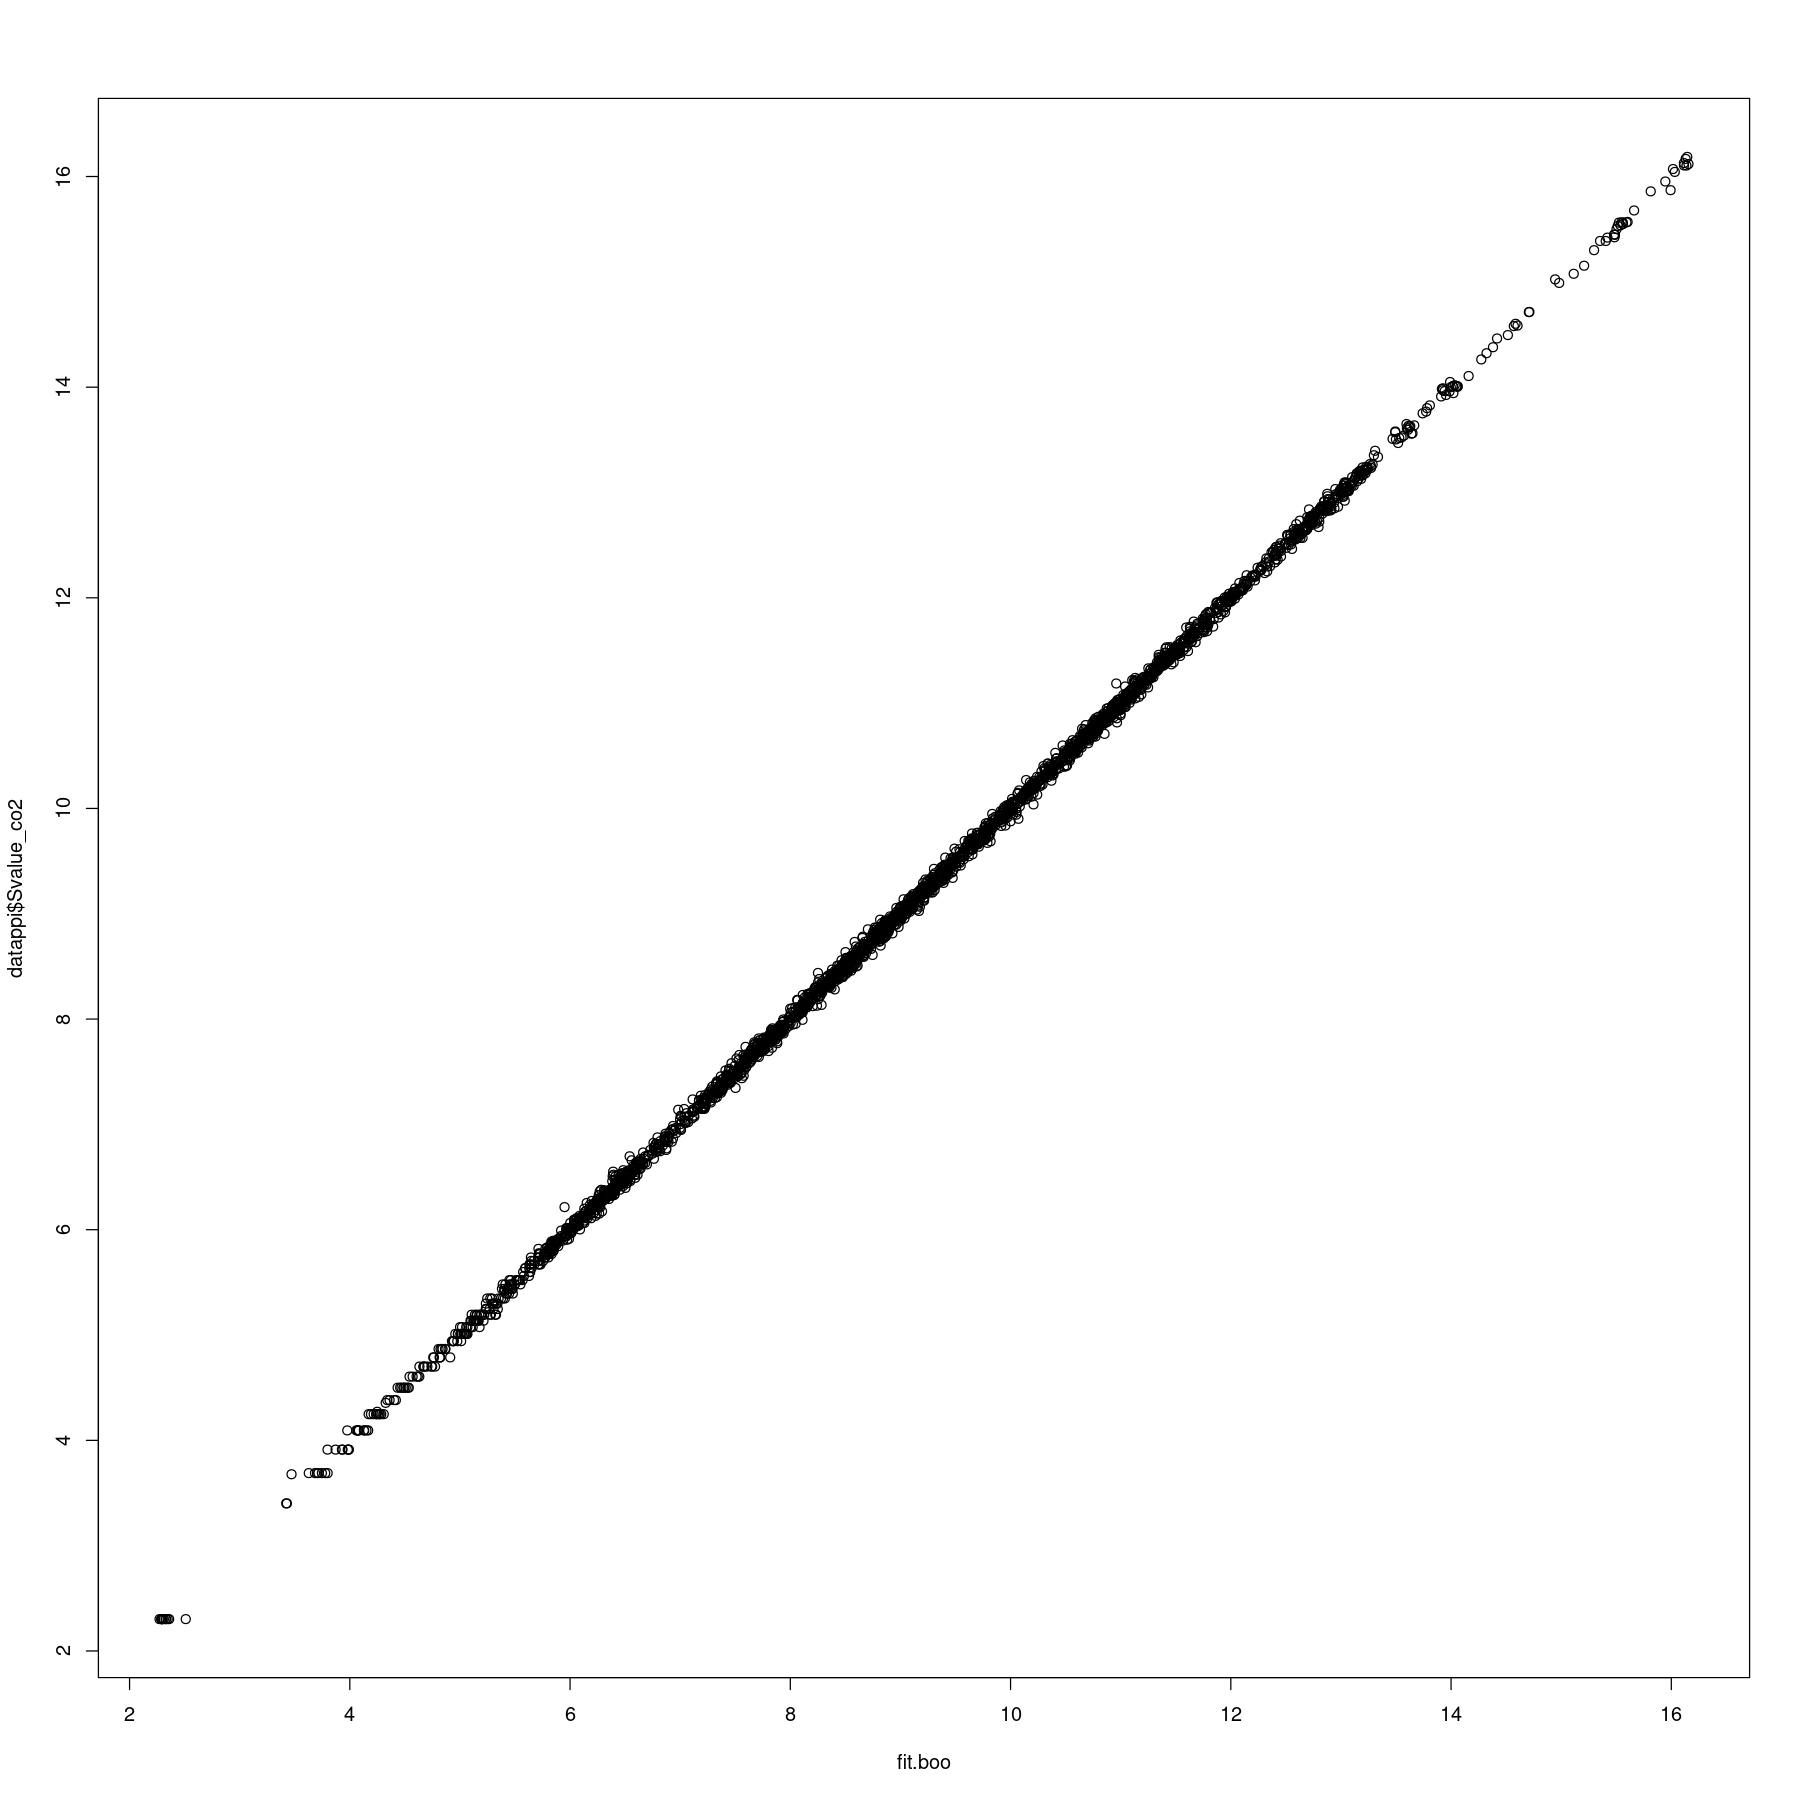

In [330]:
fit.boo=boost.reg$fit
res.boo=fit.boo-datappi[,"Svalue_co2"]
gplot.res(fit.boo,res.boo,titre="")
plot(fit.boo,datappi$Svalue_co2)

Using 1000 trees...




[1] 0.02072341

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


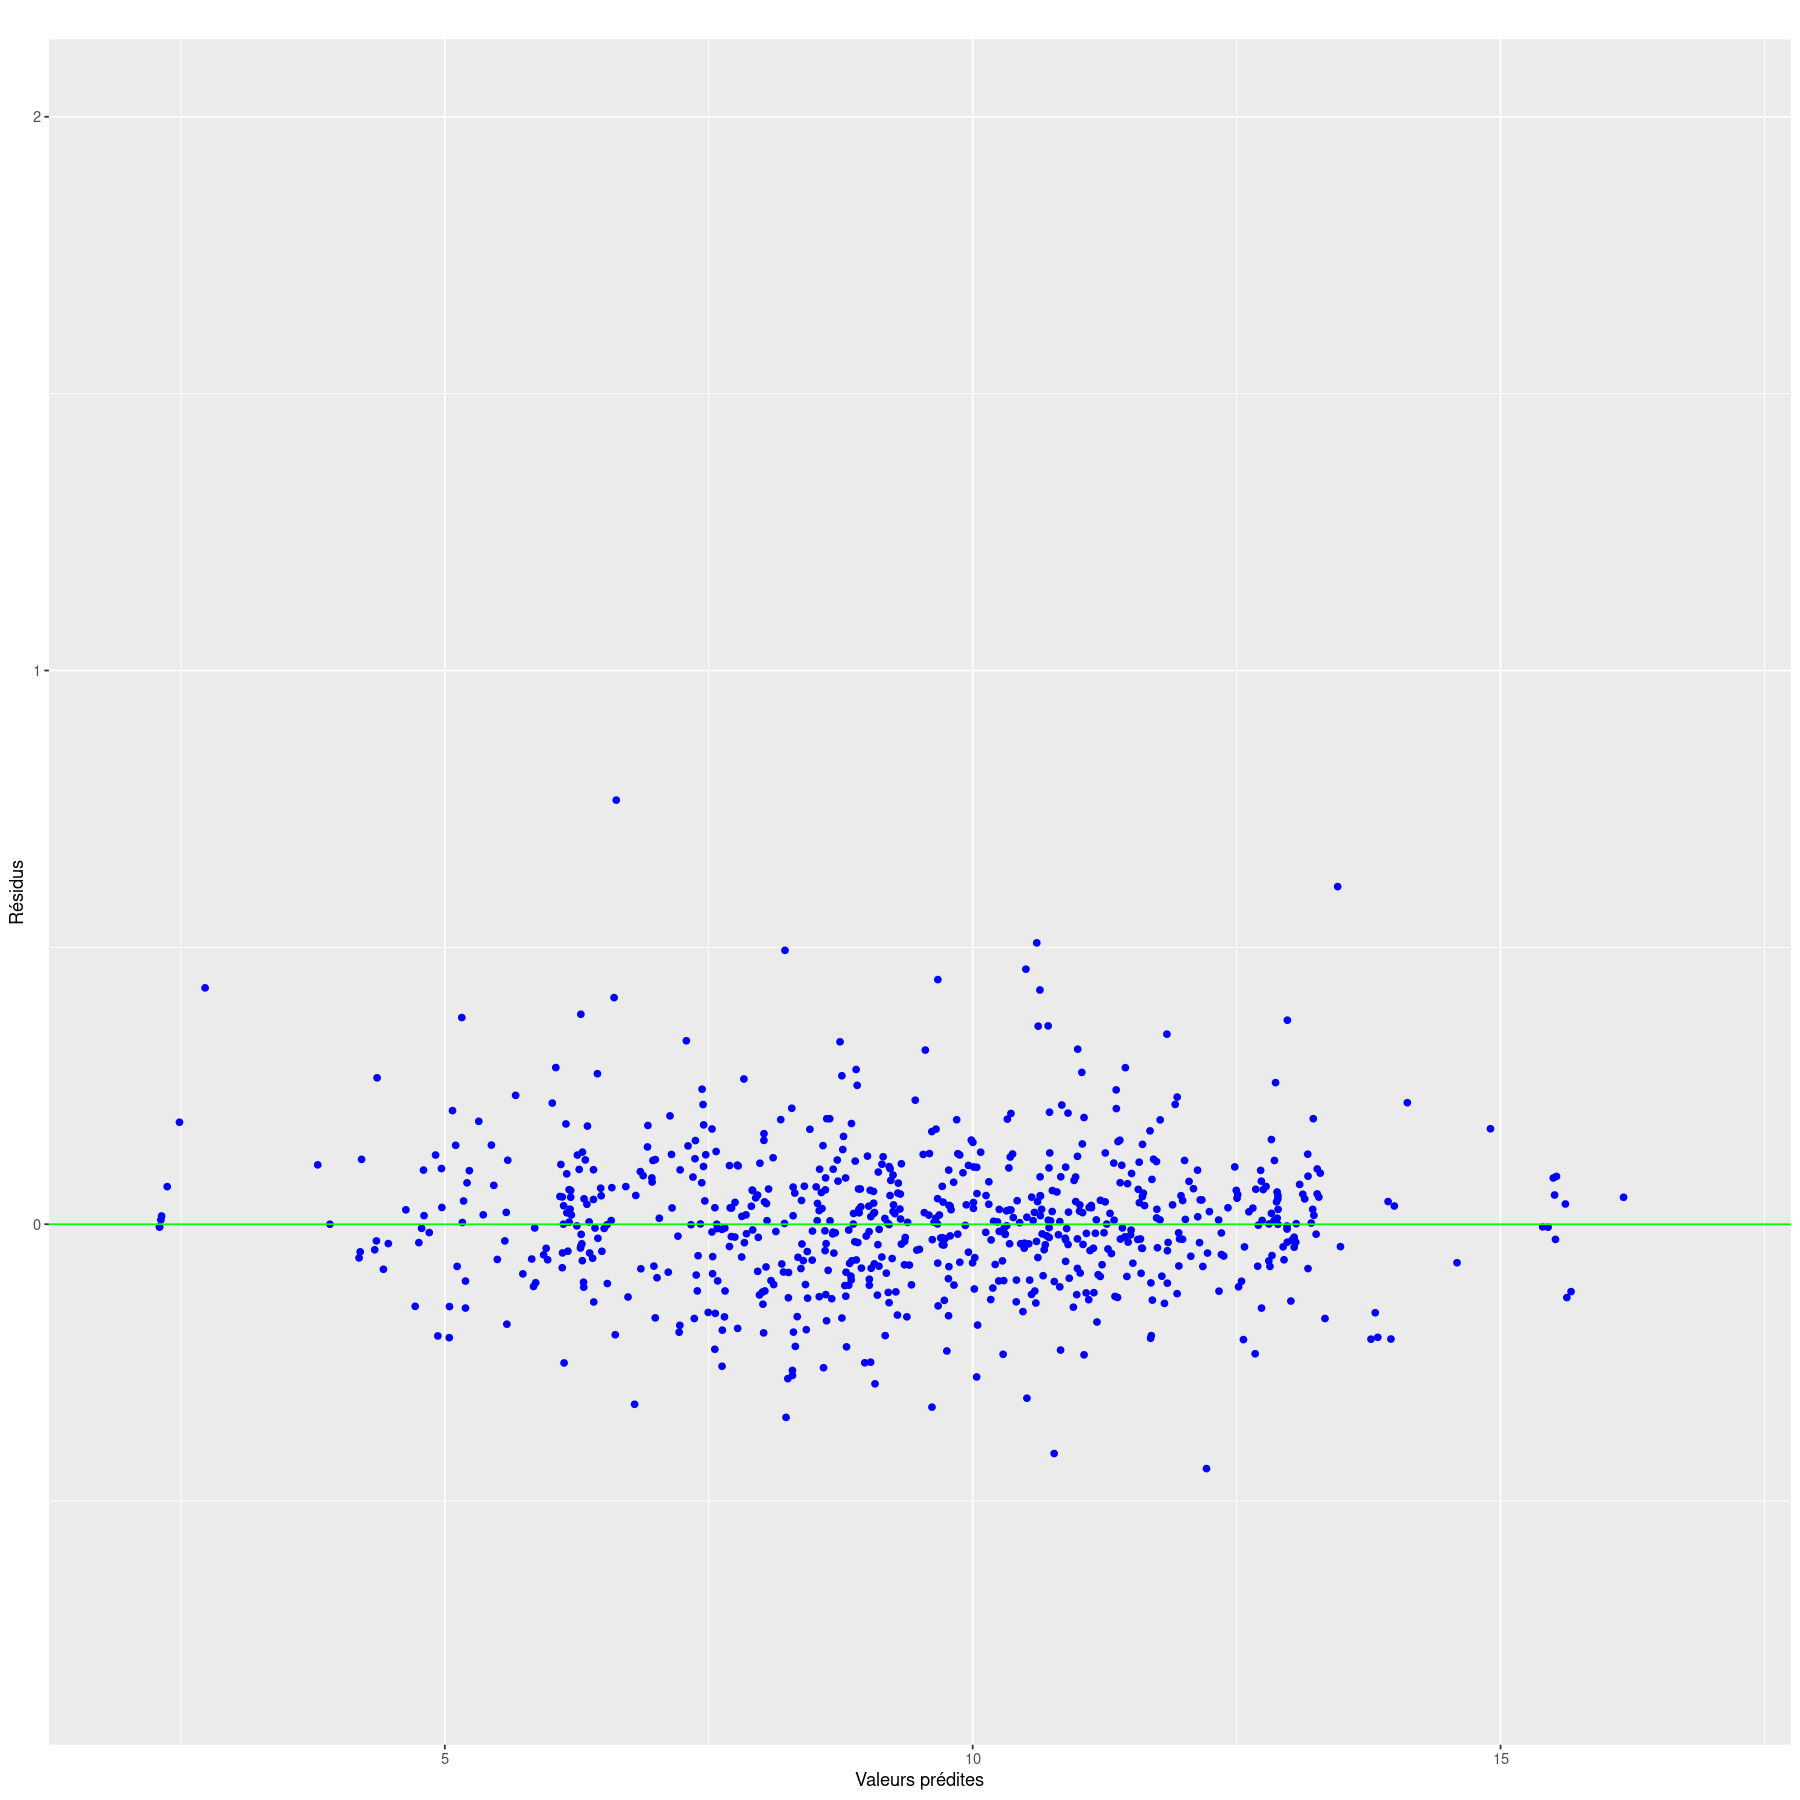

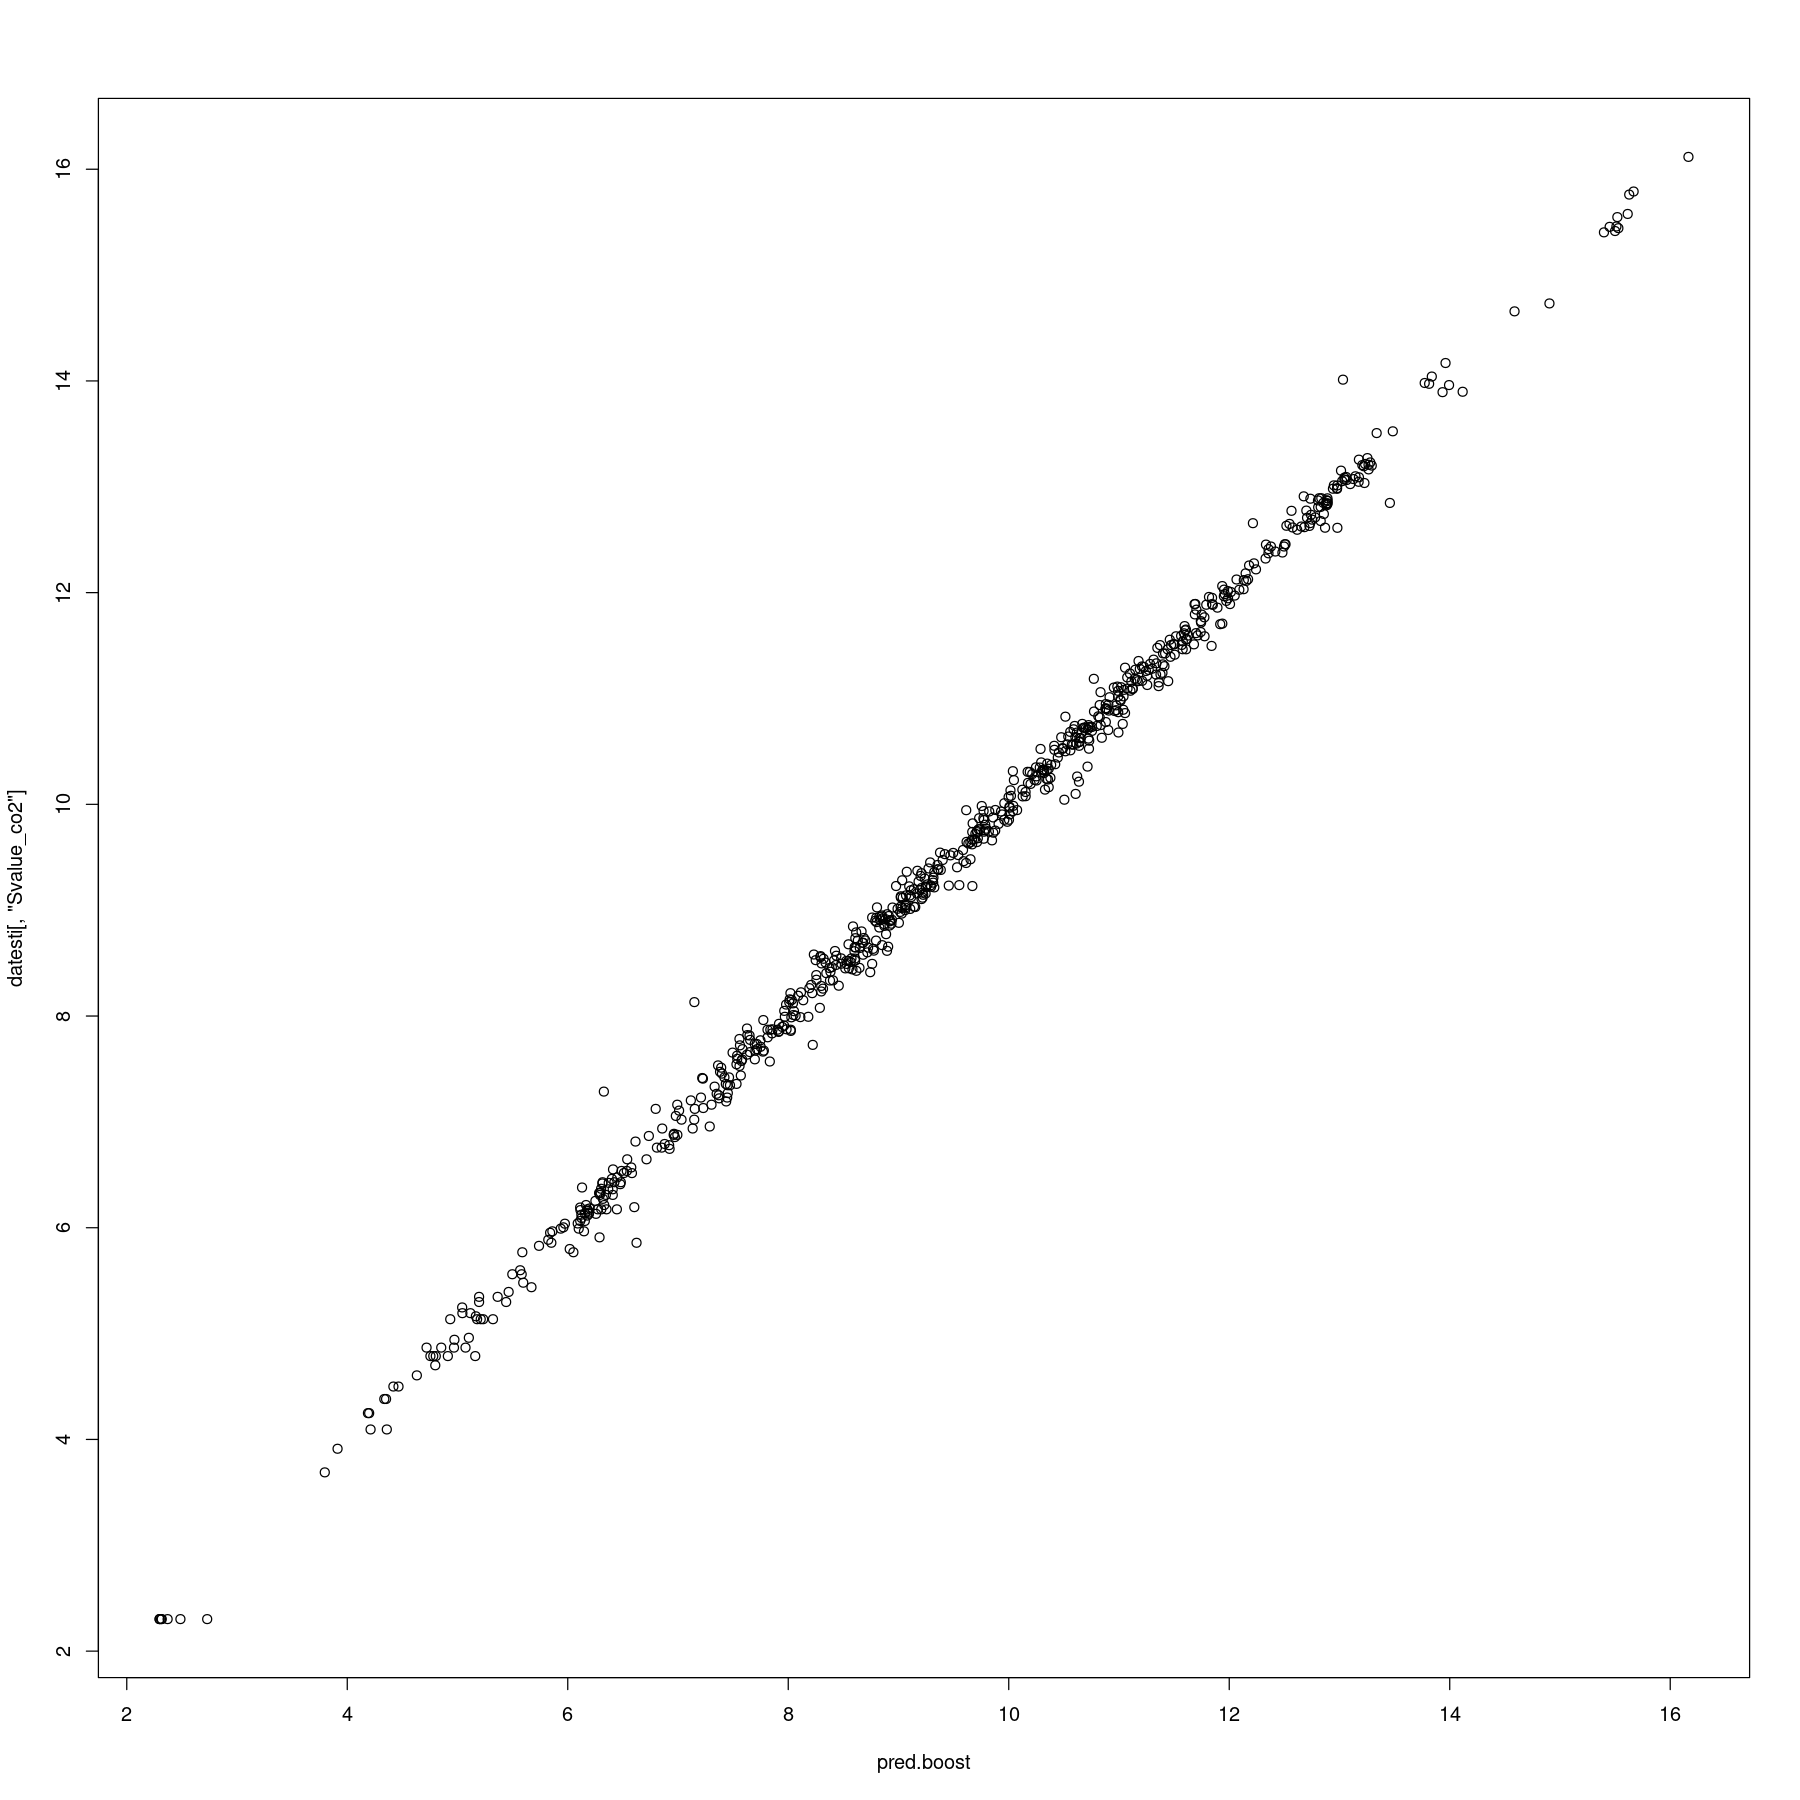

In [331]:
#Sur nos données test
pred.boost=predict(boost.reg,newdata=datesti)
#Erreur quadratique moyenne de prévision
sum((pred.boost-datesti[,"Svalue_co2"])^2)/nrow(datesti)

err.boost=pred.boost-datesti[,"Svalue_co2"]

gplot.res(pred.boost,err.boost,titre="")
plot(pred.boost,datesti[,"Svalue_co2"])